In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import CountEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from random import randint

In [2]:
pwd

'C:\\Users\\Ecjoee\\Documents\\HACKATHON\\TheMathCompany'

In [3]:
train = pd.read_csv(r"C:\\Users\\Ecjoee\\Documents\\HACKATHON\\TheMathCompany\\train.csv")
test = pd.read_csv(r"C:\\Users\\Ecjoee\\Documents\\HACKATHON\\TheMathCompany\\test.csv")
final = pd.read_csv(r"C:\\Users\\Ecjoee\\Documents\\HACKATHON\\TheMathCompany\\submission.csv")

In [4]:
train.head()

ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1     Tiptronic          4x4  04-May        Left wheel   Black        8  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4

In [5]:
print("Train shape: {}\nTest shape: {}".format(train.shape, test.shape))

Train shape: (19237, 18)
Test shape: (8245, 18)


In [6]:
target = train['Price']
train.drop(['Price'], axis=1, inplace=True)
test.drop(['Price'], axis=1, inplace=True)

In [7]:
def join_df(train, test):
    df = pd.concat([train, test], axis=0).reset_index(drop=True)
    features = [c for c in df.columns]
    return df, features

In [8]:
df, features = join_df(train, test)

In [9]:
df.isnull().sum()

ID                  0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [10]:
df.dtypes

ID                    int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

In [11]:
df.drop(['ID'], axis=1, inplace=True)

In [12]:
# def unique_values(data):
#     for col in data.select_dtypes(object).columns:
#         print("*************{}****************".format(col))
#         print(data[col].value_counts())
#         print(data[col].unique())
# unique_values(df)

In [13]:
df['Levy'] = df['Levy'].replace({'-': np.nan})

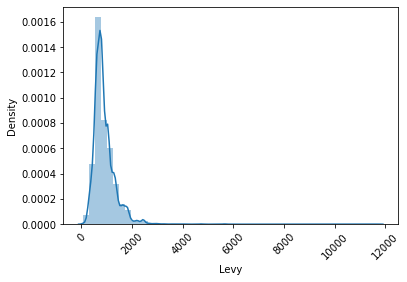

In [14]:
sns.distplot(df['Levy'])
plt.xticks(rotation=45)
plt.show()

In [15]:
df['Levy'] = df['Levy'].astype(float)
df['Levy'] = df['Levy'].fillna(df['Levy'].mean())
df['Levy'] = df['Levy'].round(2)

df['Mileage'] = df['Mileage'].str.replace('km',' ')
df['Mileage'] = df['Mileage'].astype(int)

df['Turbo'] = np.where(df['Engine volume'].str.contains('Turbo'), 1 , 0)

df['Engine volume'] = df['Engine volume'].str.replace('Turbo',' ')
df['Engine volume'] = df['Engine volume'].astype(float)

df['Doors'] = df['Doors'].replace({'04-May': 4 , '02-Mar': 2, '>5':5})


In [16]:
cols = {'Leather interior'}
for i in cols:
    df[i]=pd.get_dummies(df[i], drop_first=True)

In [17]:
cols = ['Manufacturer', 'Model','Prod. year', 
        'Category', 'Fuel type', 'Gear box type', 
        'Drive wheels', 'Wheel', 'Color']
ct_enc = CountEncoder()
count_enc = ct_enc.fit_transform(df[cols])
df = df.join(count_enc.add_suffix("_enc"))

df.drop(cols, axis=1, inplace=True)

In [18]:
df.head()

Levy  Leather interior  Engine volume  Mileage  Cylinders  Doors  \
0  1399.00                 1            3.5   186005        6.0      4   
1  1018.00                 0            3.0   192000        6.0      4   
2   910.16                 0            1.3   200000        4.0      4   
3   862.00                 1            2.5   168966        4.0      4   
4   446.00                 1            1.3    91901        4.0      4   

   Airbags  Turbo  Manufacturer_enc  Model_enc  Prod. year_enc  Category_enc  \
0       12      0              1433        244            2010          7821   
1        8      0              1520         32            2011          7821   
2        2      0              1391        609            2006          4038   
3        0      0              1592        207            2011          7821   
4        4      0              1391        609            2014          4038   

   Fuel type_enc  Gear box type_enc  Drive wheels_enc  Wheel_enc  Color_enc  
0           5089              19296              5802      25384       5422  
1          14492               4463              5802      25384       7196  
2          14492               1048             18374       2098       7196  
3           5089              19296              5802      25384       6392  
4          14492              19296             18374      25384       5422

In [19]:
df.describe()

Levy  Leather interior  Engine volume       Mileage  \
count  27482.000000      27482.000000   27482.000000  2.748200e+04   
mean     910.160639          0.725056       2.313107  1.468036e+06   
std      381.139491          0.446494       0.881283  4.821110e+07   
min       87.000000          0.000000       0.000000  0.000000e+00   
25%      730.000000          0.000000       1.800000  7.050100e+04   
50%      910.160000          1.000000       2.000000  1.266130e+05   
75%      917.000000          1.000000       2.500000  1.897040e+05   
max    11714.000000          1.000000      20.000000  2.147484e+09   

          Cylinders         Doors       Airbags         Turbo  \
count  27482.000000  27482.000000  27482.000000  27482.000000   
mean       4.593734      3.924387      6.563569      0.100393   
std        1.413918      0.406404      4.329256      0.300529   
min        1.000000      2.000000      0.000000      0.000000   
25%        4.000000      4.000000      4.000000      0.000000   
50%        4.000000      4.000000      6.000000      0.000000   
75%        4.000000      4.000000     12.000000      0.000000   
max      127.000000      5.000000     16.000000      1.000000   

       Manufacturer_enc     Model_enc  Prod. year_enc  Category_enc  \
count      27482.000000  27482.000000    27482.000000  27482.000000   
mean        2864.767994    481.217597     2010.912452   8608.014555   
std         2020.033902    537.685530        5.632865   4172.621724   
min            1.000000      1.000000     1939.000000     15.000000   
25%         1391.000000     49.000000     2009.000000   4038.000000   
50%         1592.000000    239.000000     2012.000000   7821.000000   
75%         5177.000000    760.000000     2015.000000  12534.000000   
max         5358.000000   1557.000000     2020.000000  12534.000000   

       Fuel type_enc  Gear box type_enc  Drive wheels_enc     Wheel_enc  \
count   27482.000000       27482.000000      27482.000000  27482.000000   
mean     9877.632341       14573.463140      13907.165272  23606.326323   
std      5007.187345        7281.348695       6382.025563   6183.540803   
min         2.000000        1048.000000       3306.000000   2098.000000   
25%      5089.000000        4463.000000       5802.000000  25384.000000   
50%     14492.000000       19296.000000      18374.000000  25384.000000   
75%     14492.000000       19296.000000      18374.000000  25384.000000   
max     14492.000000       19296.000000      18374.000000  25384.000000   

          Color_enc  
count  27482.000000  
mean    5060.188487  
std     2239.703798  
min       31.000000  
25%     3400.000000  
50%     5422.000000  
75%     7196.000000  
max     7196.000000

In [20]:
df.columns

Index(['Levy', 'Leather interior', 'Engine volume', 'Mileage', 'Cylinders',
       'Doors', 'Airbags', 'Turbo', 'Manufacturer_enc', 'Model_enc',
       'Prod. year_enc', 'Category_enc', 'Fuel type_enc', 'Gear box type_enc',
       'Drive wheels_enc', 'Wheel_enc', 'Color_enc'],
      dtype='object')

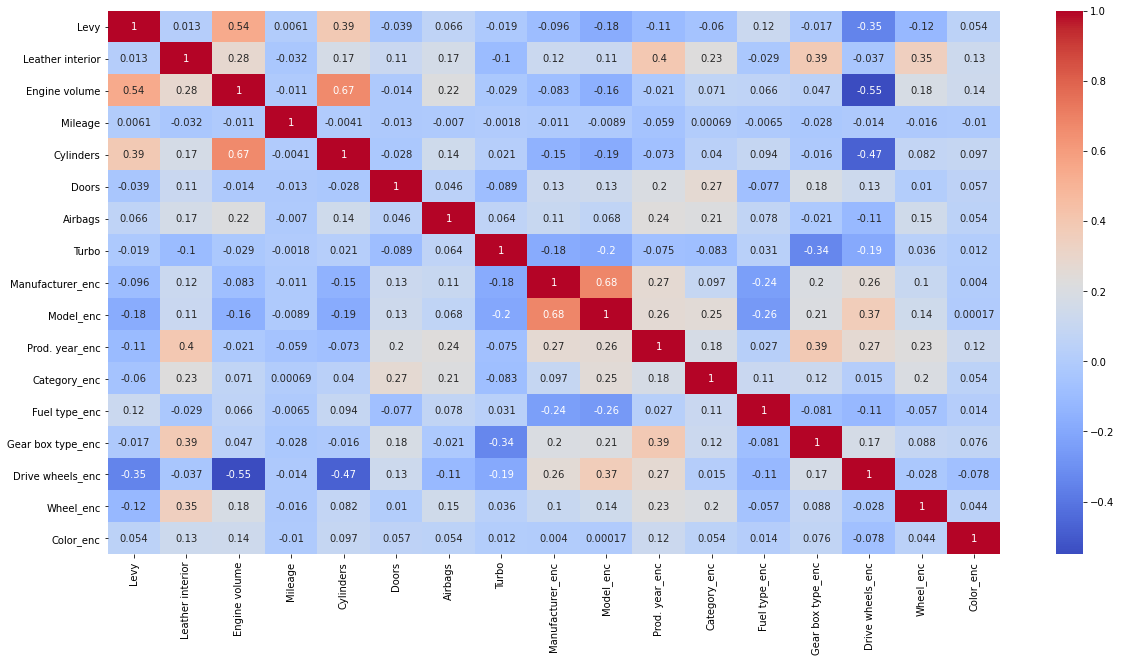

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm' )
plt.show()

In [22]:
df.columns

Index(['Levy', 'Leather interior', 'Engine volume', 'Mileage', 'Cylinders',
       'Doors', 'Airbags', 'Turbo', 'Manufacturer_enc', 'Model_enc',
       'Prod. year_enc', 'Category_enc', 'Fuel type_enc', 'Gear box type_enc',
       'Drive wheels_enc', 'Wheel_enc', 'Color_enc'],
      dtype='object')

In [23]:
target_col = 'Price'
def split_df_and_get_features(df, train_nrows):
    
    train, test = df[:train_nrows].reset_index(drop=True) , df[train_nrows:].reset_index(drop=True)
    features = [i for i in df.columns if i not in target_col]
    return train, test , features

In [24]:
train_proc , test_proc, features = split_df_and_get_features(df, train.shape[0])

In [25]:
print("Train size: {}".format(train_proc.shape))
print("Test size: {}".format(test_proc.shape))
print("Target size: {}".format(target.shape))

Train size: (19237, 17)
Test size: (8245, 17)
Target size: (19237,)


In [38]:
accuracy=[]
def cross_val(X, y, model):
    
    oofs = np.zeros(len(train_proc))
    preds = np.zeros((len(test_proc)))
    
    folds=10
    kfold=StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kfold.split(X,y)):
        
        print("-------------------Fold: {}------------------".format(fold))
        
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        ## Test Set
        X_test = test_proc
        scaler = StandardScaler().fit(X_train)

        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(test_proc)
        
        # fit scaler on training data
#         norm = MinMaxScaler().fit(X_train)

#         # transform training data
#         X_train = norm.transform(X_train)
#         X_val = norm.transform(X_val)
#         X_test = norm.transform(test_proc)
        
#         rs = RobustScaler().fit(X_train)
        
#         X_train = rs.transform(X_train)
#         X_val = rs.transform(X_val)
#         X_test = rs.transform(test_proc)
        
        
        eval_set = [(X_train, y_train), (X_val, y_val)]
        model.fit(X_train, y_train, eval_set=eval_set)
        
        pred_val = np.abs(model.predict(X_val))
        val_score = np.sqrt(mean_squared_log_error(y_val,pred_val))
        
        pred_test = np.abs(model.predict(X_test))
#         test_score = np.sqrt(mean_squared_log_error(y_val,pred_val))
        print("RMSLE Score for validation set : {}".format(val_score))
        
        oofs[test_index] = pred_val
        preds += pred_test / 10


    test_score = np.sqrt(mean_squared_log_error(target, oofs.round()))
    print("RMSLE Score for test set : {}".format(test_score))

#         accuracy.append(val_score)
    return model


In [45]:
xgb_model = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                  )

xgb = cross_val(train_proc, target, xgb)
# print("RMSLE Score for validation set : {}".format(np.mean(accuracy)))

-------------------Fold: 0------------------
[0]	validation_0-rmse:198288.90625	validation_1-rmse:26225.11719
[1]	validation_0-rmse:193317.03125	validation_1-rmse:25596.37695
[2]	validation_0-rmse:190969.21875	validation_1-rmse:25051.91016
[3]	validation_0-rmse:186190.84375	validation_1-rmse:24515.85547
[4]	validation_0-rmse:181524.20312	validation_1-rmse:23939.32812
[5]	validation_0-rmse:176987.92188	validation_1-rmse:23450.92383
[6]	validation_0-rmse:174766.37500	validation_1-rmse:23048.00781
[7]	validation_0-rmse:172039.70312	validation_1-rmse:22672.00977
[8]	validation_0-rmse:167754.73438	validation_1-rmse:22315.52344
[9]	validation_0-rmse:163576.62500	validation_1-rmse:21941.99023
[10]	validation_0-rmse:159498.00000	validation_1-rmse:21570.66016
[11]	validation_0-rmse:157505.34375	validation_1-rmse:21237.59766
[12]	validation_0-rmse:153573.60938	validation_1-rmse:20885.36523
[13]	validation_0-rmse:152853.76562	validation_1-rmse:20631.89844
[14]	validation_0-rmse:149055.56250	valid

[125]	validation_0-rmse:20839.95703	validation_1-rmse:15388.04883
[126]	validation_0-rmse:20820.73828	validation_1-rmse:15380.29004
[127]	validation_0-rmse:20420.25000	validation_1-rmse:15383.43457
[128]	validation_0-rmse:20031.02148	validation_1-rmse:15374.37109
[129]	validation_0-rmse:19640.27930	validation_1-rmse:15362.77832
[130]	validation_0-rmse:19288.75000	validation_1-rmse:15365.57910
[131]	validation_0-rmse:19275.14648	validation_1-rmse:15354.87109
[132]	validation_0-rmse:19122.52539	validation_1-rmse:15343.31836
[133]	validation_0-rmse:18763.33398	validation_1-rmse:15338.46973
[134]	validation_0-rmse:18417.18359	validation_1-rmse:15335.92578
[135]	validation_0-rmse:18079.93359	validation_1-rmse:15332.28418
[136]	validation_0-rmse:17751.62109	validation_1-rmse:15331.43359
[137]	validation_0-rmse:17733.31641	validation_1-rmse:15336.08008
[138]	validation_0-rmse:17414.82227	validation_1-rmse:15341.94922
[139]	validation_0-rmse:17247.56445	validation_1-rmse:15331.19238
[140]	vali

[250]	validation_0-rmse:9376.81348	validation_1-rmse:15036.30664
[251]	validation_0-rmse:9372.04492	validation_1-rmse:15036.22266
[252]	validation_0-rmse:9369.83887	validation_1-rmse:15035.43066
[253]	validation_0-rmse:9358.91699	validation_1-rmse:15027.99219
[254]	validation_0-rmse:9348.34766	validation_1-rmse:15024.94238
[255]	validation_0-rmse:9318.19629	validation_1-rmse:15033.41406
[256]	validation_0-rmse:9308.33789	validation_1-rmse:15037.10742
[257]	validation_0-rmse:9300.25684	validation_1-rmse:15037.34863
[258]	validation_0-rmse:9295.34961	validation_1-rmse:15039.79492
[259]	validation_0-rmse:9289.55078	validation_1-rmse:15039.12891
[260]	validation_0-rmse:9259.81543	validation_1-rmse:15036.65234
[261]	validation_0-rmse:9249.95410	validation_1-rmse:15027.51758
[262]	validation_0-rmse:9243.66113	validation_1-rmse:15025.36719
[263]	validation_0-rmse:9232.46777	validation_1-rmse:15026.73340
[264]	validation_0-rmse:9225.54883	validation_1-rmse:15026.20019
[265]	validation_0-rmse:9

[377]	validation_0-rmse:8222.55469	validation_1-rmse:14904.45117
[378]	validation_0-rmse:8214.00684	validation_1-rmse:14897.18555
[379]	validation_0-rmse:8181.65137	validation_1-rmse:14896.61523
[380]	validation_0-rmse:8146.20654	validation_1-rmse:14903.58594
[381]	validation_0-rmse:8144.09912	validation_1-rmse:14901.31445
[382]	validation_0-rmse:8136.38672	validation_1-rmse:14899.48242
[383]	validation_0-rmse:8130.38867	validation_1-rmse:14897.45703
[384]	validation_0-rmse:8118.20508	validation_1-rmse:14893.73242
[385]	validation_0-rmse:8111.73926	validation_1-rmse:14893.96875
[386]	validation_0-rmse:8103.69678	validation_1-rmse:14894.18359
[387]	validation_0-rmse:8096.04150	validation_1-rmse:14894.75195
[388]	validation_0-rmse:8076.48682	validation_1-rmse:14891.62402
[389]	validation_0-rmse:8037.08398	validation_1-rmse:14892.93652
[390]	validation_0-rmse:8035.68311	validation_1-rmse:14894.00586
[391]	validation_0-rmse:8032.54980	validation_1-rmse:14892.65625
[392]	validation_0-rmse:8

[504]	validation_0-rmse:7154.68897	validation_1-rmse:14773.05566
[505]	validation_0-rmse:7149.58643	validation_1-rmse:14772.70312
[506]	validation_0-rmse:7145.50781	validation_1-rmse:14772.71484
[507]	validation_0-rmse:7144.99512	validation_1-rmse:14773.04394
[508]	validation_0-rmse:7144.52539	validation_1-rmse:14768.55273
[509]	validation_0-rmse:7141.81103	validation_1-rmse:14768.24316
[510]	validation_0-rmse:7119.43408	validation_1-rmse:14766.70117
[511]	validation_0-rmse:7115.62549	validation_1-rmse:14765.87012
[512]	validation_0-rmse:7112.28857	validation_1-rmse:14765.78027
[513]	validation_0-rmse:7108.23047	validation_1-rmse:14764.38574
[514]	validation_0-rmse:7107.74316	validation_1-rmse:14764.58301
[515]	validation_0-rmse:7089.98779	validation_1-rmse:14764.39746
[516]	validation_0-rmse:7086.95752	validation_1-rmse:14764.78418
[517]	validation_0-rmse:7085.32959	validation_1-rmse:14763.89844
[518]	validation_0-rmse:7080.71094	validation_1-rmse:14763.52344
[519]	validation_0-rmse:7

[631]	validation_0-rmse:6563.86328	validation_1-rmse:14700.25977
[632]	validation_0-rmse:6559.20361	validation_1-rmse:14700.45508
[633]	validation_0-rmse:6553.60742	validation_1-rmse:14701.92285
[634]	validation_0-rmse:6550.02539	validation_1-rmse:14698.23535
[635]	validation_0-rmse:6544.43555	validation_1-rmse:14697.62500
[636]	validation_0-rmse:6543.37451	validation_1-rmse:14697.68164
[637]	validation_0-rmse:6539.19824	validation_1-rmse:14704.01465
[638]	validation_0-rmse:6535.92871	validation_1-rmse:14703.24121
[639]	validation_0-rmse:6521.74561	validation_1-rmse:14707.68652
[640]	validation_0-rmse:6518.93848	validation_1-rmse:14707.06348
[641]	validation_0-rmse:6514.55566	validation_1-rmse:14705.72363
[642]	validation_0-rmse:6511.48389	validation_1-rmse:14705.40723
[643]	validation_0-rmse:6508.19922	validation_1-rmse:14707.86523
[644]	validation_0-rmse:6506.27832	validation_1-rmse:14707.82422
[645]	validation_0-rmse:6500.43359	validation_1-rmse:14708.40723
[646]	validation_0-rmse:6

[758]	validation_0-rmse:6066.53662	validation_1-rmse:14679.07129
[759]	validation_0-rmse:6064.91797	validation_1-rmse:14678.43066
[760]	validation_0-rmse:6060.89551	validation_1-rmse:14681.26660
[761]	validation_0-rmse:6059.39844	validation_1-rmse:14681.35059
[762]	validation_0-rmse:6048.70508	validation_1-rmse:14681.54981
[763]	validation_0-rmse:6045.89648	validation_1-rmse:14679.83301
[764]	validation_0-rmse:6041.19141	validation_1-rmse:14678.34863
[765]	validation_0-rmse:6039.26123	validation_1-rmse:14677.76172
[766]	validation_0-rmse:6029.00781	validation_1-rmse:14673.04297
[767]	validation_0-rmse:6027.65967	validation_1-rmse:14672.22168
[768]	validation_0-rmse:6025.95654	validation_1-rmse:14672.04981
[769]	validation_0-rmse:6025.17480	validation_1-rmse:14672.74219
[770]	validation_0-rmse:6023.73828	validation_1-rmse:14672.17481
[771]	validation_0-rmse:6019.91455	validation_1-rmse:14670.92676
[772]	validation_0-rmse:6018.37012	validation_1-rmse:14670.68555
[773]	validation_0-rmse:6

[885]	validation_0-rmse:5731.04590	validation_1-rmse:14651.01172
[886]	validation_0-rmse:5728.96436	validation_1-rmse:14649.95898
[887]	validation_0-rmse:5725.59277	validation_1-rmse:14650.20019
[888]	validation_0-rmse:5723.15039	validation_1-rmse:14648.52734
[889]	validation_0-rmse:5720.56934	validation_1-rmse:14648.24707
[890]	validation_0-rmse:5717.83643	validation_1-rmse:14648.68750
[891]	validation_0-rmse:5715.23242	validation_1-rmse:14648.43164
[892]	validation_0-rmse:5713.86328	validation_1-rmse:14648.12012
[893]	validation_0-rmse:5711.09522	validation_1-rmse:14648.19141
[894]	validation_0-rmse:5708.24023	validation_1-rmse:14646.82617
[895]	validation_0-rmse:5706.54199	validation_1-rmse:14646.31934
[896]	validation_0-rmse:5704.41650	validation_1-rmse:14647.00684
[897]	validation_0-rmse:5702.35107	validation_1-rmse:14646.75000
[898]	validation_0-rmse:5699.78369	validation_1-rmse:14643.05664
[899]	validation_0-rmse:5698.20117	validation_1-rmse:14641.62305
[900]	validation_0-rmse:5

[10]	validation_0-rmse:157885.46875	validation_1-rmse:26250.79688
[11]	validation_0-rmse:153946.50000	validation_1-rmse:28474.54492
[12]	validation_0-rmse:150107.98438	validation_1-rmse:28221.14453
[13]	validation_0-rmse:149336.20312	validation_1-rmse:28094.16797
[14]	validation_0-rmse:145617.70312	validation_1-rmse:27867.56836
[15]	validation_0-rmse:141989.71875	validation_1-rmse:27556.04688
[16]	validation_0-rmse:138459.78125	validation_1-rmse:27360.88086
[17]	validation_0-rmse:135018.81250	validation_1-rmse:27193.83594
[18]	validation_0-rmse:131665.53125	validation_1-rmse:27048.53125
[19]	validation_0-rmse:128396.10938	validation_1-rmse:26880.06445
[20]	validation_0-rmse:127355.04688	validation_1-rmse:26764.94727
[21]	validation_0-rmse:124186.16406	validation_1-rmse:26575.89258
[22]	validation_0-rmse:121103.25781	validation_1-rmse:26351.36523
[23]	validation_0-rmse:118102.18750	validation_1-rmse:26227.51562
[24]	validation_0-rmse:115174.39844	validation_1-rmse:26120.23438
[25]	valid

[136]	validation_0-rmse:16016.20117	validation_1-rmse:32647.26172
[137]	validation_0-rmse:15985.03418	validation_1-rmse:32704.93555
[138]	validation_0-rmse:15715.95410	validation_1-rmse:32732.85352
[139]	validation_0-rmse:15566.77344	validation_1-rmse:32727.74219
[140]	validation_0-rmse:15546.84277	validation_1-rmse:32722.35547
[141]	validation_0-rmse:15469.34180	validation_1-rmse:32715.85938
[142]	validation_0-rmse:15213.20996	validation_1-rmse:32703.73828
[143]	validation_0-rmse:15193.39941	validation_1-rmse:32724.36719
[144]	validation_0-rmse:15187.46582	validation_1-rmse:32729.85938
[145]	validation_0-rmse:14954.78418	validation_1-rmse:32717.39453
[146]	validation_0-rmse:14942.25000	validation_1-rmse:32717.13281
[147]	validation_0-rmse:14929.79688	validation_1-rmse:32714.04492
[148]	validation_0-rmse:14688.75586	validation_1-rmse:32705.33789
[149]	validation_0-rmse:14682.87891	validation_1-rmse:32707.21875
[150]	validation_0-rmse:14448.52832	validation_1-rmse:32698.93750
[151]	vali

[261]	validation_0-rmse:8927.20215	validation_1-rmse:32515.96680
[262]	validation_0-rmse:8922.45801	validation_1-rmse:32515.86133
[263]	validation_0-rmse:8915.45117	validation_1-rmse:32515.47656
[264]	validation_0-rmse:8909.40234	validation_1-rmse:32512.41602
[265]	validation_0-rmse:8908.31348	validation_1-rmse:32515.81055
[266]	validation_0-rmse:8900.91211	validation_1-rmse:32515.93945
[267]	validation_0-rmse:8900.04590	validation_1-rmse:32516.24023
[268]	validation_0-rmse:8892.28418	validation_1-rmse:32516.61719
[269]	validation_0-rmse:8887.16504	validation_1-rmse:32518.41992
[270]	validation_0-rmse:8864.96582	validation_1-rmse:32521.85938
[271]	validation_0-rmse:8863.81543	validation_1-rmse:32522.96680
[272]	validation_0-rmse:8861.50000	validation_1-rmse:32523.26172
[273]	validation_0-rmse:8860.43262	validation_1-rmse:32523.38867
[274]	validation_0-rmse:8852.79199	validation_1-rmse:32518.32031
[275]	validation_0-rmse:8851.55859	validation_1-rmse:32522.39062
[276]	validation_0-rmse:8

[388]	validation_0-rmse:7596.71240	validation_1-rmse:32469.05664
[389]	validation_0-rmse:7587.52588	validation_1-rmse:32469.38086
[390]	validation_0-rmse:7585.02100	validation_1-rmse:32470.22070
[391]	validation_0-rmse:7582.20605	validation_1-rmse:32469.78320
[392]	validation_0-rmse:7580.49268	validation_1-rmse:32469.15039
[393]	validation_0-rmse:7574.89990	validation_1-rmse:32469.25000
[394]	validation_0-rmse:7547.51514	validation_1-rmse:32468.19141
[395]	validation_0-rmse:7542.95410	validation_1-rmse:32466.87891
[396]	validation_0-rmse:7534.89355	validation_1-rmse:32468.25391
[397]	validation_0-rmse:7519.62256	validation_1-rmse:32439.08594
[398]	validation_0-rmse:7509.75098	validation_1-rmse:32439.63086
[399]	validation_0-rmse:7500.69531	validation_1-rmse:32439.75977
[400]	validation_0-rmse:7493.04688	validation_1-rmse:32439.50000
[401]	validation_0-rmse:7491.69678	validation_1-rmse:32439.61914
[402]	validation_0-rmse:7463.01953	validation_1-rmse:32438.02539
[403]	validation_0-rmse:7

[515]	validation_0-rmse:6855.47900	validation_1-rmse:32436.84961
[516]	validation_0-rmse:6853.29150	validation_1-rmse:32438.08008
[517]	validation_0-rmse:6850.56934	validation_1-rmse:32435.02539
[518]	validation_0-rmse:6849.37500	validation_1-rmse:32435.08008
[519]	validation_0-rmse:6845.94971	validation_1-rmse:32433.98047
[520]	validation_0-rmse:6832.13477	validation_1-rmse:32427.11523
[521]	validation_0-rmse:6831.75244	validation_1-rmse:32427.18750
[522]	validation_0-rmse:6826.05420	validation_1-rmse:32428.11133
[523]	validation_0-rmse:6821.23047	validation_1-rmse:32429.09766
[524]	validation_0-rmse:6819.84180	validation_1-rmse:32428.91211
[525]	validation_0-rmse:6819.53809	validation_1-rmse:32429.13672
[526]	validation_0-rmse:6814.58496	validation_1-rmse:32427.61719
[527]	validation_0-rmse:6814.13965	validation_1-rmse:32427.55273
[528]	validation_0-rmse:6813.81152	validation_1-rmse:32427.52930
[529]	validation_0-rmse:6811.08398	validation_1-rmse:32427.41797
[530]	validation_0-rmse:6

[642]	validation_0-rmse:6300.81201	validation_1-rmse:32451.96875
[643]	validation_0-rmse:6298.78272	validation_1-rmse:32451.39258
[644]	validation_0-rmse:6295.91309	validation_1-rmse:32451.37109
[645]	validation_0-rmse:6291.14160	validation_1-rmse:32450.88477
[646]	validation_0-rmse:6289.64258	validation_1-rmse:32450.93750
[647]	validation_0-rmse:6272.34131	validation_1-rmse:32447.23633
[648]	validation_0-rmse:6265.06055	validation_1-rmse:32445.02148
[649]	validation_0-rmse:6262.49170	validation_1-rmse:32445.29883
[650]	validation_0-rmse:6258.06201	validation_1-rmse:32446.06055
[651]	validation_0-rmse:6254.65088	validation_1-rmse:32452.20117
[652]	validation_0-rmse:6250.73828	validation_1-rmse:32452.54492
[653]	validation_0-rmse:6245.35498	validation_1-rmse:32453.54297
[654]	validation_0-rmse:6242.53516	validation_1-rmse:32455.91016
[655]	validation_0-rmse:6239.32031	validation_1-rmse:32450.56445
[656]	validation_0-rmse:6236.10254	validation_1-rmse:32450.51953
[657]	validation_0-rmse:6

[769]	validation_0-rmse:5847.30029	validation_1-rmse:32450.70312
[770]	validation_0-rmse:5845.74365	validation_1-rmse:32457.42969
[771]	validation_0-rmse:5836.19385	validation_1-rmse:32465.29883
[772]	validation_0-rmse:5834.57568	validation_1-rmse:32465.23438
[773]	validation_0-rmse:5831.58936	validation_1-rmse:32465.61719
[774]	validation_0-rmse:5829.97266	validation_1-rmse:32465.42969
[775]	validation_0-rmse:5826.10010	validation_1-rmse:32464.85938
[776]	validation_0-rmse:5824.93457	validation_1-rmse:32463.83008
[777]	validation_0-rmse:5821.58545	validation_1-rmse:32461.80664
[778]	validation_0-rmse:5818.48242	validation_1-rmse:32462.36328
[779]	validation_0-rmse:5814.05615	validation_1-rmse:32461.94141
[780]	validation_0-rmse:5813.33691	validation_1-rmse:32461.45898
[781]	validation_0-rmse:5810.60352	validation_1-rmse:32461.92383
[782]	validation_0-rmse:5807.36475	validation_1-rmse:32462.10547
[783]	validation_0-rmse:5805.11035	validation_1-rmse:32461.79688
[784]	validation_0-rmse:5

[896]	validation_0-rmse:5523.61328	validation_1-rmse:32433.16016
[897]	validation_0-rmse:5522.64697	validation_1-rmse:32433.31250
[898]	validation_0-rmse:5519.39453	validation_1-rmse:32433.43750
[899]	validation_0-rmse:5511.20215	validation_1-rmse:32424.66406
[900]	validation_0-rmse:5508.88281	validation_1-rmse:32424.73242
[901]	validation_0-rmse:5505.07422	validation_1-rmse:32422.00000
[902]	validation_0-rmse:5502.36572	validation_1-rmse:32420.41602
[903]	validation_0-rmse:5499.85889	validation_1-rmse:32419.85938
[904]	validation_0-rmse:5498.84766	validation_1-rmse:32419.72461
[905]	validation_0-rmse:5496.20654	validation_1-rmse:32420.33789
[906]	validation_0-rmse:5493.95898	validation_1-rmse:32419.10352
[907]	validation_0-rmse:5492.93603	validation_1-rmse:32419.51953
[908]	validation_0-rmse:5490.97119	validation_1-rmse:32419.63477
[909]	validation_0-rmse:5488.27734	validation_1-rmse:32419.53906
[910]	validation_0-rmse:5487.81787	validation_1-rmse:32419.53711
[911]	validation_0-rmse:5

[21]	validation_0-rmse:127500.15625	validation_1-rmse:51977.48438
[22]	validation_0-rmse:124335.39844	validation_1-rmse:51916.56641
[23]	validation_0-rmse:121258.29688	validation_1-rmse:51899.21875
[24]	validation_0-rmse:118253.96094	validation_1-rmse:51856.63281
[25]	validation_0-rmse:115328.50000	validation_1-rmse:51805.05859
[26]	validation_0-rmse:112465.59375	validation_1-rmse:51748.06250
[27]	validation_0-rmse:109674.68750	validation_1-rmse:59925.55078
[28]	validation_0-rmse:106966.32031	validation_1-rmse:68943.03906
[29]	validation_0-rmse:104317.85156	validation_1-rmse:68888.82812
[30]	validation_0-rmse:101743.66406	validation_1-rmse:68843.86719
[31]	validation_0-rmse:99241.03125	validation_1-rmse:68814.16406
[32]	validation_0-rmse:96801.82812	validation_1-rmse:68800.94531
[33]	validation_0-rmse:95339.61719	validation_1-rmse:68789.19531
[34]	validation_0-rmse:92991.34375	validation_1-rmse:70323.26562
[35]	validation_0-rmse:90700.10156	validation_1-rmse:70293.90625
[36]	validation

[147]	validation_0-rmse:15469.61816	validation_1-rmse:97779.81250
[148]	validation_0-rmse:15218.27441	validation_1-rmse:97780.33594
[149]	validation_0-rmse:15207.07519	validation_1-rmse:97779.35938
[150]	validation_0-rmse:14985.76562	validation_1-rmse:97784.10156
[151]	validation_0-rmse:14971.63281	validation_1-rmse:97783.67188
[152]	validation_0-rmse:14752.16797	validation_1-rmse:98543.05469
[153]	validation_0-rmse:14527.05469	validation_1-rmse:98556.96875
[154]	validation_0-rmse:14514.55957	validation_1-rmse:98555.19531
[155]	validation_0-rmse:14504.43359	validation_1-rmse:98552.71094
[156]	validation_0-rmse:14293.98731	validation_1-rmse:98552.60156
[157]	validation_0-rmse:14096.96094	validation_1-rmse:98551.50781
[158]	validation_0-rmse:14077.80762	validation_1-rmse:98559.97656
[159]	validation_0-rmse:14070.92481	validation_1-rmse:98561.11719
[160]	validation_0-rmse:14053.08301	validation_1-rmse:98563.76562
[161]	validation_0-rmse:13845.60938	validation_1-rmse:98555.59375
[162]	vali

[271]	validation_0-rmse:8968.67090	validation_1-rmse:102781.53906
[272]	validation_0-rmse:8955.68066	validation_1-rmse:102781.76562
[273]	validation_0-rmse:8953.88184	validation_1-rmse:102781.90625
[274]	validation_0-rmse:8941.75098	validation_1-rmse:102780.25781
[275]	validation_0-rmse:8936.29004	validation_1-rmse:102779.32812
[276]	validation_0-rmse:8884.53320	validation_1-rmse:102779.44531
[277]	validation_0-rmse:8878.66309	validation_1-rmse:102779.71094
[278]	validation_0-rmse:8832.59863	validation_1-rmse:102779.93750
[279]	validation_0-rmse:8824.09082	validation_1-rmse:102779.32031
[280]	validation_0-rmse:8806.83008	validation_1-rmse:102803.02344
[281]	validation_0-rmse:8800.42383	validation_1-rmse:102803.08594
[282]	validation_0-rmse:8790.57910	validation_1-rmse:102802.38281
[283]	validation_0-rmse:8779.62012	validation_1-rmse:102801.64844
[284]	validation_0-rmse:8746.29590	validation_1-rmse:103028.55469
[285]	validation_0-rmse:8743.54492	validation_1-rmse:103028.87500
[286]	vali

[396]	validation_0-rmse:7601.96777	validation_1-rmse:103809.43750
[397]	validation_0-rmse:7598.69043	validation_1-rmse:103809.28125
[398]	validation_0-rmse:7587.33545	validation_1-rmse:103808.78125
[399]	validation_0-rmse:7564.40674	validation_1-rmse:103819.84375
[400]	validation_0-rmse:7563.31494	validation_1-rmse:103819.45312
[401]	validation_0-rmse:7561.30811	validation_1-rmse:103819.29688
[402]	validation_0-rmse:7549.39600	validation_1-rmse:103818.86719
[403]	validation_0-rmse:7537.92480	validation_1-rmse:103851.47656
[404]	validation_0-rmse:7535.93457	validation_1-rmse:103851.22656
[405]	validation_0-rmse:7532.93555	validation_1-rmse:103851.07031
[406]	validation_0-rmse:7526.74658	validation_1-rmse:103850.71094
[407]	validation_0-rmse:7506.19336	validation_1-rmse:103851.03125
[408]	validation_0-rmse:7493.57861	validation_1-rmse:103851.06250
[409]	validation_0-rmse:7491.62305	validation_1-rmse:103851.01562
[410]	validation_0-rmse:7482.57178	validation_1-rmse:103850.82031
[411]	vali

[521]	validation_0-rmse:6851.20264	validation_1-rmse:104290.10938
[522]	validation_0-rmse:6844.76025	validation_1-rmse:104289.93750
[523]	validation_0-rmse:6841.34180	validation_1-rmse:104289.66406
[524]	validation_0-rmse:6839.30518	validation_1-rmse:104289.65625
[525]	validation_0-rmse:6832.19189	validation_1-rmse:104289.32031
[526]	validation_0-rmse:6829.75732	validation_1-rmse:104289.17188
[527]	validation_0-rmse:6829.16455	validation_1-rmse:104288.70312
[528]	validation_0-rmse:6821.95117	validation_1-rmse:104288.69531
[529]	validation_0-rmse:6821.35596	validation_1-rmse:104288.71875
[530]	validation_0-rmse:6812.87061	validation_1-rmse:104288.92969
[531]	validation_0-rmse:6812.22900	validation_1-rmse:104288.87500
[532]	validation_0-rmse:6804.41553	validation_1-rmse:104288.86719
[533]	validation_0-rmse:6799.92871	validation_1-rmse:104289.00781
[534]	validation_0-rmse:6789.08105	validation_1-rmse:104287.59375
[535]	validation_0-rmse:6788.40918	validation_1-rmse:104287.59375
[536]	vali

[646]	validation_0-rmse:6311.03516	validation_1-rmse:104280.09375
[647]	validation_0-rmse:6310.06103	validation_1-rmse:104280.11719
[648]	validation_0-rmse:6307.07275	validation_1-rmse:104280.31250
[649]	validation_0-rmse:6303.45215	validation_1-rmse:104280.42188
[650]	validation_0-rmse:6297.43994	validation_1-rmse:104280.60156
[651]	validation_0-rmse:6290.94336	validation_1-rmse:104280.50000
[652]	validation_0-rmse:6289.56348	validation_1-rmse:104280.45312
[653]	validation_0-rmse:6288.19092	validation_1-rmse:104280.55469
[654]	validation_0-rmse:6273.31201	validation_1-rmse:104280.85938
[655]	validation_0-rmse:6267.47559	validation_1-rmse:104280.51562
[656]	validation_0-rmse:6265.38281	validation_1-rmse:104280.00781
[657]	validation_0-rmse:6263.06738	validation_1-rmse:104279.81250
[658]	validation_0-rmse:6259.10840	validation_1-rmse:104280.44531
[659]	validation_0-rmse:6257.33447	validation_1-rmse:104279.96094
[660]	validation_0-rmse:6253.28662	validation_1-rmse:104279.86719
[661]	vali

[771]	validation_0-rmse:5901.27490	validation_1-rmse:104556.28125
[772]	validation_0-rmse:5899.32129	validation_1-rmse:104556.28906
[773]	validation_0-rmse:5899.12353	validation_1-rmse:104556.33594
[774]	validation_0-rmse:5897.28564	validation_1-rmse:104556.31250
[775]	validation_0-rmse:5897.05566	validation_1-rmse:104556.15625
[776]	validation_0-rmse:5894.75586	validation_1-rmse:104556.40625
[777]	validation_0-rmse:5891.86084	validation_1-rmse:104557.17188
[778]	validation_0-rmse:5888.79785	validation_1-rmse:104557.07812
[779]	validation_0-rmse:5884.13379	validation_1-rmse:104556.96094
[780]	validation_0-rmse:5882.38184	validation_1-rmse:104557.03906
[781]	validation_0-rmse:5873.74853	validation_1-rmse:104557.53906
[782]	validation_0-rmse:5872.40088	validation_1-rmse:104557.58594
[783]	validation_0-rmse:5869.66504	validation_1-rmse:104557.62500
[784]	validation_0-rmse:5865.72314	validation_1-rmse:104556.88281
[785]	validation_0-rmse:5859.50391	validation_1-rmse:104557.02344
[786]	vali

[896]	validation_0-rmse:5529.22217	validation_1-rmse:104595.24219
[897]	validation_0-rmse:5527.76318	validation_1-rmse:104595.28125
[898]	validation_0-rmse:5522.93603	validation_1-rmse:104595.47656
[899]	validation_0-rmse:5519.56885	validation_1-rmse:104595.38281
[900]	validation_0-rmse:5516.28564	validation_1-rmse:104595.74219
[901]	validation_0-rmse:5515.81543	validation_1-rmse:104595.59375
[902]	validation_0-rmse:5515.64893	validation_1-rmse:104595.54688
[903]	validation_0-rmse:5514.88965	validation_1-rmse:104595.54688
[904]	validation_0-rmse:5512.26514	validation_1-rmse:104595.07031
[905]	validation_0-rmse:5508.88867	validation_1-rmse:104594.85938
[906]	validation_0-rmse:5508.04053	validation_1-rmse:104594.68750
[907]	validation_0-rmse:5502.70410	validation_1-rmse:104594.75781
[908]	validation_0-rmse:5501.16064	validation_1-rmse:104594.71094
[909]	validation_0-rmse:5498.45850	validation_1-rmse:104594.69531
[910]	validation_0-rmse:5494.85742	validation_1-rmse:104594.46875
[911]	vali

[19]	validation_0-rmse:16212.39258	validation_1-rmse:599865.75000
[20]	validation_0-rmse:15992.35156	validation_1-rmse:599856.50000
[21]	validation_0-rmse:15692.06348	validation_1-rmse:599849.87500
[22]	validation_0-rmse:15429.63086	validation_1-rmse:599839.93750
[23]	validation_0-rmse:15217.55957	validation_1-rmse:599834.18750
[24]	validation_0-rmse:14988.41894	validation_1-rmse:599826.87500
[25]	validation_0-rmse:14760.85449	validation_1-rmse:599824.00000
[26]	validation_0-rmse:14491.07715	validation_1-rmse:599816.06250
[27]	validation_0-rmse:14212.17871	validation_1-rmse:599809.31250
[28]	validation_0-rmse:14036.79688	validation_1-rmse:599807.31250
[29]	validation_0-rmse:13830.24902	validation_1-rmse:599803.43750
[30]	validation_0-rmse:13675.87109	validation_1-rmse:599798.81250
[31]	validation_0-rmse:13502.86523	validation_1-rmse:599797.06250
[32]	validation_0-rmse:13390.76856	validation_1-rmse:599793.93750
[33]	validation_0-rmse:13258.44238	validation_1-rmse:599790.75000
[34]	valid

[144]	validation_0-rmse:8044.38330	validation_1-rmse:599744.62500
[145]	validation_0-rmse:8027.80811	validation_1-rmse:599744.62500
[146]	validation_0-rmse:8017.45166	validation_1-rmse:599743.12500
[147]	validation_0-rmse:8003.91113	validation_1-rmse:599742.75000
[148]	validation_0-rmse:7992.04395	validation_1-rmse:599743.31250
[149]	validation_0-rmse:7977.62647	validation_1-rmse:599743.12500
[150]	validation_0-rmse:7957.76025	validation_1-rmse:599741.75000
[151]	validation_0-rmse:7941.42920	validation_1-rmse:599739.06250
[152]	validation_0-rmse:7923.98828	validation_1-rmse:599739.00000
[153]	validation_0-rmse:7900.99121	validation_1-rmse:599738.62500
[154]	validation_0-rmse:7884.76953	validation_1-rmse:599738.87500
[155]	validation_0-rmse:7868.28906	validation_1-rmse:599738.31250
[156]	validation_0-rmse:7849.71289	validation_1-rmse:599738.25000
[157]	validation_0-rmse:7845.40478	validation_1-rmse:599738.93750
[158]	validation_0-rmse:7835.86621	validation_1-rmse:599738.87500
[159]	vali

[269]	validation_0-rmse:6803.00586	validation_1-rmse:599742.87500
[270]	validation_0-rmse:6801.17236	validation_1-rmse:599742.93750
[271]	validation_0-rmse:6794.01172	validation_1-rmse:599743.00000
[272]	validation_0-rmse:6787.14600	validation_1-rmse:599744.68750
[273]	validation_0-rmse:6784.30176	validation_1-rmse:599745.56250
[274]	validation_0-rmse:6779.92773	validation_1-rmse:599745.25000
[275]	validation_0-rmse:6774.54395	validation_1-rmse:599745.31250
[276]	validation_0-rmse:6766.09424	validation_1-rmse:599745.37500
[277]	validation_0-rmse:6762.01318	validation_1-rmse:599745.31250
[278]	validation_0-rmse:6752.61035	validation_1-rmse:599745.25000
[279]	validation_0-rmse:6744.30225	validation_1-rmse:599746.00000
[280]	validation_0-rmse:6739.07520	validation_1-rmse:599746.00000
[281]	validation_0-rmse:6729.58252	validation_1-rmse:599745.93750
[282]	validation_0-rmse:6726.54639	validation_1-rmse:599746.06250
[283]	validation_0-rmse:6724.10889	validation_1-rmse:599746.00000
[284]	vali

[394]	validation_0-rmse:6181.90332	validation_1-rmse:599745.25000
[395]	validation_0-rmse:6177.45020	validation_1-rmse:599745.31250
[396]	validation_0-rmse:6170.80225	validation_1-rmse:599745.31250
[397]	validation_0-rmse:6167.20264	validation_1-rmse:599746.06250
[398]	validation_0-rmse:6165.05176	validation_1-rmse:599746.06250
[399]	validation_0-rmse:6162.13428	validation_1-rmse:599747.93750
[400]	validation_0-rmse:6160.03272	validation_1-rmse:599747.87500
[401]	validation_0-rmse:6155.03516	validation_1-rmse:599747.87500
[402]	validation_0-rmse:6145.50684	validation_1-rmse:599747.81250
[403]	validation_0-rmse:6143.39893	validation_1-rmse:599747.81250
[404]	validation_0-rmse:6140.55420	validation_1-rmse:599747.81250
[405]	validation_0-rmse:6140.04736	validation_1-rmse:599747.81250
[406]	validation_0-rmse:6134.68750	validation_1-rmse:599747.81250
[407]	validation_0-rmse:6127.53174	validation_1-rmse:599747.81250
[408]	validation_0-rmse:6124.18164	validation_1-rmse:599747.75000
[409]	vali

[519]	validation_0-rmse:5735.82129	validation_1-rmse:599745.00000
[520]	validation_0-rmse:5733.87793	validation_1-rmse:599745.25000
[521]	validation_0-rmse:5732.54834	validation_1-rmse:599745.25000
[522]	validation_0-rmse:5728.22412	validation_1-rmse:599745.25000
[523]	validation_0-rmse:5725.00635	validation_1-rmse:599745.25000
[524]	validation_0-rmse:5721.75537	validation_1-rmse:599745.18750
[525]	validation_0-rmse:5720.23877	validation_1-rmse:599745.18750
[526]	validation_0-rmse:5717.37256	validation_1-rmse:599745.50000
[527]	validation_0-rmse:5716.09375	validation_1-rmse:599745.37500
[528]	validation_0-rmse:5714.93506	validation_1-rmse:599745.37500
[529]	validation_0-rmse:5713.08691	validation_1-rmse:599745.68750
[530]	validation_0-rmse:5707.82520	validation_1-rmse:599745.62500
[531]	validation_0-rmse:5706.25977	validation_1-rmse:599745.62500
[532]	validation_0-rmse:5704.55225	validation_1-rmse:599745.62500
[533]	validation_0-rmse:5698.12158	validation_1-rmse:599745.56250
[534]	vali

[644]	validation_0-rmse:5387.92236	validation_1-rmse:599748.31250
[645]	validation_0-rmse:5385.08789	validation_1-rmse:599748.12500
[646]	validation_0-rmse:5383.25293	validation_1-rmse:599748.06250
[647]	validation_0-rmse:5381.41650	validation_1-rmse:599748.06250
[648]	validation_0-rmse:5380.67871	validation_1-rmse:599748.06250
[649]	validation_0-rmse:5377.57617	validation_1-rmse:599748.12500
[650]	validation_0-rmse:5375.62402	validation_1-rmse:599748.81250
[651]	validation_0-rmse:5373.77148	validation_1-rmse:599749.18750
[652]	validation_0-rmse:5371.91406	validation_1-rmse:599749.18750
[653]	validation_0-rmse:5368.74023	validation_1-rmse:599749.18750
[654]	validation_0-rmse:5366.63428	validation_1-rmse:599749.18750
[655]	validation_0-rmse:5360.45654	validation_1-rmse:599749.00000
[656]	validation_0-rmse:5357.22412	validation_1-rmse:599749.00000
[657]	validation_0-rmse:5356.19531	validation_1-rmse:599749.06250
[658]	validation_0-rmse:5352.72266	validation_1-rmse:599749.06250
[659]	vali

[769]	validation_0-rmse:5121.90625	validation_1-rmse:599747.68750
[770]	validation_0-rmse:5120.47607	validation_1-rmse:599747.68750
[771]	validation_0-rmse:5117.81201	validation_1-rmse:599746.87500
[772]	validation_0-rmse:5115.37988	validation_1-rmse:599746.93750
[773]	validation_0-rmse:5114.12695	validation_1-rmse:599746.68750
[774]	validation_0-rmse:5111.58252	validation_1-rmse:599746.75000
[775]	validation_0-rmse:5109.02978	validation_1-rmse:599746.68750
[776]	validation_0-rmse:5106.94678	validation_1-rmse:599746.62500
[777]	validation_0-rmse:5104.99805	validation_1-rmse:599746.87500
[778]	validation_0-rmse:5100.92432	validation_1-rmse:599746.75000
[779]	validation_0-rmse:5099.35059	validation_1-rmse:599747.12500
[780]	validation_0-rmse:5097.06787	validation_1-rmse:599747.06250
[781]	validation_0-rmse:5096.64990	validation_1-rmse:599747.06250
[782]	validation_0-rmse:5095.45215	validation_1-rmse:599747.06250
[783]	validation_0-rmse:5093.72754	validation_1-rmse:599747.00000
[784]	vali

[894]	validation_0-rmse:4904.46924	validation_1-rmse:599750.50000
[895]	validation_0-rmse:4901.98242	validation_1-rmse:599750.68750
[896]	validation_0-rmse:4899.18262	validation_1-rmse:599750.62500
[897]	validation_0-rmse:4896.30176	validation_1-rmse:599750.68750
[898]	validation_0-rmse:4895.21875	validation_1-rmse:599750.62500
[899]	validation_0-rmse:4895.03760	validation_1-rmse:599750.62500
[900]	validation_0-rmse:4892.55029	validation_1-rmse:599750.50000
[901]	validation_0-rmse:4890.93262	validation_1-rmse:599750.43750
[902]	validation_0-rmse:4889.50293	validation_1-rmse:599750.50000
[903]	validation_0-rmse:4885.81152	validation_1-rmse:599750.56250
[904]	validation_0-rmse:4884.38428	validation_1-rmse:599750.75000
[905]	validation_0-rmse:4881.63818	validation_1-rmse:599750.81250
[906]	validation_0-rmse:4880.36426	validation_1-rmse:599750.81250
[907]	validation_0-rmse:4878.34619	validation_1-rmse:599750.81250
[908]	validation_0-rmse:4877.20459	validation_1-rmse:599750.81250
[909]	vali

[17]	validation_0-rmse:136472.87500	validation_1-rmse:43868.69531
[18]	validation_0-rmse:133086.81250	validation_1-rmse:43794.18750
[19]	validation_0-rmse:131977.84375	validation_1-rmse:43691.29297
[20]	validation_0-rmse:130696.16406	validation_1-rmse:43799.28516
[21]	validation_0-rmse:127448.81250	validation_1-rmse:43705.15625
[22]	validation_0-rmse:124285.07031	validation_1-rmse:43637.80078
[23]	validation_0-rmse:121206.06250	validation_1-rmse:43589.69141
[24]	validation_0-rmse:118202.09375	validation_1-rmse:43532.90234
[25]	validation_0-rmse:115280.24219	validation_1-rmse:44358.04297
[26]	validation_0-rmse:112418.04688	validation_1-rmse:44288.15625
[27]	validation_0-rmse:109633.37500	validation_1-rmse:44218.23828
[28]	validation_0-rmse:106931.15625	validation_1-rmse:44172.81250
[29]	validation_0-rmse:104285.70312	validation_1-rmse:44121.41406
[30]	validation_0-rmse:101712.84375	validation_1-rmse:46242.71094
[31]	validation_0-rmse:99210.89844	validation_1-rmse:52407.86328
[32]	valida

[143]	validation_0-rmse:15733.52930	validation_1-rmse:64751.96875
[144]	validation_0-rmse:15722.53125	validation_1-rmse:64757.57812
[145]	validation_0-rmse:15474.90234	validation_1-rmse:64755.84766
[146]	validation_0-rmse:15462.85059	validation_1-rmse:64754.01953
[147]	validation_0-rmse:15451.58398	validation_1-rmse:64752.63672
[148]	validation_0-rmse:15199.16309	validation_1-rmse:65250.95703
[149]	validation_0-rmse:15191.48047	validation_1-rmse:65252.64844
[150]	validation_0-rmse:15028.54492	validation_1-rmse:65250.15625
[151]	validation_0-rmse:15015.06641	validation_1-rmse:65247.74609
[152]	validation_0-rmse:14857.54102	validation_1-rmse:65627.17188
[153]	validation_0-rmse:14626.32227	validation_1-rmse:65603.34375
[154]	validation_0-rmse:14611.93066	validation_1-rmse:65599.53906
[155]	validation_0-rmse:14598.07910	validation_1-rmse:65601.66406
[156]	validation_0-rmse:14371.73047	validation_1-rmse:65588.85156
[157]	validation_0-rmse:14167.10742	validation_1-rmse:65553.63281
[158]	vali

[268]	validation_0-rmse:8755.18848	validation_1-rmse:67819.68750
[269]	validation_0-rmse:8747.31934	validation_1-rmse:67822.87500
[270]	validation_0-rmse:8720.31836	validation_1-rmse:67922.44531
[271]	validation_0-rmse:8710.78320	validation_1-rmse:67921.61719
[272]	validation_0-rmse:8691.74512	validation_1-rmse:67919.80469
[273]	validation_0-rmse:8687.54785	validation_1-rmse:67919.15625
[274]	validation_0-rmse:8680.64551	validation_1-rmse:67919.11719
[275]	validation_0-rmse:8669.80176	validation_1-rmse:67918.23438
[276]	validation_0-rmse:8659.63867	validation_1-rmse:67919.14062
[277]	validation_0-rmse:8652.21582	validation_1-rmse:67918.75000
[278]	validation_0-rmse:8645.49121	validation_1-rmse:67918.52344
[279]	validation_0-rmse:8640.68945	validation_1-rmse:67919.89062
[280]	validation_0-rmse:8630.72949	validation_1-rmse:67920.78125
[281]	validation_0-rmse:8592.25098	validation_1-rmse:67911.95312
[282]	validation_0-rmse:8583.49023	validation_1-rmse:67911.40625
[283]	validation_0-rmse:8

[395]	validation_0-rmse:7402.65234	validation_1-rmse:67864.46875
[396]	validation_0-rmse:7397.59424	validation_1-rmse:67864.40625
[397]	validation_0-rmse:7396.75293	validation_1-rmse:67864.46094
[398]	validation_0-rmse:7394.43164	validation_1-rmse:67865.00781
[399]	validation_0-rmse:7392.97168	validation_1-rmse:67864.93750
[400]	validation_0-rmse:7365.55420	validation_1-rmse:67864.22656
[401]	validation_0-rmse:7363.90430	validation_1-rmse:67864.84375
[402]	validation_0-rmse:7358.28516	validation_1-rmse:67865.22656
[403]	validation_0-rmse:7337.20459	validation_1-rmse:67852.15625
[404]	validation_0-rmse:7332.45312	validation_1-rmse:67851.98438
[405]	validation_0-rmse:7329.37353	validation_1-rmse:67851.56250
[406]	validation_0-rmse:7323.04590	validation_1-rmse:67852.21094
[407]	validation_0-rmse:7321.69971	validation_1-rmse:67852.08594
[408]	validation_0-rmse:7315.76416	validation_1-rmse:67851.53906
[409]	validation_0-rmse:7312.98779	validation_1-rmse:67850.33594
[410]	validation_0-rmse:7

[522]	validation_0-rmse:6680.19385	validation_1-rmse:68132.14844
[523]	validation_0-rmse:6675.38574	validation_1-rmse:68132.60156
[524]	validation_0-rmse:6670.72900	validation_1-rmse:68132.14844
[525]	validation_0-rmse:6668.03857	validation_1-rmse:68133.03906
[526]	validation_0-rmse:6665.93897	validation_1-rmse:68132.97656
[527]	validation_0-rmse:6662.44678	validation_1-rmse:68132.92969
[528]	validation_0-rmse:6660.96728	validation_1-rmse:68132.67188
[529]	validation_0-rmse:6658.43408	validation_1-rmse:68132.64844
[530]	validation_0-rmse:6656.22363	validation_1-rmse:68132.43750
[531]	validation_0-rmse:6652.95215	validation_1-rmse:68132.32812
[532]	validation_0-rmse:6648.87647	validation_1-rmse:68132.42188
[533]	validation_0-rmse:6640.25098	validation_1-rmse:68201.35156
[534]	validation_0-rmse:6638.13721	validation_1-rmse:68201.71094
[535]	validation_0-rmse:6633.76123	validation_1-rmse:68200.95312
[536]	validation_0-rmse:6630.11328	validation_1-rmse:68200.50000
[537]	validation_0-rmse:6

[649]	validation_0-rmse:6126.04395	validation_1-rmse:68332.81250
[650]	validation_0-rmse:6121.57227	validation_1-rmse:68334.17188
[651]	validation_0-rmse:6118.40918	validation_1-rmse:68335.13281
[652]	validation_0-rmse:6110.77100	validation_1-rmse:68335.07031
[653]	validation_0-rmse:6107.57129	validation_1-rmse:68334.97656
[654]	validation_0-rmse:6106.05713	validation_1-rmse:68335.31250
[655]	validation_0-rmse:6103.76367	validation_1-rmse:68336.13281
[656]	validation_0-rmse:6100.69971	validation_1-rmse:68337.79688
[657]	validation_0-rmse:6097.85449	validation_1-rmse:68337.57812
[658]	validation_0-rmse:6094.36035	validation_1-rmse:68336.84375
[659]	validation_0-rmse:6091.56738	validation_1-rmse:68336.78125
[660]	validation_0-rmse:6088.21484	validation_1-rmse:68339.70312
[661]	validation_0-rmse:6083.52930	validation_1-rmse:68339.28906
[662]	validation_0-rmse:6081.16211	validation_1-rmse:68339.12500
[663]	validation_0-rmse:6077.39307	validation_1-rmse:68339.17188
[664]	validation_0-rmse:6

[776]	validation_0-rmse:5766.38281	validation_1-rmse:68368.53906
[777]	validation_0-rmse:5764.27490	validation_1-rmse:68368.93750
[778]	validation_0-rmse:5762.39844	validation_1-rmse:68368.82031
[779]	validation_0-rmse:5758.55713	validation_1-rmse:68368.20312
[780]	validation_0-rmse:5758.32764	validation_1-rmse:68368.09375
[781]	validation_0-rmse:5753.53760	validation_1-rmse:68366.96875
[782]	validation_0-rmse:5751.62939	validation_1-rmse:68365.67188
[783]	validation_0-rmse:5749.11133	validation_1-rmse:68365.42188
[784]	validation_0-rmse:5746.31397	validation_1-rmse:68365.08594
[785]	validation_0-rmse:5744.08203	validation_1-rmse:68365.05469
[786]	validation_0-rmse:5737.89893	validation_1-rmse:68364.87500
[787]	validation_0-rmse:5736.15625	validation_1-rmse:68364.83594
[788]	validation_0-rmse:5734.02441	validation_1-rmse:68364.67969
[789]	validation_0-rmse:5731.30713	validation_1-rmse:68364.51562
[790]	validation_0-rmse:5727.23828	validation_1-rmse:68365.32812
[791]	validation_0-rmse:5

[903]	validation_0-rmse:5487.29150	validation_1-rmse:68341.46094
[904]	validation_0-rmse:5486.89551	validation_1-rmse:68341.54688
[905]	validation_0-rmse:5486.56689	validation_1-rmse:68341.32812
[906]	validation_0-rmse:5481.50000	validation_1-rmse:68341.46094
[907]	validation_0-rmse:5479.75488	validation_1-rmse:68340.28125
[908]	validation_0-rmse:5473.14502	validation_1-rmse:68340.14062
[909]	validation_0-rmse:5470.49853	validation_1-rmse:68340.66406
[910]	validation_0-rmse:5470.16602	validation_1-rmse:68340.47656
[911]	validation_0-rmse:5466.85498	validation_1-rmse:68340.26562
[912]	validation_0-rmse:5463.72559	validation_1-rmse:68340.32031
[913]	validation_0-rmse:5463.16211	validation_1-rmse:68340.25000
[914]	validation_0-rmse:5460.30859	validation_1-rmse:68340.17969
[915]	validation_0-rmse:5456.28369	validation_1-rmse:68339.99219
[916]	validation_0-rmse:5454.41846	validation_1-rmse:68340.46875
[917]	validation_0-rmse:5452.70801	validation_1-rmse:68340.25781
[918]	validation_0-rmse:5

[28]	validation_0-rmse:107327.81250	validation_1-rmse:15205.11231
[29]	validation_0-rmse:104672.43750	validation_1-rmse:15040.13184
[30]	validation_0-rmse:102090.79688	validation_1-rmse:14929.44824
[31]	validation_0-rmse:99576.82812	validation_1-rmse:14718.47559
[32]	validation_0-rmse:97129.94531	validation_1-rmse:14648.32324
[33]	validation_0-rmse:95661.68750	validation_1-rmse:15227.95410
[34]	validation_0-rmse:93306.70312	validation_1-rmse:15139.10449
[35]	validation_0-rmse:91005.46875	validation_1-rmse:14983.57617
[36]	validation_0-rmse:88774.55469	validation_1-rmse:14889.44629
[37]	validation_0-rmse:88060.42969	validation_1-rmse:14610.58691
[38]	validation_0-rmse:87400.78125	validation_1-rmse:14373.21680
[39]	validation_0-rmse:85261.82031	validation_1-rmse:14301.31250
[40]	validation_0-rmse:83169.26562	validation_1-rmse:14238.30859
[41]	validation_0-rmse:81133.82812	validation_1-rmse:14197.27832
[42]	validation_0-rmse:79156.52344	validation_1-rmse:14166.12207
[43]	validation_0-rmse

[154]	validation_0-rmse:14835.05469	validation_1-rmse:16162.56641
[155]	validation_0-rmse:14821.46582	validation_1-rmse:16146.34766
[156]	validation_0-rmse:14603.36328	validation_1-rmse:16143.42969
[157]	validation_0-rmse:14398.10352	validation_1-rmse:16141.71680
[158]	validation_0-rmse:14374.11035	validation_1-rmse:16138.12109
[159]	validation_0-rmse:14365.86133	validation_1-rmse:16139.50098
[160]	validation_0-rmse:14350.61816	validation_1-rmse:16123.94238
[161]	validation_0-rmse:14131.21582	validation_1-rmse:16101.92481
[162]	validation_0-rmse:13923.12012	validation_1-rmse:16093.39356
[163]	validation_0-rmse:13913.86231	validation_1-rmse:16088.53613
[164]	validation_0-rmse:13885.68262	validation_1-rmse:16084.29394
[165]	validation_0-rmse:13706.25781	validation_1-rmse:16078.50684
[166]	validation_0-rmse:13674.92676	validation_1-rmse:16071.61816
[167]	validation_0-rmse:13481.73242	validation_1-rmse:16062.53223
[168]	validation_0-rmse:13471.00488	validation_1-rmse:16057.67188
[169]	vali

[280]	validation_0-rmse:8806.91797	validation_1-rmse:15513.11035
[281]	validation_0-rmse:8784.40527	validation_1-rmse:15510.64941
[282]	validation_0-rmse:8767.46387	validation_1-rmse:15510.18652
[283]	validation_0-rmse:8754.84570	validation_1-rmse:15506.36426
[284]	validation_0-rmse:8711.95019	validation_1-rmse:15505.05957
[285]	validation_0-rmse:8704.09863	validation_1-rmse:15503.50391
[286]	validation_0-rmse:8685.36035	validation_1-rmse:15500.56152
[287]	validation_0-rmse:8643.31934	validation_1-rmse:15500.17773
[288]	validation_0-rmse:8604.91699	validation_1-rmse:15500.95898
[289]	validation_0-rmse:8601.12012	validation_1-rmse:15496.08691
[290]	validation_0-rmse:8576.31445	validation_1-rmse:15491.13086
[291]	validation_0-rmse:8567.91992	validation_1-rmse:15491.75586
[292]	validation_0-rmse:8529.86426	validation_1-rmse:15482.75098
[293]	validation_0-rmse:8525.38379	validation_1-rmse:15480.40918
[294]	validation_0-rmse:8504.33984	validation_1-rmse:15478.12109
[295]	validation_0-rmse:8

[407]	validation_0-rmse:7639.73682	validation_1-rmse:15347.93652
[408]	validation_0-rmse:7633.24219	validation_1-rmse:15347.91016
[409]	validation_0-rmse:7619.84375	validation_1-rmse:15349.25781
[410]	validation_0-rmse:7609.02978	validation_1-rmse:15347.45508
[411]	validation_0-rmse:7604.27344	validation_1-rmse:15345.96875
[412]	validation_0-rmse:7599.79980	validation_1-rmse:15342.14941
[413]	validation_0-rmse:7596.30371	validation_1-rmse:15341.30566
[414]	validation_0-rmse:7590.79102	validation_1-rmse:15334.31934
[415]	validation_0-rmse:7588.48926	validation_1-rmse:15337.50586
[416]	validation_0-rmse:7583.10205	validation_1-rmse:15335.92969
[417]	validation_0-rmse:7582.08154	validation_1-rmse:15335.95703
[418]	validation_0-rmse:7557.22852	validation_1-rmse:15337.59180
[419]	validation_0-rmse:7554.19141	validation_1-rmse:15337.04492
[420]	validation_0-rmse:7548.72266	validation_1-rmse:15334.08203
[421]	validation_0-rmse:7543.60742	validation_1-rmse:15333.25391
[422]	validation_0-rmse:7

[534]	validation_0-rmse:6896.41211	validation_1-rmse:15261.65234
[535]	validation_0-rmse:6889.41016	validation_1-rmse:15261.17090
[536]	validation_0-rmse:6885.08594	validation_1-rmse:15259.69238
[537]	validation_0-rmse:6880.11914	validation_1-rmse:15257.77051
[538]	validation_0-rmse:6872.37012	validation_1-rmse:15254.80371
[539]	validation_0-rmse:6870.95117	validation_1-rmse:15254.94531
[540]	validation_0-rmse:6859.30713	validation_1-rmse:15254.68262
[541]	validation_0-rmse:6853.61475	validation_1-rmse:15253.03027
[542]	validation_0-rmse:6835.47022	validation_1-rmse:15254.72168
[543]	validation_0-rmse:6834.35986	validation_1-rmse:15253.36621
[544]	validation_0-rmse:6829.99072	validation_1-rmse:15253.09473
[545]	validation_0-rmse:6825.78125	validation_1-rmse:15252.20898
[546]	validation_0-rmse:6825.51465	validation_1-rmse:15252.14844
[547]	validation_0-rmse:6814.44287	validation_1-rmse:15250.80078
[548]	validation_0-rmse:6811.64453	validation_1-rmse:15249.74902
[549]	validation_0-rmse:6

[661]	validation_0-rmse:6321.91699	validation_1-rmse:15172.33398
[662]	validation_0-rmse:6315.18848	validation_1-rmse:15171.77246
[663]	validation_0-rmse:6314.35107	validation_1-rmse:15172.13965
[664]	validation_0-rmse:6306.35498	validation_1-rmse:15164.43066
[665]	validation_0-rmse:6301.82568	validation_1-rmse:15165.41406
[666]	validation_0-rmse:6301.54541	validation_1-rmse:15165.28906
[667]	validation_0-rmse:6298.77344	validation_1-rmse:15165.58496
[668]	validation_0-rmse:6298.19092	validation_1-rmse:15166.30273
[669]	validation_0-rmse:6295.67773	validation_1-rmse:15164.59863
[670]	validation_0-rmse:6292.84180	validation_1-rmse:15166.04492
[671]	validation_0-rmse:6290.34814	validation_1-rmse:15165.15820
[672]	validation_0-rmse:6287.36230	validation_1-rmse:15165.17871
[673]	validation_0-rmse:6286.05127	validation_1-rmse:15164.66113
[674]	validation_0-rmse:6285.70508	validation_1-rmse:15164.60938
[675]	validation_0-rmse:6281.81006	validation_1-rmse:15164.61719
[676]	validation_0-rmse:6

[788]	validation_0-rmse:5979.21240	validation_1-rmse:15145.21289
[789]	validation_0-rmse:5975.01221	validation_1-rmse:15143.26074
[790]	validation_0-rmse:5971.98242	validation_1-rmse:15143.62012
[791]	validation_0-rmse:5968.84766	validation_1-rmse:15142.52832
[792]	validation_0-rmse:5967.54639	validation_1-rmse:15143.29883
[793]	validation_0-rmse:5965.73242	validation_1-rmse:15143.12012
[794]	validation_0-rmse:5962.61475	validation_1-rmse:15142.86231
[795]	validation_0-rmse:5958.66211	validation_1-rmse:15144.43164
[796]	validation_0-rmse:5956.03906	validation_1-rmse:15143.97168
[797]	validation_0-rmse:5955.03076	validation_1-rmse:15143.47070
[798]	validation_0-rmse:5950.25830	validation_1-rmse:15142.47754
[799]	validation_0-rmse:5946.29346	validation_1-rmse:15151.00977
[800]	validation_0-rmse:5943.22607	validation_1-rmse:15151.81445
[801]	validation_0-rmse:5939.77734	validation_1-rmse:15150.96680
[802]	validation_0-rmse:5939.14453	validation_1-rmse:15151.16602
[803]	validation_0-rmse:5

[915]	validation_0-rmse:5696.75000	validation_1-rmse:15174.21875
[916]	validation_0-rmse:5694.47217	validation_1-rmse:15171.97656
[917]	validation_0-rmse:5693.62012	validation_1-rmse:15171.83301
[918]	validation_0-rmse:5692.68897	validation_1-rmse:15173.69141
[919]	validation_0-rmse:5691.23486	validation_1-rmse:15173.22363
[920]	validation_0-rmse:5688.16846	validation_1-rmse:15173.25977
[921]	validation_0-rmse:5686.93164	validation_1-rmse:15173.03125
[922]	validation_0-rmse:5686.54883	validation_1-rmse:15172.94238
[923]	validation_0-rmse:5683.85693	validation_1-rmse:15171.19531
[924]	validation_0-rmse:5681.09814	validation_1-rmse:15170.12109
[925]	validation_0-rmse:5678.74561	validation_1-rmse:15168.66113
[926]	validation_0-rmse:5676.51318	validation_1-rmse:15168.37891
[927]	validation_0-rmse:5675.57422	validation_1-rmse:15168.67773
[928]	validation_0-rmse:5673.78467	validation_1-rmse:15169.15137
[929]	validation_0-rmse:5670.29883	validation_1-rmse:15168.32324
[930]	validation_0-rmse:5

[40]	validation_0-rmse:82675.92969	validation_1-rmse:14347.85156
[41]	validation_0-rmse:80653.70312	validation_1-rmse:14286.85840
[42]	validation_0-rmse:78686.22656	validation_1-rmse:14256.47852
[43]	validation_0-rmse:78374.50781	validation_1-rmse:14187.69434
[44]	validation_0-rmse:76446.25781	validation_1-rmse:14023.73438
[45]	validation_0-rmse:76312.64844	validation_1-rmse:13971.61914
[46]	validation_0-rmse:74446.66406	validation_1-rmse:13873.72461
[47]	validation_0-rmse:72627.97656	validation_1-rmse:13803.09473
[48]	validation_0-rmse:70858.16406	validation_1-rmse:13735.93750
[49]	validation_0-rmse:70256.71094	validation_1-rmse:13791.12012
[50]	validation_0-rmse:70106.22656	validation_1-rmse:13762.34180
[51]	validation_0-rmse:68405.87500	validation_1-rmse:13686.81641
[52]	validation_0-rmse:66741.90625	validation_1-rmse:13599.45410
[53]	validation_0-rmse:65124.19141	validation_1-rmse:13516.59180
[54]	validation_0-rmse:63540.98828	validation_1-rmse:13432.70410
[55]	validation_0-rmse:63

[166]	validation_0-rmse:13500.39844	validation_1-rmse:11398.21289
[167]	validation_0-rmse:13310.41797	validation_1-rmse:11406.83496
[168]	validation_0-rmse:13298.86523	validation_1-rmse:11399.79688
[169]	validation_0-rmse:13288.68945	validation_1-rmse:11385.61719
[170]	validation_0-rmse:13116.99023	validation_1-rmse:11382.82227
[171]	validation_0-rmse:13053.08789	validation_1-rmse:11367.85938
[172]	validation_0-rmse:12882.75098	validation_1-rmse:11364.09863
[173]	validation_0-rmse:12731.43066	validation_1-rmse:11358.95606
[174]	validation_0-rmse:12694.01953	validation_1-rmse:11385.68359
[175]	validation_0-rmse:12532.15234	validation_1-rmse:11403.84473
[176]	validation_0-rmse:12520.90039	validation_1-rmse:11398.83398
[177]	validation_0-rmse:12511.94629	validation_1-rmse:11393.18945
[178]	validation_0-rmse:12470.83594	validation_1-rmse:11382.11426
[179]	validation_0-rmse:12318.69531	validation_1-rmse:11369.53613
[180]	validation_0-rmse:12174.55273	validation_1-rmse:11355.26172
[181]	vali

[292]	validation_0-rmse:8580.09961	validation_1-rmse:11113.08789
[293]	validation_0-rmse:8578.03516	validation_1-rmse:11112.62891
[294]	validation_0-rmse:8534.66309	validation_1-rmse:11111.68555
[295]	validation_0-rmse:8498.39258	validation_1-rmse:11144.54883
[296]	validation_0-rmse:8494.92871	validation_1-rmse:11142.62500
[297]	validation_0-rmse:8491.66699	validation_1-rmse:11141.24023
[298]	validation_0-rmse:8485.43652	validation_1-rmse:11137.29981
[299]	validation_0-rmse:8479.26758	validation_1-rmse:11137.27148
[300]	validation_0-rmse:8470.89844	validation_1-rmse:11131.28125
[301]	validation_0-rmse:8463.79883	validation_1-rmse:11128.69922
[302]	validation_0-rmse:8453.54883	validation_1-rmse:11124.01856
[303]	validation_0-rmse:8414.17969	validation_1-rmse:11121.05273
[304]	validation_0-rmse:8401.45508	validation_1-rmse:11118.42676
[305]	validation_0-rmse:8388.21094	validation_1-rmse:11113.32227
[306]	validation_0-rmse:8382.64551	validation_1-rmse:11110.24219
[307]	validation_0-rmse:8

[419]	validation_0-rmse:7513.57617	validation_1-rmse:10929.07031
[420]	validation_0-rmse:7511.07031	validation_1-rmse:10928.83691
[421]	validation_0-rmse:7505.14258	validation_1-rmse:10927.86719
[422]	validation_0-rmse:7499.31250	validation_1-rmse:10924.08887
[423]	validation_0-rmse:7490.12988	validation_1-rmse:10923.56055
[424]	validation_0-rmse:7485.28467	validation_1-rmse:10922.32617
[425]	validation_0-rmse:7484.12744	validation_1-rmse:10921.89062
[426]	validation_0-rmse:7480.72314	validation_1-rmse:10921.28809
[427]	validation_0-rmse:7476.77978	validation_1-rmse:10920.23047
[428]	validation_0-rmse:7469.47461	validation_1-rmse:10921.42481
[429]	validation_0-rmse:7464.58545	validation_1-rmse:10917.21094
[430]	validation_0-rmse:7463.06348	validation_1-rmse:10916.88086
[431]	validation_0-rmse:7456.19873	validation_1-rmse:10915.08398
[432]	validation_0-rmse:7433.58398	validation_1-rmse:10911.79492
[433]	validation_0-rmse:7425.93701	validation_1-rmse:10908.73926
[434]	validation_0-rmse:7

[546]	validation_0-rmse:6925.77295	validation_1-rmse:10809.04492
[547]	validation_0-rmse:6923.42773	validation_1-rmse:10808.47461
[548]	validation_0-rmse:6920.55469	validation_1-rmse:10806.75684
[549]	validation_0-rmse:6918.96191	validation_1-rmse:10806.74316
[550]	validation_0-rmse:6915.00342	validation_1-rmse:10807.81152
[551]	validation_0-rmse:6896.71045	validation_1-rmse:10804.45215
[552]	validation_0-rmse:6889.43262	validation_1-rmse:10802.96484
[553]	validation_0-rmse:6884.47461	validation_1-rmse:10800.20996
[554]	validation_0-rmse:6883.97852	validation_1-rmse:10799.95117
[555]	validation_0-rmse:6880.50586	validation_1-rmse:10797.01856
[556]	validation_0-rmse:6877.70264	validation_1-rmse:10797.82324
[557]	validation_0-rmse:6876.97559	validation_1-rmse:10797.48731
[558]	validation_0-rmse:6872.67139	validation_1-rmse:10796.66113
[559]	validation_0-rmse:6868.60645	validation_1-rmse:10796.50879
[560]	validation_0-rmse:6847.27734	validation_1-rmse:10794.88477
[561]	validation_0-rmse:6

[673]	validation_0-rmse:6286.94287	validation_1-rmse:10663.45606
[674]	validation_0-rmse:6284.40381	validation_1-rmse:10662.87500
[675]	validation_0-rmse:6278.26562	validation_1-rmse:10643.45312
[676]	validation_0-rmse:6276.63867	validation_1-rmse:10643.27734
[677]	validation_0-rmse:6271.70898	validation_1-rmse:10642.36523
[678]	validation_0-rmse:6266.70459	validation_1-rmse:10639.13867
[679]	validation_0-rmse:6263.90283	validation_1-rmse:10638.23926
[680]	validation_0-rmse:6259.94189	validation_1-rmse:10635.84473
[681]	validation_0-rmse:6258.05273	validation_1-rmse:10634.71289
[682]	validation_0-rmse:6252.78955	validation_1-rmse:10634.92285
[683]	validation_0-rmse:6250.85205	validation_1-rmse:10634.86231
[684]	validation_0-rmse:6249.27100	validation_1-rmse:10634.46387
[685]	validation_0-rmse:6247.70557	validation_1-rmse:10633.64648
[686]	validation_0-rmse:6236.53027	validation_1-rmse:10634.06152
[687]	validation_0-rmse:6229.33008	validation_1-rmse:10634.70801
[688]	validation_0-rmse:6

[800]	validation_0-rmse:5895.43701	validation_1-rmse:10580.12500
[801]	validation_0-rmse:5893.07764	validation_1-rmse:10578.57715
[802]	validation_0-rmse:5888.43897	validation_1-rmse:10575.77051
[803]	validation_0-rmse:5886.57715	validation_1-rmse:10575.81250
[804]	validation_0-rmse:5883.70947	validation_1-rmse:10574.66211
[805]	validation_0-rmse:5881.96875	validation_1-rmse:10574.89551
[806]	validation_0-rmse:5880.43311	validation_1-rmse:10575.47266
[807]	validation_0-rmse:5875.33057	validation_1-rmse:10574.16309
[808]	validation_0-rmse:5874.02588	validation_1-rmse:10574.95508
[809]	validation_0-rmse:5869.73975	validation_1-rmse:10576.61328
[810]	validation_0-rmse:5866.11133	validation_1-rmse:10576.04492
[811]	validation_0-rmse:5865.16602	validation_1-rmse:10576.09473
[812]	validation_0-rmse:5864.62402	validation_1-rmse:10575.55762
[813]	validation_0-rmse:5860.38281	validation_1-rmse:10563.11621
[814]	validation_0-rmse:5856.12061	validation_1-rmse:10561.29199
[815]	validation_0-rmse:5

[927]	validation_0-rmse:5580.48877	validation_1-rmse:10500.96094
[928]	validation_0-rmse:5579.45947	validation_1-rmse:10500.40430
[929]	validation_0-rmse:5578.55420	validation_1-rmse:10500.77637
[930]	validation_0-rmse:5577.88525	validation_1-rmse:10501.22461
[931]	validation_0-rmse:5571.00391	validation_1-rmse:10500.91309
[932]	validation_0-rmse:5567.14258	validation_1-rmse:10497.23144
[933]	validation_0-rmse:5566.71680	validation_1-rmse:10497.31543
[934]	validation_0-rmse:5563.88818	validation_1-rmse:10495.96484
[935]	validation_0-rmse:5562.16797	validation_1-rmse:10496.11426
[936]	validation_0-rmse:5561.68848	validation_1-rmse:10496.03125
[937]	validation_0-rmse:5560.94629	validation_1-rmse:10496.07617
[938]	validation_0-rmse:5558.35498	validation_1-rmse:10498.47266
[939]	validation_0-rmse:5556.18555	validation_1-rmse:10497.66211
[940]	validation_0-rmse:5554.34228	validation_1-rmse:10497.20410
[941]	validation_0-rmse:5552.08008	validation_1-rmse:10497.09473
[942]	validation_0-rmse:5

[52]	validation_0-rmse:65695.87500	validation_1-rmse:36503.19922
[53]	validation_0-rmse:64106.70312	validation_1-rmse:36472.33594
[54]	validation_0-rmse:62553.42188	validation_1-rmse:36434.20312
[55]	validation_0-rmse:62349.17578	validation_1-rmse:36557.38281
[56]	validation_0-rmse:60850.69922	validation_1-rmse:36533.19922
[57]	validation_0-rmse:59373.25000	validation_1-rmse:36480.75000
[58]	validation_0-rmse:57941.83203	validation_1-rmse:36417.80469
[59]	validation_0-rmse:56561.04297	validation_1-rmse:36403.61719
[60]	validation_0-rmse:55209.51172	validation_1-rmse:36383.26172
[61]	validation_0-rmse:54760.76562	validation_1-rmse:36383.87109
[62]	validation_0-rmse:54030.03906	validation_1-rmse:36361.92578
[63]	validation_0-rmse:52744.42578	validation_1-rmse:36521.30469
[64]	validation_0-rmse:51482.64844	validation_1-rmse:36467.80078
[65]	validation_0-rmse:50256.25391	validation_1-rmse:36446.90625
[66]	validation_0-rmse:49055.88672	validation_1-rmse:36404.68359
[67]	validation_0-rmse:47

[177]	validation_0-rmse:12693.80664	validation_1-rmse:44311.49219
[178]	validation_0-rmse:12668.82129	validation_1-rmse:44295.43750
[179]	validation_0-rmse:12513.34766	validation_1-rmse:44278.28516
[180]	validation_0-rmse:12353.71582	validation_1-rmse:44274.58203
[181]	validation_0-rmse:12206.53418	validation_1-rmse:44256.25781
[182]	validation_0-rmse:12069.52441	validation_1-rmse:44251.01172
[183]	validation_0-rmse:11934.30762	validation_1-rmse:44248.07422
[184]	validation_0-rmse:11798.82910	validation_1-rmse:44234.20703
[185]	validation_0-rmse:11674.28125	validation_1-rmse:44232.98828
[186]	validation_0-rmse:11588.89648	validation_1-rmse:44243.05078
[187]	validation_0-rmse:11462.65820	validation_1-rmse:44235.24219
[188]	validation_0-rmse:11334.25195	validation_1-rmse:44189.11719
[189]	validation_0-rmse:11214.99902	validation_1-rmse:44189.61719
[190]	validation_0-rmse:11098.16211	validation_1-rmse:44175.59766
[191]	validation_0-rmse:10998.21777	validation_1-rmse:44165.68750
[192]	vali

[303]	validation_0-rmse:8522.35059	validation_1-rmse:43808.56641
[304]	validation_0-rmse:8510.60644	validation_1-rmse:43806.72656
[305]	validation_0-rmse:8509.76172	validation_1-rmse:43806.90625
[306]	validation_0-rmse:8508.42188	validation_1-rmse:43805.82812
[307]	validation_0-rmse:8500.18750	validation_1-rmse:43805.78125
[308]	validation_0-rmse:8498.09766	validation_1-rmse:43804.99609
[309]	validation_0-rmse:8488.68555	validation_1-rmse:43804.52734
[310]	validation_0-rmse:8487.19336	validation_1-rmse:43804.24219
[311]	validation_0-rmse:8485.33106	validation_1-rmse:43803.85156
[312]	validation_0-rmse:8479.52246	validation_1-rmse:43803.56250
[313]	validation_0-rmse:8478.76758	validation_1-rmse:43803.48438
[314]	validation_0-rmse:8433.69629	validation_1-rmse:43791.24219
[315]	validation_0-rmse:8429.29688	validation_1-rmse:43790.95312
[316]	validation_0-rmse:8422.92578	validation_1-rmse:43791.26953
[317]	validation_0-rmse:8418.13379	validation_1-rmse:43791.17969
[318]	validation_0-rmse:8

[430]	validation_0-rmse:7415.39062	validation_1-rmse:43761.36719
[431]	validation_0-rmse:7409.53760	validation_1-rmse:43760.01172
[432]	validation_0-rmse:7404.36133	validation_1-rmse:43759.30859
[433]	validation_0-rmse:7391.48730	validation_1-rmse:43758.96875
[434]	validation_0-rmse:7378.66895	validation_1-rmse:43759.51562
[435]	validation_0-rmse:7375.11865	validation_1-rmse:43759.97266
[436]	validation_0-rmse:7369.08936	validation_1-rmse:43758.53906
[437]	validation_0-rmse:7364.34277	validation_1-rmse:43757.55469
[438]	validation_0-rmse:7363.23193	validation_1-rmse:43757.48047
[439]	validation_0-rmse:7355.49561	validation_1-rmse:43757.19531
[440]	validation_0-rmse:7343.17432	validation_1-rmse:43761.05859
[441]	validation_0-rmse:7338.30273	validation_1-rmse:43760.75781
[442]	validation_0-rmse:7335.85693	validation_1-rmse:43760.67969
[443]	validation_0-rmse:7330.48535	validation_1-rmse:43760.12109
[444]	validation_0-rmse:7329.49268	validation_1-rmse:43760.13672
[445]	validation_0-rmse:7

[557]	validation_0-rmse:6789.68115	validation_1-rmse:43700.32031
[558]	validation_0-rmse:6786.00635	validation_1-rmse:43700.85938
[559]	validation_0-rmse:6778.26514	validation_1-rmse:43701.10156
[560]	validation_0-rmse:6769.46777	validation_1-rmse:43704.47266
[561]	validation_0-rmse:6767.00537	validation_1-rmse:43704.44922
[562]	validation_0-rmse:6747.87891	validation_1-rmse:43701.62109
[563]	validation_0-rmse:6742.60303	validation_1-rmse:43703.66016
[564]	validation_0-rmse:6739.48633	validation_1-rmse:43703.53906
[565]	validation_0-rmse:6733.27344	validation_1-rmse:43702.11719
[566]	validation_0-rmse:6724.35693	validation_1-rmse:43703.19141
[567]	validation_0-rmse:6722.17236	validation_1-rmse:43704.03125
[568]	validation_0-rmse:6720.31103	validation_1-rmse:43704.48438
[569]	validation_0-rmse:6716.25000	validation_1-rmse:43703.10938
[570]	validation_0-rmse:6711.51709	validation_1-rmse:43702.64844
[571]	validation_0-rmse:6703.04932	validation_1-rmse:43703.23828
[572]	validation_0-rmse:6

[684]	validation_0-rmse:6242.52978	validation_1-rmse:43681.50781
[685]	validation_0-rmse:6240.83838	validation_1-rmse:43683.02734
[686]	validation_0-rmse:6237.20068	validation_1-rmse:43682.76562
[687]	validation_0-rmse:6225.58740	validation_1-rmse:43683.57812
[688]	validation_0-rmse:6221.65869	validation_1-rmse:43686.65234
[689]	validation_0-rmse:6210.93018	validation_1-rmse:43692.20312
[690]	validation_0-rmse:6207.96875	validation_1-rmse:43691.85938
[691]	validation_0-rmse:6204.27295	validation_1-rmse:43691.39844
[692]	validation_0-rmse:6200.96533	validation_1-rmse:43688.87891
[693]	validation_0-rmse:6200.61328	validation_1-rmse:43689.05078
[694]	validation_0-rmse:6198.10303	validation_1-rmse:43689.09766
[695]	validation_0-rmse:6197.44873	validation_1-rmse:43688.86719
[696]	validation_0-rmse:6195.45654	validation_1-rmse:43688.82812
[697]	validation_0-rmse:6189.36963	validation_1-rmse:43689.00391
[698]	validation_0-rmse:6187.00098	validation_1-rmse:43691.14453
[699]	validation_0-rmse:6

[811]	validation_0-rmse:5828.06982	validation_1-rmse:43658.79688
[812]	validation_0-rmse:5827.77832	validation_1-rmse:43658.47266
[813]	validation_0-rmse:5826.69971	validation_1-rmse:43658.26562
[814]	validation_0-rmse:5826.25293	validation_1-rmse:43658.06641
[815]	validation_0-rmse:5825.27734	validation_1-rmse:43660.27734
[816]	validation_0-rmse:5823.73535	validation_1-rmse:43660.22266
[817]	validation_0-rmse:5823.60449	validation_1-rmse:43660.21484
[818]	validation_0-rmse:5822.36865	validation_1-rmse:43660.17969
[819]	validation_0-rmse:5818.06885	validation_1-rmse:43659.50391
[820]	validation_0-rmse:5816.17725	validation_1-rmse:43660.28516
[821]	validation_0-rmse:5812.58447	validation_1-rmse:43659.77734
[822]	validation_0-rmse:5807.27246	validation_1-rmse:43650.48828
[823]	validation_0-rmse:5803.26367	validation_1-rmse:43645.23047
[824]	validation_0-rmse:5801.74902	validation_1-rmse:43643.93750
[825]	validation_0-rmse:5800.70264	validation_1-rmse:43644.17188
[826]	validation_0-rmse:5

[938]	validation_0-rmse:5514.46826	validation_1-rmse:43613.12500
[939]	validation_0-rmse:5513.26514	validation_1-rmse:43612.51172
[940]	validation_0-rmse:5510.88574	validation_1-rmse:43612.00781
[941]	validation_0-rmse:5509.15478	validation_1-rmse:43616.17969
[942]	validation_0-rmse:5507.27734	validation_1-rmse:43615.96484
[943]	validation_0-rmse:5506.26416	validation_1-rmse:43616.05859
[944]	validation_0-rmse:5502.02002	validation_1-rmse:43615.65625
[945]	validation_0-rmse:5494.06152	validation_1-rmse:43615.05469
[946]	validation_0-rmse:5492.79883	validation_1-rmse:43615.78516
[947]	validation_0-rmse:5490.74512	validation_1-rmse:43616.28125
[948]	validation_0-rmse:5484.32080	validation_1-rmse:43615.64844
[949]	validation_0-rmse:5481.79492	validation_1-rmse:43616.18359
[950]	validation_0-rmse:5478.36963	validation_1-rmse:43616.89453
[951]	validation_0-rmse:5472.00635	validation_1-rmse:43616.36719
[952]	validation_0-rmse:5468.07275	validation_1-rmse:43614.80469
[953]	validation_0-rmse:5

[62]	validation_0-rmse:52062.76953	validation_1-rmse:123391.82812
[63]	validation_0-rmse:50816.61328	validation_1-rmse:123372.01562
[64]	validation_0-rmse:49603.25781	validation_1-rmse:123364.13281
[65]	validation_0-rmse:48426.35938	validation_1-rmse:123348.63281
[66]	validation_0-rmse:47716.31250	validation_1-rmse:125002.53906
[67]	validation_0-rmse:46584.92969	validation_1-rmse:124962.85156
[68]	validation_0-rmse:46186.32422	validation_1-rmse:125925.90625
[69]	validation_0-rmse:45092.18750	validation_1-rmse:125912.01562
[70]	validation_0-rmse:44031.53125	validation_1-rmse:125836.42969
[71]	validation_0-rmse:42997.05078	validation_1-rmse:125837.04688
[72]	validation_0-rmse:41990.49219	validation_1-rmse:125832.08594
[73]	validation_0-rmse:41013.65625	validation_1-rmse:125828.04688
[74]	validation_0-rmse:40055.83984	validation_1-rmse:128050.42188
[75]	validation_0-rmse:39875.04297	validation_1-rmse:128530.54688
[76]	validation_0-rmse:38942.87891	validation_1-rmse:130712.63281
[77]	valid

[185]	validation_0-rmse:11060.37207	validation_1-rmse:155908.03125
[186]	validation_0-rmse:10994.95703	validation_1-rmse:156157.56250
[187]	validation_0-rmse:10903.36035	validation_1-rmse:156388.45312
[188]	validation_0-rmse:10807.60254	validation_1-rmse:156387.73438
[189]	validation_0-rmse:10726.66894	validation_1-rmse:156384.14062
[190]	validation_0-rmse:10644.32910	validation_1-rmse:156379.76562
[191]	validation_0-rmse:10566.78027	validation_1-rmse:156372.09375
[192]	validation_0-rmse:10555.91309	validation_1-rmse:156372.70312
[193]	validation_0-rmse:10480.67676	validation_1-rmse:156374.34375
[194]	validation_0-rmse:10456.56934	validation_1-rmse:156489.85938
[195]	validation_0-rmse:10382.12891	validation_1-rmse:156675.93750
[196]	validation_0-rmse:10331.53418	validation_1-rmse:156734.32812
[197]	validation_0-rmse:10249.52637	validation_1-rmse:156740.29688
[198]	validation_0-rmse:10224.49805	validation_1-rmse:156728.75000
[199]	validation_0-rmse:10219.11621	validation_1-rmse:156729.0

[309]	validation_0-rmse:8234.03809	validation_1-rmse:157598.00000
[310]	validation_0-rmse:8206.55176	validation_1-rmse:157595.34375
[311]	validation_0-rmse:8201.50781	validation_1-rmse:157588.85938
[312]	validation_0-rmse:8192.54883	validation_1-rmse:157587.64062
[313]	validation_0-rmse:8190.29395	validation_1-rmse:157586.37500
[314]	validation_0-rmse:8181.05713	validation_1-rmse:157583.54688
[315]	validation_0-rmse:8175.52344	validation_1-rmse:157584.07812
[316]	validation_0-rmse:8165.82568	validation_1-rmse:157584.71875
[317]	validation_0-rmse:8155.62891	validation_1-rmse:157584.60938
[318]	validation_0-rmse:8142.90869	validation_1-rmse:157584.50000
[319]	validation_0-rmse:8141.30566	validation_1-rmse:157584.59375
[320]	validation_0-rmse:8130.94775	validation_1-rmse:157584.56250
[321]	validation_0-rmse:8102.40430	validation_1-rmse:157583.42188
[322]	validation_0-rmse:8100.72998	validation_1-rmse:157583.29688
[323]	validation_0-rmse:8099.60938	validation_1-rmse:157582.84375
[324]	vali

[434]	validation_0-rmse:7276.15381	validation_1-rmse:157637.04688
[435]	validation_0-rmse:7275.55469	validation_1-rmse:157637.20312
[436]	validation_0-rmse:7268.04785	validation_1-rmse:157637.12500
[437]	validation_0-rmse:7267.23389	validation_1-rmse:157637.06250
[438]	validation_0-rmse:7265.04639	validation_1-rmse:157637.01562
[439]	validation_0-rmse:7256.63037	validation_1-rmse:157636.29688
[440]	validation_0-rmse:7243.23535	validation_1-rmse:157634.57812
[441]	validation_0-rmse:7238.13721	validation_1-rmse:157636.17188
[442]	validation_0-rmse:7234.34424	validation_1-rmse:157636.84375
[443]	validation_0-rmse:7224.68506	validation_1-rmse:157635.73438
[444]	validation_0-rmse:7204.98193	validation_1-rmse:157638.39062
[445]	validation_0-rmse:7200.18311	validation_1-rmse:157637.35938
[446]	validation_0-rmse:7198.11230	validation_1-rmse:157637.10938
[447]	validation_0-rmse:7171.61816	validation_1-rmse:157623.00000
[448]	validation_0-rmse:7166.89258	validation_1-rmse:157622.90625
[449]	vali

[559]	validation_0-rmse:6611.68701	validation_1-rmse:157746.43750
[560]	validation_0-rmse:6599.86719	validation_1-rmse:157743.60938
[561]	validation_0-rmse:6594.35889	validation_1-rmse:157743.51562
[562]	validation_0-rmse:6589.17090	validation_1-rmse:157740.26562
[563]	validation_0-rmse:6583.09033	validation_1-rmse:157739.84375
[564]	validation_0-rmse:6579.03125	validation_1-rmse:157739.54688
[565]	validation_0-rmse:6574.16113	validation_1-rmse:157739.40625
[566]	validation_0-rmse:6568.18750	validation_1-rmse:157737.90625
[567]	validation_0-rmse:6565.22803	validation_1-rmse:157737.76562
[568]	validation_0-rmse:6559.93750	validation_1-rmse:157728.87500
[569]	validation_0-rmse:6558.04443	validation_1-rmse:157728.18750
[570]	validation_0-rmse:6553.87109	validation_1-rmse:157727.95312
[571]	validation_0-rmse:6549.31787	validation_1-rmse:157730.20312
[572]	validation_0-rmse:6544.57227	validation_1-rmse:157739.23438
[573]	validation_0-rmse:6541.33936	validation_1-rmse:157739.28125
[574]	vali

[684]	validation_0-rmse:6102.09326	validation_1-rmse:157809.54688
[685]	validation_0-rmse:6096.74121	validation_1-rmse:157809.60938
[686]	validation_0-rmse:6093.96143	validation_1-rmse:157809.98438
[687]	validation_0-rmse:6089.43652	validation_1-rmse:157809.79688
[688]	validation_0-rmse:6086.95947	validation_1-rmse:157808.87500
[689]	validation_0-rmse:6080.86816	validation_1-rmse:157808.57812
[690]	validation_0-rmse:6078.69238	validation_1-rmse:157808.50000
[691]	validation_0-rmse:6070.85254	validation_1-rmse:157796.89062
[692]	validation_0-rmse:6067.16455	validation_1-rmse:157796.92188
[693]	validation_0-rmse:6063.86328	validation_1-rmse:157801.07812
[694]	validation_0-rmse:6058.78711	validation_1-rmse:157801.07812
[695]	validation_0-rmse:6057.18799	validation_1-rmse:157801.51562
[696]	validation_0-rmse:6052.13037	validation_1-rmse:157801.71875
[697]	validation_0-rmse:6047.47998	validation_1-rmse:157801.51562
[698]	validation_0-rmse:6045.37158	validation_1-rmse:157801.59375
[699]	vali

[809]	validation_0-rmse:5749.92969	validation_1-rmse:157848.29688
[810]	validation_0-rmse:5745.94824	validation_1-rmse:157851.85938
[811]	validation_0-rmse:5744.84082	validation_1-rmse:157851.89062
[812]	validation_0-rmse:5743.09375	validation_1-rmse:157851.81250
[813]	validation_0-rmse:5739.69629	validation_1-rmse:157851.09375
[814]	validation_0-rmse:5738.34228	validation_1-rmse:157849.65625
[815]	validation_0-rmse:5735.67041	validation_1-rmse:157849.17188
[816]	validation_0-rmse:5733.95898	validation_1-rmse:157849.14062
[817]	validation_0-rmse:5731.07617	validation_1-rmse:157854.87500
[818]	validation_0-rmse:5726.77344	validation_1-rmse:157855.40625
[819]	validation_0-rmse:5723.60596	validation_1-rmse:157855.40625
[820]	validation_0-rmse:5720.46631	validation_1-rmse:157855.43750
[821]	validation_0-rmse:5718.32666	validation_1-rmse:157855.39062
[822]	validation_0-rmse:5714.35547	validation_1-rmse:157855.32812
[823]	validation_0-rmse:5709.75488	validation_1-rmse:157854.20312
[824]	vali

[934]	validation_0-rmse:5462.36035	validation_1-rmse:157863.25000
[935]	validation_0-rmse:5460.04639	validation_1-rmse:157863.89062
[936]	validation_0-rmse:5459.33105	validation_1-rmse:157863.89062
[937]	validation_0-rmse:5455.69629	validation_1-rmse:157863.75000
[938]	validation_0-rmse:5454.89062	validation_1-rmse:157864.04688
[939]	validation_0-rmse:5452.92627	validation_1-rmse:157864.15625
[940]	validation_0-rmse:5450.19336	validation_1-rmse:157864.09375
[941]	validation_0-rmse:5447.86621	validation_1-rmse:157863.95312
[942]	validation_0-rmse:5446.56006	validation_1-rmse:157863.93750
[943]	validation_0-rmse:5446.36426	validation_1-rmse:157863.84375
[944]	validation_0-rmse:5445.63232	validation_1-rmse:157863.79688
[945]	validation_0-rmse:5441.76904	validation_1-rmse:157863.82812
[946]	validation_0-rmse:5438.88721	validation_1-rmse:157865.10938
[947]	validation_0-rmse:5438.33008	validation_1-rmse:157865.07812
[948]	validation_0-rmse:5435.69824	validation_1-rmse:157866.46875
[949]	vali

[58]	validation_0-rmse:58703.60156	validation_1-rmse:31440.73047
[59]	validation_0-rmse:57303.19531	validation_1-rmse:31434.71484
[60]	validation_0-rmse:55934.96875	validation_1-rmse:31406.48242
[61]	validation_0-rmse:55542.65234	validation_1-rmse:31383.62891
[62]	validation_0-rmse:54804.44922	validation_1-rmse:31323.31641
[63]	validation_0-rmse:53497.84766	validation_1-rmse:31271.15039
[64]	validation_0-rmse:52218.11328	validation_1-rmse:31217.54102
[65]	validation_0-rmse:50971.14453	validation_1-rmse:31189.35352
[66]	validation_0-rmse:49752.51172	validation_1-rmse:31139.99023
[67]	validation_0-rmse:48564.72266	validation_1-rmse:31051.16406
[68]	validation_0-rmse:48236.32422	validation_1-rmse:31343.12695
[69]	validation_0-rmse:47098.22656	validation_1-rmse:31255.37305
[70]	validation_0-rmse:45992.18750	validation_1-rmse:31195.23047
[71]	validation_0-rmse:44904.95312	validation_1-rmse:31162.36328
[72]	validation_0-rmse:43850.40625	validation_1-rmse:31167.99414
[73]	validation_0-rmse:42

[183]	validation_0-rmse:12054.33887	validation_1-rmse:30026.30859
[184]	validation_0-rmse:11918.78711	validation_1-rmse:30017.40234
[185]	validation_0-rmse:11800.02344	validation_1-rmse:30010.03711
[186]	validation_0-rmse:11713.48535	validation_1-rmse:30007.17773
[187]	validation_0-rmse:11587.86523	validation_1-rmse:30003.54883
[188]	validation_0-rmse:11581.38574	validation_1-rmse:30007.92188
[189]	validation_0-rmse:11567.00098	validation_1-rmse:30023.14453
[190]	validation_0-rmse:11549.47363	validation_1-rmse:30022.69141
[191]	validation_0-rmse:11531.46875	validation_1-rmse:30030.65430
[192]	validation_0-rmse:11518.55957	validation_1-rmse:30024.64062
[193]	validation_0-rmse:11516.36231	validation_1-rmse:30025.94922
[194]	validation_0-rmse:11513.99316	validation_1-rmse:30028.27539
[195]	validation_0-rmse:11497.50684	validation_1-rmse:30019.37305
[196]	validation_0-rmse:11495.51953	validation_1-rmse:30019.83008
[197]	validation_0-rmse:11378.08496	validation_1-rmse:30014.95703
[198]	vali

[309]	validation_0-rmse:8839.77051	validation_1-rmse:29583.41016
[310]	validation_0-rmse:8832.94727	validation_1-rmse:29581.07031
[311]	validation_0-rmse:8828.72070	validation_1-rmse:29578.66602
[312]	validation_0-rmse:8820.54199	validation_1-rmse:29579.40039
[313]	validation_0-rmse:8772.66113	validation_1-rmse:29578.33984
[314]	validation_0-rmse:8767.99512	validation_1-rmse:29579.40234
[315]	validation_0-rmse:8767.09961	validation_1-rmse:29579.43750
[316]	validation_0-rmse:8751.37012	validation_1-rmse:29580.11523
[317]	validation_0-rmse:8745.09082	validation_1-rmse:29579.91797
[318]	validation_0-rmse:8737.96387	validation_1-rmse:29584.65625
[319]	validation_0-rmse:8729.59473	validation_1-rmse:29586.62695
[320]	validation_0-rmse:8726.55957	validation_1-rmse:29575.57227
[321]	validation_0-rmse:8685.83887	validation_1-rmse:29574.79102
[322]	validation_0-rmse:8675.04590	validation_1-rmse:29569.62305
[323]	validation_0-rmse:8637.78125	validation_1-rmse:29567.32422
[324]	validation_0-rmse:8

[436]	validation_0-rmse:7674.60742	validation_1-rmse:29443.03320
[437]	validation_0-rmse:7670.20654	validation_1-rmse:29443.98438
[438]	validation_0-rmse:7669.31592	validation_1-rmse:29444.10156
[439]	validation_0-rmse:7662.33594	validation_1-rmse:29443.62891
[440]	validation_0-rmse:7635.52393	validation_1-rmse:29427.83594
[441]	validation_0-rmse:7631.41992	validation_1-rmse:29427.13867
[442]	validation_0-rmse:7623.89258	validation_1-rmse:29426.60547
[443]	validation_0-rmse:7612.82422	validation_1-rmse:29422.22656
[444]	validation_0-rmse:7604.39355	validation_1-rmse:29419.96680
[445]	validation_0-rmse:7603.76807	validation_1-rmse:29417.79297
[446]	validation_0-rmse:7576.76025	validation_1-rmse:29404.51367
[447]	validation_0-rmse:7569.11865	validation_1-rmse:29403.25195
[448]	validation_0-rmse:7565.75195	validation_1-rmse:29401.08984
[449]	validation_0-rmse:7565.18262	validation_1-rmse:29396.15625
[450]	validation_0-rmse:7563.50147	validation_1-rmse:29396.22656
[451]	validation_0-rmse:7

[563]	validation_0-rmse:7013.18945	validation_1-rmse:29358.08789
[564]	validation_0-rmse:7008.44482	validation_1-rmse:29357.97852
[565]	validation_0-rmse:7003.17285	validation_1-rmse:29356.61719
[566]	validation_0-rmse:7002.05078	validation_1-rmse:29356.66211
[567]	validation_0-rmse:6998.81348	validation_1-rmse:29355.10352
[568]	validation_0-rmse:6994.06543	validation_1-rmse:29342.77734
[569]	validation_0-rmse:6990.47168	validation_1-rmse:29342.04492
[570]	validation_0-rmse:6984.23633	validation_1-rmse:29343.13281
[571]	validation_0-rmse:6979.63428	validation_1-rmse:29342.15625
[572]	validation_0-rmse:6976.57617	validation_1-rmse:29341.80078
[573]	validation_0-rmse:6971.05029	validation_1-rmse:29342.10156
[574]	validation_0-rmse:6968.08887	validation_1-rmse:29342.71875
[575]	validation_0-rmse:6963.60107	validation_1-rmse:29342.73828
[576]	validation_0-rmse:6962.91309	validation_1-rmse:29342.84570
[577]	validation_0-rmse:6958.98242	validation_1-rmse:29342.97070
[578]	validation_0-rmse:6

[690]	validation_0-rmse:6482.58203	validation_1-rmse:29184.77344
[691]	validation_0-rmse:6474.18799	validation_1-rmse:29183.20898
[692]	validation_0-rmse:6470.41406	validation_1-rmse:29182.13867
[693]	validation_0-rmse:6468.57812	validation_1-rmse:29181.92188
[694]	validation_0-rmse:6455.19189	validation_1-rmse:29180.78516
[695]	validation_0-rmse:6452.52881	validation_1-rmse:29181.12109
[696]	validation_0-rmse:6447.77686	validation_1-rmse:29180.23828
[697]	validation_0-rmse:6422.31445	validation_1-rmse:29181.30273
[698]	validation_0-rmse:6419.65918	validation_1-rmse:29180.89258
[699]	validation_0-rmse:6413.94922	validation_1-rmse:29181.58789
[700]	validation_0-rmse:6410.65723	validation_1-rmse:29182.00391
[701]	validation_0-rmse:6403.82910	validation_1-rmse:29185.72852
[702]	validation_0-rmse:6397.21387	validation_1-rmse:29187.37891
[703]	validation_0-rmse:6396.82227	validation_1-rmse:29189.85742
[704]	validation_0-rmse:6384.06787	validation_1-rmse:29189.58203
[705]	validation_0-rmse:6

[817]	validation_0-rmse:5986.87891	validation_1-rmse:29148.49414
[818]	validation_0-rmse:5980.75000	validation_1-rmse:29144.39453
[819]	validation_0-rmse:5972.31689	validation_1-rmse:29141.46680
[820]	validation_0-rmse:5971.73145	validation_1-rmse:29140.57031
[821]	validation_0-rmse:5971.37451	validation_1-rmse:29139.33008
[822]	validation_0-rmse:5961.72705	validation_1-rmse:29141.59375
[823]	validation_0-rmse:5957.63965	validation_1-rmse:29142.38281
[824]	validation_0-rmse:5957.41162	validation_1-rmse:29141.46484
[825]	validation_0-rmse:5956.72607	validation_1-rmse:29140.69336
[826]	validation_0-rmse:5954.07471	validation_1-rmse:29139.77539
[827]	validation_0-rmse:5953.54102	validation_1-rmse:29140.05859
[828]	validation_0-rmse:5952.48633	validation_1-rmse:29141.59180
[829]	validation_0-rmse:5952.22217	validation_1-rmse:29141.47461
[830]	validation_0-rmse:5951.69922	validation_1-rmse:29141.40625
[831]	validation_0-rmse:5950.48193	validation_1-rmse:29140.82812
[832]	validation_0-rmse:5

[944]	validation_0-rmse:5662.07471	validation_1-rmse:29098.49219
[945]	validation_0-rmse:5658.37891	validation_1-rmse:29098.71094
[946]	validation_0-rmse:5656.00342	validation_1-rmse:29098.45312
[947]	validation_0-rmse:5653.85889	validation_1-rmse:29098.63867
[948]	validation_0-rmse:5649.43066	validation_1-rmse:29098.12109
[949]	validation_0-rmse:5647.44434	validation_1-rmse:29098.16211
[950]	validation_0-rmse:5645.20996	validation_1-rmse:29098.17773
[951]	validation_0-rmse:5644.19385	validation_1-rmse:29098.04102
[952]	validation_0-rmse:5640.04443	validation_1-rmse:29096.87305
[953]	validation_0-rmse:5636.24414	validation_1-rmse:29098.91797
[954]	validation_0-rmse:5629.96094	validation_1-rmse:29099.71875
[955]	validation_0-rmse:5625.88672	validation_1-rmse:29099.46680
[956]	validation_0-rmse:5624.71973	validation_1-rmse:29099.71875
[957]	validation_0-rmse:5621.78564	validation_1-rmse:29092.71094
[958]	validation_0-rmse:5619.76904	validation_1-rmse:29095.01562
[959]	validation_0-rmse:5

In [46]:
xgb_model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.5, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=6,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             random_state=1452, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [47]:
pred_xgb = np.abs(xgb_model.predict(test_proc))

NotFittedError: need to call fit or load_model beforehand

In [35]:
lgbm = LGBMRegressor(verbose=100,
                     early_stopping_rounds=100,
                     learning_rate=0.045,
                     n_estimators=20000,
                     max_bin=94,
                     num_leaves=10,
                     max_depth=27,
                     reg_alpha=8.457,
                     reg_lambda=6.583,
                     subsample=0.749,
                     )


lgbm_oofs, lgbm_preds = cross_val(train_proc, target, lgbm)
# print("RMSLE Score for validation set : {}".format(np.mean(accuracy)))

-------------------Fold: 0------------------
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.825064
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.291199
[LightGBM] [Debug] init for col-wise cost 0.002381 seconds, init for row-wise cost 0.004293 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 17313, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start

[74]	training's l2: 3.41464e+10	valid_1's l2: 4.08459e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[75]	training's l2: 3.406e+10	valid_1's l2: 4.08158e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[76]	training's l2: 3.40025e+10	valid_1's l2: 4.1182e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[77]	training's l2: 3.39693e+10	valid_1's l2: 4.13342e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[78]	training's l2: 3.38744e+10	valid_1's l2: 4.3406e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[79]	training's l2: 3.37857e+10	valid_1's l2: 4.37834e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[80]	training's l2: 3.36971e+10	valid_1's l2: 4.50189e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[81]	training's l2: 3.36126e+10	valid_1's l2: 4.61952e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[82]	training's l2: 

[40]	training's l2: 3.62861e+10	valid_1's l2: 6.96382e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[41]	training's l2: 3.62097e+10	valid_1's l2: 6.90082e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[42]	training's l2: 3.60869e+10	valid_1's l2: 6.96023e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[43]	training's l2: 3.60012e+10	valid_1's l2: 7.06007e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[44]	training's l2: 3.59251e+10	valid_1's l2: 7.13424e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[45]	training's l2: 3.58501e+10	valid_1's l2: 7.0705e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[46]	training's l2: 3.57347e+10	valid_1's l2: 7.17082e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[47]	training's l2: 3.56564e+10	valid_1's l2: 7.20709e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[48]	training's l

[111]	training's l2: 3.14758e+10	valid_1's l2: 1.19444e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[112]	training's l2: 3.14101e+10	valid_1's l2: 1.19773e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[113]	training's l2: 3.1344e+10	valid_1's l2: 1.18701e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[114]	training's l2: 3.12794e+10	valid_1's l2: 1.21384e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[115]	training's l2: 3.12148e+10	valid_1's l2: 1.20855e+09
Early stopping, best iteration is:
[15]	training's l2: 3.85348e+10	valid_1's l2: 6.13381e+08
RMSLE Score for validation set : 1.6949739136786686
-------------------Fold: 2------------------
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.824833
[LightGBM] [Debug] Dataset::GetMultiBin

[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[75]	training's l2: 3.37619e+10	valid_1's l2: 1.3109e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[76]	training's l2: 3.37e+10	valid_1's l2: 1.3266e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[77]	training's l2: 3.3618e+10	valid_1's l2: 1.31521e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[78]	training's l2: 3.35313e+10	valid_1's l2: 1.29901e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[79]	training's l2: 3.34928e+10	valid_1's l2: 1.35604e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[80]	training's l2: 3.3457e+10	valid_1's l2: 1.41317e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[81]	training's l2: 3.33665e+10	valid_1's l2: 1.38989e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[82]	training's l2: 3.33087e+10	valid_1's l2: 1.39815e+09
[LightGBM] [Debug] Trai

[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[44]	training's l2: 2.07141e+08	valid_1's l2: 3.596e+11
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[45]	training's l2: 2.05205e+08	valid_1's l2: 3.59603e+11
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[46]	training's l2: 2.03178e+08	valid_1's l2: 3.59605e+11
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[47]	training's l2: 2.01833e+08	valid_1's l2: 3.59606e+11
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[48]	training's l2: 2.00512e+08	valid_1's l2: 3.59608e+11
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[49]	training's l2: 1.98925e+08	valid_1's l2: 3.59609e+11
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[50]	training's l2: 1.97333e+08	valid_1's l2: 3.5961e+11
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[51]	training's l2: 1.957e+08	valid_1's l2: 3.59613e+11
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.825372
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.291308
[LightGBM] [Debug] init for col-wise cost 0.001996 seconds, init for row-wise cost 0.004949 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 17313, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 18703.754289
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[1]	training's l2: 4.01769e+10	valid_1's l2: 3.41408e+08
Training until validation 

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.825074
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.291202
[LightGBM] [Debug] init for col-wise cost 0.001375 seconds, init for row-wise cost 0.003367 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 17313, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 18697.165367
[LightGBM] 

[101]	training's l2: 3.29869e+10	valid_1's l2: 3.37542e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[102]	training's l2: 3.29151e+10	valid_1's l2: 3.44612e+09
Early stopping, best iteration is:
[2]	training's l2: 4.01498e+10	valid_1's l2: 3.51791e+08
RMSLE Score for validation set : 1.7930861508869176
-------------------Fold: 6------------------
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.825045
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.291192
[LightGBM] [Debug] init for col-wise cost 0.002022 seconds, init for row-wise cost 0.004032 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Ligh

[77]	training's l2: 3.48004e+10	valid_1's l2: 8.94876e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[78]	training's l2: 3.47057e+10	valid_1's l2: 8.77238e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[79]	training's l2: 3.46686e+10	valid_1's l2: 9.1793e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[80]	training's l2: 3.46075e+10	valid_1's l2: 9.39366e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[81]	training's l2: 3.45731e+10	valid_1's l2: 9.79902e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[82]	training's l2: 3.45101e+10	valid_1's l2: 9.68857e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[83]	training's l2: 3.44202e+10	valid_1's l2: 9.58142e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[84]	training's l2: 3.43362e+10	valid_1's l2: 9.42346e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[85]	training's l

[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[42]	training's l2: 3.63658e+10	valid_1's l2: 1.01046e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[43]	training's l2: 3.62742e+10	valid_1's l2: 1.00145e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[44]	training's l2: 3.62345e+10	valid_1's l2: 1.02708e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[45]	training's l2: 3.61449e+10	valid_1's l2: 1.0086e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[46]	training's l2: 3.60803e+10	valid_1's l2: 1.06227e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[47]	training's l2: 3.60443e+10	valid_1's l2: 1.08909e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[48]	training's l2: 3.59575e+10	valid_1's l2: 1.08006e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[49]	training's l2: 3.58772e+10	valid_1's l2: 1.08164e+09
[LightGBM] [Debug

[2]	training's l2: 4.0041e+10	valid_1's l2: 3.30721e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[3]	training's l2: 3.99137e+10	valid_1's l2: 3.33967e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[4]	training's l2: 3.97893e+10	valid_1's l2: 3.31816e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[5]	training's l2: 3.9669e+10	valid_1's l2: 3.32199e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[6]	training's l2: 3.95533e+10	valid_1's l2: 3.4092e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[7]	training's l2: 3.94408e+10	valid_1's l2: 3.53854e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[8]	training's l2: 3.93312e+10	valid_1's l2: 3.58929e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[9]	training's l2: 3.92253e+10	valid_1's l2: 3.61414e+08
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[10]	training's l2: 3.90974

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.826133
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.291576
[LightGBM] [Debug] init for col-wise cost 0.001744 seconds, init for row-wise cost 0.005070 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 17314, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 18733.428093
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[100]	training's l2: 3.23651e+10	valid_1's l2: 1.20897e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[101]	training's l2: 3.22877e+10	valid_1's l2: 1.23929e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[102]	training's l2: 3.22145e+10	valid_1's l2: 1.24082e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[103]	training's l2: 3.21622e+10	valid_1's l2: 1.28922e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[104]	training's l2: 3.21067e+10	valid_1's l2: 1.27365e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[105]	training's l2: 3.20355e+10	valid_1's l2: 1.2576e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[106]	training's l2: 3.1965e+10	valid_1's l2: 1.28713e+09
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[107]	training's l2: 3.19372e+10	valid_1's l2: 1.29299e+09
[LightGBM]

In [36]:
cbr = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.02,
                       rsm = 0.4,
                       random_state=2054,)

cat_oofs, cat_preds = cross_val(train_proc, target, cbr)
# print("RMSLE Score for validation set : {}".format(np.mean(accuracy)))

-------------------Fold: 0------------------
0:	learn: 199796.1171521	test: 199796.1171521	test1: 18396.4023849	best: 18396.4023849 (0)	total: 191ms	remaining: 9m 33s
1:	learn: 199005.3011836	test: 199005.3011836	test1: 18376.8339521	best: 18376.8339521 (1)	total: 212ms	remaining: 5m 17s
2:	learn: 198017.4302318	test: 198017.4302318	test1: 18351.7577566	best: 18351.7577566 (2)	total: 234ms	remaining: 3m 53s
3:	learn: 197033.4191601	test: 197033.4191601	test1: 18312.2956354	best: 18312.2956354 (3)	total: 255ms	remaining: 3m 10s
4:	learn: 196603.7606841	test: 196603.7606841	test1: 18315.4115749	best: 18312.2956354 (3)	total: 279ms	remaining: 2m 46s
5:	learn: 195824.3204240	test: 195824.3204240	test1: 18285.1276281	best: 18285.1276281 (5)	total: 301ms	remaining: 2m 30s
6:	learn: 194852.3332400	test: 194852.3332400	test1: 18256.4166141	best: 18256.4166141 (6)	total: 315ms	remaining: 2m 14s
7:	learn: 194090.6559907	test: 194090.6559907	test1: 18235.7019542	best: 18235.7019542 (7)	total: 327

69:	learn: 147954.0264096	test: 147954.0264096	test1: 18072.6635129	best: 17867.8620718 (26)	total: 1.14s	remaining: 47.8s
70:	learn: 147374.9628167	test: 147374.9628167	test1: 18054.2549428	best: 17867.8620718 (26)	total: 1.15s	remaining: 47.5s
71:	learn: 147010.4274006	test: 147010.4274006	test1: 18036.9715905	best: 17867.8620718 (26)	total: 1.16s	remaining: 47.3s
72:	learn: 146597.4050298	test: 146597.4050298	test1: 18031.3593835	best: 17867.8620718 (26)	total: 1.18s	remaining: 47.2s
73:	learn: 146059.5194155	test: 146059.5194155	test1: 18021.3142515	best: 17867.8620718 (26)	total: 1.19s	remaining: 47s
74:	learn: 145341.0575986	test: 145341.0575986	test1: 18014.0691230	best: 17867.8620718 (26)	total: 1.2s	remaining: 46.8s
75:	learn: 144811.0416676	test: 144811.0416676	test1: 17988.0793763	best: 17867.8620718 (26)	total: 1.21s	remaining: 46.7s
76:	learn: 144097.2559553	test: 144097.2559553	test1: 17968.4411957	best: 17867.8620718 (26)	total: 1.22s	remaining: 46.4s
77:	learn: 144054.5

137:	learn: 115162.7959888	test: 115162.7959888	test1: 17908.1624366	best: 17867.8620718 (26)	total: 2.12s	remaining: 43.9s
138:	learn: 115148.1854235	test: 115148.1854235	test1: 17823.2264029	best: 17823.2264029 (138)	total: 2.13s	remaining: 43.8s
139:	learn: 114786.6221406	test: 114786.6221406	test1: 17809.8923886	best: 17809.8923886 (139)	total: 2.14s	remaining: 43.7s
140:	learn: 114340.3477906	test: 114340.3477906	test1: 17801.8546528	best: 17801.8546528 (140)	total: 2.15s	remaining: 43.6s
141:	learn: 113896.7231797	test: 113896.7231797	test1: 17777.6680049	best: 17777.6680049 (141)	total: 2.16s	remaining: 43.5s
142:	learn: 113341.4439819	test: 113341.4439819	test1: 17772.8236421	best: 17772.8236421 (142)	total: 2.17s	remaining: 43.4s
143:	learn: 112960.5823821	test: 112960.5823821	test1: 17749.4757698	best: 17749.4757698 (143)	total: 2.19s	remaining: 43.4s
144:	learn: 112411.1000560	test: 112411.1000560	test1: 17737.2455966	best: 17737.2455966 (144)	total: 2.19s	remaining: 43.2s
1

209:	learn: 91446.2195788	test: 91446.2195788	test1: 17977.6867286	best: 17380.1770564 (162)	total: 3.11s	remaining: 41.3s
210:	learn: 91108.3402643	test: 91108.3402643	test1: 17961.3800803	best: 17380.1770564 (162)	total: 3.12s	remaining: 41.3s
211:	learn: 90962.8357687	test: 90962.8357687	test1: 17961.6753676	best: 17380.1770564 (162)	total: 3.15s	remaining: 41.4s
212:	learn: 90938.7090946	test: 90938.7090946	test1: 17950.5846665	best: 17380.1770564 (162)	total: 3.16s	remaining: 41.3s
213:	learn: 90498.9270600	test: 90498.9270600	test1: 17924.1430410	best: 17380.1770564 (162)	total: 3.17s	remaining: 41.3s
214:	learn: 90160.1577586	test: 90160.1577586	test1: 17913.6450140	best: 17380.1770564 (162)	total: 3.18s	remaining: 41.2s
215:	learn: 89725.0937517	test: 89725.0937517	test1: 17899.4295060	best: 17380.1770564 (162)	total: 3.19s	remaining: 41.2s
216:	learn: 89691.3871525	test: 89691.3871525	test1: 17894.3899750	best: 17380.1770564 (162)	total: 3.21s	remaining: 41.1s
217:	learn: 8960

277:	learn: 77570.3512243	test: 77570.3512243	test1: 17750.2541992	best: 17380.1770564 (162)	total: 4.08s	remaining: 39.9s
278:	learn: 77555.4441216	test: 77555.4441216	test1: 17742.8262633	best: 17380.1770564 (162)	total: 4.09s	remaining: 39.9s
279:	learn: 77189.1807832	test: 77189.1807832	test1: 17728.1957341	best: 17380.1770564 (162)	total: 4.11s	remaining: 39.9s
280:	learn: 77183.9217410	test: 77183.9217410	test1: 17715.0934141	best: 17380.1770564 (162)	total: 4.13s	remaining: 40s
281:	learn: 77180.2640590	test: 77180.2640590	test1: 17712.1292221	best: 17380.1770564 (162)	total: 4.15s	remaining: 40s
282:	learn: 77133.7843238	test: 77133.7843238	test1: 17703.1376882	best: 17380.1770564 (162)	total: 4.19s	remaining: 40.2s
283:	learn: 76763.9209192	test: 76763.9209192	test1: 17679.4236252	best: 17380.1770564 (162)	total: 4.21s	remaining: 40.2s
284:	learn: 76752.2388210	test: 76752.2388210	test1: 17625.2481990	best: 17380.1770564 (162)	total: 4.22s	remaining: 40.2s
285:	learn: 76384.28

348:	learn: 67655.7442153	test: 67655.7442153	test1: 17725.4978554	best: 17380.1770564 (162)	total: 5.04s	remaining: 38.3s
349:	learn: 67644.8972113	test: 67644.8972113	test1: 17703.0935634	best: 17380.1770564 (162)	total: 5.05s	remaining: 38.3s
350:	learn: 67635.6965575	test: 67635.6965575	test1: 17718.4063458	best: 17380.1770564 (162)	total: 5.07s	remaining: 38.2s
351:	learn: 67633.9558776	test: 67633.9558776	test1: 17717.4288770	best: 17380.1770564 (162)	total: 5.08s	remaining: 38.2s
352:	learn: 67622.5607616	test: 67622.5607616	test1: 17706.2163591	best: 17380.1770564 (162)	total: 5.09s	remaining: 38.2s
353:	learn: 67371.7037407	test: 67371.7037407	test1: 17695.4602536	best: 17380.1770564 (162)	total: 5.1s	remaining: 38.1s
354:	learn: 67278.2976909	test: 67278.2976909	test1: 17650.6582741	best: 17380.1770564 (162)	total: 5.11s	remaining: 38.1s
355:	learn: 67031.0237895	test: 67031.0237895	test1: 17598.0747413	best: 17380.1770564 (162)	total: 5.12s	remaining: 38.1s
356:	learn: 66996

423:	learn: 61632.1114803	test: 61632.1114803	test1: 16969.7527761	best: 16919.5753017 (421)	total: 6.01s	remaining: 36.5s
424:	learn: 61614.6489460	test: 61614.6489460	test1: 16977.6962638	best: 16919.5753017 (421)	total: 6.03s	remaining: 36.5s
425:	learn: 61329.5313104	test: 61329.5313104	test1: 16962.6754849	best: 16919.5753017 (421)	total: 6.04s	remaining: 36.5s
426:	learn: 61327.9625073	test: 61327.9625073	test1: 16959.9279460	best: 16919.5753017 (421)	total: 6.05s	remaining: 36.5s
427:	learn: 61264.7044076	test: 61264.7044076	test1: 16991.7716080	best: 16919.5753017 (421)	total: 6.06s	remaining: 36.4s
428:	learn: 61217.6205686	test: 61217.6205686	test1: 17004.1456723	best: 16919.5753017 (421)	total: 6.07s	remaining: 36.4s
429:	learn: 61213.3685007	test: 61213.3685007	test1: 16996.2125719	best: 16919.5753017 (421)	total: 6.08s	remaining: 36.4s
430:	learn: 61016.3838895	test: 61016.3838895	test1: 16962.2355927	best: 16919.5753017 (421)	total: 6.1s	remaining: 36.3s
431:	learn: 61013

496:	learn: 55181.2351469	test: 55181.2351469	test1: 16666.1668473	best: 16666.1668473 (496)	total: 6.76s	remaining: 34.1s
497:	learn: 55177.3371492	test: 55177.3371492	test1: 16662.1874556	best: 16662.1874556 (497)	total: 6.78s	remaining: 34.1s
498:	learn: 54918.3049087	test: 54918.3049087	test1: 16632.0192988	best: 16632.0192988 (498)	total: 6.79s	remaining: 34s
499:	learn: 54915.6585291	test: 54915.6585291	test1: 16630.7423727	best: 16630.7423727 (499)	total: 6.8s	remaining: 34s
500:	learn: 54666.6167078	test: 54666.6167078	test1: 16610.4808849	best: 16610.4808849 (500)	total: 6.82s	remaining: 34s
501:	learn: 54647.9170453	test: 54647.9170453	test1: 16608.5963384	best: 16608.5963384 (501)	total: 6.83s	remaining: 34s
502:	learn: 54483.0605575	test: 54483.0605575	test1: 16605.0355195	best: 16605.0355195 (502)	total: 6.84s	remaining: 33.9s
503:	learn: 54474.5443113	test: 54474.5443113	test1: 16601.1877497	best: 16601.1877497 (503)	total: 6.85s	remaining: 33.9s
504:	learn: 54428.8803444

563:	learn: 50283.9529719	test: 50283.9529719	test1: 16272.3369360	best: 16220.9525974 (561)	total: 7.55s	remaining: 32.6s
564:	learn: 50060.9527624	test: 50060.9527624	test1: 16258.1334755	best: 16220.9525974 (561)	total: 7.56s	remaining: 32.6s
565:	learn: 50042.5462288	test: 50042.5462288	test1: 16249.3108496	best: 16220.9525974 (561)	total: 7.57s	remaining: 32.5s
566:	learn: 50041.1784413	test: 50041.1784413	test1: 16249.5315830	best: 16220.9525974 (561)	total: 7.58s	remaining: 32.5s
567:	learn: 50026.8635775	test: 50026.8635775	test1: 16277.1775886	best: 16220.9525974 (561)	total: 7.59s	remaining: 32.5s
568:	learn: 49801.1701364	test: 49801.1701364	test1: 16273.1310047	best: 16220.9525974 (561)	total: 7.6s	remaining: 32.5s
569:	learn: 49797.9716145	test: 49797.9716145	test1: 16274.2501020	best: 16220.9525974 (561)	total: 7.61s	remaining: 32.4s
570:	learn: 49795.7318961	test: 49795.7318961	test1: 16274.5474482	best: 16220.9525974 (561)	total: 7.62s	remaining: 32.4s
571:	learn: 49649

639:	learn: 43445.8461728	test: 43445.8461728	test1: 16218.4160295	best: 16027.4284390 (630)	total: 8.5s	remaining: 31.3s
640:	learn: 43443.0186387	test: 43443.0186387	test1: 16221.6156397	best: 16027.4284390 (630)	total: 8.51s	remaining: 31.3s
641:	learn: 43372.4286060	test: 43372.4286060	test1: 16309.5934191	best: 16027.4284390 (630)	total: 8.52s	remaining: 31.3s
642:	learn: 43181.3978385	test: 43181.3978385	test1: 16305.7106098	best: 16027.4284390 (630)	total: 8.54s	remaining: 31.3s
643:	learn: 43180.2898420	test: 43180.2898420	test1: 16305.3798561	best: 16027.4284390 (630)	total: 8.56s	remaining: 31.3s
644:	learn: 43175.1180274	test: 43175.1180274	test1: 16303.1464458	best: 16027.4284390 (630)	total: 8.57s	remaining: 31.3s
645:	learn: 42981.0479216	test: 42981.0479216	test1: 16290.9427723	best: 16027.4284390 (630)	total: 8.58s	remaining: 31.3s
646:	learn: 42977.0701990	test: 42977.0701990	test1: 16279.7783613	best: 16027.4284390 (630)	total: 8.59s	remaining: 31.3s
647:	learn: 42975

713:	learn: 37217.8573258	test: 37217.8573258	test1: 15780.3243070	best: 15771.2864744 (710)	total: 9.48s	remaining: 30.3s
714:	learn: 37053.7337309	test: 37053.7337309	test1: 15768.9273550	best: 15768.9273550 (714)	total: 9.49s	remaining: 30.3s
715:	learn: 37052.0251485	test: 37052.0251485	test1: 15768.2391047	best: 15768.2391047 (715)	total: 9.5s	remaining: 30.3s
716:	learn: 37048.9967658	test: 37048.9967658	test1: 15764.8660811	best: 15764.8660811 (716)	total: 9.51s	remaining: 30.3s
717:	learn: 36886.9482121	test: 36886.9482121	test1: 15750.1231899	best: 15750.1231899 (717)	total: 9.53s	remaining: 30.3s
718:	learn: 36884.5428008	test: 36884.5428008	test1: 15746.2077111	best: 15746.2077111 (718)	total: 9.54s	remaining: 30.3s
719:	learn: 36782.3800503	test: 36782.3800503	test1: 15743.8400579	best: 15743.8400579 (719)	total: 9.55s	remaining: 30.2s
720:	learn: 36779.7650297	test: 36779.7650297	test1: 15743.1489131	best: 15743.1489131 (720)	total: 9.56s	remaining: 30.2s
721:	learn: 36775

793:	learn: 32470.6034191	test: 32470.6034191	test1: 15534.7996320	best: 15534.7996320 (793)	total: 10.4s	remaining: 28.9s
794:	learn: 32468.9822446	test: 32468.9822446	test1: 15533.8657869	best: 15533.8657869 (794)	total: 10.4s	remaining: 28.9s
795:	learn: 32464.9023814	test: 32464.9023814	test1: 15537.6017932	best: 15533.8657869 (794)	total: 10.4s	remaining: 28.9s
796:	learn: 32458.5416790	test: 32458.5416790	test1: 15519.3500283	best: 15519.3500283 (796)	total: 10.5s	remaining: 28.9s
797:	learn: 32331.4501574	test: 32331.4501574	test1: 15514.1647605	best: 15514.1647605 (797)	total: 10.5s	remaining: 28.9s
798:	learn: 32280.5169005	test: 32280.5169005	test1: 15570.5226486	best: 15514.1647605 (797)	total: 10.5s	remaining: 28.9s
799:	learn: 32154.3721677	test: 32154.3721677	test1: 15570.9019940	best: 15514.1647605 (797)	total: 10.5s	remaining: 28.9s
800:	learn: 32053.8090326	test: 32053.8090326	test1: 15570.4559092	best: 15514.1647605 (797)	total: 10.5s	remaining: 28.9s
801:	learn: 3191

874:	learn: 29585.0800301	test: 29585.0800301	test1: 15417.6743519	best: 15364.7528721 (835)	total: 11.4s	remaining: 27.6s
875:	learn: 29581.7602632	test: 29581.7602632	test1: 15422.3487303	best: 15364.7528721 (835)	total: 11.4s	remaining: 27.6s
876:	learn: 29580.0455188	test: 29580.0455188	test1: 15407.0464289	best: 15364.7528721 (835)	total: 11.4s	remaining: 27.6s
877:	learn: 29574.3564126	test: 29574.3564126	test1: 15391.3842667	best: 15364.7528721 (835)	total: 11.4s	remaining: 27.6s
878:	learn: 29571.9793985	test: 29571.9793985	test1: 15397.1794113	best: 15364.7528721 (835)	total: 11.4s	remaining: 27.6s
879:	learn: 29543.5547651	test: 29543.5547651	test1: 15439.1527768	best: 15364.7528721 (835)	total: 11.4s	remaining: 27.5s
880:	learn: 29431.7922981	test: 29431.7922981	test1: 15440.2759620	best: 15364.7528721 (835)	total: 11.4s	remaining: 27.5s
881:	learn: 29392.6042728	test: 29392.6042728	test1: 15433.2297296	best: 15364.7528721 (835)	total: 11.5s	remaining: 27.5s
882:	learn: 2927

957:	learn: 26919.0714731	test: 26919.0714731	test1: 15355.9306794	best: 15322.8361134 (931)	total: 12.3s	remaining: 26.3s
958:	learn: 26871.3771040	test: 26871.3771040	test1: 15352.7672075	best: 15322.8361134 (931)	total: 12.3s	remaining: 26.3s
959:	learn: 26869.5242399	test: 26869.5242399	test1: 15350.4725111	best: 15322.8361134 (931)	total: 12.4s	remaining: 26.3s
960:	learn: 26868.4926471	test: 26868.4926471	test1: 15350.3977563	best: 15322.8361134 (931)	total: 12.4s	remaining: 26.2s
961:	learn: 26863.4318636	test: 26863.4318636	test1: 15343.1119184	best: 15322.8361134 (931)	total: 12.4s	remaining: 26.2s
962:	learn: 26861.2427412	test: 26861.2427412	test1: 15345.5318802	best: 15322.8361134 (931)	total: 12.4s	remaining: 26.2s
963:	learn: 26857.7623918	test: 26857.7623918	test1: 15339.3483768	best: 15322.8361134 (931)	total: 12.4s	remaining: 26.2s
964:	learn: 26855.9101002	test: 26855.9101002	test1: 15339.1174996	best: 15322.8361134 (931)	total: 12.4s	remaining: 26.2s
965:	learn: 2682

1039:	learn: 25138.8607927	test: 25138.8607927	test1: 15242.3737489	best: 15230.8925878 (1022)	total: 13.3s	remaining: 25.1s
1040:	learn: 25134.3900131	test: 25134.3900131	test1: 15240.5461182	best: 15230.8925878 (1022)	total: 13.3s	remaining: 25s
1041:	learn: 25089.9831299	test: 25089.9831299	test1: 15237.2396804	best: 15230.8925878 (1022)	total: 13.3s	remaining: 25s
1042:	learn: 24992.6101391	test: 24992.6101391	test1: 15229.4701464	best: 15229.4701464 (1042)	total: 13.3s	remaining: 25s
1043:	learn: 24988.7445916	test: 24988.7445916	test1: 15230.1437230	best: 15229.4701464 (1042)	total: 13.3s	remaining: 25s
1044:	learn: 24903.5395421	test: 24903.5395421	test1: 15230.9159149	best: 15229.4701464 (1042)	total: 13.4s	remaining: 25s
1045:	learn: 24811.3743770	test: 24811.3743770	test1: 15227.2442884	best: 15227.2442884 (1045)	total: 13.4s	remaining: 25s
1046:	learn: 24808.7120672	test: 24808.7120672	test1: 15224.5248101	best: 15224.5248101 (1046)	total: 13.4s	remaining: 25s
1047:	learn: 2

1113:	learn: 23720.4362114	test: 23720.4362114	test1: 15157.0931934	best: 15147.1937471 (1105)	total: 14.3s	remaining: 24.2s
1114:	learn: 23718.7946905	test: 23718.7946905	test1: 15159.2517084	best: 15147.1937471 (1105)	total: 14.3s	remaining: 24.2s
1115:	learn: 23685.1701753	test: 23685.1701753	test1: 15149.7377401	best: 15147.1937471 (1105)	total: 14.3s	remaining: 24.1s
1116:	learn: 23681.8762378	test: 23681.8762378	test1: 15150.3777053	best: 15147.1937471 (1105)	total: 14.3s	remaining: 24.1s
1117:	learn: 23681.4224042	test: 23681.4224042	test1: 15151.3315899	best: 15147.1937471 (1105)	total: 14.3s	remaining: 24.1s
1118:	learn: 23680.4374189	test: 23680.4374189	test1: 15150.0959194	best: 15147.1937471 (1105)	total: 14.3s	remaining: 24.1s
1119:	learn: 23591.9195043	test: 23591.9195043	test1: 15138.3408697	best: 15138.3408697 (1119)	total: 14.3s	remaining: 24.1s
1120:	learn: 23588.3072757	test: 23588.3072757	test1: 15134.8944502	best: 15134.8944502 (1120)	total: 14.4s	remaining: 24.1s


1193:	learn: 21479.0683887	test: 21479.0683887	test1: 15236.1618964	best: 15129.5362853 (1128)	total: 15.2s	remaining: 23s
1194:	learn: 21475.4113519	test: 21475.4113519	test1: 15228.4965891	best: 15129.5362853 (1128)	total: 15.2s	remaining: 23s
1195:	learn: 21401.0474261	test: 21401.0474261	test1: 15225.9001774	best: 15129.5362853 (1128)	total: 15.2s	remaining: 23s
1196:	learn: 21397.8833897	test: 21397.8833897	test1: 15224.4909099	best: 15129.5362853 (1128)	total: 15.3s	remaining: 23s
1197:	learn: 21395.5715910	test: 21395.5715910	test1: 15223.0007658	best: 15129.5362853 (1128)	total: 15.3s	remaining: 23s
1198:	learn: 21391.3327934	test: 21391.3327934	test1: 15220.8558590	best: 15129.5362853 (1128)	total: 15.3s	remaining: 22.9s
1199:	learn: 21339.3732768	test: 21339.3732768	test1: 15220.1749625	best: 15129.5362853 (1128)	total: 15.3s	remaining: 22.9s
1200:	learn: 21312.8671090	test: 21312.8671090	test1: 15231.0910070	best: 15129.5362853 (1128)	total: 15.3s	remaining: 22.9s
1201:	lear

1271:	learn: 19930.5936683	test: 19930.5936683	test1: 15112.0467298	best: 15112.0467298 (1271)	total: 16.2s	remaining: 22s
1272:	learn: 19918.2771660	test: 19918.2771660	test1: 15102.4902218	best: 15102.4902218 (1272)	total: 16.2s	remaining: 22s
1273:	learn: 19915.4414471	test: 19915.4414471	test1: 15099.6061076	best: 15099.6061076 (1273)	total: 16.2s	remaining: 22s
1274:	learn: 19845.7920452	test: 19845.7920452	test1: 15093.3171250	best: 15093.3171250 (1274)	total: 16.2s	remaining: 22s
1275:	learn: 19780.5598541	test: 19780.5598541	test1: 15084.4898475	best: 15084.4898475 (1275)	total: 16.2s	remaining: 21.9s
1276:	learn: 19754.7999169	test: 19754.7999169	test1: 15109.3171051	best: 15084.4898475 (1275)	total: 16.3s	remaining: 21.9s
1277:	learn: 19741.7353229	test: 19741.7353229	test1: 15120.6469820	best: 15084.4898475 (1275)	total: 16.3s	remaining: 21.9s
1278:	learn: 19736.1583404	test: 19736.1583404	test1: 15120.3871263	best: 15084.4898475 (1275)	total: 16.3s	remaining: 21.9s
1279:	le

1352:	learn: 18353.4133428	test: 18353.4133428	test1: 15046.6506399	best: 15038.5259016 (1324)	total: 17.2s	remaining: 20.9s
1353:	learn: 18350.8418791	test: 18350.8418791	test1: 15044.7960728	best: 15038.5259016 (1324)	total: 17.2s	remaining: 20.9s
1354:	learn: 18348.9611118	test: 18348.9611118	test1: 15046.1270705	best: 15038.5259016 (1324)	total: 17.2s	remaining: 20.9s
1355:	learn: 18290.1957400	test: 18290.1957400	test1: 15047.7456287	best: 15038.5259016 (1324)	total: 17.2s	remaining: 20.8s
1356:	learn: 18253.8804229	test: 18253.8804229	test1: 15042.6768527	best: 15038.5259016 (1324)	total: 17.2s	remaining: 20.8s
1357:	learn: 18215.4391876	test: 18215.4391876	test1: 15043.2848495	best: 15038.5259016 (1324)	total: 17.2s	remaining: 20.8s
1358:	learn: 18204.4361183	test: 18204.4361183	test1: 15047.8961644	best: 15038.5259016 (1324)	total: 17.2s	remaining: 20.8s
1359:	learn: 18203.5150344	test: 18203.5150344	test1: 15047.9371658	best: 15038.5259016 (1324)	total: 17.2s	remaining: 20.8s


1433:	learn: 17614.8228393	test: 17614.8228393	test1: 15006.8111143	best: 14960.3512861 (1425)	total: 18.1s	remaining: 19.8s
1434:	learn: 17611.5531637	test: 17611.5531637	test1: 15005.7635301	best: 14960.3512861 (1425)	total: 18.1s	remaining: 19.8s
1435:	learn: 17576.2885426	test: 17576.2885426	test1: 15004.8745715	best: 14960.3512861 (1425)	total: 18.1s	remaining: 19.8s
1436:	learn: 17574.0788780	test: 17574.0788780	test1: 15002.7528857	best: 14960.3512861 (1425)	total: 18.2s	remaining: 19.7s
1437:	learn: 17572.0401388	test: 17572.0401388	test1: 15001.5857613	best: 14960.3512861 (1425)	total: 18.2s	remaining: 19.7s
1438:	learn: 17570.8807467	test: 17570.8807467	test1: 15002.4953507	best: 14960.3512861 (1425)	total: 18.2s	remaining: 19.7s
1439:	learn: 17568.5490980	test: 17568.5490980	test1: 15002.4864646	best: 14960.3512861 (1425)	total: 18.2s	remaining: 19.7s
1440:	learn: 17564.7033475	test: 17564.7033475	test1: 15007.2967908	best: 14960.3512861 (1425)	total: 18.2s	remaining: 19.7s


1499:	learn: 16976.6186877	test: 16976.6186877	test1: 15031.6609806	best: 14960.3512861 (1425)	total: 18.9s	remaining: 18.9s
1500:	learn: 16974.4677708	test: 16974.4677708	test1: 15030.0272782	best: 14960.3512861 (1425)	total: 18.9s	remaining: 18.9s
1501:	learn: 16970.9305674	test: 16970.9305674	test1: 15027.3225022	best: 14960.3512861 (1425)	total: 18.9s	remaining: 18.9s
1502:	learn: 16923.8672402	test: 16923.8672402	test1: 15006.5587927	best: 14960.3512861 (1425)	total: 18.9s	remaining: 18.9s
1503:	learn: 16922.8178921	test: 16922.8178921	test1: 15006.9433676	best: 14960.3512861 (1425)	total: 19s	remaining: 18.9s
1504:	learn: 16915.0706176	test: 16915.0706176	test1: 15013.5298332	best: 14960.3512861 (1425)	total: 19s	remaining: 18.9s
1505:	learn: 16911.6237821	test: 16911.6237821	test1: 15009.4076042	best: 14960.3512861 (1425)	total: 19s	remaining: 18.8s
1506:	learn: 16911.0024507	test: 16911.0024507	test1: 15009.3541604	best: 14960.3512861 (1425)	total: 19s	remaining: 18.8s
1507:	le

1574:	learn: 16331.2766136	test: 16331.2766136	test1: 15057.2885314	best: 14960.3512861 (1425)	total: 19.9s	remaining: 18s
1575:	learn: 16328.4007206	test: 16328.4007206	test1: 15054.4737195	best: 14960.3512861 (1425)	total: 19.9s	remaining: 18s
1576:	learn: 16323.7345203	test: 16323.7345203	test1: 15050.5489917	best: 14960.3512861 (1425)	total: 19.9s	remaining: 17.9s
1577:	learn: 16321.9557327	test: 16321.9557327	test1: 15049.3539046	best: 14960.3512861 (1425)	total: 19.9s	remaining: 17.9s
1578:	learn: 16320.0608406	test: 16320.0608406	test1: 15051.9042465	best: 14960.3512861 (1425)	total: 19.9s	remaining: 17.9s
1579:	learn: 16315.5039606	test: 16315.5039606	test1: 15044.9115063	best: 14960.3512861 (1425)	total: 19.9s	remaining: 17.9s
1580:	learn: 16309.5297092	test: 16309.5297092	test1: 15047.3000382	best: 14960.3512861 (1425)	total: 19.9s	remaining: 17.9s
1581:	learn: 16308.1885717	test: 16308.1885717	test1: 15039.5654882	best: 14960.3512861 (1425)	total: 19.9s	remaining: 17.9s
1582

1646:	learn: 15733.4022351	test: 15733.4022351	test1: 14951.5522326	best: 14951.5522326 (1646)	total: 20.8s	remaining: 17.1s
1647:	learn: 15731.1826104	test: 15731.1826104	test1: 14950.0929469	best: 14950.0929469 (1647)	total: 20.8s	remaining: 17.1s
1648:	learn: 15728.2155220	test: 15728.2155220	test1: 14947.5648526	best: 14947.5648526 (1648)	total: 20.8s	remaining: 17.1s
1649:	learn: 15727.3565385	test: 15727.3565385	test1: 14947.4937239	best: 14947.4937239 (1649)	total: 20.8s	remaining: 17s
1650:	learn: 15723.9037249	test: 15723.9037249	test1: 14942.9629531	best: 14942.9629531 (1650)	total: 20.8s	remaining: 17s
1651:	learn: 15722.2290341	test: 15722.2290341	test1: 14942.8153756	best: 14942.8153756 (1651)	total: 20.9s	remaining: 17s
1652:	learn: 15720.1540007	test: 15720.1540007	test1: 14940.3452841	best: 14940.3452841 (1652)	total: 20.9s	remaining: 17s
1653:	learn: 15682.4470899	test: 15682.4470899	test1: 14941.7836921	best: 14940.3452841 (1652)	total: 20.9s	remaining: 17s
1654:	lear

1723:	learn: 15088.2330325	test: 15088.2330325	test1: 15036.5449705	best: 14924.2449305 (1657)	total: 21.8s	remaining: 16.1s
1724:	learn: 15086.0098664	test: 15086.0098664	test1: 15034.5253060	best: 14924.2449305 (1657)	total: 21.8s	remaining: 16.1s
1725:	learn: 15083.7386125	test: 15083.7386125	test1: 15032.2677202	best: 14924.2449305 (1657)	total: 21.8s	remaining: 16.1s
1726:	learn: 15080.4324868	test: 15080.4324868	test1: 15030.8952803	best: 14924.2449305 (1657)	total: 21.8s	remaining: 16.1s
1727:	learn: 15077.0673110	test: 15077.0673110	test1: 15027.2947294	best: 14924.2449305 (1657)	total: 21.8s	remaining: 16s
1728:	learn: 15042.3294839	test: 15042.3294839	test1: 15027.8740892	best: 14924.2449305 (1657)	total: 21.8s	remaining: 16s
1729:	learn: 15040.5277294	test: 15040.5277294	test1: 15026.2084681	best: 14924.2449305 (1657)	total: 21.8s	remaining: 16s
1730:	learn: 15022.3329349	test: 15022.3329349	test1: 15019.3621143	best: 14924.2449305 (1657)	total: 21.8s	remaining: 16s
1731:	le

1804:	learn: 14537.7945856	test: 14537.7945856	test1: 15010.5294223	best: 14924.2449305 (1657)	total: 22.7s	remaining: 15s
1805:	learn: 14535.9494119	test: 14535.9494119	test1: 15009.4727939	best: 14924.2449305 (1657)	total: 22.7s	remaining: 15s
1806:	learn: 14535.0543845	test: 14535.0543845	test1: 15009.4216928	best: 14924.2449305 (1657)	total: 22.7s	remaining: 15s
1807:	learn: 14533.4328218	test: 14533.4328218	test1: 15008.5727298	best: 14924.2449305 (1657)	total: 22.7s	remaining: 15s
1808:	learn: 14532.4046887	test: 14532.4046887	test1: 15008.2149980	best: 14924.2449305 (1657)	total: 22.8s	remaining: 15s
1809:	learn: 14530.9957453	test: 14530.9957453	test1: 15009.9334283	best: 14924.2449305 (1657)	total: 22.8s	remaining: 15s
1810:	learn: 14529.7300037	test: 14529.7300037	test1: 15010.4322175	best: 14924.2449305 (1657)	total: 22.8s	remaining: 15s
1811:	learn: 14505.0073624	test: 14505.0073624	test1: 15038.0812090	best: 14924.2449305 (1657)	total: 22.8s	remaining: 14.9s
1812:	learn: 1

1879:	learn: 14048.1247550	test: 14048.1247550	test1: 15029.7611087	best: 14924.2449305 (1657)	total: 23.7s	remaining: 14.1s
1880:	learn: 14040.7976763	test: 14040.7976763	test1: 15029.8951181	best: 14924.2449305 (1657)	total: 23.7s	remaining: 14.1s
1881:	learn: 14038.0940512	test: 14038.0940512	test1: 15028.6922727	best: 14924.2449305 (1657)	total: 23.7s	remaining: 14.1s
1882:	learn: 14036.8445171	test: 14036.8445171	test1: 15030.3716070	best: 14924.2449305 (1657)	total: 23.7s	remaining: 14.1s
1883:	learn: 14015.7751067	test: 14015.7751067	test1: 15066.5982138	best: 14924.2449305 (1657)	total: 23.7s	remaining: 14.1s
1884:	learn: 14013.9819249	test: 14013.9819249	test1: 15068.6102003	best: 14924.2449305 (1657)	total: 23.7s	remaining: 14s
1885:	learn: 13994.3736306	test: 13994.3736306	test1: 15064.5466126	best: 14924.2449305 (1657)	total: 23.8s	remaining: 14s
1886:	learn: 13992.9004661	test: 13992.9004661	test1: 15066.5423877	best: 14924.2449305 (1657)	total: 23.8s	remaining: 14s
1887:	

1957:	learn: 13601.9739913	test: 13601.9739913	test1: 15033.4648001	best: 14924.2449305 (1657)	total: 24.6s	remaining: 13.1s
1958:	learn: 13600.4908657	test: 13600.4908657	test1: 15033.0328542	best: 14924.2449305 (1657)	total: 24.6s	remaining: 13.1s
1959:	learn: 13600.0016071	test: 13600.0016071	test1: 15032.2717254	best: 14924.2449305 (1657)	total: 24.6s	remaining: 13.1s
1960:	learn: 13597.9485729	test: 13597.9485729	test1: 15032.5782585	best: 14924.2449305 (1657)	total: 24.7s	remaining: 13.1s
1961:	learn: 13595.3932856	test: 13595.3932856	test1: 15030.2295559	best: 14924.2449305 (1657)	total: 24.7s	remaining: 13s
1962:	learn: 13590.6473159	test: 13590.6473159	test1: 15033.2976799	best: 14924.2449305 (1657)	total: 24.7s	remaining: 13s
1963:	learn: 13588.3659416	test: 13588.3659416	test1: 15032.3488239	best: 14924.2449305 (1657)	total: 24.7s	remaining: 13s
1964:	learn: 13586.7252150	test: 13586.7252150	test1: 15030.8300870	best: 14924.2449305 (1657)	total: 24.7s	remaining: 13s
1965:	le

2024:	learn: 13240.6927832	test: 13240.6927832	test1: 15103.0493943	best: 14924.2449305 (1657)	total: 25.4s	remaining: 12.2s
2025:	learn: 13239.1686827	test: 13239.1686827	test1: 15101.3041141	best: 14924.2449305 (1657)	total: 25.4s	remaining: 12.2s
2026:	learn: 13238.0052375	test: 13238.0052375	test1: 15101.0201020	best: 14924.2449305 (1657)	total: 25.4s	remaining: 12.2s
2027:	learn: 13237.6195614	test: 13237.6195614	test1: 15101.1489065	best: 14924.2449305 (1657)	total: 25.4s	remaining: 12.2s
2028:	learn: 13234.0613119	test: 13234.0613119	test1: 15098.1895449	best: 14924.2449305 (1657)	total: 25.4s	remaining: 12.2s
2029:	learn: 13227.6079342	test: 13227.6079342	test1: 15087.6069393	best: 14924.2449305 (1657)	total: 25.5s	remaining: 12.2s
2030:	learn: 13226.5171604	test: 13226.5171604	test1: 15087.1418854	best: 14924.2449305 (1657)	total: 25.5s	remaining: 12.1s
2031:	learn: 13210.0616772	test: 13210.0616772	test1: 15086.3666435	best: 14924.2449305 (1657)	total: 25.5s	remaining: 12.1s


2102:	learn: 12736.8654002	test: 12736.8654002	test1: 15086.5605572	best: 14924.2449305 (1657)	total: 26.3s	remaining: 11.2s
2103:	learn: 12734.2398011	test: 12734.2398011	test1: 15085.0030675	best: 14924.2449305 (1657)	total: 26.3s	remaining: 11.2s
2104:	learn: 12732.8051702	test: 12732.8051702	test1: 15087.4868434	best: 14924.2449305 (1657)	total: 26.4s	remaining: 11.2s
2105:	learn: 12728.0856231	test: 12728.0856231	test1: 15087.8563971	best: 14924.2449305 (1657)	total: 26.4s	remaining: 11.2s
2106:	learn: 12726.6840264	test: 12726.6840264	test1: 15087.0778507	best: 14924.2449305 (1657)	total: 26.4s	remaining: 11.2s
2107:	learn: 12724.6290493	test: 12724.6290493	test1: 15085.7588663	best: 14924.2449305 (1657)	total: 26.4s	remaining: 11.2s
2108:	learn: 12718.8244479	test: 12718.8244479	test1: 15090.7175578	best: 14924.2449305 (1657)	total: 26.4s	remaining: 11.2s
2109:	learn: 12715.2792186	test: 12715.2792186	test1: 15092.9482928	best: 14924.2449305 (1657)	total: 26.4s	remaining: 11.1s


2179:	learn: 12450.2756012	test: 12450.2756012	test1: 15075.3719623	best: 14924.2449305 (1657)	total: 27.3s	remaining: 10.3s
2180:	learn: 12449.3397787	test: 12449.3397787	test1: 15075.5543933	best: 14924.2449305 (1657)	total: 27.3s	remaining: 10.2s
2181:	learn: 12429.5422892	test: 12429.5422892	test1: 15075.6704772	best: 14924.2449305 (1657)	total: 27.3s	remaining: 10.2s
2182:	learn: 12426.5655137	test: 12426.5655137	test1: 15079.3666520	best: 14924.2449305 (1657)	total: 27.3s	remaining: 10.2s
2183:	learn: 12425.7050936	test: 12425.7050936	test1: 15078.6077083	best: 14924.2449305 (1657)	total: 27.3s	remaining: 10.2s
2184:	learn: 12399.9234495	test: 12399.9234495	test1: 15076.3028697	best: 14924.2449305 (1657)	total: 27.3s	remaining: 10.2s
2185:	learn: 12399.4240480	test: 12399.4240480	test1: 15075.9846381	best: 14924.2449305 (1657)	total: 27.4s	remaining: 10.2s
2186:	learn: 12376.1789114	test: 12376.1789114	test1: 15060.6750517	best: 14924.2449305 (1657)	total: 27.4s	remaining: 10.2s


2258:	learn: 12063.5270334	test: 12063.5270334	test1: 15039.5753258	best: 14924.2449305 (1657)	total: 28.2s	remaining: 9.26s
2259:	learn: 12061.7180762	test: 12061.7180762	test1: 15038.8859839	best: 14924.2449305 (1657)	total: 28.3s	remaining: 9.25s
2260:	learn: 12055.3015505	test: 12055.3015505	test1: 15037.3732249	best: 14924.2449305 (1657)	total: 28.3s	remaining: 9.24s
2261:	learn: 12051.8457844	test: 12051.8457844	test1: 15035.9241982	best: 14924.2449305 (1657)	total: 28.3s	remaining: 9.22s
2262:	learn: 12030.2024545	test: 12030.2024545	test1: 15035.9220219	best: 14924.2449305 (1657)	total: 28.3s	remaining: 9.22s
2263:	learn: 12028.8502090	test: 12028.8502090	test1: 15033.9727825	best: 14924.2449305 (1657)	total: 28.3s	remaining: 9.2s
2264:	learn: 12027.3578859	test: 12027.3578859	test1: 15033.3029262	best: 14924.2449305 (1657)	total: 28.3s	remaining: 9.19s
2265:	learn: 12025.8476751	test: 12025.8476751	test1: 15033.1821149	best: 14924.2449305 (1657)	total: 28.3s	remaining: 9.18s
2

2333:	learn: 11763.7539361	test: 11763.7539361	test1: 15017.1599855	best: 14924.2449305 (1657)	total: 29.2s	remaining: 8.33s
2334:	learn: 11761.2920326	test: 11761.2920326	test1: 15016.2781798	best: 14924.2449305 (1657)	total: 29.2s	remaining: 8.32s
2335:	learn: 11759.6153870	test: 11759.6153870	test1: 15015.3124621	best: 14924.2449305 (1657)	total: 29.2s	remaining: 8.3s
2336:	learn: 11757.9944343	test: 11757.9944343	test1: 15013.5468995	best: 14924.2449305 (1657)	total: 29.2s	remaining: 8.29s
2337:	learn: 11756.9412861	test: 11756.9412861	test1: 15012.2126282	best: 14924.2449305 (1657)	total: 29.2s	remaining: 8.28s
2338:	learn: 11754.4083612	test: 11754.4083612	test1: 15012.0166847	best: 14924.2449305 (1657)	total: 29.3s	remaining: 8.27s
2339:	learn: 11751.1101771	test: 11751.1101771	test1: 15005.6050875	best: 14924.2449305 (1657)	total: 29.3s	remaining: 8.25s
2340:	learn: 11746.9798775	test: 11746.9798775	test1: 15001.9047400	best: 14924.2449305 (1657)	total: 29.3s	remaining: 8.24s
2

2408:	learn: 11451.4430148	test: 11451.4430148	test1: 14985.3435317	best: 14924.2449305 (1657)	total: 30.2s	remaining: 7.4s
2409:	learn: 11450.4072753	test: 11450.4072753	test1: 14985.3410621	best: 14924.2449305 (1657)	total: 30.2s	remaining: 7.39s
2410:	learn: 11435.3333620	test: 11435.3333620	test1: 14985.4991940	best: 14924.2449305 (1657)	total: 30.2s	remaining: 7.38s
2411:	learn: 11433.5912251	test: 11433.5912251	test1: 14984.8756443	best: 14924.2449305 (1657)	total: 30.2s	remaining: 7.37s
2412:	learn: 11432.5818880	test: 11432.5818880	test1: 14984.1137574	best: 14924.2449305 (1657)	total: 30.2s	remaining: 7.35s
2413:	learn: 11430.6350357	test: 11430.6350357	test1: 14984.2121985	best: 14924.2449305 (1657)	total: 30.2s	remaining: 7.34s
2414:	learn: 11413.2288144	test: 11413.2288144	test1: 14982.0199977	best: 14924.2449305 (1657)	total: 30.3s	remaining: 7.33s
2415:	learn: 11412.4377317	test: 11412.4377317	test1: 14981.1460638	best: 14924.2449305 (1657)	total: 30.3s	remaining: 7.31s
2

2490:	learn: 11127.2843806	test: 11127.2843806	test1: 14969.8441407	best: 14924.2449305 (1657)	total: 31.1s	remaining: 6.36s
2491:	learn: 11126.3200854	test: 11126.3200854	test1: 14969.7811569	best: 14924.2449305 (1657)	total: 31.1s	remaining: 6.35s
2492:	learn: 11125.7537638	test: 11125.7537638	test1: 14969.9340090	best: 14924.2449305 (1657)	total: 31.2s	remaining: 6.33s
2493:	learn: 11107.3543692	test: 11107.3543692	test1: 14970.6343841	best: 14924.2449305 (1657)	total: 31.2s	remaining: 6.32s
2494:	learn: 11106.3183194	test: 11106.3183194	test1: 14970.3848223	best: 14924.2449305 (1657)	total: 31.2s	remaining: 6.31s
2495:	learn: 11105.3353420	test: 11105.3353420	test1: 14970.1757172	best: 14924.2449305 (1657)	total: 31.2s	remaining: 6.3s
2496:	learn: 11103.9220226	test: 11103.9220226	test1: 14969.5369851	best: 14924.2449305 (1657)	total: 31.2s	remaining: 6.29s
2497:	learn: 11101.7450826	test: 11101.7450826	test1: 14967.3358831	best: 14924.2449305 (1657)	total: 31.2s	remaining: 6.27s
2

2570:	learn: 10905.8206137	test: 10905.8206137	test1: 14920.6337695	best: 14920.6337695 (2570)	total: 32.1s	remaining: 5.35s
2571:	learn: 10904.5228782	test: 10904.5228782	test1: 14921.2137386	best: 14920.6337695 (2570)	total: 32.1s	remaining: 5.34s
2572:	learn: 10903.5896351	test: 10903.5896351	test1: 14920.5630069	best: 14920.5630069 (2572)	total: 32.1s	remaining: 5.32s
2573:	learn: 10902.0717596	test: 10902.0717596	test1: 14920.5260801	best: 14920.5260801 (2573)	total: 32.1s	remaining: 5.31s
2574:	learn: 10889.1907573	test: 10889.1907573	test1: 14919.6421199	best: 14919.6421199 (2574)	total: 32.1s	remaining: 5.3s
2575:	learn: 10887.8577507	test: 10887.8577507	test1: 14919.6252417	best: 14919.6252417 (2575)	total: 32.1s	remaining: 5.29s
2576:	learn: 10879.8309102	test: 10879.8309102	test1: 14919.5826925	best: 14919.5826925 (2576)	total: 32.1s	remaining: 5.27s
2577:	learn: 10879.1982421	test: 10879.1982421	test1: 14919.1428091	best: 14919.1428091 (2577)	total: 32.1s	remaining: 5.26s
2

2646:	learn: 10690.1641383	test: 10690.1641383	test1: 14904.2170440	best: 14896.9595459 (2641)	total: 33s	remaining: 4.41s
2647:	learn: 10689.6015919	test: 10689.6015919	test1: 14904.0264014	best: 14896.9595459 (2641)	total: 33.1s	remaining: 4.39s
2648:	learn: 10687.6798307	test: 10687.6798307	test1: 14902.6516291	best: 14896.9595459 (2641)	total: 33.1s	remaining: 4.38s
2649:	learn: 10686.7687602	test: 10686.7687602	test1: 14902.0875788	best: 14896.9595459 (2641)	total: 33.1s	remaining: 4.37s
2650:	learn: 10685.4221550	test: 10685.4221550	test1: 14902.2854510	best: 14896.9595459 (2641)	total: 33.1s	remaining: 4.36s
2651:	learn: 10684.9985979	test: 10684.9985979	test1: 14902.3867097	best: 14896.9595459 (2641)	total: 33.1s	remaining: 4.34s
2652:	learn: 10683.9590624	test: 10683.9590624	test1: 14902.0109044	best: 14896.9595459 (2641)	total: 33.1s	remaining: 4.33s
2653:	learn: 10677.2340342	test: 10677.2340342	test1: 14901.3736467	best: 14896.9595459 (2641)	total: 33.1s	remaining: 4.32s
26

2713:	learn: 10539.8653111	test: 10539.8653111	test1: 14884.6226741	best: 14884.6226741 (2713)	total: 33.8s	remaining: 3.56s
2714:	learn: 10539.4199930	test: 10539.4199930	test1: 14884.6473559	best: 14884.6226741 (2713)	total: 33.8s	remaining: 3.55s
2715:	learn: 10538.7947015	test: 10538.7947015	test1: 14884.4548999	best: 14884.4548999 (2715)	total: 33.8s	remaining: 3.54s
2716:	learn: 10537.2236736	test: 10537.2236736	test1: 14883.4944412	best: 14883.4944412 (2716)	total: 33.8s	remaining: 3.52s
2717:	learn: 10536.8067547	test: 10536.8067547	test1: 14884.4815937	best: 14883.4944412 (2716)	total: 33.9s	remaining: 3.51s
2718:	learn: 10533.4924012	test: 10533.4924012	test1: 14886.0797444	best: 14883.4944412 (2716)	total: 33.9s	remaining: 3.5s
2719:	learn: 10531.9108903	test: 10531.9108903	test1: 14888.7959230	best: 14883.4944412 (2716)	total: 33.9s	remaining: 3.49s
2720:	learn: 10530.1041527	test: 10530.1041527	test1: 14887.8332749	best: 14883.4944412 (2716)	total: 33.9s	remaining: 3.48s
2

2790:	learn: 10373.1506906	test: 10373.1506906	test1: 14869.7664674	best: 14869.7664674 (2790)	total: 34.8s	remaining: 2.6s
2791:	learn: 10372.0401394	test: 10372.0401394	test1: 14869.3500954	best: 14869.3500954 (2791)	total: 34.8s	remaining: 2.59s
2792:	learn: 10370.7525966	test: 10370.7525966	test1: 14869.2343734	best: 14869.2343734 (2792)	total: 34.8s	remaining: 2.58s
2793:	learn: 10369.7189475	test: 10369.7189475	test1: 14870.1381868	best: 14869.2343734 (2792)	total: 34.8s	remaining: 2.57s
2794:	learn: 10368.2913292	test: 10368.2913292	test1: 14871.1802480	best: 14869.2343734 (2792)	total: 34.8s	remaining: 2.55s
2795:	learn: 10366.5909194	test: 10366.5909194	test1: 14870.9421978	best: 14869.2343734 (2792)	total: 34.8s	remaining: 2.54s
2796:	learn: 10360.2638689	test: 10360.2638689	test1: 14882.7401314	best: 14869.2343734 (2792)	total: 34.9s	remaining: 2.53s
2797:	learn: 10359.0628953	test: 10359.0628953	test1: 14882.2433546	best: 14869.2343734 (2792)	total: 34.9s	remaining: 2.52s
2

2864:	learn: 10182.2898310	test: 10182.2898310	test1: 14845.2783632	best: 14845.2783632 (2864)	total: 35.7s	remaining: 1.68s
2865:	learn: 10169.1265393	test: 10169.1265393	test1: 14842.6048044	best: 14842.6048044 (2865)	total: 35.7s	remaining: 1.67s
2866:	learn: 10167.8807370	test: 10167.8807370	test1: 14842.6051958	best: 14842.6048044 (2865)	total: 35.7s	remaining: 1.66s
2867:	learn: 10166.8267328	test: 10166.8267328	test1: 14842.2209214	best: 14842.2209214 (2867)	total: 35.8s	remaining: 1.65s
2868:	learn: 10166.2211754	test: 10166.2211754	test1: 14844.1434348	best: 14842.2209214 (2867)	total: 35.8s	remaining: 1.63s
2869:	learn: 10165.5265643	test: 10165.5265643	test1: 14844.9628301	best: 14842.2209214 (2867)	total: 35.8s	remaining: 1.62s
2870:	learn: 10163.5333602	test: 10163.5333602	test1: 14843.3863787	best: 14842.2209214 (2867)	total: 35.8s	remaining: 1.61s
2871:	learn: 10161.3070672	test: 10161.3070672	test1: 14843.4507150	best: 14842.2209214 (2867)	total: 35.8s	remaining: 1.59s


2939:	learn: 10006.9020392	test: 10006.9020392	test1: 14799.0812031	best: 14799.0812031 (2939)	total: 36.7s	remaining: 749ms
2940:	learn: 10005.4851300	test: 10005.4851300	test1: 14799.7626200	best: 14799.0812031 (2939)	total: 36.7s	remaining: 737ms
2941:	learn: 9994.9610395	test: 9994.9610395	test1: 14798.9571973	best: 14798.9571973 (2941)	total: 36.7s	remaining: 724ms
2942:	learn: 9989.3639597	test: 9989.3639597	test1: 14800.2354428	best: 14798.9571973 (2941)	total: 36.8s	remaining: 712ms
2943:	learn: 9986.8637045	test: 9986.8637045	test1: 14800.5003161	best: 14798.9571973 (2941)	total: 36.8s	remaining: 699ms
2944:	learn: 9985.0184268	test: 9985.0184268	test1: 14799.5369008	best: 14798.9571973 (2941)	total: 36.8s	remaining: 687ms
2945:	learn: 9984.1352264	test: 9984.1352264	test1: 14799.2181971	best: 14798.9571973 (2941)	total: 36.8s	remaining: 674ms
2946:	learn: 9982.7261783	test: 9982.7261783	test1: 14798.5310307	best: 14798.5310307 (2946)	total: 36.8s	remaining: 662ms
2947:	learn:

18:	learn: 183999.7679102	test: 183999.7679102	test1: 26696.4619509	best: 26140.1848208 (8)	total: 247ms	remaining: 38.8s
19:	learn: 183085.6414864	test: 183085.6414864	test1: 26666.6607491	best: 26140.1848208 (8)	total: 256ms	remaining: 38.2s
20:	learn: 182382.6237608	test: 182382.6237608	test1: 26654.2840552	best: 26140.1848208 (8)	total: 265ms	remaining: 37.6s
21:	learn: 181478.1295561	test: 181478.1295561	test1: 27388.2516973	best: 26140.1848208 (8)	total: 274ms	remaining: 37.1s
22:	learn: 180578.5497684	test: 180578.5497684	test1: 27366.8278440	best: 26140.1848208 (8)	total: 285ms	remaining: 36.9s
23:	learn: 180129.1454941	test: 180129.1454941	test1: 27773.0351748	best: 26140.1848208 (8)	total: 296ms	remaining: 36.7s
24:	learn: 179236.1295588	test: 179236.1295588	test1: 28848.2397828	best: 26140.1848208 (8)	total: 308ms	remaining: 36.6s
25:	learn: 178347.1038003	test: 178347.1038003	test1: 28985.3964626	best: 26140.1848208 (8)	total: 319ms	remaining: 36.5s
26:	learn: 177464.134626

96:	learn: 131303.8143027	test: 131303.8143027	test1: 46810.3981862	best: 26140.1848208 (8)	total: 1.23s	remaining: 36.9s
97:	learn: 131140.0660872	test: 131140.0660872	test1: 46811.4401405	best: 26140.1848208 (8)	total: 1.24s	remaining: 36.9s
98:	learn: 130665.3466241	test: 130665.3466241	test1: 46808.3254335	best: 26140.1848208 (8)	total: 1.26s	remaining: 36.8s
99:	learn: 130023.0660708	test: 130023.0660708	test1: 46760.2271180	best: 26140.1848208 (8)	total: 1.27s	remaining: 36.8s
100:	learn: 129383.4543954	test: 129383.4543954	test1: 46756.2666392	best: 26140.1848208 (8)	total: 1.3s	remaining: 37.3s
101:	learn: 128748.0410233	test: 128748.0410233	test1: 46752.3262549	best: 26140.1848208 (8)	total: 1.31s	remaining: 37.4s
102:	learn: 128116.0875206	test: 128116.0875206	test1: 46718.0986638	best: 26140.1848208 (8)	total: 1.33s	remaining: 37.5s
103:	learn: 127487.0501075	test: 127487.0501075	test1: 46712.5210277	best: 26140.1848208 (8)	total: 1.35s	remaining: 37.6s
104:	learn: 126860.50

170:	learn: 97431.4551812	test: 97431.4551812	test1: 62802.4458211	best: 26140.1848208 (8)	total: 2.19s	remaining: 36.3s
171:	learn: 96957.9213690	test: 96957.9213690	test1: 62796.7090462	best: 26140.1848208 (8)	total: 2.21s	remaining: 36.3s
172:	learn: 96488.9851814	test: 96488.9851814	test1: 62779.4106832	best: 26140.1848208 (8)	total: 2.22s	remaining: 36.2s
173:	learn: 96022.9520059	test: 96022.9520059	test1: 62767.3597011	best: 26140.1848208 (8)	total: 2.23s	remaining: 36.2s
174:	learn: 95557.4105918	test: 95557.4105918	test1: 62758.3171773	best: 26140.1848208 (8)	total: 2.24s	remaining: 36.2s
175:	learn: 95093.0839870	test: 95093.0839870	test1: 62740.3502268	best: 26140.1848208 (8)	total: 2.25s	remaining: 36.2s
176:	learn: 94633.9111096	test: 94633.9111096	test1: 62718.3647836	best: 26140.1848208 (8)	total: 2.27s	remaining: 36.1s
177:	learn: 94176.0254388	test: 94176.0254388	test1: 62706.6896128	best: 26140.1848208 (8)	total: 2.28s	remaining: 36.1s
178:	learn: 93860.4573433	test: 

254:	learn: 76031.0670414	test: 76031.0670414	test1: 71979.9601380	best: 26140.1848208 (8)	total: 3.15s	remaining: 33.9s
255:	learn: 75803.6668637	test: 75803.6668637	test1: 71978.6979103	best: 26140.1848208 (8)	total: 3.17s	remaining: 34s
256:	learn: 75764.2399104	test: 75764.2399104	test1: 72083.8693336	best: 26140.1848208 (8)	total: 3.18s	remaining: 33.9s
257:	learn: 75752.2992612	test: 75752.2992612	test1: 72111.5264779	best: 26140.1848208 (8)	total: 3.21s	remaining: 34.1s
258:	learn: 75464.3467723	test: 75464.3467723	test1: 72058.6479815	best: 26140.1848208 (8)	total: 3.22s	remaining: 34.1s
259:	learn: 75240.4965620	test: 75240.4965620	test1: 72047.1610000	best: 26140.1848208 (8)	total: 3.23s	remaining: 34.1s
260:	learn: 74881.9259606	test: 74881.9259606	test1: 72036.4346877	best: 26140.1848208 (8)	total: 3.25s	remaining: 34.1s
261:	learn: 74523.8246597	test: 74523.8246597	test1: 72014.9502094	best: 26140.1848208 (8)	total: 3.26s	remaining: 34.1s
262:	learn: 74501.9605519	test: 74

329:	learn: 61755.4120656	test: 61755.4120656	test1: 77442.4208325	best: 26140.1848208 (8)	total: 4.12s	remaining: 33.4s
330:	learn: 61467.3386532	test: 61467.3386532	test1: 77412.2465447	best: 26140.1848208 (8)	total: 4.13s	remaining: 33.3s
331:	learn: 61176.4633308	test: 61176.4633308	test1: 77411.0661510	best: 26140.1848208 (8)	total: 4.15s	remaining: 33.3s
332:	learn: 61173.0392548	test: 61173.0392548	test1: 77408.7059315	best: 26140.1848208 (8)	total: 4.16s	remaining: 33.3s
333:	learn: 61164.3260360	test: 61164.3260360	test1: 77401.2254876	best: 26140.1848208 (8)	total: 4.17s	remaining: 33.3s
334:	learn: 60880.9239560	test: 60880.9239560	test1: 78212.9199659	best: 26140.1848208 (8)	total: 4.18s	remaining: 33.2s
335:	learn: 60846.8068431	test: 60846.8068431	test1: 78184.2804780	best: 26140.1848208 (8)	total: 4.19s	remaining: 33.2s
336:	learn: 60838.6237749	test: 60838.6237749	test1: 78177.4411786	best: 26140.1848208 (8)	total: 4.2s	remaining: 33.2s
337:	learn: 60554.4288021	test: 6

397:	learn: 51762.1489496	test: 51762.1489496	test1: 81450.4526712	best: 26140.1848208 (8)	total: 5.08s	remaining: 33.2s
398:	learn: 51755.0702288	test: 51755.0702288	test1: 81442.0861585	best: 26140.1848208 (8)	total: 5.09s	remaining: 33.2s
399:	learn: 51749.8200109	test: 51749.8200109	test1: 81439.1290035	best: 26140.1848208 (8)	total: 5.1s	remaining: 33.1s
400:	learn: 51746.4960570	test: 51746.4960570	test1: 81435.2137201	best: 26140.1848208 (8)	total: 5.11s	remaining: 33.1s
401:	learn: 51613.3104284	test: 51613.3104284	test1: 81433.3923536	best: 26140.1848208 (8)	total: 5.12s	remaining: 33.1s
402:	learn: 51607.8948195	test: 51607.8948195	test1: 81423.1423199	best: 26140.1848208 (8)	total: 5.13s	remaining: 33.1s
403:	learn: 51603.2268193	test: 51603.2268193	test1: 81417.9651429	best: 26140.1848208 (8)	total: 5.15s	remaining: 33.1s
404:	learn: 51369.2670492	test: 51369.2670492	test1: 81401.6601640	best: 26140.1848208 (8)	total: 5.16s	remaining: 33.1s
405:	learn: 51366.4561562	test: 5

474:	learn: 42819.1270244	test: 42819.1270244	test1: 84242.4427525	best: 26140.1848208 (8)	total: 6.04s	remaining: 32.1s
475:	learn: 42812.9965113	test: 42812.9965113	test1: 84234.4152730	best: 26140.1848208 (8)	total: 6.06s	remaining: 32.1s
476:	learn: 42712.2180049	test: 42712.2180049	test1: 84239.1967739	best: 26140.1848208 (8)	total: 6.08s	remaining: 32.1s
477:	learn: 42705.6403865	test: 42705.6403865	test1: 84224.4722775	best: 26140.1848208 (8)	total: 6.09s	remaining: 32.1s
478:	learn: 42512.3496924	test: 42512.3496924	test1: 84227.7644607	best: 26140.1848208 (8)	total: 6.11s	remaining: 32.2s
479:	learn: 42321.2220209	test: 42321.2220209	test1: 84368.5568666	best: 26140.1848208 (8)	total: 6.13s	remaining: 32.2s
480:	learn: 42315.5113148	test: 42315.5113148	test1: 84378.5253897	best: 26140.1848208 (8)	total: 6.14s	remaining: 32.2s
481:	learn: 42309.1449826	test: 42309.1449826	test1: 84375.5396544	best: 26140.1848208 (8)	total: 6.16s	remaining: 32.2s
482:	learn: 42287.2810305	test: 

547:	learn: 34663.1286411	test: 34663.1286411	test1: 86763.0994857	best: 26140.1848208 (8)	total: 7.01s	remaining: 31.4s
548:	learn: 34656.1030250	test: 34656.1030250	test1: 86756.8162011	best: 26140.1848208 (8)	total: 7.02s	remaining: 31.4s
549:	learn: 34513.9902483	test: 34513.9902483	test1: 86767.1403145	best: 26140.1848208 (8)	total: 7.03s	remaining: 31.3s
550:	learn: 34507.0022295	test: 34507.0022295	test1: 86770.0000723	best: 26140.1848208 (8)	total: 7.04s	remaining: 31.3s
551:	learn: 34363.3194297	test: 34363.3194297	test1: 86758.3758811	best: 26140.1848208 (8)	total: 7.05s	remaining: 31.3s
552:	learn: 34253.0376865	test: 34253.0376865	test1: 86759.1096404	best: 26140.1848208 (8)	total: 7.07s	remaining: 31.3s
553:	learn: 34246.3161378	test: 34246.3161378	test1: 86753.1904047	best: 26140.1848208 (8)	total: 7.08s	remaining: 31.2s
554:	learn: 34100.4120597	test: 34100.4120597	test1: 86755.6197771	best: 26140.1848208 (8)	total: 7.09s	remaining: 31.2s
555:	learn: 33953.7434715	test: 

625:	learn: 28632.1349004	test: 28632.1349004	test1: 88595.8666887	best: 26140.1848208 (8)	total: 7.99s	remaining: 30.3s
626:	learn: 28515.0598776	test: 28515.0598776	test1: 88594.0110991	best: 26140.1848208 (8)	total: 8s	remaining: 30.3s
627:	learn: 28406.0972437	test: 28406.0972437	test1: 88586.9168921	best: 26140.1848208 (8)	total: 8.01s	remaining: 30.3s
628:	learn: 28399.0175340	test: 28399.0175340	test1: 88583.4712042	best: 26140.1848208 (8)	total: 8.02s	remaining: 30.2s
629:	learn: 28290.8569239	test: 28290.8569239	test1: 88575.4089740	best: 26140.1848208 (8)	total: 8.03s	remaining: 30.2s
630:	learn: 28176.8678215	test: 28176.8678215	test1: 88570.2656585	best: 26140.1848208 (8)	total: 8.04s	remaining: 30.2s
631:	learn: 28063.5375008	test: 28063.5375008	test1: 88554.4536745	best: 26140.1848208 (8)	total: 8.05s	remaining: 30.2s
632:	learn: 27956.7889120	test: 27956.7889120	test1: 88550.9258372	best: 26140.1848208 (8)	total: 8.06s	remaining: 30.1s
633:	learn: 27850.0406119	test: 278

702:	learn: 23896.3572985	test: 23896.3572985	test1: 88780.1913780	best: 26140.1848208 (8)	total: 8.9s	remaining: 29.1s
703:	learn: 23890.4106320	test: 23890.4106320	test1: 88775.2608392	best: 26140.1848208 (8)	total: 8.91s	remaining: 29.1s
704:	learn: 23801.3649874	test: 23801.3649874	test1: 88768.6227833	best: 26140.1848208 (8)	total: 8.93s	remaining: 29.1s
705:	learn: 23795.6644694	test: 23795.6644694	test1: 88765.3810274	best: 26140.1848208 (8)	total: 8.95s	remaining: 29.1s
706:	learn: 23792.2185762	test: 23792.2185762	test1: 88763.5580492	best: 26140.1848208 (8)	total: 8.96s	remaining: 29.1s
707:	learn: 23702.6989139	test: 23702.6989139	test1: 88755.4104503	best: 26140.1848208 (8)	total: 8.98s	remaining: 29.1s
708:	learn: 23698.4967245	test: 23698.4967245	test1: 88750.3830427	best: 26140.1848208 (8)	total: 8.99s	remaining: 29.1s
709:	learn: 23617.4519115	test: 23617.4519115	test1: 88730.1271952	best: 26140.1848208 (8)	total: 9.01s	remaining: 29.1s
710:	learn: 23612.5663440	test: 2

770:	learn: 20996.5970450	test: 20996.5970450	test1: 89017.9539662	best: 26140.1848208 (8)	total: 9.66s	remaining: 27.9s
771:	learn: 20989.8839581	test: 20989.8839581	test1: 89015.4452508	best: 26140.1848208 (8)	total: 9.67s	remaining: 27.9s
772:	learn: 20985.5193556	test: 20985.5193556	test1: 89014.8842685	best: 26140.1848208 (8)	total: 9.68s	remaining: 27.9s
773:	learn: 20980.1761685	test: 20980.1761685	test1: 89014.1299374	best: 26140.1848208 (8)	total: 9.69s	remaining: 27.9s
774:	learn: 20974.3204135	test: 20974.3204135	test1: 89013.6746298	best: 26140.1848208 (8)	total: 9.7s	remaining: 27.8s
775:	learn: 20909.1087188	test: 20909.1087188	test1: 89008.5427718	best: 26140.1848208 (8)	total: 9.71s	remaining: 27.8s
776:	learn: 20904.5830834	test: 20904.5830834	test1: 89007.9280914	best: 26140.1848208 (8)	total: 9.72s	remaining: 27.8s
777:	learn: 20840.5551543	test: 20840.5551543	test1: 89007.6546352	best: 26140.1848208 (8)	total: 9.73s	remaining: 27.8s
778:	learn: 20828.3233907	test: 2

851:	learn: 19013.2450904	test: 19013.2450904	test1: 89267.0010413	best: 26140.1848208 (8)	total: 10.6s	remaining: 26.8s
852:	learn: 19007.2425398	test: 19007.2425398	test1: 89263.0926749	best: 26140.1848208 (8)	total: 10.6s	remaining: 26.8s
853:	learn: 18953.5019884	test: 18953.5019884	test1: 89260.1656987	best: 26140.1848208 (8)	total: 10.6s	remaining: 26.8s
854:	learn: 18898.5433295	test: 18898.5433295	test1: 89458.4729381	best: 26140.1848208 (8)	total: 10.7s	remaining: 26.7s
855:	learn: 18895.7354731	test: 18895.7354731	test1: 89454.4768225	best: 26140.1848208 (8)	total: 10.7s	remaining: 26.7s
856:	learn: 18890.1496487	test: 18890.1496487	test1: 89452.1765977	best: 26140.1848208 (8)	total: 10.7s	remaining: 26.7s
857:	learn: 18885.5234318	test: 18885.5234318	test1: 89450.0895335	best: 26140.1848208 (8)	total: 10.7s	remaining: 26.7s
858:	learn: 18833.3467709	test: 18833.3467709	test1: 89449.7827611	best: 26140.1848208 (8)	total: 10.7s	remaining: 26.7s
859:	learn: 18828.1991139	test: 

932:	learn: 17125.9527355	test: 17125.9527355	test1: 90217.3235826	best: 26140.1848208 (8)	total: 11.6s	remaining: 25.6s
933:	learn: 17119.8054551	test: 17119.8054551	test1: 90214.7312306	best: 26140.1848208 (8)	total: 11.6s	remaining: 25.6s
934:	learn: 17109.0163793	test: 17109.0163793	test1: 90211.6417792	best: 26140.1848208 (8)	total: 11.6s	remaining: 25.6s
935:	learn: 17104.2882502	test: 17104.2882502	test1: 90210.7015063	best: 26140.1848208 (8)	total: 11.6s	remaining: 25.6s
936:	learn: 17099.7161550	test: 17099.7161550	test1: 90210.8335861	best: 26140.1848208 (8)	total: 11.6s	remaining: 25.6s
937:	learn: 17095.7527305	test: 17095.7527305	test1: 90210.0877341	best: 26140.1848208 (8)	total: 11.6s	remaining: 25.5s
938:	learn: 17088.1899201	test: 17088.1899201	test1: 90210.8978850	best: 26140.1848208 (8)	total: 11.6s	remaining: 25.5s
939:	learn: 17085.7408183	test: 17085.7408183	test1: 90210.5558041	best: 26140.1848208 (8)	total: 11.6s	remaining: 25.5s
940:	learn: 17085.6060608	test: 

1012:	learn: 16120.0045371	test: 16120.0045371	test1: 90533.0972042	best: 26140.1848208 (8)	total: 12.5s	remaining: 24.5s
1013:	learn: 16117.1254639	test: 16117.1254639	test1: 90533.3792489	best: 26140.1848208 (8)	total: 12.5s	remaining: 24.5s
1014:	learn: 16080.5821387	test: 16080.5821387	test1: 90531.8969510	best: 26140.1848208 (8)	total: 12.5s	remaining: 24.5s
1015:	learn: 16077.9850381	test: 16077.9850381	test1: 90531.6144743	best: 26140.1848208 (8)	total: 12.5s	remaining: 24.5s
1016:	learn: 16041.5752203	test: 16041.5752203	test1: 90528.2332776	best: 26140.1848208 (8)	total: 12.5s	remaining: 24.5s
1017:	learn: 16001.4579709	test: 16001.4579709	test1: 90528.2867888	best: 26140.1848208 (8)	total: 12.6s	remaining: 24.4s
1018:	learn: 15996.8059713	test: 15996.8059713	test1: 90526.0280944	best: 26140.1848208 (8)	total: 12.6s	remaining: 24.4s
1019:	learn: 15993.5013248	test: 15993.5013248	test1: 90525.7123035	best: 26140.1848208 (8)	total: 12.6s	remaining: 24.4s
1020:	learn: 15988.54921

1090:	learn: 15413.8507117	test: 15413.8507117	test1: 90908.0901533	best: 26140.1848208 (8)	total: 13.5s	remaining: 23.6s
1091:	learn: 15380.1779725	test: 15380.1779725	test1: 90886.8508413	best: 26140.1848208 (8)	total: 13.5s	remaining: 23.5s
1092:	learn: 15378.5152313	test: 15378.5152313	test1: 90886.6905180	best: 26140.1848208 (8)	total: 13.5s	remaining: 23.5s
1093:	learn: 15344.4492846	test: 15344.4492846	test1: 90884.7755636	best: 26140.1848208 (8)	total: 13.5s	remaining: 23.5s
1094:	learn: 15342.8682810	test: 15342.8682810	test1: 90881.6402302	best: 26140.1848208 (8)	total: 13.5s	remaining: 23.5s
1095:	learn: 15340.3108921	test: 15340.3108921	test1: 90879.7678092	best: 26140.1848208 (8)	total: 13.5s	remaining: 23.5s
1096:	learn: 15312.5595518	test: 15312.5595518	test1: 90989.7023086	best: 26140.1848208 (8)	total: 13.6s	remaining: 23.5s
1097:	learn: 15273.6517335	test: 15273.6517335	test1: 90981.4927564	best: 26140.1848208 (8)	total: 13.6s	remaining: 23.5s
1098:	learn: 15269.55918

1165:	learn: 14677.4591085	test: 14677.4591085	test1: 90936.0358038	best: 26140.1848208 (8)	total: 14.4s	remaining: 22.7s
1166:	learn: 14676.2128831	test: 14676.2128831	test1: 90936.0676508	best: 26140.1848208 (8)	total: 14.4s	remaining: 22.7s
1167:	learn: 14647.9499580	test: 14647.9499580	test1: 90936.7033404	best: 26140.1848208 (8)	total: 14.4s	remaining: 22.7s
1168:	learn: 14628.9715082	test: 14628.9715082	test1: 90935.5306273	best: 26140.1848208 (8)	total: 14.5s	remaining: 22.6s
1169:	learn: 14595.6037192	test: 14595.6037192	test1: 90935.2030985	best: 26140.1848208 (8)	total: 14.5s	remaining: 22.6s
1170:	learn: 14592.4097488	test: 14592.4097488	test1: 90933.6297345	best: 26140.1848208 (8)	total: 14.5s	remaining: 22.6s
1171:	learn: 14589.9493736	test: 14589.9493736	test1: 90933.1004615	best: 26140.1848208 (8)	total: 14.5s	remaining: 22.6s
1172:	learn: 14589.0173881	test: 14589.0173881	test1: 90932.5584462	best: 26140.1848208 (8)	total: 14.5s	remaining: 22.6s
1173:	learn: 14586.12378

1233:	learn: 14093.3343447	test: 14093.3343447	test1: 90989.7144585	best: 26140.1848208 (8)	total: 15.4s	remaining: 22s
1234:	learn: 14090.3444833	test: 14090.3444833	test1: 90990.0854483	best: 26140.1848208 (8)	total: 15.4s	remaining: 22s
1235:	learn: 14084.9834032	test: 14084.9834032	test1: 90988.9690870	best: 26140.1848208 (8)	total: 15.4s	remaining: 22s
1236:	learn: 14081.2955806	test: 14081.2955806	test1: 90988.4936896	best: 26140.1848208 (8)	total: 15.4s	remaining: 22s
1237:	learn: 14079.6258706	test: 14079.6258706	test1: 90988.4012972	best: 26140.1848208 (8)	total: 15.4s	remaining: 22s
1238:	learn: 14053.6770082	test: 14053.6770082	test1: 90985.5473456	best: 26140.1848208 (8)	total: 15.5s	remaining: 22s
1239:	learn: 14048.6676721	test: 14048.6676721	test1: 90990.8651033	best: 26140.1848208 (8)	total: 15.5s	remaining: 22s
1240:	learn: 14047.3073714	test: 14047.3073714	test1: 90990.0177278	best: 26140.1848208 (8)	total: 15.5s	remaining: 21.9s
1241:	learn: 14045.2402259	test: 14045

1309:	learn: 13600.9012501	test: 13600.9012501	test1: 91088.4095669	best: 26140.1848208 (8)	total: 16.3s	remaining: 21.1s
1310:	learn: 13572.5082477	test: 13572.5082477	test1: 91089.8014041	best: 26140.1848208 (8)	total: 16.3s	remaining: 21s
1311:	learn: 13570.9664698	test: 13570.9664698	test1: 91090.6053701	best: 26140.1848208 (8)	total: 16.3s	remaining: 21s
1312:	learn: 13569.0499893	test: 13569.0499893	test1: 91094.6858618	best: 26140.1848208 (8)	total: 16.4s	remaining: 21s
1313:	learn: 13546.3337672	test: 13546.3337672	test1: 91095.1963377	best: 26140.1848208 (8)	total: 16.4s	remaining: 21s
1314:	learn: 13543.2454431	test: 13543.2454431	test1: 91093.7182688	best: 26140.1848208 (8)	total: 16.4s	remaining: 21s
1315:	learn: 13539.9005163	test: 13539.9005163	test1: 91092.6968789	best: 26140.1848208 (8)	total: 16.4s	remaining: 21s
1316:	learn: 13538.3064261	test: 13538.3064261	test1: 91091.8284718	best: 26140.1848208 (8)	total: 16.4s	remaining: 21s
1317:	learn: 13537.4013422	test: 13537

1382:	learn: 13121.4152753	test: 13121.4152753	test1: 91124.4167113	best: 26140.1848208 (8)	total: 17.3s	remaining: 20.2s
1383:	learn: 13119.9346934	test: 13119.9346934	test1: 91124.6788578	best: 26140.1848208 (8)	total: 17.3s	remaining: 20.2s
1384:	learn: 13106.8273297	test: 13106.8273297	test1: 91122.6445448	best: 26140.1848208 (8)	total: 17.3s	remaining: 20.2s
1385:	learn: 13105.1275155	test: 13105.1275155	test1: 91122.2796460	best: 26140.1848208 (8)	total: 17.3s	remaining: 20.1s
1386:	learn: 13103.9856646	test: 13103.9856646	test1: 91122.1721377	best: 26140.1848208 (8)	total: 17.3s	remaining: 20.1s
1387:	learn: 13101.5715819	test: 13101.5715819	test1: 91122.8982712	best: 26140.1848208 (8)	total: 17.3s	remaining: 20.1s
1388:	learn: 13099.9842662	test: 13099.9842662	test1: 91123.8238428	best: 26140.1848208 (8)	total: 17.3s	remaining: 20.1s
1389:	learn: 13098.8646030	test: 13098.8646030	test1: 91122.5829363	best: 26140.1848208 (8)	total: 17.3s	remaining: 20.1s
1390:	learn: 13092.98281

1463:	learn: 12574.1520412	test: 12574.1520412	test1: 91045.2218494	best: 26140.1848208 (8)	total: 18.2s	remaining: 19.1s
1464:	learn: 12550.8260305	test: 12550.8260305	test1: 91045.7734905	best: 26140.1848208 (8)	total: 18.3s	remaining: 19.1s
1465:	learn: 12531.4216364	test: 12531.4216364	test1: 91139.6253745	best: 26140.1848208 (8)	total: 18.3s	remaining: 19.1s
1466:	learn: 12530.2991425	test: 12530.2991425	test1: 91139.7289010	best: 26140.1848208 (8)	total: 18.3s	remaining: 19.1s
1467:	learn: 12529.4732233	test: 12529.4732233	test1: 91139.5540932	best: 26140.1848208 (8)	total: 18.3s	remaining: 19.1s
1468:	learn: 12527.9129270	test: 12527.9129270	test1: 91139.8271218	best: 26140.1848208 (8)	total: 18.3s	remaining: 19.1s
1469:	learn: 12526.1730517	test: 12526.1730517	test1: 91137.5794385	best: 26140.1848208 (8)	total: 18.3s	remaining: 19.1s
1470:	learn: 12523.4291286	test: 12523.4291286	test1: 91141.4777078	best: 26140.1848208 (8)	total: 18.3s	remaining: 19.1s
1471:	learn: 12522.65153

1537:	learn: 12196.2963518	test: 12196.2963518	test1: 91185.2403246	best: 26140.1848208 (8)	total: 19.2s	remaining: 18.2s
1538:	learn: 12194.8736859	test: 12194.8736859	test1: 91183.0334488	best: 26140.1848208 (8)	total: 19.2s	remaining: 18.2s
1539:	learn: 12192.4610781	test: 12192.4610781	test1: 91183.1226360	best: 26140.1848208 (8)	total: 19.2s	remaining: 18.2s
1540:	learn: 12190.7435517	test: 12190.7435517	test1: 91182.5595008	best: 26140.1848208 (8)	total: 19.2s	remaining: 18.2s
1541:	learn: 12174.4135598	test: 12174.4135598	test1: 91180.5624620	best: 26140.1848208 (8)	total: 19.2s	remaining: 18.2s
1542:	learn: 12172.8387649	test: 12172.8387649	test1: 91181.7627794	best: 26140.1848208 (8)	total: 19.2s	remaining: 18.2s
1543:	learn: 12171.3377949	test: 12171.3377949	test1: 91181.4323784	best: 26140.1848208 (8)	total: 19.2s	remaining: 18.1s
1544:	learn: 12152.8228464	test: 12152.8228464	test1: 91269.6630790	best: 26140.1848208 (8)	total: 19.2s	remaining: 18.1s
1545:	learn: 12133.77359

1615:	learn: 11802.4044831	test: 11802.4044831	test1: 91458.1047045	best: 26140.1848208 (8)	total: 20.1s	remaining: 17.3s
1616:	learn: 11799.8958013	test: 11799.8958013	test1: 91458.0268929	best: 26140.1848208 (8)	total: 20.2s	remaining: 17.2s
1617:	learn: 11799.3105832	test: 11799.3105832	test1: 91458.4020182	best: 26140.1848208 (8)	total: 20.2s	remaining: 17.2s
1618:	learn: 11797.2880898	test: 11797.2880898	test1: 91459.1956742	best: 26140.1848208 (8)	total: 20.2s	remaining: 17.2s
1619:	learn: 11794.7279247	test: 11794.7279247	test1: 91466.5470173	best: 26140.1848208 (8)	total: 20.2s	remaining: 17.2s
1620:	learn: 11792.7856165	test: 11792.7856165	test1: 91468.3126713	best: 26140.1848208 (8)	total: 20.2s	remaining: 17.2s
1621:	learn: 11790.5504388	test: 11790.5504388	test1: 91468.1597904	best: 26140.1848208 (8)	total: 20.2s	remaining: 17.2s
1622:	learn: 11789.4392730	test: 11789.4392730	test1: 91468.1974609	best: 26140.1848208 (8)	total: 20.2s	remaining: 17.2s
1623:	learn: 11787.66543

1691:	learn: 11561.1762109	test: 11561.1762109	test1: 91436.2182690	best: 26140.1848208 (8)	total: 21.1s	remaining: 16.3s
1692:	learn: 11559.3050856	test: 11559.3050856	test1: 91435.5814327	best: 26140.1848208 (8)	total: 21.1s	remaining: 16.3s
1693:	learn: 11557.4699530	test: 11557.4699530	test1: 91436.0072011	best: 26140.1848208 (8)	total: 21.1s	remaining: 16.3s
1694:	learn: 11554.4410443	test: 11554.4410443	test1: 91434.8393544	best: 26140.1848208 (8)	total: 21.1s	remaining: 16.3s
1695:	learn: 11551.9994692	test: 11551.9994692	test1: 91434.2299769	best: 26140.1848208 (8)	total: 21.1s	remaining: 16.3s
1696:	learn: 11550.0665105	test: 11550.0665105	test1: 91434.6721486	best: 26140.1848208 (8)	total: 21.2s	remaining: 16.2s
1697:	learn: 11548.9932429	test: 11548.9932429	test1: 91434.5654086	best: 26140.1848208 (8)	total: 21.2s	remaining: 16.2s
1698:	learn: 11548.2557188	test: 11548.2557188	test1: 91434.4051364	best: 26140.1848208 (8)	total: 21.2s	remaining: 16.2s
1699:	learn: 11529.51428

1770:	learn: 11272.5692367	test: 11272.5692367	test1: 91519.5022305	best: 26140.1848208 (8)	total: 22.1s	remaining: 15.3s
1771:	learn: 11271.5249759	test: 11271.5249759	test1: 91519.4609157	best: 26140.1848208 (8)	total: 22.1s	remaining: 15.3s
1772:	learn: 11266.8923896	test: 11266.8923896	test1: 91520.7787791	best: 26140.1848208 (8)	total: 22.1s	remaining: 15.3s
1773:	learn: 11264.8446340	test: 11264.8446340	test1: 91519.2973813	best: 26140.1848208 (8)	total: 22.1s	remaining: 15.3s
1774:	learn: 11262.4625676	test: 11262.4625676	test1: 91511.6167220	best: 26140.1848208 (8)	total: 22.1s	remaining: 15.3s
1775:	learn: 11247.3329079	test: 11247.3329079	test1: 91513.1500438	best: 26140.1848208 (8)	total: 22.1s	remaining: 15.3s
1776:	learn: 11245.0306919	test: 11245.0306919	test1: 91512.8777853	best: 26140.1848208 (8)	total: 22.2s	remaining: 15.3s
1777:	learn: 11241.9398947	test: 11241.9398947	test1: 91512.4629893	best: 26140.1848208 (8)	total: 22.2s	remaining: 15.2s
1778:	learn: 11239.85629

1844:	learn: 11075.2634406	test: 11075.2634406	test1: 91472.4936760	best: 26140.1848208 (8)	total: 23.1s	remaining: 14.4s
1845:	learn: 11074.2671452	test: 11074.2671452	test1: 91472.5332402	best: 26140.1848208 (8)	total: 23.1s	remaining: 14.4s
1846:	learn: 11073.4129791	test: 11073.4129791	test1: 91472.3909261	best: 26140.1848208 (8)	total: 23.1s	remaining: 14.4s
1847:	learn: 11061.0192023	test: 11061.0192023	test1: 91472.4395688	best: 26140.1848208 (8)	total: 23.1s	remaining: 14.4s
1848:	learn: 11048.9529919	test: 11048.9529919	test1: 91467.7845260	best: 26140.1848208 (8)	total: 23.1s	remaining: 14.4s
1849:	learn: 11046.7318454	test: 11046.7318454	test1: 91468.9887040	best: 26140.1848208 (8)	total: 23.1s	remaining: 14.4s
1850:	learn: 11044.4529524	test: 11044.4529524	test1: 91468.5877204	best: 26140.1848208 (8)	total: 23.2s	remaining: 14.4s
1851:	learn: 11043.1453781	test: 11043.1453781	test1: 91466.6809130	best: 26140.1848208 (8)	total: 23.2s	remaining: 14.4s
1852:	learn: 11042.77572

1923:	learn: 10816.7480997	test: 10816.7480997	test1: 91451.5641773	best: 26140.1848208 (8)	total: 24.2s	remaining: 13.6s
1924:	learn: 10814.9419741	test: 10814.9419741	test1: 91451.3035151	best: 26140.1848208 (8)	total: 24.2s	remaining: 13.5s
1925:	learn: 10811.4734004	test: 10811.4734004	test1: 91453.4914629	best: 26140.1848208 (8)	total: 24.3s	remaining: 13.5s
1926:	learn: 10809.7025621	test: 10809.7025621	test1: 91453.2729740	best: 26140.1848208 (8)	total: 24.3s	remaining: 13.5s
1927:	learn: 10806.4410142	test: 10806.4410142	test1: 91453.5398889	best: 26140.1848208 (8)	total: 24.3s	remaining: 13.5s
1928:	learn: 10804.7962215	test: 10804.7962215	test1: 91453.5901758	best: 26140.1848208 (8)	total: 24.3s	remaining: 13.5s
1929:	learn: 10803.5754539	test: 10803.5754539	test1: 91453.5980231	best: 26140.1848208 (8)	total: 24.3s	remaining: 13.5s
1930:	learn: 10802.9833753	test: 10802.9833753	test1: 91452.9578721	best: 26140.1848208 (8)	total: 24.3s	remaining: 13.5s
1931:	learn: 10801.34083

2002:	learn: 10600.7881720	test: 10600.7881720	test1: 91595.6566127	best: 26140.1848208 (8)	total: 25.2s	remaining: 12.5s
2003:	learn: 10590.7802077	test: 10590.7802077	test1: 91594.4355380	best: 26140.1848208 (8)	total: 25.2s	remaining: 12.5s
2004:	learn: 10590.1742685	test: 10590.1742685	test1: 91594.7025019	best: 26140.1848208 (8)	total: 25.2s	remaining: 12.5s
2005:	learn: 10589.4785911	test: 10589.4785911	test1: 91597.4636655	best: 26140.1848208 (8)	total: 25.2s	remaining: 12.5s
2006:	learn: 10588.5076792	test: 10588.5076792	test1: 91596.5276703	best: 26140.1848208 (8)	total: 25.2s	remaining: 12.5s
2007:	learn: 10585.2330997	test: 10585.2330997	test1: 91596.1670666	best: 26140.1848208 (8)	total: 25.3s	remaining: 12.5s
2008:	learn: 10584.4449864	test: 10584.4449864	test1: 91596.5984838	best: 26140.1848208 (8)	total: 25.3s	remaining: 12.5s
2009:	learn: 10582.3020674	test: 10582.3020674	test1: 91596.1972762	best: 26140.1848208 (8)	total: 25.3s	remaining: 12.5s
2010:	learn: 10580.35088

2079:	learn: 10398.0951635	test: 10398.0951635	test1: 91612.8608513	best: 26140.1848208 (8)	total: 26.3s	remaining: 11.6s
2080:	learn: 10396.7715027	test: 10396.7715027	test1: 91613.1302172	best: 26140.1848208 (8)	total: 26.3s	remaining: 11.6s
2081:	learn: 10395.5099116	test: 10395.5099116	test1: 91611.9136415	best: 26140.1848208 (8)	total: 26.3s	remaining: 11.6s
2082:	learn: 10393.9580179	test: 10393.9580179	test1: 91611.9883088	best: 26140.1848208 (8)	total: 26.3s	remaining: 11.6s
2083:	learn: 10393.5037621	test: 10393.5037621	test1: 91611.8969947	best: 26140.1848208 (8)	total: 26.3s	remaining: 11.6s
2084:	learn: 10393.0488078	test: 10393.0488078	test1: 91611.1742943	best: 26140.1848208 (8)	total: 26.3s	remaining: 11.6s
2085:	learn: 10390.8790199	test: 10390.8790199	test1: 91611.1898676	best: 26140.1848208 (8)	total: 26.3s	remaining: 11.5s
2086:	learn: 10389.3166210	test: 10389.3166210	test1: 91611.2256915	best: 26140.1848208 (8)	total: 26.4s	remaining: 11.5s
2087:	learn: 10388.38699

2158:	learn: 10211.1744801	test: 10211.1744801	test1: 91781.1488332	best: 26140.1848208 (8)	total: 27.2s	remaining: 10.6s
2159:	learn: 10210.5023275	test: 10210.5023275	test1: 91780.3059804	best: 26140.1848208 (8)	total: 27.2s	remaining: 10.6s
2160:	learn: 10209.3319879	test: 10209.3319879	test1: 91780.1041094	best: 26140.1848208 (8)	total: 27.3s	remaining: 10.6s
2161:	learn: 10208.2802458	test: 10208.2802458	test1: 91779.5499252	best: 26140.1848208 (8)	total: 27.3s	remaining: 10.6s
2162:	learn: 10207.4333484	test: 10207.4333484	test1: 91779.4333541	best: 26140.1848208 (8)	total: 27.3s	remaining: 10.6s
2163:	learn: 10206.3536183	test: 10206.3536183	test1: 91779.5011778	best: 26140.1848208 (8)	total: 27.3s	remaining: 10.5s
2164:	learn: 10205.1878555	test: 10205.1878555	test1: 91779.2437637	best: 26140.1848208 (8)	total: 27.3s	remaining: 10.5s
2165:	learn: 10204.0038078	test: 10204.0038078	test1: 91779.5038097	best: 26140.1848208 (8)	total: 27.3s	remaining: 10.5s
2166:	learn: 10203.37281

2241:	learn: 10077.4074915	test: 10077.4074915	test1: 91767.3392393	best: 26140.1848208 (8)	total: 28.2s	remaining: 9.53s
2242:	learn: 10077.1181776	test: 10077.1181776	test1: 91767.1053762	best: 26140.1848208 (8)	total: 28.2s	remaining: 9.52s
2243:	learn: 10075.8704615	test: 10075.8704615	test1: 91766.5826908	best: 26140.1848208 (8)	total: 28.2s	remaining: 9.51s
2244:	learn: 10074.9827571	test: 10074.9827571	test1: 91766.3471515	best: 26140.1848208 (8)	total: 28.2s	remaining: 9.49s
2245:	learn: 10074.1336206	test: 10074.1336206	test1: 91765.3858664	best: 26140.1848208 (8)	total: 28.2s	remaining: 9.48s
2246:	learn: 10070.8703847	test: 10070.8703847	test1: 91770.2677406	best: 26140.1848208 (8)	total: 28.3s	remaining: 9.47s
2247:	learn: 10067.9729896	test: 10067.9729896	test1: 91753.4559630	best: 26140.1848208 (8)	total: 28.3s	remaining: 9.46s
2248:	learn: 10066.6195264	test: 10066.6195264	test1: 91753.2716685	best: 26140.1848208 (8)	total: 28.3s	remaining: 9.44s
2249:	learn: 10060.36433

2316:	learn: 9919.5690032	test: 9919.5690032	test1: 91768.9537179	best: 26140.1848208 (8)	total: 29.2s	remaining: 8.6s
2317:	learn: 9918.4115783	test: 9918.4115783	test1: 91768.6829813	best: 26140.1848208 (8)	total: 29.2s	remaining: 8.58s
2318:	learn: 9916.9559573	test: 9916.9559573	test1: 91768.7842660	best: 26140.1848208 (8)	total: 29.2s	remaining: 8.57s
2319:	learn: 9915.4880500	test: 9915.4880500	test1: 91768.7912846	best: 26140.1848208 (8)	total: 29.2s	remaining: 8.56s
2320:	learn: 9913.5667137	test: 9913.5667137	test1: 91768.5852957	best: 26140.1848208 (8)	total: 29.2s	remaining: 8.55s
2321:	learn: 9912.1408512	test: 9912.1408512	test1: 91768.2004741	best: 26140.1848208 (8)	total: 29.2s	remaining: 8.53s
2322:	learn: 9904.4454670	test: 9904.4454670	test1: 91767.9557160	best: 26140.1848208 (8)	total: 29.2s	remaining: 8.52s
2323:	learn: 9903.0205211	test: 9903.0205211	test1: 91764.8642561	best: 26140.1848208 (8)	total: 29.2s	remaining: 8.51s
2324:	learn: 9901.2949912	test: 9901.2949

2396:	learn: 9786.7420432	test: 9786.7420432	test1: 91755.4358541	best: 26140.1848208 (8)	total: 30.1s	remaining: 7.58s
2397:	learn: 9786.6497011	test: 9786.6497011	test1: 91755.3975986	best: 26140.1848208 (8)	total: 30.1s	remaining: 7.56s
2398:	learn: 9786.3030698	test: 9786.3030698	test1: 91755.1417682	best: 26140.1848208 (8)	total: 30.1s	remaining: 7.55s
2399:	learn: 9784.6506097	test: 9784.6506097	test1: 91754.8114041	best: 26140.1848208 (8)	total: 30.2s	remaining: 7.54s
2400:	learn: 9784.5132703	test: 9784.5132703	test1: 91754.8223630	best: 26140.1848208 (8)	total: 30.2s	remaining: 7.53s
2401:	learn: 9783.4783619	test: 9783.4783619	test1: 91754.8045531	best: 26140.1848208 (8)	total: 30.2s	remaining: 7.51s
2402:	learn: 9781.9773897	test: 9781.9773897	test1: 91754.6895620	best: 26140.1848208 (8)	total: 30.2s	remaining: 7.5s
2403:	learn: 9781.8151688	test: 9781.8151688	test1: 91754.8234381	best: 26140.1848208 (8)	total: 30.2s	remaining: 7.49s
2404:	learn: 9779.7177412	test: 9779.7177

2466:	learn: 9676.2361247	test: 9676.2361247	test1: 91741.7196285	best: 26140.1848208 (8)	total: 31.1s	remaining: 6.71s
2467:	learn: 9670.9518275	test: 9670.9518275	test1: 91741.5602274	best: 26140.1848208 (8)	total: 31.1s	remaining: 6.7s
2468:	learn: 9663.5484128	test: 9663.5484128	test1: 91741.1900506	best: 26140.1848208 (8)	total: 31.1s	remaining: 6.69s
2469:	learn: 9661.9166824	test: 9661.9166824	test1: 91741.4319069	best: 26140.1848208 (8)	total: 31.1s	remaining: 6.68s
2470:	learn: 9660.5690320	test: 9660.5690320	test1: 91740.7958330	best: 26140.1848208 (8)	total: 31.2s	remaining: 6.67s
2471:	learn: 9659.4515788	test: 9659.4515788	test1: 91739.6849799	best: 26140.1848208 (8)	total: 31.2s	remaining: 6.66s
2472:	learn: 9658.6061452	test: 9658.6061452	test1: 91739.4896066	best: 26140.1848208 (8)	total: 31.2s	remaining: 6.65s
2473:	learn: 9658.3582348	test: 9658.3582348	test1: 91739.3140741	best: 26140.1848208 (8)	total: 31.2s	remaining: 6.63s
2474:	learn: 9658.1076649	test: 9658.1076

2537:	learn: 9488.1842069	test: 9488.1842069	test1: 91767.3810318	best: 26140.1848208 (8)	total: 32s	remaining: 5.83s
2538:	learn: 9479.4101357	test: 9479.4101357	test1: 91770.1238950	best: 26140.1848208 (8)	total: 32s	remaining: 5.82s
2539:	learn: 9473.5510198	test: 9473.5510198	test1: 91776.4004002	best: 26140.1848208 (8)	total: 32.1s	remaining: 5.8s
2540:	learn: 9466.9818824	test: 9466.9818824	test1: 91774.4862846	best: 26140.1848208 (8)	total: 32.1s	remaining: 5.79s
2541:	learn: 9466.1188744	test: 9466.1188744	test1: 91774.2306762	best: 26140.1848208 (8)	total: 32.1s	remaining: 5.78s
2542:	learn: 9465.2382537	test: 9465.2382537	test1: 91774.0513867	best: 26140.1848208 (8)	total: 32.1s	remaining: 5.77s
2543:	learn: 9463.0104242	test: 9463.0104242	test1: 91773.7814396	best: 26140.1848208 (8)	total: 32.1s	remaining: 5.76s
2544:	learn: 9461.4330218	test: 9461.4330218	test1: 91774.1027859	best: 26140.1848208 (8)	total: 32.1s	remaining: 5.75s
2545:	learn: 9459.8124931	test: 9459.8124931	

2613:	learn: 9340.1797184	test: 9340.1797184	test1: 91834.5126667	best: 26140.1848208 (8)	total: 33s	remaining: 4.87s
2614:	learn: 9338.5976599	test: 9338.5976599	test1: 91834.2031598	best: 26140.1848208 (8)	total: 33s	remaining: 4.86s
2615:	learn: 9337.8160007	test: 9337.8160007	test1: 91833.9145860	best: 26140.1848208 (8)	total: 33s	remaining: 4.84s
2616:	learn: 9331.5907729	test: 9331.5907729	test1: 91828.3823386	best: 26140.1848208 (8)	total: 33s	remaining: 4.83s
2617:	learn: 9330.4261344	test: 9330.4261344	test1: 91828.3421909	best: 26140.1848208 (8)	total: 33s	remaining: 4.82s
2618:	learn: 9324.6987561	test: 9324.6987561	test1: 91829.4341967	best: 26140.1848208 (8)	total: 33s	remaining: 4.81s
2619:	learn: 9323.1829554	test: 9323.1829554	test1: 91830.5433959	best: 26140.1848208 (8)	total: 33.1s	remaining: 4.79s
2620:	learn: 9322.3979685	test: 9322.3979685	test1: 91828.6708487	best: 26140.1848208 (8)	total: 33.1s	remaining: 4.78s
2621:	learn: 9321.6462147	test: 9321.6462147	test1: 

2687:	learn: 9229.1246316	test: 9229.1246316	test1: 91850.8646816	best: 26140.1848208 (8)	total: 33.9s	remaining: 3.94s
2688:	learn: 9228.1742042	test: 9228.1742042	test1: 91850.8686462	best: 26140.1848208 (8)	total: 33.9s	remaining: 3.93s
2689:	learn: 9226.6339882	test: 9226.6339882	test1: 91848.9117919	best: 26140.1848208 (8)	total: 34s	remaining: 3.91s
2690:	learn: 9225.5088678	test: 9225.5088678	test1: 91848.8969447	best: 26140.1848208 (8)	total: 34s	remaining: 3.9s
2691:	learn: 9219.6376893	test: 9219.6376893	test1: 91845.4616305	best: 26140.1848208 (8)	total: 34s	remaining: 3.89s
2692:	learn: 9218.6585351	test: 9218.6585351	test1: 91845.5089030	best: 26140.1848208 (8)	total: 34s	remaining: 3.88s
2693:	learn: 9217.0629239	test: 9217.0629239	test1: 91850.1550871	best: 26140.1848208 (8)	total: 34s	remaining: 3.86s
2694:	learn: 9215.8593188	test: 9215.8593188	test1: 91850.2852857	best: 26140.1848208 (8)	total: 34s	remaining: 3.85s
2695:	learn: 9212.0716216	test: 9212.0716216	test1: 9

2768:	learn: 9092.1214634	test: 9092.1214634	test1: 91868.8205556	best: 26140.1848208 (8)	total: 34.9s	remaining: 2.91s
2769:	learn: 9091.5816664	test: 9091.5816664	test1: 91871.5670506	best: 26140.1848208 (8)	total: 34.9s	remaining: 2.9s
2770:	learn: 9090.5532909	test: 9090.5532909	test1: 91871.3410014	best: 26140.1848208 (8)	total: 34.9s	remaining: 2.88s
2771:	learn: 9087.3026083	test: 9087.3026083	test1: 91870.8477453	best: 26140.1848208 (8)	total: 34.9s	remaining: 2.87s
2772:	learn: 9086.2290996	test: 9086.2290996	test1: 91870.7463166	best: 26140.1848208 (8)	total: 34.9s	remaining: 2.86s
2773:	learn: 9085.1563459	test: 9085.1563459	test1: 91870.7709387	best: 26140.1848208 (8)	total: 35s	remaining: 2.85s
2774:	learn: 9082.4988107	test: 9082.4988107	test1: 91868.9556909	best: 26140.1848208 (8)	total: 35s	remaining: 2.83s
2775:	learn: 9081.4784802	test: 9081.4784802	test1: 91870.0033798	best: 26140.1848208 (8)	total: 35s	remaining: 2.82s
2776:	learn: 9080.1240071	test: 9080.1240071	te

2843:	learn: 8991.5969213	test: 8991.5969213	test1: 91863.2169669	best: 26140.1848208 (8)	total: 35.8s	remaining: 1.97s
2844:	learn: 8990.7514868	test: 8990.7514868	test1: 91863.3207687	best: 26140.1848208 (8)	total: 35.8s	remaining: 1.95s
2845:	learn: 8989.6032895	test: 8989.6032895	test1: 91863.2069487	best: 26140.1848208 (8)	total: 35.9s	remaining: 1.94s
2846:	learn: 8985.4504939	test: 8985.4504939	test1: 91895.0132586	best: 26140.1848208 (8)	total: 35.9s	remaining: 1.93s
2847:	learn: 8984.6227076	test: 8984.6227076	test1: 91894.8747769	best: 26140.1848208 (8)	total: 35.9s	remaining: 1.92s
2848:	learn: 8983.7449750	test: 8983.7449750	test1: 91894.9385502	best: 26140.1848208 (8)	total: 35.9s	remaining: 1.9s
2849:	learn: 8982.1632436	test: 8982.1632436	test1: 91894.4556588	best: 26140.1848208 (8)	total: 35.9s	remaining: 1.89s
2850:	learn: 8980.6155535	test: 8980.6155535	test1: 91895.2180536	best: 26140.1848208 (8)	total: 35.9s	remaining: 1.88s
2851:	learn: 8979.5564658	test: 8979.5564

2928:	learn: 8890.4708733	test: 8890.4708733	test1: 91894.1537606	best: 26140.1848208 (8)	total: 37s	remaining: 897ms
2929:	learn: 8889.7629685	test: 8889.7629685	test1: 91894.0867148	best: 26140.1848208 (8)	total: 37s	remaining: 884ms
2930:	learn: 8888.9664901	test: 8888.9664901	test1: 91894.2740510	best: 26140.1848208 (8)	total: 37s	remaining: 871ms
2931:	learn: 8888.1489620	test: 8888.1489620	test1: 91894.0717531	best: 26140.1848208 (8)	total: 37s	remaining: 859ms
2932:	learn: 8887.0257595	test: 8887.0257595	test1: 91894.0049708	best: 26140.1848208 (8)	total: 37s	remaining: 846ms
2933:	learn: 8885.9434395	test: 8885.9434395	test1: 91890.4385729	best: 26140.1848208 (8)	total: 37.1s	remaining: 834ms
2934:	learn: 8885.2371709	test: 8885.2371709	test1: 91889.3662137	best: 26140.1848208 (8)	total: 37.1s	remaining: 821ms
2935:	learn: 8883.6202172	test: 8883.6202172	test1: 91889.1005997	best: 26140.1848208 (8)	total: 37.1s	remaining: 808ms
2936:	learn: 8877.5755149	test: 8877.5755149	test1


bestTest = 26140.18482
bestIteration = 8

Shrink model to first 9 iterations.
RMSLE Score for validation set : 1.7617142918372048
-------------------Fold: 2------------------
0:	learn: 199785.5495946	test: 199785.5495946	test1: 19244.7769201	best: 19244.7769201 (0)	total: 18.3ms	remaining: 54.9s
1:	learn: 198794.1738503	test: 198794.1738503	test1: 19220.1190481	best: 19220.1190481 (1)	total: 35.5ms	remaining: 53.2s
2:	learn: 197807.3746426	test: 197807.3746426	test1: 19196.6627258	best: 19196.6627258 (2)	total: 55ms	remaining: 54.9s
3:	learn: 197020.6848306	test: 197020.6848306	test1: 19326.8306508	best: 19196.6627258 (2)	total: 75.3ms	remaining: 56.4s
4:	learn: 196630.1272047	test: 196630.1272047	test1: 19290.1636508	best: 19196.6627258 (2)	total: 93.4ms	remaining: 55.9s
5:	learn: 195980.8832642	test: 195980.8832642	test1: 19259.5158180	best: 19196.6627258 (2)	total: 111ms	remaining: 55.4s
6:	learn: 195205.7457474	test: 195205.7457474	test1: 19250.0622651	best: 19196.6627258 (2)	tota

75:	learn: 146384.3937884	test: 146384.3937884	test1: 20844.9852664	best: 19140.5668967 (10)	total: 957ms	remaining: 36.8s
76:	learn: 145662.6274364	test: 145662.6274364	test1: 21726.7282953	best: 19140.5668967 (10)	total: 968ms	remaining: 36.7s
77:	learn: 144945.4435755	test: 144945.4435755	test1: 21692.1814027	best: 19140.5668967 (10)	total: 980ms	remaining: 36.7s
78:	learn: 144501.8538852	test: 144501.8538852	test1: 21670.7306968	best: 19140.5668967 (10)	total: 990ms	remaining: 36.6s
79:	learn: 143791.6167054	test: 143791.6167054	test1: 21661.5049158	best: 19140.5668967 (10)	total: 999ms	remaining: 36.5s
80:	learn: 143084.0868542	test: 143084.0868542	test1: 21658.3474773	best: 19140.5668967 (10)	total: 1.01s	remaining: 36.3s
81:	learn: 142565.8270309	test: 142565.8270309	test1: 21651.0112154	best: 19140.5668967 (10)	total: 1.02s	remaining: 36.2s
82:	learn: 142019.7252027	test: 142019.7252027	test1: 21624.3986528	best: 19140.5668967 (10)	total: 1.03s	remaining: 36.2s
83:	learn: 14162

147:	learn: 111426.3743957	test: 111426.3743957	test1: 27799.5707046	best: 19140.5668967 (10)	total: 1.91s	remaining: 36.9s
148:	learn: 110884.3333168	test: 110884.3333168	test1: 27793.5321981	best: 19140.5668967 (10)	total: 1.93s	remaining: 36.8s
149:	learn: 110342.8700849	test: 110342.8700849	test1: 27788.7523367	best: 19140.5668967 (10)	total: 1.93s	remaining: 36.7s
150:	learn: 109972.9351420	test: 109972.9351420	test1: 27782.3148874	best: 19140.5668967 (10)	total: 1.94s	remaining: 36.7s
151:	learn: 109438.9190539	test: 109438.9190539	test1: 27739.6049237	best: 19140.5668967 (10)	total: 1.95s	remaining: 36.6s
152:	learn: 109333.9325474	test: 109333.9325474	test1: 27731.1740334	best: 19140.5668967 (10)	total: 1.96s	remaining: 36.6s
153:	learn: 109069.2406283	test: 109069.2406283	test1: 27718.8696093	best: 19140.5668967 (10)	total: 1.98s	remaining: 36.5s
154:	learn: 108538.8934308	test: 108538.8934308	test1: 27679.1610121	best: 19140.5668967 (10)	total: 1.99s	remaining: 36.5s
155:	lea

225:	learn: 88609.2335199	test: 88609.2335199	test1: 33801.6361283	best: 19140.5668967 (10)	total: 2.9s	remaining: 35.6s
226:	learn: 88344.4626990	test: 88344.4626990	test1: 33785.5970794	best: 19140.5668967 (10)	total: 2.9s	remaining: 35.5s
227:	learn: 88315.7899883	test: 88315.7899883	test1: 33786.4508798	best: 19140.5668967 (10)	total: 2.91s	remaining: 35.4s
228:	learn: 87890.4116104	test: 87890.4116104	test1: 33773.5091928	best: 19140.5668967 (10)	total: 2.92s	remaining: 35.4s
229:	learn: 87871.5979742	test: 87871.5979742	test1: 33795.8169620	best: 19140.5668967 (10)	total: 2.93s	remaining: 35.3s
230:	learn: 87713.4947921	test: 87713.4947921	test1: 33790.5829760	best: 19140.5668967 (10)	total: 2.94s	remaining: 35.3s
231:	learn: 87704.8988505	test: 87704.8988505	test1: 33773.6007817	best: 19140.5668967 (10)	total: 2.96s	remaining: 35.3s
232:	learn: 87283.3838822	test: 87283.3838822	test1: 33761.5632197	best: 19140.5668967 (10)	total: 2.97s	remaining: 35.2s
233:	learn: 86867.4927267	

306:	learn: 73439.8042779	test: 73439.8042779	test1: 34562.9173551	best: 19140.5668967 (10)	total: 3.84s	remaining: 33.7s
307:	learn: 73269.1686114	test: 73269.1686114	test1: 34558.9860994	best: 19140.5668967 (10)	total: 3.85s	remaining: 33.6s
308:	learn: 73262.8803761	test: 73262.8803761	test1: 34553.3841635	best: 19140.5668967 (10)	total: 3.86s	remaining: 33.6s
309:	learn: 73251.5586698	test: 73251.5586698	test1: 34536.1084952	best: 19140.5668967 (10)	total: 3.87s	remaining: 33.6s
310:	learn: 72907.2913612	test: 72907.2913612	test1: 34517.8380093	best: 19140.5668967 (10)	total: 3.88s	remaining: 33.5s
311:	learn: 72561.3113764	test: 72561.3113764	test1: 34456.2454763	best: 19140.5668967 (10)	total: 3.89s	remaining: 33.5s
312:	learn: 72550.2509511	test: 72550.2509511	test1: 34442.1957663	best: 19140.5668967 (10)	total: 3.9s	remaining: 33.5s
313:	learn: 72536.3868355	test: 72536.3868355	test1: 34507.1048129	best: 19140.5668967 (10)	total: 3.92s	remaining: 33.5s
314:	learn: 72190.1806060

376:	learn: 64880.5687332	test: 64880.5687332	test1: 36706.0114755	best: 19140.5668967 (10)	total: 4.8s	remaining: 33.4s
377:	learn: 64570.9421547	test: 64570.9421547	test1: 36526.4662308	best: 19140.5668967 (10)	total: 4.81s	remaining: 33.4s
378:	learn: 64545.6465580	test: 64545.6465580	test1: 36521.7022044	best: 19140.5668967 (10)	total: 4.82s	remaining: 33.4s
379:	learn: 64535.3342521	test: 64535.3342521	test1: 36526.2553666	best: 19140.5668967 (10)	total: 4.83s	remaining: 33.3s
380:	learn: 64530.0432028	test: 64530.0432028	test1: 36520.9038017	best: 19140.5668967 (10)	total: 4.85s	remaining: 33.3s
381:	learn: 64523.8976359	test: 64523.8976359	test1: 36514.7838600	best: 19140.5668967 (10)	total: 4.86s	remaining: 33.3s
382:	learn: 64520.5355244	test: 64520.5355244	test1: 36513.6209260	best: 19140.5668967 (10)	total: 4.87s	remaining: 33.3s
383:	learn: 64518.5747125	test: 64518.5747125	test1: 36514.6116280	best: 19140.5668967 (10)	total: 4.9s	remaining: 33.4s
384:	learn: 64516.2391847	

449:	learn: 59130.4317391	test: 59130.4317391	test1: 37813.2228041	best: 19140.5668967 (10)	total: 5.79s	remaining: 32.8s
450:	learn: 58958.7720389	test: 58958.7720389	test1: 37861.9619809	best: 19140.5668967 (10)	total: 5.81s	remaining: 32.8s
451:	learn: 58955.8480651	test: 58955.8480651	test1: 37859.8834733	best: 19140.5668967 (10)	total: 5.82s	remaining: 32.8s
452:	learn: 58921.9829455	test: 58921.9829455	test1: 37938.9469901	best: 19140.5668967 (10)	total: 5.83s	remaining: 32.8s
453:	learn: 58919.4807096	test: 58919.4807096	test1: 37942.8368724	best: 19140.5668967 (10)	total: 5.84s	remaining: 32.8s
454:	learn: 58639.9263941	test: 58639.9263941	test1: 37812.9314437	best: 19140.5668967 (10)	total: 5.85s	remaining: 32.7s
455:	learn: 58363.7921217	test: 58363.7921217	test1: 37800.0358956	best: 19140.5668967 (10)	total: 5.87s	remaining: 32.7s
456:	learn: 58278.4918069	test: 58278.4918069	test1: 37774.7132991	best: 19140.5668967 (10)	total: 5.88s	remaining: 32.7s
457:	learn: 58009.144748

533:	learn: 54385.5793833	test: 54385.5793833	test1: 37383.5950114	best: 19140.5668967 (10)	total: 6.74s	remaining: 31.1s
534:	learn: 54375.0550637	test: 54375.0550637	test1: 37409.6161809	best: 19140.5668967 (10)	total: 6.75s	remaining: 31.1s
535:	learn: 54372.2885412	test: 54372.2885412	test1: 37409.5549264	best: 19140.5668967 (10)	total: 6.77s	remaining: 31.1s
536:	learn: 54369.5504362	test: 54369.5504362	test1: 37408.7191477	best: 19140.5668967 (10)	total: 6.78s	remaining: 31.1s
537:	learn: 54367.6286367	test: 54367.6286367	test1: 37408.8009698	best: 19140.5668967 (10)	total: 6.8s	remaining: 31.1s
538:	learn: 54361.8544710	test: 54361.8544710	test1: 37403.9086737	best: 19140.5668967 (10)	total: 6.81s	remaining: 31.1s
539:	learn: 54360.1618403	test: 54360.1618403	test1: 37404.1725494	best: 19140.5668967 (10)	total: 6.83s	remaining: 31.1s
540:	learn: 54357.3963387	test: 54357.3963387	test1: 37405.6718015	best: 19140.5668967 (10)	total: 6.84s	remaining: 31.1s
541:	learn: 54323.3372795

613:	learn: 49117.9089575	test: 49117.9089575	test1: 37825.6839156	best: 19140.5668967 (10)	total: 7.7s	remaining: 29.9s
614:	learn: 49114.3221728	test: 49114.3221728	test1: 37819.8853526	best: 19140.5668967 (10)	total: 7.71s	remaining: 29.9s
615:	learn: 49109.2904832	test: 49109.2904832	test1: 37815.1406179	best: 19140.5668967 (10)	total: 7.71s	remaining: 29.9s
616:	learn: 48879.6300450	test: 48879.6300450	test1: 37808.1325850	best: 19140.5668967 (10)	total: 7.72s	remaining: 29.8s
617:	learn: 48878.6079425	test: 48878.6079425	test1: 37809.7974237	best: 19140.5668967 (10)	total: 7.73s	remaining: 29.8s
618:	learn: 48649.4627335	test: 48649.4627335	test1: 37696.0473499	best: 19140.5668967 (10)	total: 7.74s	remaining: 29.8s
619:	learn: 48625.9104852	test: 48625.9104852	test1: 37695.3873773	best: 19140.5668967 (10)	total: 7.77s	remaining: 29.8s
620:	learn: 48400.3571135	test: 48400.3571135	test1: 37668.1175289	best: 19140.5668967 (10)	total: 7.78s	remaining: 29.8s
621:	learn: 48376.3227421

695:	learn: 41617.9093467	test: 41617.9093467	test1: 37113.5031483	best: 19140.5668967 (10)	total: 8.66s	remaining: 28.7s
696:	learn: 41611.1946712	test: 41611.1946712	test1: 37108.8280171	best: 19140.5668967 (10)	total: 8.67s	remaining: 28.6s
697:	learn: 41427.4793131	test: 41427.4793131	test1: 37111.3519865	best: 19140.5668967 (10)	total: 8.68s	remaining: 28.6s
698:	learn: 41241.5261660	test: 41241.5261660	test1: 37025.7396898	best: 19140.5668967 (10)	total: 8.69s	remaining: 28.6s
699:	learn: 41237.0317306	test: 41237.0317306	test1: 37021.8557580	best: 19140.5668967 (10)	total: 8.7s	remaining: 28.6s
700:	learn: 41231.3330635	test: 41231.3330635	test1: 37020.4737932	best: 19140.5668967 (10)	total: 8.71s	remaining: 28.6s
701:	learn: 41050.5117751	test: 41050.5117751	test1: 37006.5517221	best: 19140.5668967 (10)	total: 8.72s	remaining: 28.5s
702:	learn: 40876.7738233	test: 40876.7738233	test1: 36997.0790293	best: 19140.5668967 (10)	total: 8.73s	remaining: 28.5s
703:	learn: 40874.3989713

777:	learn: 33776.0699882	test: 33776.0699882	test1: 36746.7486252	best: 19140.5668967 (10)	total: 9.61s	remaining: 27.5s
778:	learn: 33770.5844378	test: 33770.5844378	test1: 36741.0710457	best: 19140.5668967 (10)	total: 9.63s	remaining: 27.4s
779:	learn: 33635.9696801	test: 33635.9696801	test1: 36787.6107265	best: 19140.5668967 (10)	total: 9.64s	remaining: 27.4s
780:	learn: 33556.1177796	test: 33556.1177796	test1: 36866.0049091	best: 19140.5668967 (10)	total: 9.65s	remaining: 27.4s
781:	learn: 33413.3412433	test: 33413.3412433	test1: 36790.5737782	best: 19140.5668967 (10)	total: 9.66s	remaining: 27.4s
782:	learn: 33270.0317055	test: 33270.0317055	test1: 36777.4257264	best: 19140.5668967 (10)	total: 9.68s	remaining: 27.4s
783:	learn: 33253.8213222	test: 33253.8213222	test1: 36829.7946738	best: 19140.5668967 (10)	total: 9.69s	remaining: 27.4s
784:	learn: 33250.5670265	test: 33250.5670265	test1: 36828.3139039	best: 19140.5668967 (10)	total: 9.7s	remaining: 27.4s
785:	learn: 33109.4658797

858:	learn: 29060.8189726	test: 29060.8189726	test1: 36806.5246550	best: 19140.5668967 (10)	total: 10.6s	remaining: 26.4s
859:	learn: 28947.4734030	test: 28947.4734030	test1: 36799.3533056	best: 19140.5668967 (10)	total: 10.6s	remaining: 26.4s
860:	learn: 28830.3623198	test: 28830.3623198	test1: 36768.9490385	best: 19140.5668967 (10)	total: 10.6s	remaining: 26.4s
861:	learn: 28823.6853196	test: 28823.6853196	test1: 36763.4415967	best: 19140.5668967 (10)	total: 10.6s	remaining: 26.3s
862:	learn: 28820.5779636	test: 28820.5779636	test1: 36762.9342437	best: 19140.5668967 (10)	total: 10.6s	remaining: 26.3s
863:	learn: 28818.3063780	test: 28818.3063780	test1: 36762.3627266	best: 19140.5668967 (10)	total: 10.6s	remaining: 26.3s
864:	learn: 28812.7436931	test: 28812.7436931	test1: 36759.9004292	best: 19140.5668967 (10)	total: 10.7s	remaining: 26.3s
865:	learn: 28808.1417692	test: 28808.1417692	test1: 36787.5055158	best: 19140.5668967 (10)	total: 10.7s	remaining: 26.3s
866:	learn: 28804.153716

934:	learn: 25620.6249115	test: 25620.6249115	test1: 36345.6714518	best: 19140.5668967 (10)	total: 11.5s	remaining: 25.5s
935:	learn: 25619.1698420	test: 25619.1698420	test1: 36345.3931555	best: 19140.5668967 (10)	total: 11.5s	remaining: 25.5s
936:	learn: 25528.0824723	test: 25528.0824723	test1: 36325.4822012	best: 19140.5668967 (10)	total: 11.6s	remaining: 25.4s
937:	learn: 25524.8672272	test: 25524.8672272	test1: 36324.7977107	best: 19140.5668967 (10)	total: 11.6s	remaining: 25.4s
938:	learn: 25423.2256927	test: 25423.2256927	test1: 36315.8094087	best: 19140.5668967 (10)	total: 11.6s	remaining: 25.4s
939:	learn: 25350.0654642	test: 25350.0654642	test1: 36311.6134722	best: 19140.5668967 (10)	total: 11.6s	remaining: 25.4s
940:	learn: 25344.6613416	test: 25344.6613416	test1: 36318.7515853	best: 19140.5668967 (10)	total: 11.6s	remaining: 25.4s
941:	learn: 25338.9891616	test: 25338.9891616	test1: 36317.9690041	best: 19140.5668967 (10)	total: 11.6s	remaining: 25.4s
942:	learn: 25245.326018

1012:	learn: 21970.9834967	test: 21970.9834967	test1: 35797.2680522	best: 19140.5668967 (10)	total: 12.5s	remaining: 24.6s
1013:	learn: 21968.8125258	test: 21968.8125258	test1: 35796.7576171	best: 19140.5668967 (10)	total: 12.6s	remaining: 24.6s
1014:	learn: 21940.3420591	test: 21940.3420591	test1: 35799.5681118	best: 19140.5668967 (10)	total: 12.6s	remaining: 24.6s
1015:	learn: 21933.1704727	test: 21933.1704727	test1: 35806.5824179	best: 19140.5668967 (10)	total: 12.6s	remaining: 24.6s
1016:	learn: 21851.7938206	test: 21851.7938206	test1: 35924.1734279	best: 19140.5668967 (10)	total: 12.6s	remaining: 24.5s
1017:	learn: 21849.0527805	test: 21849.0527805	test1: 35922.4876613	best: 19140.5668967 (10)	total: 12.6s	remaining: 24.5s
1018:	learn: 21773.3051773	test: 21773.3051773	test1: 35869.4168192	best: 19140.5668967 (10)	total: 12.6s	remaining: 24.5s
1019:	learn: 21771.5930929	test: 21771.5930929	test1: 35869.4299910	best: 19140.5668967 (10)	total: 12.6s	remaining: 24.5s
1020:	learn: 217

1079:	learn: 19970.0904498	test: 19970.0904498	test1: 35328.9689965	best: 19140.5668967 (10)	total: 13.3s	remaining: 23.7s
1080:	learn: 19965.6878498	test: 19965.6878498	test1: 35326.8026349	best: 19140.5668967 (10)	total: 13.3s	remaining: 23.7s
1081:	learn: 19964.2541716	test: 19964.2541716	test1: 35326.9621076	best: 19140.5668967 (10)	total: 13.3s	remaining: 23.6s
1082:	learn: 19961.9087300	test: 19961.9087300	test1: 35326.3302983	best: 19140.5668967 (10)	total: 13.3s	remaining: 23.6s
1083:	learn: 19960.0241171	test: 19960.0241171	test1: 35325.7651993	best: 19140.5668967 (10)	total: 13.4s	remaining: 23.6s
1084:	learn: 19956.8429082	test: 19956.8429082	test1: 35324.3786977	best: 19140.5668967 (10)	total: 13.4s	remaining: 23.6s
1085:	learn: 19894.5067496	test: 19894.5067496	test1: 35324.5734969	best: 19140.5668967 (10)	total: 13.4s	remaining: 23.6s
1086:	learn: 19830.1343302	test: 19830.1343302	test1: 35316.5127759	best: 19140.5668967 (10)	total: 13.4s	remaining: 23.6s
1087:	learn: 198

1160:	learn: 18157.6142488	test: 18157.6142488	test1: 35105.8248427	best: 19140.5668967 (10)	total: 14.3s	remaining: 22.6s
1161:	learn: 18154.3643325	test: 18154.3643325	test1: 35103.4509430	best: 19140.5668967 (10)	total: 14.3s	remaining: 22.6s
1162:	learn: 18100.9338241	test: 18100.9338241	test1: 35082.5688868	best: 19140.5668967 (10)	total: 14.3s	remaining: 22.6s
1163:	learn: 18099.9013488	test: 18099.9013488	test1: 35082.2696810	best: 19140.5668967 (10)	total: 14.3s	remaining: 22.5s
1164:	learn: 18096.9871384	test: 18096.9871384	test1: 35081.6111202	best: 19140.5668967 (10)	total: 14.3s	remaining: 22.5s
1165:	learn: 18094.3981707	test: 18094.3981707	test1: 35080.3982569	best: 19140.5668967 (10)	total: 14.3s	remaining: 22.5s
1166:	learn: 18089.5406819	test: 18089.5406819	test1: 35078.7360422	best: 19140.5668967 (10)	total: 14.3s	remaining: 22.5s
1167:	learn: 18086.5349260	test: 18086.5349260	test1: 35076.9168155	best: 19140.5668967 (10)	total: 14.3s	remaining: 22.5s
1168:	learn: 180

1235:	learn: 16956.9935474	test: 16956.9935474	test1: 34746.2317901	best: 19140.5668967 (10)	total: 15.2s	remaining: 21.7s
1236:	learn: 16955.6784803	test: 16955.6784803	test1: 34746.1101357	best: 19140.5668967 (10)	total: 15.2s	remaining: 21.7s
1237:	learn: 16921.1182946	test: 16921.1182946	test1: 34733.5333312	best: 19140.5668967 (10)	total: 15.3s	remaining: 21.7s
1238:	learn: 16889.8246817	test: 16889.8246817	test1: 34757.7061912	best: 19140.5668967 (10)	total: 15.3s	remaining: 21.7s
1239:	learn: 16886.6200817	test: 16886.6200817	test1: 34757.6543565	best: 19140.5668967 (10)	total: 15.3s	remaining: 21.7s
1240:	learn: 16883.7622529	test: 16883.7622529	test1: 34756.2099009	best: 19140.5668967 (10)	total: 15.3s	remaining: 21.7s
1241:	learn: 16878.7708354	test: 16878.7708354	test1: 34749.2066446	best: 19140.5668967 (10)	total: 15.3s	remaining: 21.7s
1242:	learn: 16876.9568887	test: 16876.9568887	test1: 34749.4373952	best: 19140.5668967 (10)	total: 15.3s	remaining: 21.7s
1243:	learn: 168

1312:	learn: 16172.2715944	test: 16172.2715944	test1: 34702.6063389	best: 19140.5668967 (10)	total: 16.2s	remaining: 20.8s
1313:	learn: 16170.0120409	test: 16170.0120409	test1: 34701.0631028	best: 19140.5668967 (10)	total: 16.2s	remaining: 20.8s
1314:	learn: 16161.9792175	test: 16161.9792175	test1: 34686.9410603	best: 19140.5668967 (10)	total: 16.2s	remaining: 20.8s
1315:	learn: 16161.1915910	test: 16161.1915910	test1: 34686.6021815	best: 19140.5668967 (10)	total: 16.2s	remaining: 20.7s
1316:	learn: 16158.3564844	test: 16158.3564844	test1: 34690.3556493	best: 19140.5668967 (10)	total: 16.2s	remaining: 20.7s
1317:	learn: 16157.0574941	test: 16157.0574941	test1: 34690.0098366	best: 19140.5668967 (10)	total: 16.2s	remaining: 20.7s
1318:	learn: 16153.6727804	test: 16153.6727804	test1: 34688.2005266	best: 19140.5668967 (10)	total: 16.2s	remaining: 20.7s
1319:	learn: 16150.5601335	test: 16150.5601335	test1: 34688.0297067	best: 19140.5668967 (10)	total: 16.3s	remaining: 20.7s
1320:	learn: 161

1380:	learn: 15591.9065051	test: 15591.9065051	test1: 34583.7260605	best: 19140.5668967 (10)	total: 17s	remaining: 19.9s
1381:	learn: 15590.2001117	test: 15590.2001117	test1: 34584.3230269	best: 19140.5668967 (10)	total: 17s	remaining: 19.9s
1382:	learn: 15587.1727046	test: 15587.1727046	test1: 34583.0359382	best: 19140.5668967 (10)	total: 17s	remaining: 19.8s
1383:	learn: 15551.8889634	test: 15551.8889634	test1: 34570.2618051	best: 19140.5668967 (10)	total: 17s	remaining: 19.8s
1384:	learn: 15516.6243598	test: 15516.6243598	test1: 34568.1965677	best: 19140.5668967 (10)	total: 17s	remaining: 19.8s
1385:	learn: 15515.6781662	test: 15515.6781662	test1: 34568.1213527	best: 19140.5668967 (10)	total: 17s	remaining: 19.8s
1386:	learn: 15511.4691449	test: 15511.4691449	test1: 34574.6338174	best: 19140.5668967 (10)	total: 17s	remaining: 19.8s
1387:	learn: 15483.8233643	test: 15483.8233643	test1: 34574.7306358	best: 19140.5668967 (10)	total: 17s	remaining: 19.8s
1388:	learn: 15482.0846775	test:

1459:	learn: 14755.0783175	test: 14755.0783175	test1: 34484.6124984	best: 19140.5668967 (10)	total: 17.9s	remaining: 18.9s
1460:	learn: 14751.1577820	test: 14751.1577820	test1: 34483.3729333	best: 19140.5668967 (10)	total: 17.9s	remaining: 18.8s
1461:	learn: 14748.8833502	test: 14748.8833502	test1: 34481.7761418	best: 19140.5668967 (10)	total: 17.9s	remaining: 18.8s
1462:	learn: 14745.4887288	test: 14745.4887288	test1: 34481.0652136	best: 19140.5668967 (10)	total: 17.9s	remaining: 18.8s
1463:	learn: 14713.9376075	test: 14713.9376075	test1: 34504.9401872	best: 19140.5668967 (10)	total: 17.9s	remaining: 18.8s
1464:	learn: 14680.6978989	test: 14680.6978989	test1: 34505.6426403	best: 19140.5668967 (10)	total: 17.9s	remaining: 18.8s
1465:	learn: 14676.4517065	test: 14676.4517065	test1: 34504.1096196	best: 19140.5668967 (10)	total: 17.9s	remaining: 18.8s
1466:	learn: 14673.7177076	test: 14673.7177076	test1: 34503.3649535	best: 19140.5668967 (10)	total: 18s	remaining: 18.8s
1467:	learn: 14669

1526:	learn: 14245.9920250	test: 14245.9920250	test1: 34372.4959613	best: 19140.5668967 (10)	total: 18.6s	remaining: 18s
1527:	learn: 14244.9668812	test: 14244.9668812	test1: 34372.1269977	best: 19140.5668967 (10)	total: 18.7s	remaining: 18s
1528:	learn: 14241.5015671	test: 14241.5015671	test1: 34364.0221074	best: 19140.5668967 (10)	total: 18.7s	remaining: 18s
1529:	learn: 14231.4165390	test: 14231.4165390	test1: 34385.8558135	best: 19140.5668967 (10)	total: 18.7s	remaining: 17.9s
1530:	learn: 14228.2797212	test: 14228.2797212	test1: 34385.1344947	best: 19140.5668967 (10)	total: 18.7s	remaining: 17.9s
1531:	learn: 14227.3739758	test: 14227.3739758	test1: 34385.2090082	best: 19140.5668967 (10)	total: 18.7s	remaining: 17.9s
1532:	learn: 14225.7865918	test: 14225.7865918	test1: 34385.2952167	best: 19140.5668967 (10)	total: 18.7s	remaining: 17.9s
1533:	learn: 14223.1851183	test: 14223.1851183	test1: 34386.1492622	best: 19140.5668967 (10)	total: 18.7s	remaining: 17.9s
1534:	learn: 14220.620

1605:	learn: 13749.2630027	test: 13749.2630027	test1: 34303.2838639	best: 19140.5668967 (10)	total: 19.6s	remaining: 17s
1606:	learn: 13748.1637765	test: 13748.1637765	test1: 34303.9332707	best: 19140.5668967 (10)	total: 19.6s	remaining: 17s
1607:	learn: 13729.5400043	test: 13729.5400043	test1: 34299.8331581	best: 19140.5668967 (10)	total: 19.6s	remaining: 17s
1608:	learn: 13726.1969609	test: 13726.1969609	test1: 34298.5898576	best: 19140.5668967 (10)	total: 19.6s	remaining: 17s
1609:	learn: 13725.6926120	test: 13725.6926120	test1: 34299.0302378	best: 19140.5668967 (10)	total: 19.7s	remaining: 17s
1610:	learn: 13725.1731965	test: 13725.1731965	test1: 34299.1318393	best: 19140.5668967 (10)	total: 19.7s	remaining: 17s
1611:	learn: 13723.1004708	test: 13723.1004708	test1: 34299.0154078	best: 19140.5668967 (10)	total: 19.7s	remaining: 16.9s
1612:	learn: 13698.5606144	test: 13698.5606144	test1: 34298.9462423	best: 19140.5668967 (10)	total: 19.7s	remaining: 16.9s
1613:	learn: 13694.8409632	t

1686:	learn: 13377.9821168	test: 13377.9821168	test1: 34227.0648731	best: 19140.5668967 (10)	total: 20.6s	remaining: 16s
1687:	learn: 13351.8597151	test: 13351.8597151	test1: 34206.6264155	best: 19140.5668967 (10)	total: 20.6s	remaining: 16s
1688:	learn: 13351.1200296	test: 13351.1200296	test1: 34205.8583425	best: 19140.5668967 (10)	total: 20.6s	remaining: 16s
1689:	learn: 13349.3826925	test: 13349.3826925	test1: 34202.1867925	best: 19140.5668967 (10)	total: 20.6s	remaining: 16s
1690:	learn: 13348.1481831	test: 13348.1481831	test1: 34203.3727460	best: 19140.5668967 (10)	total: 20.6s	remaining: 15.9s
1691:	learn: 13344.4685079	test: 13344.4685079	test1: 34201.6952341	best: 19140.5668967 (10)	total: 20.6s	remaining: 15.9s
1692:	learn: 13342.4776468	test: 13342.4776468	test1: 34208.1071432	best: 19140.5668967 (10)	total: 20.6s	remaining: 15.9s
1693:	learn: 13341.4245587	test: 13341.4245587	test1: 34208.5426671	best: 19140.5668967 (10)	total: 20.6s	remaining: 15.9s
1694:	learn: 13340.47375

1763:	learn: 13095.5778677	test: 13095.5778677	test1: 34114.3621762	best: 19140.5668967 (10)	total: 21.5s	remaining: 15.1s
1764:	learn: 13092.8139626	test: 13092.8139626	test1: 34113.2265225	best: 19140.5668967 (10)	total: 21.5s	remaining: 15.1s
1765:	learn: 13084.4654721	test: 13084.4654721	test1: 34111.6714936	best: 19140.5668967 (10)	total: 21.5s	remaining: 15.1s
1766:	learn: 13083.4409598	test: 13083.4409598	test1: 34111.5058379	best: 19140.5668967 (10)	total: 21.6s	remaining: 15s
1767:	learn: 13077.9280387	test: 13077.9280387	test1: 34115.5382034	best: 19140.5668967 (10)	total: 21.6s	remaining: 15s
1768:	learn: 13076.1110965	test: 13076.1110965	test1: 34115.3929294	best: 19140.5668967 (10)	total: 21.6s	remaining: 15s
1769:	learn: 13075.2385319	test: 13075.2385319	test1: 34115.3616044	best: 19140.5668967 (10)	total: 21.6s	remaining: 15s
1770:	learn: 13074.5588433	test: 13074.5588433	test1: 34115.0446499	best: 19140.5668967 (10)	total: 21.6s	remaining: 15s
1771:	learn: 13072.5676483

1845:	learn: 12769.2275396	test: 12769.2275396	test1: 34001.5642446	best: 19140.5668967 (10)	total: 22.5s	remaining: 14.1s
1846:	learn: 12766.8527419	test: 12766.8527419	test1: 34001.2174926	best: 19140.5668967 (10)	total: 22.5s	remaining: 14s
1847:	learn: 12764.5217380	test: 12764.5217380	test1: 34000.4891653	best: 19140.5668967 (10)	total: 22.5s	remaining: 14s
1848:	learn: 12762.7860905	test: 12762.7860905	test1: 33999.9556396	best: 19140.5668967 (10)	total: 22.5s	remaining: 14s
1849:	learn: 12761.0607805	test: 12761.0607805	test1: 33998.9723137	best: 19140.5668967 (10)	total: 22.5s	remaining: 14s
1850:	learn: 12760.3284003	test: 12760.3284003	test1: 33999.0589556	best: 19140.5668967 (10)	total: 22.5s	remaining: 14s
1851:	learn: 12759.4049713	test: 12759.4049713	test1: 33997.0779832	best: 19140.5668967 (10)	total: 22.6s	remaining: 14s
1852:	learn: 12757.1877172	test: 12757.1877172	test1: 34002.4532085	best: 19140.5668967 (10)	total: 22.6s	remaining: 14s
1853:	learn: 12756.2579283	tes

1925:	learn: 12508.1366140	test: 12508.1366140	test1: 33938.5916335	best: 19140.5668967 (10)	total: 23.4s	remaining: 13.1s
1926:	learn: 12481.3612042	test: 12481.3612042	test1: 33907.5219076	best: 19140.5668967 (10)	total: 23.4s	remaining: 13s
1927:	learn: 12478.2751195	test: 12478.2751195	test1: 33907.4792698	best: 19140.5668967 (10)	total: 23.4s	remaining: 13s
1928:	learn: 12466.2253932	test: 12466.2253932	test1: 33907.1127916	best: 19140.5668967 (10)	total: 23.4s	remaining: 13s
1929:	learn: 12464.3273335	test: 12464.3273335	test1: 33906.7398676	best: 19140.5668967 (10)	total: 23.5s	remaining: 13s
1930:	learn: 12462.2138345	test: 12462.2138345	test1: 33905.8918320	best: 19140.5668967 (10)	total: 23.5s	remaining: 13s
1931:	learn: 12459.9754498	test: 12459.9754498	test1: 33905.8742266	best: 19140.5668967 (10)	total: 23.5s	remaining: 13s
1932:	learn: 12459.0635428	test: 12459.0635428	test1: 33905.8014967	best: 19140.5668967 (10)	total: 23.5s	remaining: 13s
1933:	learn: 12440.7709916	tes

1997:	learn: 12163.0485049	test: 12163.0485049	test1: 33878.8269836	best: 19140.5668967 (10)	total: 24.4s	remaining: 12.2s
1998:	learn: 12161.9684010	test: 12161.9684010	test1: 33879.4333243	best: 19140.5668967 (10)	total: 24.4s	remaining: 12.2s
1999:	learn: 12160.2489882	test: 12160.2489882	test1: 33879.2770581	best: 19140.5668967 (10)	total: 24.4s	remaining: 12.2s
2000:	learn: 12157.9562193	test: 12157.9562193	test1: 33883.7133580	best: 19140.5668967 (10)	total: 24.4s	remaining: 12.2s
2001:	learn: 12156.1003412	test: 12156.1003412	test1: 33883.7018374	best: 19140.5668967 (10)	total: 24.4s	remaining: 12.2s
2002:	learn: 12154.7257942	test: 12154.7257942	test1: 33882.7687231	best: 19140.5668967 (10)	total: 24.4s	remaining: 12.2s
2003:	learn: 12153.2702152	test: 12153.2702152	test1: 33882.4857813	best: 19140.5668967 (10)	total: 24.4s	remaining: 12.1s
2004:	learn: 12150.8943597	test: 12150.8943597	test1: 33882.1118638	best: 19140.5668967 (10)	total: 24.4s	remaining: 12.1s
2005:	learn: 121

2079:	learn: 11844.3478961	test: 11844.3478961	test1: 33836.4254467	best: 19140.5668967 (10)	total: 25.3s	remaining: 11.2s
2080:	learn: 11843.0283584	test: 11843.0283584	test1: 33835.7195025	best: 19140.5668967 (10)	total: 25.3s	remaining: 11.2s
2081:	learn: 11842.4247181	test: 11842.4247181	test1: 33835.5741973	best: 19140.5668967 (10)	total: 25.3s	remaining: 11.2s
2082:	learn: 11841.3759299	test: 11841.3759299	test1: 33835.7155828	best: 19140.5668967 (10)	total: 25.3s	remaining: 11.2s
2083:	learn: 11839.2529890	test: 11839.2529890	test1: 33834.4404234	best: 19140.5668967 (10)	total: 25.4s	remaining: 11.1s
2084:	learn: 11837.1523334	test: 11837.1523334	test1: 33833.9369198	best: 19140.5668967 (10)	total: 25.4s	remaining: 11.1s
2085:	learn: 11836.6679461	test: 11836.6679461	test1: 33833.9653965	best: 19140.5668967 (10)	total: 25.4s	remaining: 11.1s
2086:	learn: 11836.1574882	test: 11836.1574882	test1: 33834.1993264	best: 19140.5668967 (10)	total: 25.4s	remaining: 11.1s
2087:	learn: 118

2156:	learn: 11572.4537764	test: 11572.4537764	test1: 33776.8395665	best: 19140.5668967 (10)	total: 26.3s	remaining: 10.3s
2157:	learn: 11561.7260421	test: 11561.7260421	test1: 33780.1885374	best: 19140.5668967 (10)	total: 26.3s	remaining: 10.3s
2158:	learn: 11546.5578544	test: 11546.5578544	test1: 33777.2986334	best: 19140.5668967 (10)	total: 26.3s	remaining: 10.3s
2159:	learn: 11545.4856299	test: 11545.4856299	test1: 33776.9820794	best: 19140.5668967 (10)	total: 26.3s	remaining: 10.2s
2160:	learn: 11542.8087448	test: 11542.8087448	test1: 33776.3167344	best: 19140.5668967 (10)	total: 26.4s	remaining: 10.2s
2161:	learn: 11540.2523434	test: 11540.2523434	test1: 33776.2071321	best: 19140.5668967 (10)	total: 26.4s	remaining: 10.2s
2162:	learn: 11537.0377581	test: 11537.0377581	test1: 33796.8946045	best: 19140.5668967 (10)	total: 26.4s	remaining: 10.2s
2163:	learn: 11535.4951507	test: 11535.4951507	test1: 33796.2372808	best: 19140.5668967 (10)	total: 26.4s	remaining: 10.2s
2164:	learn: 115

2233:	learn: 11312.3463962	test: 11312.3463962	test1: 33790.1774596	best: 19140.5668967 (10)	total: 27.2s	remaining: 9.34s
2234:	learn: 11311.8546138	test: 11311.8546138	test1: 33790.7850223	best: 19140.5668967 (10)	total: 27.3s	remaining: 9.33s
2235:	learn: 11311.1159397	test: 11311.1159397	test1: 33791.0313074	best: 19140.5668967 (10)	total: 27.3s	remaining: 9.31s
2236:	learn: 11309.7821461	test: 11309.7821461	test1: 33795.1867326	best: 19140.5668967 (10)	total: 27.3s	remaining: 9.3s
2237:	learn: 11308.8921568	test: 11308.8921568	test1: 33794.3092655	best: 19140.5668967 (10)	total: 27.3s	remaining: 9.29s
2238:	learn: 11307.5506046	test: 11307.5506046	test1: 33794.9262437	best: 19140.5668967 (10)	total: 27.3s	remaining: 9.28s
2239:	learn: 11299.7019142	test: 11299.7019142	test1: 33784.2999121	best: 19140.5668967 (10)	total: 27.3s	remaining: 9.27s
2240:	learn: 11298.1969818	test: 11298.1969818	test1: 33783.8714171	best: 19140.5668967 (10)	total: 27.3s	remaining: 9.25s
2241:	learn: 1129

2315:	learn: 11036.7299961	test: 11036.7299961	test1: 33795.2998597	best: 19140.5668967 (10)	total: 28.2s	remaining: 8.33s
2316:	learn: 11035.4405559	test: 11035.4405559	test1: 33795.1431084	best: 19140.5668967 (10)	total: 28.2s	remaining: 8.31s
2317:	learn: 11024.0809545	test: 11024.0809545	test1: 33795.0719600	best: 19140.5668967 (10)	total: 28.2s	remaining: 8.3s
2318:	learn: 11022.4691880	test: 11022.4691880	test1: 33794.8473392	best: 19140.5668967 (10)	total: 28.2s	remaining: 8.29s
2319:	learn: 11021.4378649	test: 11021.4378649	test1: 33794.5950466	best: 19140.5668967 (10)	total: 28.2s	remaining: 8.28s
2320:	learn: 11020.7136421	test: 11020.7136421	test1: 33794.6870030	best: 19140.5668967 (10)	total: 28.3s	remaining: 8.27s
2321:	learn: 11006.3661032	test: 11006.3661032	test1: 33811.6532015	best: 19140.5668967 (10)	total: 28.3s	remaining: 8.25s
2322:	learn: 11005.3200990	test: 11005.3200990	test1: 33811.4128831	best: 19140.5668967 (10)	total: 28.3s	remaining: 8.24s
2323:	learn: 1099

2385:	learn: 10840.0300597	test: 10840.0300597	test1: 33831.5893080	best: 19140.5668967 (10)	total: 28.9s	remaining: 7.44s
2386:	learn: 10838.4110590	test: 10838.4110590	test1: 33830.4392144	best: 19140.5668967 (10)	total: 28.9s	remaining: 7.43s
2387:	learn: 10837.4701432	test: 10837.4701432	test1: 33830.6371420	best: 19140.5668967 (10)	total: 28.9s	remaining: 7.42s
2388:	learn: 10836.9328414	test: 10836.9328414	test1: 33830.6534766	best: 19140.5668967 (10)	total: 29s	remaining: 7.41s
2389:	learn: 10834.4294900	test: 10834.4294900	test1: 33829.6518559	best: 19140.5668967 (10)	total: 29s	remaining: 7.39s
2390:	learn: 10833.6946247	test: 10833.6946247	test1: 33829.2861535	best: 19140.5668967 (10)	total: 29s	remaining: 7.38s
2391:	learn: 10829.4120806	test: 10829.4120806	test1: 33824.2063778	best: 19140.5668967 (10)	total: 29s	remaining: 7.37s
2392:	learn: 10828.6959740	test: 10828.6959740	test1: 33823.9772160	best: 19140.5668967 (10)	total: 29s	remaining: 7.36s
2393:	learn: 10827.6882743

2467:	learn: 10550.8952461	test: 10550.8952461	test1: 33910.2888234	best: 19140.5668967 (10)	total: 29.9s	remaining: 6.44s
2468:	learn: 10549.2745178	test: 10549.2745178	test1: 33909.7066644	best: 19140.5668967 (10)	total: 29.9s	remaining: 6.43s
2469:	learn: 10538.0794495	test: 10538.0794495	test1: 33908.7094517	best: 19140.5668967 (10)	total: 29.9s	remaining: 6.42s
2470:	learn: 10536.3130622	test: 10536.3130622	test1: 33908.3821166	best: 19140.5668967 (10)	total: 29.9s	remaining: 6.41s
2471:	learn: 10535.1321337	test: 10535.1321337	test1: 33908.5831881	best: 19140.5668967 (10)	total: 29.9s	remaining: 6.39s
2472:	learn: 10533.6044214	test: 10533.6044214	test1: 33913.8763494	best: 19140.5668967 (10)	total: 29.9s	remaining: 6.38s
2473:	learn: 10532.6395960	test: 10532.6395960	test1: 33913.8267189	best: 19140.5668967 (10)	total: 30s	remaining: 6.37s
2474:	learn: 10531.6705880	test: 10531.6705880	test1: 33914.0190556	best: 19140.5668967 (10)	total: 30s	remaining: 6.36s
2475:	learn: 10531.3

2550:	learn: 10304.8356105	test: 10304.8356105	test1: 33832.6760710	best: 19140.5668967 (10)	total: 30.8s	remaining: 5.43s
2551:	learn: 10302.9370006	test: 10302.9370006	test1: 33833.0289862	best: 19140.5668967 (10)	total: 30.9s	remaining: 5.42s
2552:	learn: 10302.2349709	test: 10302.2349709	test1: 33833.5839361	best: 19140.5668967 (10)	total: 30.9s	remaining: 5.4s
2553:	learn: 10301.2964618	test: 10301.2964618	test1: 33834.9170904	best: 19140.5668967 (10)	total: 30.9s	remaining: 5.39s
2554:	learn: 10300.2030436	test: 10300.2030436	test1: 33834.9249172	best: 19140.5668967 (10)	total: 30.9s	remaining: 5.38s
2555:	learn: 10298.5030272	test: 10298.5030272	test1: 33834.3185096	best: 19140.5668967 (10)	total: 30.9s	remaining: 5.37s
2556:	learn: 10296.9195796	test: 10296.9195796	test1: 33834.2787690	best: 19140.5668967 (10)	total: 30.9s	remaining: 5.36s
2557:	learn: 10296.0553750	test: 10296.0553750	test1: 33834.9138260	best: 19140.5668967 (10)	total: 30.9s	remaining: 5.34s
2558:	learn: 1029

2633:	learn: 10081.7032123	test: 10081.7032123	test1: 33807.6057213	best: 19140.5668967 (10)	total: 31.8s	remaining: 4.42s
2634:	learn: 10080.6228560	test: 10080.6228560	test1: 33808.5281389	best: 19140.5668967 (10)	total: 31.8s	remaining: 4.4s
2635:	learn: 10079.9872442	test: 10079.9872442	test1: 33808.5184459	best: 19140.5668967 (10)	total: 31.8s	remaining: 4.39s
2636:	learn: 10079.1527125	test: 10079.1527125	test1: 33808.3174664	best: 19140.5668967 (10)	total: 31.8s	remaining: 4.38s
2637:	learn: 10078.0806794	test: 10078.0806794	test1: 33808.8394109	best: 19140.5668967 (10)	total: 31.8s	remaining: 4.37s
2638:	learn: 10076.9159199	test: 10076.9159199	test1: 33809.7246623	best: 19140.5668967 (10)	total: 31.8s	remaining: 4.36s
2639:	learn: 10075.0854317	test: 10075.0854317	test1: 33810.2790359	best: 19140.5668967 (10)	total: 31.9s	remaining: 4.34s
2640:	learn: 10074.4409003	test: 10074.4409003	test1: 33809.7853925	best: 19140.5668967 (10)	total: 31.9s	remaining: 4.33s
2641:	learn: 1007

2708:	learn: 9919.4799439	test: 9919.4799439	test1: 33805.8021541	best: 19140.5668967 (10)	total: 32.7s	remaining: 3.51s
2709:	learn: 9918.5975870	test: 9918.5975870	test1: 33805.9371621	best: 19140.5668967 (10)	total: 32.7s	remaining: 3.5s
2710:	learn: 9917.5048681	test: 9917.5048681	test1: 33805.5528743	best: 19140.5668967 (10)	total: 32.7s	remaining: 3.49s
2711:	learn: 9916.0171789	test: 9916.0171789	test1: 33806.4418552	best: 19140.5668967 (10)	total: 32.7s	remaining: 3.48s
2712:	learn: 9915.4242506	test: 9915.4242506	test1: 33806.8050568	best: 19140.5668967 (10)	total: 32.8s	remaining: 3.46s
2713:	learn: 9914.4375619	test: 9914.4375619	test1: 33807.5884749	best: 19140.5668967 (10)	total: 32.8s	remaining: 3.45s
2714:	learn: 9912.7019088	test: 9912.7019088	test1: 33809.1601072	best: 19140.5668967 (10)	total: 32.8s	remaining: 3.44s
2715:	learn: 9911.7791240	test: 9911.7791240	test1: 33809.2339226	best: 19140.5668967 (10)	total: 32.8s	remaining: 3.43s
2716:	learn: 9910.7873217	test: 9

2787:	learn: 9739.4627444	test: 9739.4627444	test1: 33797.5674225	best: 19140.5668967 (10)	total: 33.6s	remaining: 2.56s
2788:	learn: 9730.6257014	test: 9730.6257014	test1: 33795.0843338	best: 19140.5668967 (10)	total: 33.7s	remaining: 2.55s
2789:	learn: 9730.0168250	test: 9730.0168250	test1: 33794.9197509	best: 19140.5668967 (10)	total: 33.7s	remaining: 2.53s
2790:	learn: 9725.6604708	test: 9725.6604708	test1: 33781.2198763	best: 19140.5668967 (10)	total: 33.7s	remaining: 2.52s
2791:	learn: 9724.9903074	test: 9724.9903074	test1: 33781.2530050	best: 19140.5668967 (10)	total: 33.7s	remaining: 2.51s
2792:	learn: 9723.7170536	test: 9723.7170536	test1: 33781.5557779	best: 19140.5668967 (10)	total: 33.7s	remaining: 2.5s
2793:	learn: 9722.4371984	test: 9722.4371984	test1: 33781.3112409	best: 19140.5668967 (10)	total: 33.7s	remaining: 2.48s
2794:	learn: 9721.0204353	test: 9721.0204353	test1: 33781.2482906	best: 19140.5668967 (10)	total: 33.7s	remaining: 2.47s
2795:	learn: 9718.1724805	test: 9

2867:	learn: 9570.0102239	test: 9570.0102239	test1: 33776.7869752	best: 19140.5668967 (10)	total: 34.6s	remaining: 1.59s
2868:	learn: 9569.2286812	test: 9569.2286812	test1: 33776.0123498	best: 19140.5668967 (10)	total: 34.6s	remaining: 1.58s
2869:	learn: 9567.9285911	test: 9567.9285911	test1: 33776.1706897	best: 19140.5668967 (10)	total: 34.6s	remaining: 1.57s
2870:	learn: 9566.5243767	test: 9566.5243767	test1: 33776.1555774	best: 19140.5668967 (10)	total: 34.6s	remaining: 1.56s
2871:	learn: 9565.8459523	test: 9565.8459523	test1: 33776.1175843	best: 19140.5668967 (10)	total: 34.6s	remaining: 1.54s
2872:	learn: 9561.6267161	test: 9561.6267161	test1: 33747.0835356	best: 19140.5668967 (10)	total: 34.7s	remaining: 1.53s
2873:	learn: 9559.4185213	test: 9559.4185213	test1: 33746.3554392	best: 19140.5668967 (10)	total: 34.7s	remaining: 1.52s
2874:	learn: 9558.3984503	test: 9558.3984503	test1: 33746.2512171	best: 19140.5668967 (10)	total: 34.7s	remaining: 1.51s
2875:	learn: 9557.2356667	test: 

2937:	learn: 9457.8737898	test: 9457.8737898	test1: 33750.6400199	best: 19140.5668967 (10)	total: 35.4s	remaining: 746ms
2938:	learn: 9456.4589026	test: 9456.4589026	test1: 33749.6847613	best: 19140.5668967 (10)	total: 35.4s	remaining: 734ms
2939:	learn: 9455.6056624	test: 9455.6056624	test1: 33749.2892588	best: 19140.5668967 (10)	total: 35.4s	remaining: 722ms
2940:	learn: 9454.7609576	test: 9454.7609576	test1: 33750.3824235	best: 19140.5668967 (10)	total: 35.4s	remaining: 710ms
2941:	learn: 9454.2543921	test: 9454.2543921	test1: 33750.2091750	best: 19140.5668967 (10)	total: 35.4s	remaining: 698ms
2942:	learn: 9452.9666049	test: 9452.9666049	test1: 33750.0422954	best: 19140.5668967 (10)	total: 35.4s	remaining: 686ms
2943:	learn: 9452.5198042	test: 9452.5198042	test1: 33750.6934827	best: 19140.5668967 (10)	total: 35.4s	remaining: 674ms
2944:	learn: 9450.8930072	test: 9450.8930072	test1: 33750.1700191	best: 19140.5668967 (10)	total: 35.4s	remaining: 662ms
2945:	learn: 9449.7188579	test: 

11:	learn: 18701.9740851	test: 18701.9740851	test1: 599643.9035342	best: 599643.9035342 (11)	total: 258ms	remaining: 1m 4s
12:	learn: 18627.2144756	test: 18627.2144756	test1: 599642.1890684	best: 599642.1890684 (12)	total: 269ms	remaining: 1m 1s
13:	learn: 18531.5348449	test: 18531.5348449	test1: 599641.8215317	best: 599641.8215317 (13)	total: 281ms	remaining: 59.9s
14:	learn: 18520.1255866	test: 18520.1255866	test1: 599642.0862092	best: 599641.8215317 (13)	total: 290ms	remaining: 57.7s
15:	learn: 18419.7883748	test: 18419.7883748	test1: 599640.5327811	best: 599640.5327811 (15)	total: 301ms	remaining: 56.1s
16:	learn: 18329.9384775	test: 18329.9384775	test1: 599640.5877301	best: 599640.5327811 (15)	total: 312ms	remaining: 54.8s
17:	learn: 18275.5256275	test: 18275.5256275	test1: 599642.7988571	best: 599640.5327811 (15)	total: 323ms	remaining: 53.6s
18:	learn: 18202.8600238	test: 18202.8600238	test1: 599644.1740974	best: 599640.5327811 (15)	total: 335ms	remaining: 52.6s
19:	learn: 18118

85:	learn: 14683.5467196	test: 14683.5467196	test1: 599665.8791245	best: 599636.6048342 (30)	total: 1.21s	remaining: 41.1s
86:	learn: 14662.6949705	test: 14662.6949705	test1: 599666.0804603	best: 599636.6048342 (30)	total: 1.22s	remaining: 40.9s
87:	learn: 14655.2219801	test: 14655.2219801	test1: 599666.2189913	best: 599636.6048342 (30)	total: 1.23s	remaining: 40.7s
88:	learn: 14644.3386338	test: 14644.3386338	test1: 599666.3932306	best: 599636.6048342 (30)	total: 1.24s	remaining: 40.6s
89:	learn: 14609.8708573	test: 14609.8708573	test1: 599665.8248862	best: 599636.6048342 (30)	total: 1.25s	remaining: 40.5s
90:	learn: 14603.7696275	test: 14603.7696275	test1: 599665.4198859	best: 599636.6048342 (30)	total: 1.26s	remaining: 40.3s
91:	learn: 14561.4364686	test: 14561.4364686	test1: 599666.2893625	best: 599636.6048342 (30)	total: 1.27s	remaining: 40.2s
92:	learn: 14534.8118326	test: 14534.8118326	test1: 599668.0178983	best: 599636.6048342 (30)	total: 1.28s	remaining: 40.1s
93:	learn: 14504

167:	learn: 13053.6041066	test: 13053.6041066	test1: 599696.2045817	best: 599636.6048342 (30)	total: 2.18s	remaining: 36.7s
168:	learn: 13028.9910672	test: 13028.9910672	test1: 599697.3116569	best: 599636.6048342 (30)	total: 2.19s	remaining: 36.7s
169:	learn: 13010.3420438	test: 13010.3420438	test1: 599697.8392442	best: 599636.6048342 (30)	total: 2.2s	remaining: 36.6s
170:	learn: 12979.7206190	test: 12979.7206190	test1: 599698.0289691	best: 599636.6048342 (30)	total: 2.21s	remaining: 36.6s
171:	learn: 12961.2389453	test: 12961.2389453	test1: 599698.4436295	best: 599636.6048342 (30)	total: 2.22s	remaining: 36.6s
172:	learn: 12958.1659998	test: 12958.1659998	test1: 599698.4484028	best: 599636.6048342 (30)	total: 2.23s	remaining: 36.5s
173:	learn: 12953.0505038	test: 12953.0505038	test1: 599698.6188219	best: 599636.6048342 (30)	total: 2.25s	remaining: 36.5s
174:	learn: 12928.2210722	test: 12928.2210722	test1: 599698.5431160	best: 599636.6048342 (30)	total: 2.26s	remaining: 36.4s
175:	lear

236:	learn: 12139.5966798	test: 12139.5966798	test1: 599715.6713088	best: 599636.6048342 (30)	total: 2.92s	remaining: 34s
237:	learn: 12128.9420449	test: 12128.9420449	test1: 599715.7675429	best: 599636.6048342 (30)	total: 2.93s	remaining: 34s
238:	learn: 12123.9576379	test: 12123.9576379	test1: 599715.8212201	best: 599636.6048342 (30)	total: 2.94s	remaining: 33.9s
239:	learn: 12120.9691036	test: 12120.9691036	test1: 599716.2878539	best: 599636.6048342 (30)	total: 2.95s	remaining: 33.9s
240:	learn: 12111.7397122	test: 12111.7397122	test1: 599716.3543640	best: 599636.6048342 (30)	total: 2.96s	remaining: 33.9s
241:	learn: 12100.2610952	test: 12100.2610952	test1: 599716.9104136	best: 599636.6048342 (30)	total: 2.97s	remaining: 33.8s
242:	learn: 12089.2914549	test: 12089.2914549	test1: 599717.1868560	best: 599636.6048342 (30)	total: 2.98s	remaining: 33.8s
243:	learn: 12066.3494890	test: 12066.3494890	test1: 599716.7673157	best: 599636.6048342 (30)	total: 2.99s	remaining: 33.8s
244:	learn: 

303:	learn: 11535.8190473	test: 11535.8190473	test1: 599727.9993904	best: 599636.6048342 (30)	total: 3.69s	remaining: 32.7s
304:	learn: 11523.6615489	test: 11523.6615489	test1: 599728.1922530	best: 599636.6048342 (30)	total: 3.7s	remaining: 32.7s
305:	learn: 11514.6268170	test: 11514.6268170	test1: 599728.3588916	best: 599636.6048342 (30)	total: 3.71s	remaining: 32.7s
306:	learn: 11510.4389225	test: 11510.4389225	test1: 599727.7809502	best: 599636.6048342 (30)	total: 3.72s	remaining: 32.6s
307:	learn: 11502.6698082	test: 11502.6698082	test1: 599727.8115214	best: 599636.6048342 (30)	total: 3.73s	remaining: 32.6s
308:	learn: 11497.9657978	test: 11497.9657978	test1: 599728.0675435	best: 599636.6048342 (30)	total: 3.74s	remaining: 32.6s
309:	learn: 11485.5275196	test: 11485.5275196	test1: 599728.4962405	best: 599636.6048342 (30)	total: 3.75s	remaining: 32.6s
310:	learn: 11476.4410777	test: 11476.4410777	test1: 599728.6528037	best: 599636.6048342 (30)	total: 3.77s	remaining: 32.6s
311:	lear

384:	learn: 11000.0845553	test: 11000.0845553	test1: 599733.9246663	best: 599636.6048342 (30)	total: 4.65s	remaining: 31.6s
385:	learn: 10989.1710558	test: 10989.1710558	test1: 599733.6233957	best: 599636.6048342 (30)	total: 4.66s	remaining: 31.6s
386:	learn: 10980.8437854	test: 10980.8437854	test1: 599732.5760834	best: 599636.6048342 (30)	total: 4.67s	remaining: 31.5s
387:	learn: 10975.6595041	test: 10975.6595041	test1: 599732.7229694	best: 599636.6048342 (30)	total: 4.68s	remaining: 31.5s
388:	learn: 10968.7629064	test: 10968.7629064	test1: 599732.8429650	best: 599636.6048342 (30)	total: 4.7s	remaining: 31.5s
389:	learn: 10960.1539879	test: 10960.1539879	test1: 599732.4177873	best: 599636.6048342 (30)	total: 4.71s	remaining: 31.5s
390:	learn: 10957.2416361	test: 10957.2416361	test1: 599732.3520577	best: 599636.6048342 (30)	total: 4.72s	remaining: 31.5s
391:	learn: 10950.5806836	test: 10950.5806836	test1: 599732.3862990	best: 599636.6048342 (30)	total: 4.73s	remaining: 31.5s
392:	lear

462:	learn: 10547.6017286	test: 10547.6017286	test1: 599733.6912660	best: 599636.6048342 (30)	total: 5.63s	remaining: 30.9s
463:	learn: 10541.8215277	test: 10541.8215277	test1: 599735.0876418	best: 599636.6048342 (30)	total: 5.64s	remaining: 30.8s
464:	learn: 10536.1636529	test: 10536.1636529	test1: 599735.2535108	best: 599636.6048342 (30)	total: 5.66s	remaining: 30.8s
465:	learn: 10531.6416313	test: 10531.6416313	test1: 599735.2278411	best: 599636.6048342 (30)	total: 5.67s	remaining: 30.8s
466:	learn: 10524.2802316	test: 10524.2802316	test1: 599735.2910861	best: 599636.6048342 (30)	total: 5.68s	remaining: 30.8s
467:	learn: 10518.4129981	test: 10518.4129981	test1: 599735.6583552	best: 599636.6048342 (30)	total: 5.69s	remaining: 30.8s
468:	learn: 10513.9529905	test: 10513.9529905	test1: 599735.5557911	best: 599636.6048342 (30)	total: 5.7s	remaining: 30.8s
469:	learn: 10510.8425124	test: 10510.8425124	test1: 599735.4601195	best: 599636.6048342 (30)	total: 5.71s	remaining: 30.8s
470:	lear

539:	learn: 10204.8862096	test: 10204.8862096	test1: 599736.1973963	best: 599636.6048342 (30)	total: 6.58s	remaining: 30s
540:	learn: 10200.3568116	test: 10200.3568116	test1: 599736.2238675	best: 599636.6048342 (30)	total: 6.6s	remaining: 30s
541:	learn: 10195.5736048	test: 10195.5736048	test1: 599735.9473023	best: 599636.6048342 (30)	total: 6.61s	remaining: 30s
542:	learn: 10190.1048259	test: 10190.1048259	test1: 599736.0692690	best: 599636.6048342 (30)	total: 6.63s	remaining: 30s
543:	learn: 10186.8233853	test: 10186.8233853	test1: 599735.9298414	best: 599636.6048342 (30)	total: 6.64s	remaining: 30s
544:	learn: 10183.0027607	test: 10183.0027607	test1: 599735.9327524	best: 599636.6048342 (30)	total: 6.64s	remaining: 29.9s
545:	learn: 10179.5722176	test: 10179.5722176	test1: 599735.3354123	best: 599636.6048342 (30)	total: 6.66s	remaining: 29.9s
546:	learn: 10176.4733225	test: 10176.4733225	test1: 599735.1112557	best: 599636.6048342 (30)	total: 6.67s	remaining: 29.9s
547:	learn: 10172.7

610:	learn: 9936.2164979	test: 9936.2164979	test1: 599736.9906337	best: 599636.6048342 (30)	total: 7.53s	remaining: 29.4s
611:	learn: 9930.4340065	test: 9930.4340065	test1: 599737.0416940	best: 599636.6048342 (30)	total: 7.54s	remaining: 29.4s
612:	learn: 9923.4267090	test: 9923.4267090	test1: 599736.7595586	best: 599636.6048342 (30)	total: 7.55s	remaining: 29.4s
613:	learn: 9921.7658641	test: 9921.7658641	test1: 599736.8514849	best: 599636.6048342 (30)	total: 7.56s	remaining: 29.4s
614:	learn: 9917.2707065	test: 9917.2707065	test1: 599736.9230701	best: 599636.6048342 (30)	total: 7.57s	remaining: 29.4s
615:	learn: 9914.6249764	test: 9914.6249764	test1: 599736.4870771	best: 599636.6048342 (30)	total: 7.58s	remaining: 29.4s
616:	learn: 9910.8263591	test: 9910.8263591	test1: 599736.1282541	best: 599636.6048342 (30)	total: 7.6s	remaining: 29.3s
617:	learn: 9906.6743474	test: 9906.6743474	test1: 599736.2488430	best: 599636.6048342 (30)	total: 7.61s	remaining: 29.3s
618:	learn: 9904.5547724	

692:	learn: 9690.7428718	test: 9690.7428718	test1: 599737.0938553	best: 599636.6048342 (30)	total: 8.49s	remaining: 28.3s
693:	learn: 9687.2687932	test: 9687.2687932	test1: 599737.2801401	best: 599636.6048342 (30)	total: 8.51s	remaining: 28.3s
694:	learn: 9684.7081747	test: 9684.7081747	test1: 599737.4783728	best: 599636.6048342 (30)	total: 8.52s	remaining: 28.3s
695:	learn: 9683.1194186	test: 9683.1194186	test1: 599737.5317934	best: 599636.6048342 (30)	total: 8.53s	remaining: 28.2s
696:	learn: 9681.2239498	test: 9681.2239498	test1: 599737.5579590	best: 599636.6048342 (30)	total: 8.56s	remaining: 28.3s
697:	learn: 9680.4752462	test: 9680.4752462	test1: 599737.5535026	best: 599636.6048342 (30)	total: 8.57s	remaining: 28.3s
698:	learn: 9678.5415038	test: 9678.5415038	test1: 599737.6666977	best: 599636.6048342 (30)	total: 8.58s	remaining: 28.2s
699:	learn: 9676.7460241	test: 9676.7460241	test1: 599737.8659654	best: 599636.6048342 (30)	total: 8.59s	remaining: 28.2s
700:	learn: 9672.9146774

772:	learn: 9483.9600721	test: 9483.9600721	test1: 599738.4005667	best: 599636.6048342 (30)	total: 9.46s	remaining: 27.3s
773:	learn: 9480.6862550	test: 9480.6862550	test1: 599738.2777489	best: 599636.6048342 (30)	total: 9.47s	remaining: 27.3s
774:	learn: 9476.4098626	test: 9476.4098626	test1: 599738.2333549	best: 599636.6048342 (30)	total: 9.49s	remaining: 27.2s
775:	learn: 9474.5797037	test: 9474.5797037	test1: 599738.1549448	best: 599636.6048342 (30)	total: 9.5s	remaining: 27.2s
776:	learn: 9473.6428609	test: 9473.6428609	test1: 599738.1375093	best: 599636.6048342 (30)	total: 9.51s	remaining: 27.2s
777:	learn: 9472.1955280	test: 9472.1955280	test1: 599738.0354157	best: 599636.6048342 (30)	total: 9.52s	remaining: 27.2s
778:	learn: 9468.8313826	test: 9468.8313826	test1: 599737.9881495	best: 599636.6048342 (30)	total: 9.54s	remaining: 27.2s
779:	learn: 9467.5037353	test: 9467.5037353	test1: 599737.9070689	best: 599636.6048342 (30)	total: 9.55s	remaining: 27.2s
780:	learn: 9464.9838048	

845:	learn: 9292.3073529	test: 9292.3073529	test1: 599735.6533709	best: 599636.6048342 (30)	total: 10.4s	remaining: 26.4s
846:	learn: 9289.9002549	test: 9289.9002549	test1: 599735.5731453	best: 599636.6048342 (30)	total: 10.4s	remaining: 26.4s
847:	learn: 9288.3471205	test: 9288.3471205	test1: 599735.5833748	best: 599636.6048342 (30)	total: 10.4s	remaining: 26.4s
848:	learn: 9282.9421024	test: 9282.9421024	test1: 599735.7112524	best: 599636.6048342 (30)	total: 10.4s	remaining: 26.4s
849:	learn: 9282.1374491	test: 9282.1374491	test1: 599735.7114990	best: 599636.6048342 (30)	total: 10.4s	remaining: 26.4s
850:	learn: 9279.8677880	test: 9279.8677880	test1: 599735.6526031	best: 599636.6048342 (30)	total: 10.4s	remaining: 26.3s
851:	learn: 9277.9431042	test: 9277.9431042	test1: 599735.5386419	best: 599636.6048342 (30)	total: 10.4s	remaining: 26.3s
852:	learn: 9274.1073225	test: 9274.1073225	test1: 599735.6018972	best: 599636.6048342 (30)	total: 10.5s	remaining: 26.3s
853:	learn: 9273.2500476

923:	learn: 9094.1976593	test: 9094.1976593	test1: 599730.1012315	best: 599636.6048342 (30)	total: 11.3s	remaining: 25.5s
924:	learn: 9092.2673749	test: 9092.2673749	test1: 599730.0701174	best: 599636.6048342 (30)	total: 11.3s	remaining: 25.4s
925:	learn: 9088.9804338	test: 9088.9804338	test1: 599729.9589187	best: 599636.6048342 (30)	total: 11.4s	remaining: 25.4s
926:	learn: 9085.9445577	test: 9085.9445577	test1: 599729.6078709	best: 599636.6048342 (30)	total: 11.4s	remaining: 25.4s
927:	learn: 9083.0892816	test: 9083.0892816	test1: 599729.4626763	best: 599636.6048342 (30)	total: 11.4s	remaining: 25.4s
928:	learn: 9079.2255739	test: 9079.2255739	test1: 599729.2622826	best: 599636.6048342 (30)	total: 11.4s	remaining: 25.4s
929:	learn: 9076.9880537	test: 9076.9880537	test1: 599729.2650524	best: 599636.6048342 (30)	total: 11.4s	remaining: 25.4s
930:	learn: 9076.0439423	test: 9076.0439423	test1: 599729.1610096	best: 599636.6048342 (30)	total: 11.4s	remaining: 25.4s
931:	learn: 9073.0922155

1003:	learn: 8923.4149673	test: 8923.4149673	test1: 599727.1153902	best: 599636.6048342 (30)	total: 12.3s	remaining: 24.4s
1004:	learn: 8922.1539244	test: 8922.1539244	test1: 599727.0880414	best: 599636.6048342 (30)	total: 12.3s	remaining: 24.4s
1005:	learn: 8918.1536865	test: 8918.1536865	test1: 599727.0299214	best: 599636.6048342 (30)	total: 12.3s	remaining: 24.4s
1006:	learn: 8916.6208603	test: 8916.6208603	test1: 599727.0120396	best: 599636.6048342 (30)	total: 12.3s	remaining: 24.4s
1007:	learn: 8914.7560701	test: 8914.7560701	test1: 599727.0887823	best: 599636.6048342 (30)	total: 12.3s	remaining: 24.4s
1008:	learn: 8913.2156935	test: 8913.2156935	test1: 599727.0228169	best: 599636.6048342 (30)	total: 12.3s	remaining: 24.4s
1009:	learn: 8911.0954092	test: 8911.0954092	test1: 599727.0544543	best: 599636.6048342 (30)	total: 12.4s	remaining: 24.4s
1010:	learn: 8909.0709050	test: 8909.0709050	test1: 599727.2936564	best: 599636.6048342 (30)	total: 12.4s	remaining: 24.3s
1011:	learn: 890

1087:	learn: 8754.9208501	test: 8754.9208501	test1: 599727.8450173	best: 599636.6048342 (30)	total: 13.2s	remaining: 23.3s
1088:	learn: 8754.4849560	test: 8754.4849560	test1: 599727.9737642	best: 599636.6048342 (30)	total: 13.2s	remaining: 23.2s
1089:	learn: 8753.1313278	test: 8753.1313278	test1: 599727.9697976	best: 599636.6048342 (30)	total: 13.3s	remaining: 23.2s
1090:	learn: 8752.1683270	test: 8752.1683270	test1: 599727.9456201	best: 599636.6048342 (30)	total: 13.3s	remaining: 23.2s
1091:	learn: 8749.3547872	test: 8749.3547872	test1: 599727.8480828	best: 599636.6048342 (30)	total: 13.3s	remaining: 23.2s
1092:	learn: 8748.9991727	test: 8748.9991727	test1: 599727.8046596	best: 599636.6048342 (30)	total: 13.3s	remaining: 23.2s
1093:	learn: 8746.8865896	test: 8746.8865896	test1: 599727.7501527	best: 599636.6048342 (30)	total: 13.3s	remaining: 23.2s
1094:	learn: 8745.3367773	test: 8745.3367773	test1: 599727.6030142	best: 599636.6048342 (30)	total: 13.3s	remaining: 23.2s
1095:	learn: 874

1161:	learn: 8640.7938912	test: 8640.7938912	test1: 599725.4801777	best: 599636.6048342 (30)	total: 14.2s	remaining: 22.5s
1162:	learn: 8639.4615610	test: 8639.4615610	test1: 599725.3756940	best: 599636.6048342 (30)	total: 14.2s	remaining: 22.5s
1163:	learn: 8638.1427923	test: 8638.1427923	test1: 599725.3843468	best: 599636.6048342 (30)	total: 14.2s	remaining: 22.5s
1164:	learn: 8636.0403116	test: 8636.0403116	test1: 599725.5275187	best: 599636.6048342 (30)	total: 14.3s	remaining: 22.5s
1165:	learn: 8635.3660703	test: 8635.3660703	test1: 599725.4782658	best: 599636.6048342 (30)	total: 14.3s	remaining: 22.4s
1166:	learn: 8633.5093656	test: 8633.5093656	test1: 599725.4483489	best: 599636.6048342 (30)	total: 14.3s	remaining: 22.4s
1167:	learn: 8633.0786258	test: 8633.0786258	test1: 599725.5217053	best: 599636.6048342 (30)	total: 14.3s	remaining: 22.4s
1168:	learn: 8631.4068536	test: 8631.4068536	test1: 599725.6855792	best: 599636.6048342 (30)	total: 14.3s	remaining: 22.4s
1169:	learn: 862

1240:	learn: 8516.6253135	test: 8516.6253135	test1: 599723.3356690	best: 599636.6048342 (30)	total: 15.2s	remaining: 21.5s
1241:	learn: 8514.8351936	test: 8514.8351936	test1: 599723.1713660	best: 599636.6048342 (30)	total: 15.2s	remaining: 21.5s
1242:	learn: 8513.3751873	test: 8513.3751873	test1: 599723.4884540	best: 599636.6048342 (30)	total: 15.2s	remaining: 21.5s
1243:	learn: 8511.6024863	test: 8511.6024863	test1: 599723.4567962	best: 599636.6048342 (30)	total: 15.2s	remaining: 21.5s
1244:	learn: 8510.5142799	test: 8510.5142799	test1: 599723.4125924	best: 599636.6048342 (30)	total: 15.2s	remaining: 21.5s
1245:	learn: 8508.5440429	test: 8508.5440429	test1: 599723.3869303	best: 599636.6048342 (30)	total: 15.3s	remaining: 21.5s
1246:	learn: 8506.9769598	test: 8506.9769598	test1: 599722.6809548	best: 599636.6048342 (30)	total: 15.3s	remaining: 21.5s
1247:	learn: 8505.8055755	test: 8505.8055755	test1: 599722.7024518	best: 599636.6048342 (30)	total: 15.3s	remaining: 21.4s
1248:	learn: 850

1323:	learn: 8394.2356250	test: 8394.2356250	test1: 599719.7915159	best: 599636.6048342 (30)	total: 16.2s	remaining: 20.5s
1324:	learn: 8392.3180394	test: 8392.3180394	test1: 599719.7280211	best: 599636.6048342 (30)	total: 16.2s	remaining: 20.4s
1325:	learn: 8390.9920841	test: 8390.9920841	test1: 599719.5820706	best: 599636.6048342 (30)	total: 16.2s	remaining: 20.4s
1326:	learn: 8388.6426084	test: 8388.6426084	test1: 599719.5086730	best: 599636.6048342 (30)	total: 16.2s	remaining: 20.4s
1327:	learn: 8387.2729838	test: 8387.2729838	test1: 599719.5001186	best: 599636.6048342 (30)	total: 16.2s	remaining: 20.4s
1328:	learn: 8385.2832159	test: 8385.2832159	test1: 599719.3116612	best: 599636.6048342 (30)	total: 16.2s	remaining: 20.4s
1329:	learn: 8383.7259338	test: 8383.7259338	test1: 599719.1899055	best: 599636.6048342 (30)	total: 16.2s	remaining: 20.4s
1330:	learn: 8383.1949427	test: 8383.1949427	test1: 599719.2003243	best: 599636.6048342 (30)	total: 16.2s	remaining: 20.4s
1331:	learn: 838

1406:	learn: 8281.5808497	test: 8281.5808497	test1: 599718.3356389	best: 599636.6048342 (30)	total: 17.1s	remaining: 19.4s
1407:	learn: 8280.6769101	test: 8280.6769101	test1: 599718.3192940	best: 599636.6048342 (30)	total: 17.1s	remaining: 19.3s
1408:	learn: 8277.1074405	test: 8277.1074405	test1: 599718.0263966	best: 599636.6048342 (30)	total: 17.1s	remaining: 19.3s
1409:	learn: 8276.3390212	test: 8276.3390212	test1: 599717.9801152	best: 599636.6048342 (30)	total: 17.1s	remaining: 19.3s
1410:	learn: 8275.9665995	test: 8275.9665995	test1: 599717.9601624	best: 599636.6048342 (30)	total: 17.1s	remaining: 19.3s
1411:	learn: 8275.2013064	test: 8275.2013064	test1: 599717.4873567	best: 599636.6048342 (30)	total: 17.2s	remaining: 19.3s
1412:	learn: 8273.7097269	test: 8273.7097269	test1: 599717.4527913	best: 599636.6048342 (30)	total: 17.2s	remaining: 19.3s
1413:	learn: 8273.2173153	test: 8273.2173153	test1: 599717.4140908	best: 599636.6048342 (30)	total: 17.2s	remaining: 19.3s
1414:	learn: 827

1477:	learn: 8194.2092879	test: 8194.2092879	test1: 599716.7438854	best: 599636.6048342 (30)	total: 18.1s	remaining: 18.6s
1478:	learn: 8192.4603461	test: 8192.4603461	test1: 599716.7649435	best: 599636.6048342 (30)	total: 18.1s	remaining: 18.6s
1479:	learn: 8192.0729710	test: 8192.0729710	test1: 599716.7404754	best: 599636.6048342 (30)	total: 18.1s	remaining: 18.6s
1480:	learn: 8191.0059385	test: 8191.0059385	test1: 599716.7099621	best: 599636.6048342 (30)	total: 18.1s	remaining: 18.6s
1481:	learn: 8189.5815345	test: 8189.5815345	test1: 599716.7260784	best: 599636.6048342 (30)	total: 18.1s	remaining: 18.5s
1482:	learn: 8187.9234050	test: 8187.9234050	test1: 599716.6775332	best: 599636.6048342 (30)	total: 18.1s	remaining: 18.5s
1483:	learn: 8186.8765409	test: 8186.8765409	test1: 599716.4661367	best: 599636.6048342 (30)	total: 18.1s	remaining: 18.5s
1484:	learn: 8186.1210530	test: 8186.1210530	test1: 599716.6462005	best: 599636.6048342 (30)	total: 18.1s	remaining: 18.5s
1485:	learn: 818

1554:	learn: 8103.3618901	test: 8103.3618901	test1: 599713.8182945	best: 599636.6048342 (30)	total: 19s	remaining: 17.7s
1555:	learn: 8101.3071747	test: 8101.3071747	test1: 599713.7373464	best: 599636.6048342 (30)	total: 19s	remaining: 17.7s
1556:	learn: 8100.7523349	test: 8100.7523349	test1: 599713.6940389	best: 599636.6048342 (30)	total: 19s	remaining: 17.6s
1557:	learn: 8098.5720976	test: 8098.5720976	test1: 599713.6171847	best: 599636.6048342 (30)	total: 19s	remaining: 17.6s
1558:	learn: 8097.5972118	test: 8097.5972118	test1: 599713.7376323	best: 599636.6048342 (30)	total: 19.1s	remaining: 17.6s
1559:	learn: 8096.8149196	test: 8096.8149196	test1: 599713.6940888	best: 599636.6048342 (30)	total: 19.1s	remaining: 17.6s
1560:	learn: 8095.7976993	test: 8095.7976993	test1: 599713.6422935	best: 599636.6048342 (30)	total: 19.1s	remaining: 17.6s
1561:	learn: 8094.6255203	test: 8094.6255203	test1: 599713.6150183	best: 599636.6048342 (30)	total: 19.1s	remaining: 17.6s
1562:	learn: 8093.143199

1636:	learn: 8009.3893571	test: 8009.3893571	test1: 599712.3224015	best: 599636.6048342 (30)	total: 20s	remaining: 16.6s
1637:	learn: 8009.1512075	test: 8009.1512075	test1: 599712.4059308	best: 599636.6048342 (30)	total: 20s	remaining: 16.6s
1638:	learn: 8008.3079349	test: 8008.3079349	test1: 599712.4007279	best: 599636.6048342 (30)	total: 20s	remaining: 16.6s
1639:	learn: 8007.9143822	test: 8007.9143822	test1: 599712.5352976	best: 599636.6048342 (30)	total: 20s	remaining: 16.6s
1640:	learn: 8006.7464620	test: 8006.7464620	test1: 599712.5066227	best: 599636.6048342 (30)	total: 20s	remaining: 16.6s
1641:	learn: 8005.7384270	test: 8005.7384270	test1: 599712.5183788	best: 599636.6048342 (30)	total: 20s	remaining: 16.6s
1642:	learn: 8005.4106607	test: 8005.4106607	test1: 599712.4139913	best: 599636.6048342 (30)	total: 20.1s	remaining: 16.6s
1643:	learn: 8004.5255952	test: 8004.5255952	test1: 599712.3966506	best: 599636.6048342 (30)	total: 20.1s	remaining: 16.6s
1644:	learn: 8003.7807200	te

1717:	learn: 7918.8776898	test: 7918.8776898	test1: 599710.8917650	best: 599636.6048342 (30)	total: 20.9s	remaining: 15.6s
1718:	learn: 7917.9566086	test: 7917.9566086	test1: 599710.8340782	best: 599636.6048342 (30)	total: 21s	remaining: 15.6s
1719:	learn: 7916.4609116	test: 7916.4609116	test1: 599710.8545753	best: 599636.6048342 (30)	total: 21s	remaining: 15.6s
1720:	learn: 7915.6135028	test: 7915.6135028	test1: 599710.8743456	best: 599636.6048342 (30)	total: 21s	remaining: 15.6s
1721:	learn: 7914.7047230	test: 7914.7047230	test1: 599710.9812385	best: 599636.6048342 (30)	total: 21s	remaining: 15.6s
1722:	learn: 7914.3523974	test: 7914.3523974	test1: 599710.9729891	best: 599636.6048342 (30)	total: 21s	remaining: 15.6s
1723:	learn: 7912.9693822	test: 7912.9693822	test1: 599710.9531871	best: 599636.6048342 (30)	total: 21s	remaining: 15.5s
1724:	learn: 7911.6395099	test: 7911.6395099	test1: 599710.8621334	best: 599636.6048342 (30)	total: 21s	remaining: 15.5s
1725:	learn: 7910.4754872	test

1788:	learn: 7844.9295124	test: 7844.9295124	test1: 599709.7698735	best: 599636.6048342 (30)	total: 21.7s	remaining: 14.7s
1789:	learn: 7844.9130807	test: 7844.9130807	test1: 599709.7707220	best: 599636.6048342 (30)	total: 21.7s	remaining: 14.7s
1790:	learn: 7843.7050695	test: 7843.7050695	test1: 599709.8138185	best: 599636.6048342 (30)	total: 21.7s	remaining: 14.7s
1791:	learn: 7842.2119648	test: 7842.2119648	test1: 599709.7648926	best: 599636.6048342 (30)	total: 21.7s	remaining: 14.7s
1792:	learn: 7841.6613710	test: 7841.6613710	test1: 599710.0230639	best: 599636.6048342 (30)	total: 21.7s	remaining: 14.6s
1793:	learn: 7840.7474120	test: 7840.7474120	test1: 599710.0106014	best: 599636.6048342 (30)	total: 21.8s	remaining: 14.6s
1794:	learn: 7840.4177467	test: 7840.4177467	test1: 599709.9839180	best: 599636.6048342 (30)	total: 21.8s	remaining: 14.6s
1795:	learn: 7839.4972026	test: 7839.4972026	test1: 599709.9650453	best: 599636.6048342 (30)	total: 21.8s	remaining: 14.6s
1796:	learn: 783

1869:	learn: 7757.0723222	test: 7757.0723222	test1: 599708.8231899	best: 599636.6048342 (30)	total: 22.9s	remaining: 13.8s
1870:	learn: 7755.5099030	test: 7755.5099030	test1: 599708.7911277	best: 599636.6048342 (30)	total: 22.9s	remaining: 13.8s
1871:	learn: 7754.8325790	test: 7754.8325790	test1: 599708.8258408	best: 599636.6048342 (30)	total: 22.9s	remaining: 13.8s
1872:	learn: 7753.3319982	test: 7753.3319982	test1: 599708.8548467	best: 599636.6048342 (30)	total: 22.9s	remaining: 13.8s
1873:	learn: 7752.2435047	test: 7752.2435047	test1: 599708.8653250	best: 599636.6048342 (30)	total: 22.9s	remaining: 13.8s
1874:	learn: 7751.7173967	test: 7751.7173967	test1: 599708.7751296	best: 599636.6048342 (30)	total: 23s	remaining: 13.8s
1875:	learn: 7751.0287924	test: 7751.0287924	test1: 599708.7878618	best: 599636.6048342 (30)	total: 23s	remaining: 13.8s
1876:	learn: 7750.7923930	test: 7750.7923930	test1: 599708.7066861	best: 599636.6048342 (30)	total: 23s	remaining: 13.7s
1877:	learn: 7749.8631

1943:	learn: 7683.4227127	test: 7683.4227127	test1: 599708.5841496	best: 599636.6048342 (30)	total: 23.9s	remaining: 13s
1944:	learn: 7681.8677508	test: 7681.8677508	test1: 599708.4805198	best: 599636.6048342 (30)	total: 23.9s	remaining: 12.9s
1945:	learn: 7681.1773690	test: 7681.1773690	test1: 599708.3794019	best: 599636.6048342 (30)	total: 23.9s	remaining: 12.9s
1946:	learn: 7680.9474413	test: 7680.9474413	test1: 599708.3981771	best: 599636.6048342 (30)	total: 23.9s	remaining: 12.9s
1947:	learn: 7679.9273408	test: 7679.9273408	test1: 599708.3806840	best: 599636.6048342 (30)	total: 23.9s	remaining: 12.9s
1948:	learn: 7678.9337540	test: 7678.9337540	test1: 599708.4841625	best: 599636.6048342 (30)	total: 23.9s	remaining: 12.9s
1949:	learn: 7678.4190510	test: 7678.4190510	test1: 599707.9182821	best: 599636.6048342 (30)	total: 24s	remaining: 12.9s
1950:	learn: 7677.4387472	test: 7677.4387472	test1: 599707.9247589	best: 599636.6048342 (30)	total: 24s	remaining: 12.9s
1951:	learn: 7676.6030

2020:	learn: 7615.7992574	test: 7615.7992574	test1: 599705.9176375	best: 599636.6048342 (30)	total: 24.8s	remaining: 12s
2021:	learn: 7614.3021669	test: 7614.3021669	test1: 599705.8803072	best: 599636.6048342 (30)	total: 24.8s	remaining: 12s
2022:	learn: 7613.5436465	test: 7613.5436465	test1: 599705.8232165	best: 599636.6048342 (30)	total: 24.8s	remaining: 12s
2023:	learn: 7612.8076124	test: 7612.8076124	test1: 599705.9440782	best: 599636.6048342 (30)	total: 24.9s	remaining: 12s
2024:	learn: 7611.4783050	test: 7611.4783050	test1: 599705.8315420	best: 599636.6048342 (30)	total: 24.9s	remaining: 12s
2025:	learn: 7609.7285690	test: 7609.7285690	test1: 599705.8842341	best: 599636.6048342 (30)	total: 24.9s	remaining: 12s
2026:	learn: 7609.1708286	test: 7609.1708286	test1: 599706.2481318	best: 599636.6048342 (30)	total: 24.9s	remaining: 12s
2027:	learn: 7607.1720366	test: 7607.1720366	test1: 599706.2517855	best: 599636.6048342 (30)	total: 24.9s	remaining: 11.9s
2028:	learn: 7605.3233518	test

2097:	learn: 7536.4958877	test: 7536.4958877	test1: 599704.9536958	best: 599636.6048342 (30)	total: 25.7s	remaining: 11.1s
2098:	learn: 7536.0075165	test: 7536.0075165	test1: 599705.1494628	best: 599636.6048342 (30)	total: 25.8s	remaining: 11.1s
2099:	learn: 7535.2543745	test: 7535.2543745	test1: 599705.1285894	best: 599636.6048342 (30)	total: 25.8s	remaining: 11s
2100:	learn: 7534.7992578	test: 7534.7992578	test1: 599705.1680952	best: 599636.6048342 (30)	total: 25.8s	remaining: 11s
2101:	learn: 7533.9917199	test: 7533.9917199	test1: 599705.2046908	best: 599636.6048342 (30)	total: 25.8s	remaining: 11s
2102:	learn: 7533.0442090	test: 7533.0442090	test1: 599705.1794200	best: 599636.6048342 (30)	total: 25.8s	remaining: 11s
2103:	learn: 7532.2475364	test: 7532.2475364	test1: 599705.1027954	best: 599636.6048342 (30)	total: 25.8s	remaining: 11s
2104:	learn: 7531.6537015	test: 7531.6537015	test1: 599705.3525068	best: 599636.6048342 (30)	total: 25.8s	remaining: 11s
2105:	learn: 7530.7540819	te

2179:	learn: 7471.4538954	test: 7471.4538954	test1: 599703.6490621	best: 599636.6048342 (30)	total: 26.7s	remaining: 10s
2180:	learn: 7470.7461928	test: 7470.7461928	test1: 599703.6261060	best: 599636.6048342 (30)	total: 26.7s	remaining: 10s
2181:	learn: 7469.6344512	test: 7469.6344512	test1: 599703.6367424	best: 599636.6048342 (30)	total: 26.7s	remaining: 10s
2182:	learn: 7468.9728194	test: 7468.9728194	test1: 599704.0366201	best: 599636.6048342 (30)	total: 26.7s	remaining: 10s
2183:	learn: 7468.3393036	test: 7468.3393036	test1: 599703.9925898	best: 599636.6048342 (30)	total: 26.7s	remaining: 9.99s
2184:	learn: 7467.7929999	test: 7467.7929999	test1: 599704.0557282	best: 599636.6048342 (30)	total: 26.8s	remaining: 9.98s
2185:	learn: 7467.3334161	test: 7467.3334161	test1: 599703.9823911	best: 599636.6048342 (30)	total: 26.8s	remaining: 9.97s
2186:	learn: 7466.1869662	test: 7466.1869662	test1: 599703.9442448	best: 599636.6048342 (30)	total: 26.8s	remaining: 9.95s
2187:	learn: 7465.549127

2246:	learn: 7425.4446577	test: 7425.4446577	test1: 599703.1679975	best: 599636.6048342 (30)	total: 27.5s	remaining: 9.21s
2247:	learn: 7425.0479335	test: 7425.0479335	test1: 599703.1872594	best: 599636.6048342 (30)	total: 27.5s	remaining: 9.2s
2248:	learn: 7424.6796559	test: 7424.6796559	test1: 599703.2717325	best: 599636.6048342 (30)	total: 27.5s	remaining: 9.18s
2249:	learn: 7423.8601298	test: 7423.8601298	test1: 599703.4367140	best: 599636.6048342 (30)	total: 27.5s	remaining: 9.17s
2250:	learn: 7422.2718207	test: 7422.2718207	test1: 599703.4456860	best: 599636.6048342 (30)	total: 27.5s	remaining: 9.16s
2251:	learn: 7421.7951936	test: 7421.7951936	test1: 599703.5417294	best: 599636.6048342 (30)	total: 27.5s	remaining: 9.14s
2252:	learn: 7421.4144596	test: 7421.4144596	test1: 599703.5844472	best: 599636.6048342 (30)	total: 27.6s	remaining: 9.14s
2253:	learn: 7420.7600753	test: 7420.7600753	test1: 599703.5719865	best: 599636.6048342 (30)	total: 27.6s	remaining: 9.13s
2254:	learn: 7419

2323:	learn: 7367.9356481	test: 7367.9356481	test1: 599702.2167268	best: 599636.6048342 (30)	total: 28.4s	remaining: 8.27s
2324:	learn: 7367.6595813	test: 7367.6595813	test1: 599702.2117335	best: 599636.6048342 (30)	total: 28.4s	remaining: 8.26s
2325:	learn: 7367.0089872	test: 7367.0089872	test1: 599702.1584019	best: 599636.6048342 (30)	total: 28.4s	remaining: 8.24s
2326:	learn: 7366.2882588	test: 7366.2882588	test1: 599702.1298189	best: 599636.6048342 (30)	total: 28.5s	remaining: 8.23s
2327:	learn: 7365.8061207	test: 7365.8061207	test1: 599702.1179642	best: 599636.6048342 (30)	total: 28.5s	remaining: 8.22s
2328:	learn: 7364.7903293	test: 7364.7903293	test1: 599702.1141631	best: 599636.6048342 (30)	total: 28.5s	remaining: 8.21s
2329:	learn: 7364.3600445	test: 7364.3600445	test1: 599702.0128945	best: 599636.6048342 (30)	total: 28.5s	remaining: 8.2s
2330:	learn: 7363.9478492	test: 7363.9478492	test1: 599701.9987625	best: 599636.6048342 (30)	total: 28.5s	remaining: 8.18s
2331:	learn: 7362

2401:	learn: 7312.7525913	test: 7312.7525913	test1: 599700.7476444	best: 599636.6048342 (30)	total: 29.4s	remaining: 7.31s
2402:	learn: 7312.2722691	test: 7312.2722691	test1: 599700.7036700	best: 599636.6048342 (30)	total: 29.4s	remaining: 7.29s
2403:	learn: 7311.4852097	test: 7311.4852097	test1: 599700.6209241	best: 599636.6048342 (30)	total: 29.4s	remaining: 7.28s
2404:	learn: 7310.9514682	test: 7310.9514682	test1: 599700.8214335	best: 599636.6048342 (30)	total: 29.4s	remaining: 7.27s
2405:	learn: 7309.7155414	test: 7309.7155414	test1: 599700.8189882	best: 599636.6048342 (30)	total: 29.4s	remaining: 7.26s
2406:	learn: 7308.8159319	test: 7308.8159319	test1: 599700.8763985	best: 599636.6048342 (30)	total: 29.4s	remaining: 7.24s
2407:	learn: 7308.0995512	test: 7308.0995512	test1: 599701.0496131	best: 599636.6048342 (30)	total: 29.4s	remaining: 7.23s
2408:	learn: 7307.3169572	test: 7307.3169572	test1: 599701.0427142	best: 599636.6048342 (30)	total: 29.4s	remaining: 7.22s
2409:	learn: 730

2470:	learn: 7259.3555360	test: 7259.3555360	test1: 599700.7351652	best: 599636.6048342 (30)	total: 30.1s	remaining: 6.45s
2471:	learn: 7258.9487719	test: 7258.9487719	test1: 599699.3330338	best: 599636.6048342 (30)	total: 30.1s	remaining: 6.44s
2472:	learn: 7257.3161492	test: 7257.3161492	test1: 599699.3899640	best: 599636.6048342 (30)	total: 30.2s	remaining: 6.43s
2473:	learn: 7256.2286589	test: 7256.2286589	test1: 599699.3630204	best: 599636.6048342 (30)	total: 30.2s	remaining: 6.41s
2474:	learn: 7255.5716089	test: 7255.5716089	test1: 599699.3925413	best: 599636.6048342 (30)	total: 30.2s	remaining: 6.4s
2475:	learn: 7255.4735559	test: 7255.4735559	test1: 599699.3253877	best: 599636.6048342 (30)	total: 30.2s	remaining: 6.39s
2476:	learn: 7254.9468659	test: 7254.9468659	test1: 599699.1929020	best: 599636.6048342 (30)	total: 30.2s	remaining: 6.38s
2477:	learn: 7254.0760429	test: 7254.0760429	test1: 599699.0753288	best: 599636.6048342 (30)	total: 30.2s	remaining: 6.37s
2478:	learn: 7253

2550:	learn: 7203.0010009	test: 7203.0010009	test1: 599696.9164381	best: 599636.6048342 (30)	total: 31.1s	remaining: 5.47s
2551:	learn: 7202.6313340	test: 7202.6313340	test1: 599696.8803625	best: 599636.6048342 (30)	total: 31.1s	remaining: 5.46s
2552:	learn: 7202.0371403	test: 7202.0371403	test1: 599696.8392414	best: 599636.6048342 (30)	total: 31.1s	remaining: 5.44s
2553:	learn: 7201.5786139	test: 7201.5786139	test1: 599696.8834333	best: 599636.6048342 (30)	total: 31.1s	remaining: 5.43s
2554:	learn: 7200.8742539	test: 7200.8742539	test1: 599696.8428917	best: 599636.6048342 (30)	total: 31.1s	remaining: 5.42s
2555:	learn: 7199.3447435	test: 7199.3447435	test1: 599696.7918665	best: 599636.6048342 (30)	total: 31.1s	remaining: 5.41s
2556:	learn: 7198.8580942	test: 7198.8580942	test1: 599696.7533589	best: 599636.6048342 (30)	total: 31.1s	remaining: 5.39s
2557:	learn: 7198.1711525	test: 7198.1711525	test1: 599696.7427075	best: 599636.6048342 (30)	total: 31.1s	remaining: 5.38s
2558:	learn: 719

2618:	learn: 7154.7205653	test: 7154.7205653	test1: 599696.1477922	best: 599636.6048342 (30)	total: 31.8s	remaining: 4.63s
2619:	learn: 7154.6617432	test: 7154.6617432	test1: 599696.1515931	best: 599636.6048342 (30)	total: 31.8s	remaining: 4.62s
2620:	learn: 7153.8642282	test: 7153.8642282	test1: 599696.2538486	best: 599636.6048342 (30)	total: 31.9s	remaining: 4.61s
2621:	learn: 7153.6175608	test: 7153.6175608	test1: 599696.2216537	best: 599636.6048342 (30)	total: 31.9s	remaining: 4.59s
2622:	learn: 7152.0660525	test: 7152.0660525	test1: 599696.2327517	best: 599636.6048342 (30)	total: 31.9s	remaining: 4.58s
2623:	learn: 7151.3167476	test: 7151.3167476	test1: 599696.2703474	best: 599636.6048342 (30)	total: 31.9s	remaining: 4.57s
2624:	learn: 7150.4696425	test: 7150.4696425	test1: 599696.2465110	best: 599636.6048342 (30)	total: 31.9s	remaining: 4.56s
2625:	learn: 7149.7670806	test: 7149.7670806	test1: 599696.3679486	best: 599636.6048342 (30)	total: 31.9s	remaining: 4.54s
2626:	learn: 714

2698:	learn: 7096.4910548	test: 7096.4910548	test1: 599696.9275505	best: 599636.6048342 (30)	total: 32.8s	remaining: 3.66s
2699:	learn: 7096.0101095	test: 7096.0101095	test1: 599696.8749588	best: 599636.6048342 (30)	total: 32.8s	remaining: 3.65s
2700:	learn: 7095.2194487	test: 7095.2194487	test1: 599696.8844472	best: 599636.6048342 (30)	total: 32.8s	remaining: 3.63s
2701:	learn: 7094.6041314	test: 7094.6041314	test1: 599696.9023748	best: 599636.6048342 (30)	total: 32.8s	remaining: 3.62s
2702:	learn: 7094.2644665	test: 7094.2644665	test1: 599696.8631968	best: 599636.6048342 (30)	total: 32.9s	remaining: 3.61s
2703:	learn: 7093.5726351	test: 7093.5726351	test1: 599696.8399028	best: 599636.6048342 (30)	total: 32.9s	remaining: 3.6s
2704:	learn: 7092.7663411	test: 7092.7663411	test1: 599696.7799487	best: 599636.6048342 (30)	total: 32.9s	remaining: 3.58s
2705:	learn: 7091.8452214	test: 7091.8452214	test1: 599696.8997349	best: 599636.6048342 (30)	total: 32.9s	remaining: 3.57s
2706:	learn: 7091

2776:	learn: 7047.3939239	test: 7047.3939239	test1: 599696.3038555	best: 599636.6048342 (30)	total: 33.8s	remaining: 2.71s
2777:	learn: 7046.8527976	test: 7046.8527976	test1: 599696.2463035	best: 599636.6048342 (30)	total: 33.8s	remaining: 2.7s
2778:	learn: 7045.6813490	test: 7045.6813490	test1: 599696.0744288	best: 599636.6048342 (30)	total: 33.8s	remaining: 2.69s
2779:	learn: 7044.8717904	test: 7044.8717904	test1: 599696.1263491	best: 599636.6048342 (30)	total: 33.8s	remaining: 2.67s
2780:	learn: 7044.2992721	test: 7044.2992721	test1: 599696.1153961	best: 599636.6048342 (30)	total: 33.8s	remaining: 2.66s
2781:	learn: 7043.6824386	test: 7043.6824386	test1: 599696.1113092	best: 599636.6048342 (30)	total: 33.9s	remaining: 2.65s
2782:	learn: 7043.1483732	test: 7043.1483732	test1: 599696.1815451	best: 599636.6048342 (30)	total: 33.9s	remaining: 2.64s
2783:	learn: 7042.5731690	test: 7042.5731690	test1: 599696.0663270	best: 599636.6048342 (30)	total: 33.9s	remaining: 2.63s
2784:	learn: 7041

2847:	learn: 7000.7600345	test: 7000.7600345	test1: 599695.0600002	best: 599636.6048342 (30)	total: 34.8s	remaining: 1.86s
2848:	learn: 6999.9539157	test: 6999.9539157	test1: 599694.9403280	best: 599636.6048342 (30)	total: 34.8s	remaining: 1.84s
2849:	learn: 6999.4509066	test: 6999.4509066	test1: 599694.8424954	best: 599636.6048342 (30)	total: 34.8s	remaining: 1.83s
2850:	learn: 6998.5282507	test: 6998.5282507	test1: 599694.7373575	best: 599636.6048342 (30)	total: 34.8s	remaining: 1.82s
2851:	learn: 6998.0483086	test: 6998.0483086	test1: 599694.7641236	best: 599636.6048342 (30)	total: 34.8s	remaining: 1.81s
2852:	learn: 6996.9307528	test: 6996.9307528	test1: 599694.7585018	best: 599636.6048342 (30)	total: 34.8s	remaining: 1.79s
2853:	learn: 6996.3534562	test: 6996.3534562	test1: 599694.8039070	best: 599636.6048342 (30)	total: 34.9s	remaining: 1.78s
2854:	learn: 6995.8610340	test: 6995.8610340	test1: 599694.8008325	best: 599636.6048342 (30)	total: 34.9s	remaining: 1.77s
2855:	learn: 699

2926:	learn: 6951.8623977	test: 6951.8623977	test1: 599694.8916324	best: 599636.6048342 (30)	total: 35.7s	remaining: 891ms
2927:	learn: 6951.3858428	test: 6951.3858428	test1: 599694.8682929	best: 599636.6048342 (30)	total: 35.7s	remaining: 879ms
2928:	learn: 6951.1591615	test: 6951.1591615	test1: 599694.7324314	best: 599636.6048342 (30)	total: 35.8s	remaining: 867ms
2929:	learn: 6950.2103642	test: 6950.2103642	test1: 599694.7806051	best: 599636.6048342 (30)	total: 35.8s	remaining: 855ms
2930:	learn: 6949.5733980	test: 6949.5733980	test1: 599694.8132954	best: 599636.6048342 (30)	total: 35.8s	remaining: 842ms
2931:	learn: 6949.2676404	test: 6949.2676404	test1: 599694.8866568	best: 599636.6048342 (30)	total: 35.8s	remaining: 830ms
2932:	learn: 6947.9916096	test: 6947.9916096	test1: 599694.8617849	best: 599636.6048342 (30)	total: 35.8s	remaining: 818ms
2933:	learn: 6947.6854744	test: 6947.6854744	test1: 599694.8748810	best: 599636.6048342 (30)	total: 35.8s	remaining: 806ms
2934:	learn: 694

-------------------Fold: 4------------------
0:	learn: 199994.3415208	test: 199994.3415208	test1: 18491.9081314	best: 18491.9081314 (0)	total: 16.1ms	remaining: 48.4s
1:	learn: 199202.5031983	test: 199202.5031983	test1: 18471.4303613	best: 18471.4303613 (1)	total: 35.7ms	remaining: 53.5s
2:	learn: 198213.8338837	test: 198213.8338837	test1: 18442.0323238	best: 18442.0323238 (2)	total: 54.2ms	remaining: 54.2s
3:	learn: 197228.2205815	test: 197228.2205815	test1: 18397.7778958	best: 18397.7778958 (3)	total: 71ms	remaining: 53.2s
4:	learn: 196576.6345375	test: 196576.6345375	test1: 18491.6878440	best: 18397.7778958 (3)	total: 89.9ms	remaining: 53.9s
5:	learn: 195804.9896841	test: 195804.9896841	test1: 18474.4937295	best: 18397.7778958 (3)	total: 108ms	remaining: 53.8s
6:	learn: 194833.8796151	test: 194833.8796151	test1: 18454.8497535	best: 18397.7778958 (3)	total: 125ms	remaining: 53.6s
7:	learn: 193868.4128391	test: 193868.4128391	test1: 18716.0916336	best: 18397.7778958 (3)	total: 142ms	r

76:	learn: 143955.9478434	test: 143955.9478434	test1: 43550.3931140	best: 18397.7778958 (3)	total: 1.01s	remaining: 38.3s
77:	learn: 143388.6499561	test: 143388.6499561	test1: 43532.7515910	best: 18397.7778958 (3)	total: 1.02s	remaining: 38.1s
78:	learn: 142958.4255820	test: 142958.4255820	test1: 43962.0613615	best: 18397.7778958 (3)	total: 1.02s	remaining: 37.9s
79:	learn: 142255.7412346	test: 142255.7412346	test1: 43946.4930802	best: 18397.7778958 (3)	total: 1.03s	remaining: 37.7s
80:	learn: 141556.6755904	test: 141556.6755904	test1: 45718.2566335	best: 18397.7778958 (3)	total: 1.04s	remaining: 37.6s
81:	learn: 140857.9093153	test: 140857.9093153	test1: 45682.6276464	best: 18397.7778958 (3)	total: 1.05s	remaining: 37.5s
82:	learn: 140302.1473567	test: 140302.1473567	test1: 46025.6990699	best: 18397.7778958 (3)	total: 1.07s	remaining: 37.5s
83:	learn: 139612.7740219	test: 139612.7740219	test1: 46273.3487423	best: 18397.7778958 (3)	total: 1.08s	remaining: 37.4s
84:	learn: 138925.635559

156:	learn: 106117.2126595	test: 106117.2126595	test1: 67944.5366610	best: 18397.7778958 (3)	total: 1.95s	remaining: 35.2s
157:	learn: 105756.4573831	test: 105756.4573831	test1: 67932.2344480	best: 18397.7778958 (3)	total: 1.96s	remaining: 35.2s
158:	learn: 105346.5979594	test: 105346.5979594	test1: 69039.6977880	best: 18397.7778958 (3)	total: 1.97s	remaining: 35.2s
159:	learn: 104833.8102744	test: 104833.8102744	test1: 69018.4364149	best: 18397.7778958 (3)	total: 1.98s	remaining: 35.1s
160:	learn: 104825.1398245	test: 104825.1398245	test1: 69008.6284363	best: 18397.7778958 (3)	total: 1.99s	remaining: 35.1s
161:	learn: 104821.7437469	test: 104821.7437469	test1: 69005.9017507	best: 18397.7778958 (3)	total: 2s	remaining: 35s
162:	learn: 104312.4808281	test: 104312.4808281	test1: 68981.4302296	best: 18397.7778958 (3)	total: 2.01s	remaining: 35s
163:	learn: 104027.7324871	test: 104027.7324871	test1: 68945.7609680	best: 18397.7778958 (3)	total: 2.02s	remaining: 34.9s
164:	learn: 103523.2758

226:	learn: 85619.3527428	test: 85619.3527428	test1: 76762.1684071	best: 18397.7778958 (3)	total: 2.7s	remaining: 33s
227:	learn: 85609.4725697	test: 85609.4725697	test1: 76755.7440390	best: 18397.7778958 (3)	total: 2.72s	remaining: 33s
228:	learn: 85199.2483141	test: 85199.2483141	test1: 76913.7286748	best: 18397.7778958 (3)	total: 2.72s	remaining: 33s
229:	learn: 85169.2614705	test: 85169.2614705	test1: 76989.8945931	best: 18397.7778958 (3)	total: 2.73s	remaining: 32.9s
230:	learn: 85163.0910518	test: 85163.0910518	test1: 76988.6387324	best: 18397.7778958 (3)	total: 2.74s	remaining: 32.9s
231:	learn: 85054.1909203	test: 85054.1909203	test1: 77059.7463246	best: 18397.7778958 (3)	total: 2.76s	remaining: 32.9s
232:	learn: 84833.3466780	test: 84833.3466780	test1: 77659.3436799	best: 18397.7778958 (3)	total: 2.77s	remaining: 32.9s
233:	learn: 84427.1245612	test: 84427.1245612	test1: 77627.3507128	best: 18397.7778958 (3)	total: 2.78s	remaining: 32.9s
234:	learn: 84413.9690465	test: 84413.9

306:	learn: 73748.1160577	test: 73748.1160577	test1: 84249.8960318	best: 18397.7778958 (3)	total: 3.64s	remaining: 31.9s
307:	learn: 73643.8373859	test: 73643.8373859	test1: 84320.8353640	best: 18397.7778958 (3)	total: 3.65s	remaining: 31.9s
308:	learn: 73295.8434275	test: 73295.8434275	test1: 84634.0499591	best: 18397.7778958 (3)	total: 3.66s	remaining: 31.9s
309:	learn: 73118.3536077	test: 73118.3536077	test1: 84615.7754141	best: 18397.7778958 (3)	total: 3.67s	remaining: 31.8s
310:	learn: 73106.3704066	test: 73106.3704066	test1: 84606.6783309	best: 18397.7778958 (3)	total: 3.68s	remaining: 31.8s
311:	learn: 72756.8226944	test: 72756.8226944	test1: 84555.1763849	best: 18397.7778958 (3)	total: 3.71s	remaining: 31.9s
312:	learn: 72412.8927252	test: 72412.8927252	test1: 85477.0575455	best: 18397.7778958 (3)	total: 3.72s	remaining: 32s
313:	learn: 72327.1305813	test: 72327.1305813	test1: 85749.8583199	best: 18397.7778958 (3)	total: 3.74s	remaining: 32s
314:	learn: 72308.1561253	test: 7230

381:	learn: 65613.2311204	test: 65613.2311204	test1: 89363.5591953	best: 18397.7778958 (3)	total: 4.61s	remaining: 31.6s
382:	learn: 65604.6293187	test: 65604.6293187	test1: 89389.8123636	best: 18397.7778958 (3)	total: 4.62s	remaining: 31.6s
383:	learn: 65597.8442671	test: 65597.8442671	test1: 89386.5333320	best: 18397.7778958 (3)	total: 4.63s	remaining: 31.6s
384:	learn: 65285.9822681	test: 65285.9822681	test1: 89346.4719057	best: 18397.7778958 (3)	total: 4.65s	remaining: 31.6s
385:	learn: 65282.4743885	test: 65282.4743885	test1: 89345.6622453	best: 18397.7778958 (3)	total: 4.66s	remaining: 31.5s
386:	learn: 65198.1119724	test: 65198.1119724	test1: 89457.7585973	best: 18397.7778958 (3)	total: 4.67s	remaining: 31.5s
387:	learn: 64891.4161111	test: 64891.4161111	test1: 89411.7400045	best: 18397.7778958 (3)	total: 4.68s	remaining: 31.5s
388:	learn: 64887.0188906	test: 64887.0188906	test1: 89410.6520907	best: 18397.7778958 (3)	total: 4.69s	remaining: 31.5s
389:	learn: 64861.5375847	test: 

449:	learn: 58936.1327901	test: 58936.1327901	test1: 93299.0118625	best: 18397.7778958 (3)	total: 5.37s	remaining: 30.4s
450:	learn: 58933.2279979	test: 58933.2279979	test1: 93300.4515219	best: 18397.7778958 (3)	total: 5.38s	remaining: 30.4s
451:	learn: 58931.7366171	test: 58931.7366171	test1: 93300.1867629	best: 18397.7778958 (3)	total: 5.39s	remaining: 30.4s
452:	learn: 58822.6726253	test: 58822.6726253	test1: 93618.3898663	best: 18397.7778958 (3)	total: 5.4s	remaining: 30.4s
453:	learn: 58805.8068989	test: 58805.8068989	test1: 93690.7630725	best: 18397.7778958 (3)	total: 5.42s	remaining: 30.4s
454:	learn: 58529.7508501	test: 58529.7508501	test1: 93621.4775199	best: 18397.7778958 (3)	total: 5.43s	remaining: 30.4s
455:	learn: 58251.6765741	test: 58251.6765741	test1: 94347.4512709	best: 18397.7778958 (3)	total: 5.44s	remaining: 30.3s
456:	learn: 58143.4777582	test: 58143.4777582	test1: 94657.8141512	best: 18397.7778958 (3)	total: 5.45s	remaining: 30.3s
457:	learn: 57876.2594676	test: 5

518:	learn: 52137.2140725	test: 52137.2140725	test1: 95835.0218581	best: 18397.7778958 (3)	total: 6.13s	remaining: 29.3s
519:	learn: 52071.5241899	test: 52071.5241899	test1: 95819.4134338	best: 18397.7778958 (3)	total: 6.14s	remaining: 29.3s
520:	learn: 51827.3721650	test: 51827.3721650	test1: 95817.5395300	best: 18397.7778958 (3)	total: 6.15s	remaining: 29.3s
521:	learn: 51825.2722248	test: 51825.2722248	test1: 95818.4574523	best: 18397.7778958 (3)	total: 6.17s	remaining: 29.3s
522:	learn: 51820.1311791	test: 51820.1311791	test1: 95836.9780107	best: 18397.7778958 (3)	total: 6.18s	remaining: 29.3s
523:	learn: 51814.2085599	test: 51814.2085599	test1: 95835.9073655	best: 18397.7778958 (3)	total: 6.19s	remaining: 29.2s
524:	learn: 51573.1451844	test: 51573.1451844	test1: 95802.7480074	best: 18397.7778958 (3)	total: 6.2s	remaining: 29.2s
525:	learn: 51567.5260400	test: 51567.5260400	test1: 95801.9946099	best: 18397.7778958 (3)	total: 6.21s	remaining: 29.2s
526:	learn: 51564.0537355	test: 5

598:	learn: 44110.4933213	test: 44110.4933213	test1: 97529.1521143	best: 18397.7778958 (3)	total: 7.05s	remaining: 28.3s
599:	learn: 44109.1159400	test: 44109.1159400	test1: 97529.1264473	best: 18397.7778958 (3)	total: 7.06s	remaining: 28.3s
600:	learn: 43908.7654764	test: 43908.7654764	test1: 98079.2225957	best: 18397.7778958 (3)	total: 7.08s	remaining: 28.2s
601:	learn: 43708.9514739	test: 43708.9514739	test1: 98014.2990316	best: 18397.7778958 (3)	total: 7.09s	remaining: 28.2s
602:	learn: 43705.9002211	test: 43705.9002211	test1: 98014.5068649	best: 18397.7778958 (3)	total: 7.1s	remaining: 28.2s
603:	learn: 43702.7514615	test: 43702.7514615	test1: 98014.6481645	best: 18397.7778958 (3)	total: 7.11s	remaining: 28.2s
604:	learn: 43692.3774264	test: 43692.3774264	test1: 98067.7856270	best: 18397.7778958 (3)	total: 7.12s	remaining: 28.2s
605:	learn: 43495.0789488	test: 43495.0789488	test1: 98060.3501477	best: 18397.7778958 (3)	total: 7.13s	remaining: 28.2s
606:	learn: 43494.7779740	test: 4

682:	learn: 38705.8942351	test: 38705.8942351	test1: 98580.4456455	best: 18397.7778958 (3)	total: 8s	remaining: 27.1s
683:	learn: 38531.4288137	test: 38531.4288137	test1: 98512.4700183	best: 18397.7778958 (3)	total: 8.01s	remaining: 27.1s
684:	learn: 38529.6130838	test: 38529.6130838	test1: 98512.6506086	best: 18397.7778958 (3)	total: 8.02s	remaining: 27.1s
685:	learn: 38525.1646416	test: 38525.1646416	test1: 98519.1277211	best: 18397.7778958 (3)	total: 8.03s	remaining: 27.1s
686:	learn: 38354.8304783	test: 38354.8304783	test1: 98499.0156839	best: 18397.7778958 (3)	total: 8.04s	remaining: 27.1s
687:	learn: 38349.0158078	test: 38349.0158078	test1: 98504.0407543	best: 18397.7778958 (3)	total: 8.06s	remaining: 27.1s
688:	learn: 38329.7223460	test: 38329.7223460	test1: 98543.2778783	best: 18397.7778958 (3)	total: 8.07s	remaining: 27.1s
689:	learn: 38324.0765378	test: 38324.0765378	test1: 98542.3299605	best: 18397.7778958 (3)	total: 8.08s	remaining: 27.1s
690:	learn: 38154.9505812	test: 381

751:	learn: 33744.0020669	test: 33744.0020669	test1: 98904.8628387	best: 18397.7778958 (3)	total: 8.78s	remaining: 26.2s
752:	learn: 33738.5538652	test: 33738.5538652	test1: 98903.3853509	best: 18397.7778958 (3)	total: 8.78s	remaining: 26.2s
753:	learn: 33593.0588926	test: 33593.0588926	test1: 98871.3593135	best: 18397.7778958 (3)	total: 8.79s	remaining: 26.2s
754:	learn: 33515.1587102	test: 33515.1587102	test1: 98850.3218101	best: 18397.7778958 (3)	total: 8.8s	remaining: 26.2s
755:	learn: 33372.7828097	test: 33372.7828097	test1: 98845.0233975	best: 18397.7778958 (3)	total: 8.81s	remaining: 26.2s
756:	learn: 33313.3679594	test: 33313.3679594	test1: 99030.2726383	best: 18397.7778958 (3)	total: 8.82s	remaining: 26.1s
757:	learn: 33308.5419629	test: 33308.5419629	test1: 99028.8167231	best: 18397.7778958 (3)	total: 8.84s	remaining: 26.1s
758:	learn: 33300.8019564	test: 33300.8019564	test1: 99051.3869042	best: 18397.7778958 (3)	total: 8.85s	remaining: 26.1s
759:	learn: 33296.4479902	test: 3

834:	learn: 30320.7595652	test: 30320.7595652	test1: 99476.2641242	best: 18397.7778958 (3)	total: 9.74s	remaining: 25.2s
835:	learn: 30318.3674462	test: 30318.3674462	test1: 99475.5409252	best: 18397.7778958 (3)	total: 9.75s	remaining: 25.2s
836:	learn: 30239.9877893	test: 30239.9877893	test1: 99504.2419155	best: 18397.7778958 (3)	total: 9.76s	remaining: 25.2s
837:	learn: 30237.7956004	test: 30237.7956004	test1: 99503.8628676	best: 18397.7778958 (3)	total: 9.77s	remaining: 25.2s
838:	learn: 30218.8538663	test: 30218.8538663	test1: 99508.4401691	best: 18397.7778958 (3)	total: 9.78s	remaining: 25.2s
839:	learn: 30159.6774338	test: 30159.6774338	test1: 99486.1812081	best: 18397.7778958 (3)	total: 9.79s	remaining: 25.2s
840:	learn: 30154.2504059	test: 30154.2504059	test1: 99485.7589833	best: 18397.7778958 (3)	total: 9.8s	remaining: 25.2s
841:	learn: 30147.2174752	test: 30147.2174752	test1: 99484.2835688	best: 18397.7778958 (3)	total: 9.81s	remaining: 25.2s
842:	learn: 30027.6336109	test: 3

914:	learn: 27831.7578386	test: 27831.7578386	test1: 101195.9520030	best: 18397.7778958 (3)	total: 10.7s	remaining: 24.3s
915:	learn: 27830.6387871	test: 27830.6387871	test1: 101195.9866457	best: 18397.7778958 (3)	total: 10.7s	remaining: 24.3s
916:	learn: 27824.2402736	test: 27824.2402736	test1: 101194.9589627	best: 18397.7778958 (3)	total: 10.7s	remaining: 24.3s
917:	learn: 27815.2382667	test: 27815.2382667	test1: 101206.3906853	best: 18397.7778958 (3)	total: 10.7s	remaining: 24.3s
918:	learn: 27813.9242943	test: 27813.9242943	test1: 101206.4292652	best: 18397.7778958 (3)	total: 10.7s	remaining: 24.3s
919:	learn: 27811.3755326	test: 27811.3755326	test1: 101206.0377575	best: 18397.7778958 (3)	total: 10.7s	remaining: 24.2s
920:	learn: 27807.9462449	test: 27807.9462449	test1: 101206.1716835	best: 18397.7778958 (3)	total: 10.7s	remaining: 24.2s
921:	learn: 27703.3336804	test: 27703.3336804	test1: 101202.1429549	best: 18397.7778958 (3)	total: 10.7s	remaining: 24.2s
922:	learn: 27698.615440

997:	learn: 25178.4862161	test: 25178.4862161	test1: 101929.7917492	best: 18397.7778958 (3)	total: 11.6s	remaining: 23.3s
998:	learn: 25166.2452003	test: 25166.2452003	test1: 101929.6490511	best: 18397.7778958 (3)	total: 11.6s	remaining: 23.3s
999:	learn: 25163.1171599	test: 25163.1171599	test1: 101925.3929828	best: 18397.7778958 (3)	total: 11.7s	remaining: 23.3s
1000:	learn: 25066.6560374	test: 25066.6560374	test1: 101912.8650145	best: 18397.7778958 (3)	total: 11.7s	remaining: 23.3s
1001:	learn: 25063.7802807	test: 25063.7802807	test1: 101912.0126588	best: 18397.7778958 (3)	total: 11.7s	remaining: 23.3s
1002:	learn: 24999.2902425	test: 24999.2902425	test1: 101886.3793056	best: 18397.7778958 (3)	total: 11.7s	remaining: 23.3s
1003:	learn: 24996.8017585	test: 24996.8017585	test1: 101885.6950979	best: 18397.7778958 (3)	total: 11.7s	remaining: 23.3s
1004:	learn: 24953.9882103	test: 24953.9882103	test1: 102028.1779613	best: 18397.7778958 (3)	total: 11.7s	remaining: 23.3s
1005:	learn: 24923.

1064:	learn: 23127.9453127	test: 23127.9453127	test1: 102588.9842350	best: 18397.7778958 (3)	total: 12.4s	remaining: 22.5s
1065:	learn: 23122.5677569	test: 23122.5677569	test1: 102602.8112240	best: 18397.7778958 (3)	total: 12.4s	remaining: 22.5s
1066:	learn: 23120.7847726	test: 23120.7847726	test1: 102599.5770911	best: 18397.7778958 (3)	total: 12.4s	remaining: 22.5s
1067:	learn: 23116.7775583	test: 23116.7775583	test1: 102601.3938937	best: 18397.7778958 (3)	total: 12.4s	remaining: 22.5s
1068:	learn: 23115.4895587	test: 23115.4895587	test1: 102611.1640016	best: 18397.7778958 (3)	total: 12.4s	remaining: 22.5s
1069:	learn: 23114.3115092	test: 23114.3115092	test1: 102611.1262172	best: 18397.7778958 (3)	total: 12.4s	remaining: 22.4s
1070:	learn: 23108.7250381	test: 23108.7250381	test1: 102605.4855043	best: 18397.7778958 (3)	total: 12.5s	remaining: 22.4s
1071:	learn: 23030.3129463	test: 23030.3129463	test1: 102602.3031696	best: 18397.7778958 (3)	total: 12.5s	remaining: 22.4s
1072:	learn: 230

1142:	learn: 21900.8272237	test: 21900.8272237	test1: 103005.2367180	best: 18397.7778958 (3)	total: 13.4s	remaining: 21.7s
1143:	learn: 21879.9258982	test: 21879.9258982	test1: 103061.9852280	best: 18397.7778958 (3)	total: 13.4s	remaining: 21.7s
1144:	learn: 21799.6115345	test: 21799.6115345	test1: 103044.4398668	best: 18397.7778958 (3)	total: 13.4s	remaining: 21.7s
1145:	learn: 21796.9577003	test: 21796.9577003	test1: 103044.5926479	best: 18397.7778958 (3)	total: 13.4s	remaining: 21.7s
1146:	learn: 21794.9659289	test: 21794.9659289	test1: 103045.3141994	best: 18397.7778958 (3)	total: 13.4s	remaining: 21.7s
1147:	learn: 21756.4155516	test: 21756.4155516	test1: 103167.4024477	best: 18397.7778958 (3)	total: 13.4s	remaining: 21.7s
1148:	learn: 21754.0883773	test: 21754.0883773	test1: 103167.0826586	best: 18397.7778958 (3)	total: 13.4s	remaining: 21.7s
1149:	learn: 21744.1378215	test: 21744.1378215	test1: 103218.4763583	best: 18397.7778958 (3)	total: 13.5s	remaining: 21.7s
1150:	learn: 217

1216:	learn: 20231.5261258	test: 20231.5261258	test1: 103790.4092873	best: 18397.7778958 (3)	total: 14.3s	remaining: 21s
1217:	learn: 20228.3160020	test: 20228.3160020	test1: 103790.3258206	best: 18397.7778958 (3)	total: 14.4s	remaining: 21s
1218:	learn: 20160.6923037	test: 20160.6923037	test1: 103760.2929066	best: 18397.7778958 (3)	total: 14.4s	remaining: 21s
1219:	learn: 20098.6364112	test: 20098.6364112	test1: 103754.9745836	best: 18397.7778958 (3)	total: 14.4s	remaining: 21s
1220:	learn: 20096.5935021	test: 20096.5935021	test1: 103754.5992909	best: 18397.7778958 (3)	total: 14.4s	remaining: 21s
1221:	learn: 20027.4404774	test: 20027.4404774	test1: 103742.6867859	best: 18397.7778958 (3)	total: 14.4s	remaining: 21s
1222:	learn: 19958.2767502	test: 19958.2767502	test1: 103738.9704432	best: 18397.7778958 (3)	total: 14.4s	remaining: 21s
1223:	learn: 19955.7230465	test: 19955.7230465	test1: 103738.8563122	best: 18397.7778958 (3)	total: 14.4s	remaining: 20.9s
1224:	learn: 19926.4325625	tes

1296:	learn: 17880.5585441	test: 17880.5585441	test1: 103678.3812817	best: 18397.7778958 (3)	total: 15.3s	remaining: 20.1s
1297:	learn: 17827.5986806	test: 17827.5986806	test1: 103661.3909225	best: 18397.7778958 (3)	total: 15.3s	remaining: 20.1s
1298:	learn: 17826.8914849	test: 17826.8914849	test1: 103661.4728969	best: 18397.7778958 (3)	total: 15.3s	remaining: 20s
1299:	learn: 17772.9733181	test: 17772.9733181	test1: 103637.2003618	best: 18397.7778958 (3)	total: 15.3s	remaining: 20s
1300:	learn: 17760.6584513	test: 17760.6584513	test1: 103660.4997373	best: 18397.7778958 (3)	total: 15.3s	remaining: 20s
1301:	learn: 17756.1820790	test: 17756.1820790	test1: 103660.3432597	best: 18397.7778958 (3)	total: 15.3s	remaining: 20s
1302:	learn: 17753.2569531	test: 17753.2569531	test1: 103660.0818529	best: 18397.7778958 (3)	total: 15.3s	remaining: 20s
1303:	learn: 17705.6193923	test: 17705.6193923	test1: 103657.5561022	best: 18397.7778958 (3)	total: 15.4s	remaining: 20s
1304:	learn: 17703.3179175	t

1376:	learn: 16555.1060959	test: 16555.1060959	test1: 103768.2961559	best: 18397.7778958 (3)	total: 16.3s	remaining: 19.2s
1377:	learn: 16535.4293315	test: 16535.4293315	test1: 103774.5118102	best: 18397.7778958 (3)	total: 16.3s	remaining: 19.1s
1378:	learn: 16534.2279042	test: 16534.2279042	test1: 103774.5591418	best: 18397.7778958 (3)	total: 16.3s	remaining: 19.1s
1379:	learn: 16524.2077777	test: 16524.2077777	test1: 103811.4490514	best: 18397.7778958 (3)	total: 16.3s	remaining: 19.1s
1380:	learn: 16499.5328170	test: 16499.5328170	test1: 103905.5672440	best: 18397.7778958 (3)	total: 16.3s	remaining: 19.1s
1381:	learn: 16497.1248548	test: 16497.1248548	test1: 103905.6660167	best: 18397.7778958 (3)	total: 16.3s	remaining: 19.1s
1382:	learn: 16494.5768365	test: 16494.5768365	test1: 103905.3404766	best: 18397.7778958 (3)	total: 16.3s	remaining: 19.1s
1383:	learn: 16490.3998610	test: 16490.3998610	test1: 103909.4071942	best: 18397.7778958 (3)	total: 16.3s	remaining: 19.1s
1384:	learn: 164

1452:	learn: 15772.9060710	test: 15772.9060710	test1: 104139.5271668	best: 18397.7778958 (3)	total: 17.2s	remaining: 18.3s
1453:	learn: 15771.1841647	test: 15771.1841647	test1: 104139.4903162	best: 18397.7778958 (3)	total: 17.2s	remaining: 18.3s
1454:	learn: 15769.5544292	test: 15769.5544292	test1: 104139.1009617	best: 18397.7778958 (3)	total: 17.2s	remaining: 18.3s
1455:	learn: 15767.3539186	test: 15767.3539186	test1: 104138.5064556	best: 18397.7778958 (3)	total: 17.2s	remaining: 18.3s
1456:	learn: 15764.7748690	test: 15764.7748690	test1: 104136.5637448	best: 18397.7778958 (3)	total: 17.3s	remaining: 18.3s
1457:	learn: 15727.8071576	test: 15727.8071576	test1: 104132.6252764	best: 18397.7778958 (3)	total: 17.3s	remaining: 18.3s
1458:	learn: 15727.0914360	test: 15727.0914360	test1: 104133.1516904	best: 18397.7778958 (3)	total: 17.3s	remaining: 18.2s
1459:	learn: 15724.5556148	test: 15724.5556148	test1: 104134.1156493	best: 18397.7778958 (3)	total: 17.3s	remaining: 18.2s
1460:	learn: 157

1525:	learn: 15330.8361047	test: 15330.8361047	test1: 104114.4046064	best: 18397.7778958 (3)	total: 18.2s	remaining: 17.5s
1526:	learn: 15328.0923302	test: 15328.0923302	test1: 104113.7002488	best: 18397.7778958 (3)	total: 18.2s	remaining: 17.5s
1527:	learn: 15326.3358863	test: 15326.3358863	test1: 104113.5918792	best: 18397.7778958 (3)	total: 18.2s	remaining: 17.5s
1528:	learn: 15324.0161486	test: 15324.0161486	test1: 104112.9216663	best: 18397.7778958 (3)	total: 18.2s	remaining: 17.5s
1529:	learn: 15312.9059539	test: 15312.9059539	test1: 104109.6265812	best: 18397.7778958 (3)	total: 18.2s	remaining: 17.5s
1530:	learn: 15267.1861286	test: 15267.1861286	test1: 104110.6801077	best: 18397.7778958 (3)	total: 18.2s	remaining: 17.5s
1531:	learn: 15266.3847796	test: 15266.3847796	test1: 104111.2612355	best: 18397.7778958 (3)	total: 18.2s	remaining: 17.5s
1532:	learn: 15265.6629873	test: 15265.6629873	test1: 104111.1407883	best: 18397.7778958 (3)	total: 18.2s	remaining: 17.5s
1533:	learn: 152

1593:	learn: 14852.9522900	test: 14852.9522900	test1: 104276.6795193	best: 18397.7778958 (3)	total: 18.9s	remaining: 16.7s
1594:	learn: 14851.6853554	test: 14851.6853554	test1: 104276.9887054	best: 18397.7778958 (3)	total: 18.9s	remaining: 16.7s
1595:	learn: 14850.7426534	test: 14850.7426534	test1: 104280.6598726	best: 18397.7778958 (3)	total: 18.9s	remaining: 16.7s
1596:	learn: 14824.1549634	test: 14824.1549634	test1: 104277.6086519	best: 18397.7778958 (3)	total: 19s	remaining: 16.6s
1597:	learn: 14822.2925217	test: 14822.2925217	test1: 104277.1078207	best: 18397.7778958 (3)	total: 19s	remaining: 16.6s
1598:	learn: 14821.5325595	test: 14821.5325595	test1: 104282.3885818	best: 18397.7778958 (3)	total: 19s	remaining: 16.6s
1599:	learn: 14819.5009678	test: 14819.5009678	test1: 104282.2215997	best: 18397.7778958 (3)	total: 19s	remaining: 16.6s
1600:	learn: 14818.2894101	test: 14818.2894101	test1: 104282.0184611	best: 18397.7778958 (3)	total: 19s	remaining: 16.6s
1601:	learn: 14813.5589436

1662:	learn: 14464.2874213	test: 14464.2874213	test1: 104278.7350520	best: 18397.7778958 (3)	total: 19.7s	remaining: 15.8s
1663:	learn: 14433.6253397	test: 14433.6253397	test1: 104276.7571127	best: 18397.7778958 (3)	total: 19.7s	remaining: 15.8s
1664:	learn: 14431.5303164	test: 14431.5303164	test1: 104276.5903611	best: 18397.7778958 (3)	total: 19.7s	remaining: 15.8s
1665:	learn: 14425.7117470	test: 14425.7117470	test1: 104294.5333847	best: 18397.7778958 (3)	total: 19.7s	remaining: 15.8s
1666:	learn: 14392.5138247	test: 14392.5138247	test1: 104310.0630727	best: 18397.7778958 (3)	total: 19.7s	remaining: 15.8s
1667:	learn: 14356.8394147	test: 14356.8394147	test1: 104305.2570043	best: 18397.7778958 (3)	total: 19.7s	remaining: 15.8s
1668:	learn: 14354.7265880	test: 14354.7265880	test1: 104305.9133319	best: 18397.7778958 (3)	total: 19.8s	remaining: 15.8s
1669:	learn: 14350.7647315	test: 14350.7647315	test1: 104304.2307054	best: 18397.7778958 (3)	total: 19.8s	remaining: 15.8s
1670:	learn: 143

1738:	learn: 13770.2282839	test: 13770.2282839	test1: 104331.3696624	best: 18397.7778958 (3)	total: 20.7s	remaining: 15s
1739:	learn: 13767.8162004	test: 13767.8162004	test1: 104330.8963445	best: 18397.7778958 (3)	total: 20.7s	remaining: 15s
1740:	learn: 13755.9742124	test: 13755.9742124	test1: 104346.4735164	best: 18397.7778958 (3)	total: 20.7s	remaining: 15s
1741:	learn: 13754.0020532	test: 13754.0020532	test1: 104333.6494064	best: 18397.7778958 (3)	total: 20.7s	remaining: 14.9s
1742:	learn: 13752.6874539	test: 13752.6874539	test1: 104332.3795323	best: 18397.7778958 (3)	total: 20.7s	remaining: 14.9s
1743:	learn: 13725.3538920	test: 13725.3538920	test1: 104331.9291893	best: 18397.7778958 (3)	total: 20.7s	remaining: 14.9s
1744:	learn: 13724.0928266	test: 13724.0928266	test1: 104331.8708921	best: 18397.7778958 (3)	total: 20.7s	remaining: 14.9s
1745:	learn: 13723.2636803	test: 13723.2636803	test1: 104331.7369430	best: 18397.7778958 (3)	total: 20.7s	remaining: 14.9s
1746:	learn: 13716.443

1818:	learn: 13314.1614026	test: 13314.1614026	test1: 104353.5600174	best: 18397.7778958 (3)	total: 21.6s	remaining: 14s
1819:	learn: 13294.3173486	test: 13294.3173486	test1: 104351.3213090	best: 18397.7778958 (3)	total: 21.6s	remaining: 14s
1820:	learn: 13264.1665129	test: 13264.1665129	test1: 104347.9272340	best: 18397.7778958 (3)	total: 21.6s	remaining: 14s
1821:	learn: 13263.8232111	test: 13263.8232111	test1: 104347.8330407	best: 18397.7778958 (3)	total: 21.7s	remaining: 14s
1822:	learn: 13263.4318585	test: 13263.4318585	test1: 104347.6725184	best: 18397.7778958 (3)	total: 21.7s	remaining: 14s
1823:	learn: 13235.2780421	test: 13235.2780421	test1: 104347.8141920	best: 18397.7778958 (3)	total: 21.7s	remaining: 14s
1824:	learn: 13210.1047268	test: 13210.1047268	test1: 104345.3709684	best: 18397.7778958 (3)	total: 21.7s	remaining: 14s
1825:	learn: 13208.4658627	test: 13208.4658627	test1: 104345.1495528	best: 18397.7778958 (3)	total: 21.7s	remaining: 14s
1826:	learn: 13207.1304727	test:

1897:	learn: 12918.5436660	test: 12918.5436660	test1: 104291.3076796	best: 18397.7778958 (3)	total: 22.6s	remaining: 13.1s
1898:	learn: 12916.5033381	test: 12916.5033381	test1: 104290.8239214	best: 18397.7778958 (3)	total: 22.6s	remaining: 13.1s
1899:	learn: 12914.9665997	test: 12914.9665997	test1: 104290.4632986	best: 18397.7778958 (3)	total: 22.6s	remaining: 13.1s
1900:	learn: 12913.5762424	test: 12913.5762424	test1: 104291.7176551	best: 18397.7778958 (3)	total: 22.6s	remaining: 13.1s
1901:	learn: 12912.0996359	test: 12912.0996359	test1: 104291.6992243	best: 18397.7778958 (3)	total: 22.6s	remaining: 13.1s
1902:	learn: 12910.3546947	test: 12910.3546947	test1: 104291.6576603	best: 18397.7778958 (3)	total: 22.6s	remaining: 13s
1903:	learn: 12884.3090019	test: 12884.3090019	test1: 104289.7106016	best: 18397.7778958 (3)	total: 22.6s	remaining: 13s
1904:	learn: 12881.2363917	test: 12881.2363917	test1: 104291.2710991	best: 18397.7778958 (3)	total: 22.6s	remaining: 13s
1905:	learn: 12879.077

1977:	learn: 12504.4982064	test: 12504.4982064	test1: 104328.8292890	best: 18397.7778958 (3)	total: 23.5s	remaining: 12.1s
1978:	learn: 12503.1196446	test: 12503.1196446	test1: 104327.4301064	best: 18397.7778958 (3)	total: 23.5s	remaining: 12.1s
1979:	learn: 12501.6343934	test: 12501.6343934	test1: 104327.7202955	best: 18397.7778958 (3)	total: 23.5s	remaining: 12.1s
1980:	learn: 12500.2819349	test: 12500.2819349	test1: 104327.4762821	best: 18397.7778958 (3)	total: 23.5s	remaining: 12.1s
1981:	learn: 12497.0299838	test: 12497.0299838	test1: 104332.1580439	best: 18397.7778958 (3)	total: 23.6s	remaining: 12.1s
1982:	learn: 12475.7546102	test: 12475.7546102	test1: 104330.6124753	best: 18397.7778958 (3)	total: 23.6s	remaining: 12.1s
1983:	learn: 12474.1423186	test: 12474.1423186	test1: 104328.0234665	best: 18397.7778958 (3)	total: 23.6s	remaining: 12.1s
1984:	learn: 12448.1648873	test: 12448.1648873	test1: 104321.2590296	best: 18397.7778958 (3)	total: 23.6s	remaining: 12.1s
1985:	learn: 124

2057:	learn: 12126.0926824	test: 12126.0926824	test1: 104312.6125352	best: 18397.7778958 (3)	total: 24.5s	remaining: 11.2s
2058:	learn: 12119.9075550	test: 12119.9075550	test1: 104332.1225686	best: 18397.7778958 (3)	total: 24.5s	remaining: 11.2s
2059:	learn: 12119.6805147	test: 12119.6805147	test1: 104332.0281278	best: 18397.7778958 (3)	total: 24.5s	remaining: 11.2s
2060:	learn: 12118.2613095	test: 12118.2613095	test1: 104331.8629021	best: 18397.7778958 (3)	total: 24.5s	remaining: 11.2s
2061:	learn: 12116.7939294	test: 12116.7939294	test1: 104331.5816996	best: 18397.7778958 (3)	total: 24.5s	remaining: 11.2s
2062:	learn: 12113.4360703	test: 12113.4360703	test1: 104331.7932552	best: 18397.7778958 (3)	total: 24.5s	remaining: 11.1s
2063:	learn: 12112.2360683	test: 12112.2360683	test1: 104331.7508009	best: 18397.7778958 (3)	total: 24.5s	remaining: 11.1s
2064:	learn: 12098.2233766	test: 12098.2233766	test1: 104315.5091821	best: 18397.7778958 (3)	total: 24.6s	remaining: 11.1s
2065:	learn: 120

2134:	learn: 11786.5544486	test: 11786.5544486	test1: 104290.8332346	best: 18397.7778958 (3)	total: 25.4s	remaining: 10.3s
2135:	learn: 11785.1290040	test: 11785.1290040	test1: 104290.7299541	best: 18397.7778958 (3)	total: 25.4s	remaining: 10.3s
2136:	learn: 11770.6597147	test: 11770.6597147	test1: 104287.8074311	best: 18397.7778958 (3)	total: 25.4s	remaining: 10.3s
2137:	learn: 11769.1636167	test: 11769.1636167	test1: 104287.5234342	best: 18397.7778958 (3)	total: 25.4s	remaining: 10.3s
2138:	learn: 11767.7675910	test: 11767.7675910	test1: 104287.1755319	best: 18397.7778958 (3)	total: 25.5s	remaining: 10.2s
2139:	learn: 11744.9918420	test: 11744.9918420	test1: 104360.9227460	best: 18397.7778958 (3)	total: 25.5s	remaining: 10.2s
2140:	learn: 11743.5994801	test: 11743.5994801	test1: 104360.7740628	best: 18397.7778958 (3)	total: 25.5s	remaining: 10.2s
2141:	learn: 11742.6530877	test: 11742.6530877	test1: 104359.4962011	best: 18397.7778958 (3)	total: 25.5s	remaining: 10.2s
2142:	learn: 117

2213:	learn: 11526.6870358	test: 11526.6870358	test1: 104391.1824327	best: 18397.7778958 (3)	total: 26.4s	remaining: 9.36s
2214:	learn: 11509.3331847	test: 11509.3331847	test1: 104389.4693228	best: 18397.7778958 (3)	total: 26.4s	remaining: 9.35s
2215:	learn: 11508.0641582	test: 11508.0641582	test1: 104388.4630035	best: 18397.7778958 (3)	total: 26.4s	remaining: 9.34s
2216:	learn: 11506.6708401	test: 11506.6708401	test1: 104388.2272743	best: 18397.7778958 (3)	total: 26.4s	remaining: 9.32s
2217:	learn: 11505.0847242	test: 11505.0847242	test1: 104387.6974349	best: 18397.7778958 (3)	total: 26.4s	remaining: 9.31s
2218:	learn: 11503.8697237	test: 11503.8697237	test1: 104387.5263635	best: 18397.7778958 (3)	total: 26.4s	remaining: 9.3s
2219:	learn: 11502.6898984	test: 11502.6898984	test1: 104387.1903733	best: 18397.7778958 (3)	total: 26.4s	remaining: 9.29s
2220:	learn: 11499.4421222	test: 11499.4421222	test1: 104387.3236470	best: 18397.7778958 (3)	total: 26.4s	remaining: 9.28s
2221:	learn: 1149

2291:	learn: 11294.3521846	test: 11294.3521846	test1: 104536.9907971	best: 18397.7778958 (3)	total: 27.3s	remaining: 8.45s
2292:	learn: 11293.6753251	test: 11293.6753251	test1: 104535.6110333	best: 18397.7778958 (3)	total: 27.4s	remaining: 8.43s
2293:	learn: 11290.9944409	test: 11290.9944409	test1: 104535.2617459	best: 18397.7778958 (3)	total: 27.4s	remaining: 8.42s
2294:	learn: 11290.5069373	test: 11290.5069373	test1: 104535.3934282	best: 18397.7778958 (3)	total: 27.4s	remaining: 8.41s
2295:	learn: 11289.2486721	test: 11289.2486721	test1: 104535.1620152	best: 18397.7778958 (3)	total: 27.4s	remaining: 8.4s
2296:	learn: 11288.1582431	test: 11288.1582431	test1: 104535.0559050	best: 18397.7778958 (3)	total: 27.4s	remaining: 8.38s
2297:	learn: 11284.2428999	test: 11284.2428999	test1: 104546.8430566	best: 18397.7778958 (3)	total: 27.4s	remaining: 8.37s
2298:	learn: 11265.3798883	test: 11265.3798883	test1: 104531.3386707	best: 18397.7778958 (3)	total: 27.4s	remaining: 8.36s
2299:	learn: 1126

2375:	learn: 11034.2350758	test: 11034.2350758	test1: 104582.3843813	best: 18397.7778958 (3)	total: 28.3s	remaining: 7.43s
2376:	learn: 11033.2500641	test: 11033.2500641	test1: 104585.8946268	best: 18397.7778958 (3)	total: 28.3s	remaining: 7.42s
2377:	learn: 11031.7591302	test: 11031.7591302	test1: 104585.8755188	best: 18397.7778958 (3)	total: 28.3s	remaining: 7.41s
2378:	learn: 11029.6773217	test: 11029.6773217	test1: 104585.2102188	best: 18397.7778958 (3)	total: 28.3s	remaining: 7.39s
2379:	learn: 11028.9589844	test: 11028.9589844	test1: 104585.2150967	best: 18397.7778958 (3)	total: 28.3s	remaining: 7.38s
2380:	learn: 11025.0838478	test: 11025.0838478	test1: 104581.7517937	best: 18397.7778958 (3)	total: 28.4s	remaining: 7.37s
2381:	learn: 11024.6314100	test: 11024.6314100	test1: 104581.6399864	best: 18397.7778958 (3)	total: 28.4s	remaining: 7.36s
2382:	learn: 11023.7764850	test: 11023.7764850	test1: 104580.6888203	best: 18397.7778958 (3)	total: 28.4s	remaining: 7.35s
2383:	learn: 110

2442:	learn: 10859.5897241	test: 10859.5897241	test1: 104552.8654681	best: 18397.7778958 (3)	total: 29s	remaining: 6.62s
2443:	learn: 10858.6296123	test: 10858.6296123	test1: 104551.4514802	best: 18397.7778958 (3)	total: 29.1s	remaining: 6.61s
2444:	learn: 10858.0018818	test: 10858.0018818	test1: 104551.3477743	best: 18397.7778958 (3)	total: 29.1s	remaining: 6.6s
2445:	learn: 10856.1335737	test: 10856.1335737	test1: 104551.4467270	best: 18397.7778958 (3)	total: 29.1s	remaining: 6.59s
2446:	learn: 10854.3934489	test: 10854.3934489	test1: 104552.2471409	best: 18397.7778958 (3)	total: 29.1s	remaining: 6.58s
2447:	learn: 10853.5991954	test: 10853.5991954	test1: 104549.6229140	best: 18397.7778958 (3)	total: 29.1s	remaining: 6.57s
2448:	learn: 10852.5694562	test: 10852.5694562	test1: 104549.8679635	best: 18397.7778958 (3)	total: 29.1s	remaining: 6.55s
2449:	learn: 10850.4785136	test: 10850.4785136	test1: 104549.5567762	best: 18397.7778958 (3)	total: 29.2s	remaining: 6.54s
2450:	learn: 10848.

2518:	learn: 10647.5236621	test: 10647.5236621	test1: 104529.4123434	best: 18397.7778958 (3)	total: 30s	remaining: 5.73s
2519:	learn: 10645.8281227	test: 10645.8281227	test1: 104528.8153452	best: 18397.7778958 (3)	total: 30s	remaining: 5.72s
2520:	learn: 10644.7018408	test: 10644.7018408	test1: 104528.8022690	best: 18397.7778958 (3)	total: 30s	remaining: 5.71s
2521:	learn: 10643.4826869	test: 10643.4826869	test1: 104528.8364983	best: 18397.7778958 (3)	total: 30s	remaining: 5.7s
2522:	learn: 10642.4997493	test: 10642.4997493	test1: 104528.7391845	best: 18397.7778958 (3)	total: 30.1s	remaining: 5.68s
2523:	learn: 10642.0205657	test: 10642.0205657	test1: 104528.6317813	best: 18397.7778958 (3)	total: 30.1s	remaining: 5.67s
2524:	learn: 10640.3538699	test: 10640.3538699	test1: 104527.4497928	best: 18397.7778958 (3)	total: 30.1s	remaining: 5.66s
2525:	learn: 10638.9676197	test: 10638.9676197	test1: 104527.3653537	best: 18397.7778958 (3)	total: 30.1s	remaining: 5.65s
2526:	learn: 10638.658827

2601:	learn: 10444.6626647	test: 10444.6626647	test1: 104469.0145125	best: 18397.7778958 (3)	total: 31s	remaining: 4.74s
2602:	learn: 10443.3454220	test: 10443.3454220	test1: 104468.9256535	best: 18397.7778958 (3)	total: 31s	remaining: 4.72s
2603:	learn: 10441.7157605	test: 10441.7157605	test1: 104468.8157035	best: 18397.7778958 (3)	total: 31s	remaining: 4.71s
2604:	learn: 10439.5507155	test: 10439.5507155	test1: 104467.8785715	best: 18397.7778958 (3)	total: 31s	remaining: 4.7s
2605:	learn: 10438.1164920	test: 10438.1164920	test1: 104467.8164685	best: 18397.7778958 (3)	total: 31s	remaining: 4.69s
2606:	learn: 10436.8503323	test: 10436.8503323	test1: 104467.7033209	best: 18397.7778958 (3)	total: 31s	remaining: 4.68s
2607:	learn: 10434.7757235	test: 10434.7757235	test1: 104467.3454590	best: 18397.7778958 (3)	total: 31s	remaining: 4.66s
2608:	learn: 10433.5943764	test: 10433.5943764	test1: 104467.2829239	best: 18397.7778958 (3)	total: 31s	remaining: 4.65s
2609:	learn: 10430.2139624	test: 

2672:	learn: 10247.6291225	test: 10247.6291225	test1: 104482.4269924	best: 18397.7778958 (3)	total: 31.7s	remaining: 3.88s
2673:	learn: 10245.7890685	test: 10245.7890685	test1: 104479.1257004	best: 18397.7778958 (3)	total: 31.8s	remaining: 3.87s
2674:	learn: 10244.8854405	test: 10244.8854405	test1: 104478.0633107	best: 18397.7778958 (3)	total: 31.8s	remaining: 3.86s
2675:	learn: 10243.2301589	test: 10243.2301589	test1: 104476.1564382	best: 18397.7778958 (3)	total: 31.8s	remaining: 3.85s
2676:	learn: 10240.8859420	test: 10240.8859420	test1: 104467.4861708	best: 18397.7778958 (3)	total: 31.8s	remaining: 3.83s
2677:	learn: 10240.2232466	test: 10240.2232466	test1: 104467.5096450	best: 18397.7778958 (3)	total: 31.8s	remaining: 3.82s
2678:	learn: 10237.9078768	test: 10237.9078768	test1: 104457.0933435	best: 18397.7778958 (3)	total: 31.8s	remaining: 3.81s
2679:	learn: 10236.5886003	test: 10236.5886003	test1: 104456.9680912	best: 18397.7778958 (3)	total: 31.8s	remaining: 3.8s
2680:	learn: 1023

2749:	learn: 10078.9918493	test: 10078.9918493	test1: 104403.6014015	best: 18397.7778958 (3)	total: 32.7s	remaining: 2.97s
2750:	learn: 10077.9477715	test: 10077.9477715	test1: 104398.0432609	best: 18397.7778958 (3)	total: 32.7s	remaining: 2.96s
2751:	learn: 10077.0043060	test: 10077.0043060	test1: 104397.8857506	best: 18397.7778958 (3)	total: 32.7s	remaining: 2.95s
2752:	learn: 10076.1243102	test: 10076.1243102	test1: 104398.0033408	best: 18397.7778958 (3)	total: 32.7s	remaining: 2.93s
2753:	learn: 10075.5728937	test: 10075.5728937	test1: 104397.9057118	best: 18397.7778958 (3)	total: 32.7s	remaining: 2.92s
2754:	learn: 10071.6267162	test: 10071.6267162	test1: 104398.9645522	best: 18397.7778958 (3)	total: 32.7s	remaining: 2.91s
2755:	learn: 10070.7499047	test: 10070.7499047	test1: 104399.5213458	best: 18397.7778958 (3)	total: 32.7s	remaining: 2.9s
2756:	learn: 10070.1177411	test: 10070.1177411	test1: 104398.0252467	best: 18397.7778958 (3)	total: 32.8s	remaining: 2.89s
2757:	learn: 1006

2831:	learn: 9921.7272815	test: 9921.7272815	test1: 104457.6001943	best: 18397.7778958 (3)	total: 33.7s	remaining: 2s
2832:	learn: 9921.2447790	test: 9921.2447790	test1: 104458.1952826	best: 18397.7778958 (3)	total: 33.7s	remaining: 1.98s
2833:	learn: 9919.9782324	test: 9919.9782324	test1: 104464.5848985	best: 18397.7778958 (3)	total: 33.7s	remaining: 1.97s
2834:	learn: 9918.6528493	test: 9918.6528493	test1: 104464.4977236	best: 18397.7778958 (3)	total: 33.7s	remaining: 1.96s
2835:	learn: 9917.6881674	test: 9917.6881674	test1: 104464.2067125	best: 18397.7778958 (3)	total: 33.7s	remaining: 1.95s
2836:	learn: 9914.0065762	test: 9914.0065762	test1: 104474.1855668	best: 18397.7778958 (3)	total: 33.7s	remaining: 1.94s
2837:	learn: 9913.1088392	test: 9913.1088392	test1: 104474.0872024	best: 18397.7778958 (3)	total: 33.7s	remaining: 1.93s
2838:	learn: 9912.7243107	test: 9912.7243107	test1: 104473.5897804	best: 18397.7778958 (3)	total: 33.7s	remaining: 1.91s
2839:	learn: 9912.2112042	test: 991

2915:	learn: 9747.7966166	test: 9747.7966166	test1: 104495.4996935	best: 18397.7778958 (3)	total: 34.6s	remaining: 997ms
2916:	learn: 9747.3931404	test: 9747.3931404	test1: 104495.8994485	best: 18397.7778958 (3)	total: 34.6s	remaining: 985ms
2917:	learn: 9745.9493345	test: 9745.9493345	test1: 104495.8289564	best: 18397.7778958 (3)	total: 34.6s	remaining: 973ms
2918:	learn: 9744.8278535	test: 9744.8278535	test1: 104497.9086776	best: 18397.7778958 (3)	total: 34.6s	remaining: 961ms
2919:	learn: 9743.7975120	test: 9743.7975120	test1: 104497.0719063	best: 18397.7778958 (3)	total: 34.6s	remaining: 949ms
2920:	learn: 9743.1209495	test: 9743.1209495	test1: 104496.4635034	best: 18397.7778958 (3)	total: 34.6s	remaining: 937ms
2921:	learn: 9741.8743405	test: 9741.8743405	test1: 104496.0028662	best: 18397.7778958 (3)	total: 34.7s	remaining: 925ms
2922:	learn: 9740.9476991	test: 9740.9476991	test1: 104496.1299968	best: 18397.7778958 (3)	total: 34.7s	remaining: 913ms
2923:	learn: 9739.8847709	test: 

2983:	learn: 9620.9808423	test: 9620.9808423	test1: 104471.7799678	best: 18397.7778958 (3)	total: 35.4s	remaining: 190ms
2984:	learn: 9620.4483193	test: 9620.4483193	test1: 104471.5113488	best: 18397.7778958 (3)	total: 35.4s	remaining: 178ms
2985:	learn: 9617.9932965	test: 9617.9932965	test1: 104471.4547827	best: 18397.7778958 (3)	total: 35.4s	remaining: 166ms
2986:	learn: 9613.6612674	test: 9613.6612674	test1: 104464.4053410	best: 18397.7778958 (3)	total: 35.4s	remaining: 154ms
2987:	learn: 9612.3778671	test: 9612.3778671	test1: 104464.4487034	best: 18397.7778958 (3)	total: 35.4s	remaining: 142ms
2988:	learn: 9610.9852495	test: 9610.9852495	test1: 104463.8471566	best: 18397.7778958 (3)	total: 35.4s	remaining: 130ms
2989:	learn: 9610.1633888	test: 9610.1633888	test1: 104463.5525848	best: 18397.7778958 (3)	total: 35.5s	remaining: 119ms
2990:	learn: 9609.9257805	test: 9609.9257805	test1: 104462.8789126	best: 18397.7778958 (3)	total: 35.5s	remaining: 107ms
2991:	learn: 9609.6350377	test: 

59:	learn: 156803.8285168	test: 156803.8285168	test1: 37153.0213349	best: 19073.9420786 (3)	total: 793ms	remaining: 38.9s
60:	learn: 156030.9801695	test: 156030.9801695	test1: 37144.4998626	best: 19073.9420786 (3)	total: 805ms	remaining: 38.8s
61:	learn: 155261.5533861	test: 155261.5533861	test1: 37114.4134676	best: 19073.9420786 (3)	total: 817ms	remaining: 38.7s
62:	learn: 154494.3036076	test: 154494.3036076	test1: 37085.9200516	best: 19073.9420786 (3)	total: 828ms	remaining: 38.6s
63:	learn: 153733.4155494	test: 153733.4155494	test1: 37064.7020019	best: 19073.9420786 (3)	total: 840ms	remaining: 38.5s
64:	learn: 153342.7037234	test: 153342.7037234	test1: 37022.7576247	best: 19073.9420786 (3)	total: 854ms	remaining: 38.5s
65:	learn: 152587.3993193	test: 152587.3993193	test1: 38888.1145057	best: 19073.9420786 (3)	total: 865ms	remaining: 38.5s
66:	learn: 151834.2950583	test: 151834.2950583	test1: 38868.2017765	best: 19073.9420786 (3)	total: 877ms	remaining: 38.4s
67:	learn: 151254.331283

140:	learn: 112454.1477525	test: 112454.1477525	test1: 54067.9401167	best: 19073.9420786 (3)	total: 1.75s	remaining: 35.4s
141:	learn: 112313.8374951	test: 112313.8374951	test1: 54041.0818668	best: 19073.9420786 (3)	total: 1.76s	remaining: 35.4s
142:	learn: 111768.1448697	test: 111768.1448697	test1: 54002.7766082	best: 19073.9420786 (3)	total: 1.77s	remaining: 35.3s
143:	learn: 111222.6912765	test: 111222.6912765	test1: 53978.7468128	best: 19073.9420786 (3)	total: 1.78s	remaining: 35.3s
144:	learn: 110808.5284458	test: 110808.5284458	test1: 53939.2610897	best: 19073.9420786 (3)	total: 1.79s	remaining: 35.3s
145:	learn: 110271.4906492	test: 110271.4906492	test1: 53920.1884721	best: 19073.9420786 (3)	total: 1.8s	remaining: 35.3s
146:	learn: 110091.2537753	test: 110091.2537753	test1: 53911.3132067	best: 19073.9420786 (3)	total: 1.82s	remaining: 35.2s
147:	learn: 109554.8503515	test: 109554.8503515	test1: 54603.3183047	best: 19073.9420786 (3)	total: 1.83s	remaining: 35.2s
148:	learn: 10902

224:	learn: 85892.7075856	test: 85892.7075856	test1: 68782.4010746	best: 19073.9420786 (3)	total: 2.69s	remaining: 33.2s
225:	learn: 85888.1008582	test: 85888.1008582	test1: 68778.3968681	best: 19073.9420786 (3)	total: 2.71s	remaining: 33.2s
226:	learn: 85883.3142971	test: 85883.3142971	test1: 68772.9679219	best: 19073.9420786 (3)	total: 2.72s	remaining: 33.2s
227:	learn: 85575.3203760	test: 85575.3203760	test1: 70054.7196809	best: 19073.9420786 (3)	total: 2.73s	remaining: 33.2s
228:	learn: 85541.9558532	test: 85541.9558532	test1: 70037.6062667	best: 19073.9420786 (3)	total: 2.74s	remaining: 33.2s
229:	learn: 85510.1918929	test: 85510.1918929	test1: 70088.7242511	best: 19073.9420786 (3)	total: 2.75s	remaining: 33.2s
230:	learn: 85483.0918064	test: 85483.0918064	test1: 70085.2535028	best: 19073.9420786 (3)	total: 2.78s	remaining: 33.3s
231:	learn: 85075.0208649	test: 85075.0208649	test1: 70048.3659937	best: 19073.9420786 (3)	total: 2.8s	remaining: 33.4s
232:	learn: 84669.0939201	test: 8

294:	learn: 73353.3366134	test: 73353.3366134	test1: 75290.7455882	best: 19073.9420786 (3)	total: 3.67s	remaining: 33.6s
295:	learn: 73140.5802658	test: 73140.5802658	test1: 75242.8561203	best: 19073.9420786 (3)	total: 3.68s	remaining: 33.6s
296:	learn: 73132.9865684	test: 73132.9865684	test1: 75237.4465827	best: 19073.9420786 (3)	total: 3.68s	remaining: 33.5s
297:	learn: 72897.8715663	test: 72897.8715663	test1: 75214.0238832	best: 19073.9420786 (3)	total: 3.69s	remaining: 33.5s
298:	learn: 72794.5139062	test: 72794.5139062	test1: 75209.0998411	best: 19073.9420786 (3)	total: 3.7s	remaining: 33.4s
299:	learn: 72782.7897582	test: 72782.7897582	test1: 75196.7738884	best: 19073.9420786 (3)	total: 3.72s	remaining: 33.5s
300:	learn: 72776.1322131	test: 72776.1322131	test1: 75192.7666795	best: 19073.9420786 (3)	total: 3.73s	remaining: 33.5s
301:	learn: 72673.7971918	test: 72673.7971918	test1: 75181.7874778	best: 19073.9420786 (3)	total: 3.74s	remaining: 33.4s
302:	learn: 72626.0696538	test: 7

376:	learn: 62956.2783583	test: 62956.2783583	test1: 81735.1740181	best: 19073.9420786 (3)	total: 4.65s	remaining: 32.4s
377:	learn: 62947.9167398	test: 62947.9167398	test1: 81727.7674675	best: 19073.9420786 (3)	total: 4.66s	remaining: 32.4s
378:	learn: 62713.3376392	test: 62713.3376392	test1: 82307.6916031	best: 19073.9420786 (3)	total: 4.67s	remaining: 32.3s
379:	learn: 62417.2267169	test: 62417.2267169	test1: 82275.2036389	best: 19073.9420786 (3)	total: 4.69s	remaining: 32.3s
380:	learn: 62254.9507120	test: 62254.9507120	test1: 82260.0043100	best: 19073.9420786 (3)	total: 4.7s	remaining: 32.3s
381:	learn: 61969.7856174	test: 61969.7856174	test1: 82258.1818601	best: 19073.9420786 (3)	total: 4.71s	remaining: 32.3s
382:	learn: 61954.7543356	test: 61954.7543356	test1: 82308.2985130	best: 19073.9420786 (3)	total: 4.73s	remaining: 32.3s
383:	learn: 61947.4364249	test: 61947.4364249	test1: 82303.3885509	best: 19073.9420786 (3)	total: 4.74s	remaining: 32.3s
384:	learn: 61654.6302531	test: 6

444:	learn: 54631.3364202	test: 54631.3364202	test1: 84430.6137982	best: 19073.9420786 (3)	total: 5.46s	remaining: 31.3s
445:	learn: 54621.9836823	test: 54621.9836823	test1: 84418.6362138	best: 19073.9420786 (3)	total: 5.47s	remaining: 31.3s
446:	learn: 54370.8989291	test: 54370.8989291	test1: 84372.1258567	best: 19073.9420786 (3)	total: 5.48s	remaining: 31.3s
447:	learn: 54368.7643853	test: 54368.7643853	test1: 84369.7872012	best: 19073.9420786 (3)	total: 5.49s	remaining: 31.3s
448:	learn: 54230.2980219	test: 54230.2980219	test1: 84365.5666153	best: 19073.9420786 (3)	total: 5.5s	remaining: 31.3s
449:	learn: 54229.3122310	test: 54229.3122310	test1: 84365.4318887	best: 19073.9420786 (3)	total: 5.51s	remaining: 31.3s
450:	learn: 53984.3152826	test: 53984.3152826	test1: 84346.5965595	best: 19073.9420786 (3)	total: 5.53s	remaining: 31.2s
451:	learn: 53982.2024761	test: 53982.2024761	test1: 84346.6739425	best: 19073.9420786 (3)	total: 5.54s	remaining: 31.2s
452:	learn: 53732.9668580	test: 5

523:	learn: 48201.4403573	test: 48201.4403573	test1: 84936.9827583	best: 19073.9420786 (3)	total: 6.42s	remaining: 30.3s
524:	learn: 48200.8216097	test: 48200.8216097	test1: 84937.0872254	best: 19073.9420786 (3)	total: 6.43s	remaining: 30.3s
525:	learn: 48196.0188724	test: 48196.0188724	test1: 84935.3006946	best: 19073.9420786 (3)	total: 6.44s	remaining: 30.3s
526:	learn: 48194.2443296	test: 48194.2443296	test1: 84935.2734995	best: 19073.9420786 (3)	total: 6.45s	remaining: 30.3s
527:	learn: 48193.3811303	test: 48193.3811303	test1: 84926.7950388	best: 19073.9420786 (3)	total: 6.46s	remaining: 30.2s
528:	learn: 48112.1120425	test: 48112.1120425	test1: 84925.7013558	best: 19073.9420786 (3)	total: 6.47s	remaining: 30.2s
529:	learn: 48093.9360521	test: 48093.9360521	test1: 84951.5777852	best: 19073.9420786 (3)	total: 6.48s	remaining: 30.2s
530:	learn: 48093.2588137	test: 48093.2588137	test1: 84951.7905955	best: 19073.9420786 (3)	total: 6.49s	remaining: 30.2s
531:	learn: 48091.6111631	test: 

605:	learn: 40488.8222105	test: 40488.8222105	test1: 86358.9069046	best: 19073.9420786 (3)	total: 7.37s	remaining: 29.1s
606:	learn: 40307.5439871	test: 40307.5439871	test1: 86357.4905615	best: 19073.9420786 (3)	total: 7.39s	remaining: 29.1s
607:	learn: 40300.1786796	test: 40300.1786796	test1: 86354.5273621	best: 19073.9420786 (3)	total: 7.39s	remaining: 29.1s
608:	learn: 40121.8078241	test: 40121.8078241	test1: 86333.4478677	best: 19073.9420786 (3)	total: 7.4s	remaining: 29.1s
609:	learn: 40114.7456138	test: 40114.7456138	test1: 86344.7064352	best: 19073.9420786 (3)	total: 7.41s	remaining: 29s
610:	learn: 40114.1250118	test: 40114.1250118	test1: 86344.4714294	best: 19073.9420786 (3)	total: 7.42s	remaining: 29s
611:	learn: 39934.8953698	test: 39934.8953698	test1: 86308.8515940	best: 19073.9420786 (3)	total: 7.43s	remaining: 29s
612:	learn: 39758.8151784	test: 39758.8151784	test1: 86294.2921782	best: 19073.9420786 (3)	total: 7.45s	remaining: 29s
613:	learn: 39756.4401255	test: 39756.440

681:	learn: 34555.8099971	test: 34555.8099971	test1: 87212.1707371	best: 19073.9420786 (3)	total: 8.32s	remaining: 28.3s
682:	learn: 34410.0077703	test: 34410.0077703	test1: 87193.4874868	best: 19073.9420786 (3)	total: 8.33s	remaining: 28.3s
683:	learn: 34403.4996338	test: 34403.4996338	test1: 87193.3598058	best: 19073.9420786 (3)	total: 8.35s	remaining: 28.3s
684:	learn: 34402.9362940	test: 34402.9362940	test1: 87186.1847212	best: 19073.9420786 (3)	total: 8.37s	remaining: 28.3s
685:	learn: 34254.8186134	test: 34254.8186134	test1: 87172.4440368	best: 19073.9420786 (3)	total: 8.38s	remaining: 28.3s
686:	learn: 34107.2052505	test: 34107.2052505	test1: 87130.8350088	best: 19073.9420786 (3)	total: 8.4s	remaining: 28.3s
687:	learn: 34094.2931650	test: 34094.2931650	test1: 87160.5241375	best: 19073.9420786 (3)	total: 8.41s	remaining: 28.3s
688:	learn: 34089.9754232	test: 34089.9754232	test1: 87159.1439389	best: 19073.9420786 (3)	total: 8.42s	remaining: 28.2s
689:	learn: 33947.7400171	test: 3

762:	learn: 29628.2208794	test: 29628.2208794	test1: 88651.6412682	best: 19073.9420786 (3)	total: 9.25s	remaining: 27.1s
763:	learn: 29538.5274243	test: 29538.5274243	test1: 89059.3992818	best: 19073.9420786 (3)	total: 9.26s	remaining: 27.1s
764:	learn: 29521.5758499	test: 29521.5758499	test1: 89110.9329926	best: 19073.9420786 (3)	total: 9.27s	remaining: 27.1s
765:	learn: 29513.3019703	test: 29513.3019703	test1: 89108.4237385	best: 19073.9420786 (3)	total: 9.28s	remaining: 27.1s
766:	learn: 29507.1297594	test: 29507.1297594	test1: 89108.9777004	best: 19073.9420786 (3)	total: 9.29s	remaining: 27.1s
767:	learn: 29385.8711227	test: 29385.8711227	test1: 89087.2270249	best: 19073.9420786 (3)	total: 9.3s	remaining: 27s
768:	learn: 29372.4831439	test: 29372.4831439	test1: 89102.6407548	best: 19073.9420786 (3)	total: 9.32s	remaining: 27s
769:	learn: 29366.9556268	test: 29366.9556268	test1: 89101.2323470	best: 19073.9420786 (3)	total: 9.33s	remaining: 27s
770:	learn: 29360.6876131	test: 29360.6

836:	learn: 25834.6848147	test: 25834.6848147	test1: 89124.7802521	best: 19073.9420786 (3)	total: 10.2s	remaining: 26.3s
837:	learn: 25827.7038102	test: 25827.7038102	test1: 89121.9426304	best: 19073.9420786 (3)	total: 10.2s	remaining: 26.3s
838:	learn: 25822.7995390	test: 25822.7995390	test1: 89120.0709880	best: 19073.9420786 (3)	total: 10.2s	remaining: 26.3s
839:	learn: 25730.6061124	test: 25730.6061124	test1: 89114.7416081	best: 19073.9420786 (3)	total: 10.2s	remaining: 26.3s
840:	learn: 25729.2155503	test: 25729.2155503	test1: 89106.6172447	best: 19073.9420786 (3)	total: 10.2s	remaining: 26.3s
841:	learn: 25722.2310761	test: 25722.2310761	test1: 89116.2321941	best: 19073.9420786 (3)	total: 10.3s	remaining: 26.3s
842:	learn: 25626.7342320	test: 25626.7342320	test1: 89105.0169998	best: 19073.9420786 (3)	total: 10.3s	remaining: 26.3s
843:	learn: 25622.4016799	test: 25622.4016799	test1: 89105.7785314	best: 19073.9420786 (3)	total: 10.3s	remaining: 26.3s
844:	learn: 25621.3245194	test: 

917:	learn: 23373.0854278	test: 23373.0854278	test1: 88876.2014947	best: 19073.9420786 (3)	total: 11.2s	remaining: 25.4s
918:	learn: 23290.4334304	test: 23290.4334304	test1: 88861.0721483	best: 19073.9420786 (3)	total: 11.2s	remaining: 25.4s
919:	learn: 23288.0214124	test: 23288.0214124	test1: 88860.6877819	best: 19073.9420786 (3)	total: 11.2s	remaining: 25.4s
920:	learn: 23205.3040915	test: 23205.3040915	test1: 88832.3672023	best: 19073.9420786 (3)	total: 11.2s	remaining: 25.3s
921:	learn: 23119.2301827	test: 23119.2301827	test1: 88823.2842817	best: 19073.9420786 (3)	total: 11.2s	remaining: 25.3s
922:	learn: 23115.4048720	test: 23115.4048720	test1: 88823.7149978	best: 19073.9420786 (3)	total: 11.3s	remaining: 25.3s
923:	learn: 23112.0300492	test: 23112.0300492	test1: 88821.3256777	best: 19073.9420786 (3)	total: 11.3s	remaining: 25.3s
924:	learn: 23110.2823863	test: 23110.2823863	test1: 88821.0488818	best: 19073.9420786 (3)	total: 11.3s	remaining: 25.3s
925:	learn: 23024.4997140	test: 

996:	learn: 20808.9198240	test: 20808.9198240	test1: 88551.3977306	best: 19073.9420786 (3)	total: 12.1s	remaining: 24.4s
997:	learn: 20805.9240691	test: 20805.9240691	test1: 88551.7463774	best: 19073.9420786 (3)	total: 12.1s	remaining: 24.4s
998:	learn: 20802.8224770	test: 20802.8224770	test1: 88552.8268927	best: 19073.9420786 (3)	total: 12.2s	remaining: 24.3s
999:	learn: 20800.3495511	test: 20800.3495511	test1: 88552.6562835	best: 19073.9420786 (3)	total: 12.2s	remaining: 24.3s
1000:	learn: 20726.6270475	test: 20726.6270475	test1: 88521.0616622	best: 19073.9420786 (3)	total: 12.2s	remaining: 24.3s
1001:	learn: 20723.9418874	test: 20723.9418874	test1: 88520.4613781	best: 19073.9420786 (3)	total: 12.2s	remaining: 24.3s
1002:	learn: 20719.4880460	test: 20719.4880460	test1: 88518.6045590	best: 19073.9420786 (3)	total: 12.2s	remaining: 24.3s
1003:	learn: 20716.8345023	test: 20716.8345023	test1: 88517.1266691	best: 19073.9420786 (3)	total: 12.2s	remaining: 24.3s
1004:	learn: 20713.0232758	t

1070:	learn: 18837.7086790	test: 18837.7086790	test1: 88286.2986525	best: 19073.9420786 (3)	total: 13.1s	remaining: 23.6s
1071:	learn: 18794.3715576	test: 18794.3715576	test1: 88274.4794452	best: 19073.9420786 (3)	total: 13.1s	remaining: 23.6s
1072:	learn: 18733.3529290	test: 18733.3529290	test1: 88374.3904847	best: 19073.9420786 (3)	total: 13.1s	remaining: 23.5s
1073:	learn: 18731.0293688	test: 18731.0293688	test1: 88373.4856804	best: 19073.9420786 (3)	total: 13.1s	remaining: 23.5s
1074:	learn: 18726.8772299	test: 18726.8772299	test1: 88373.6307376	best: 19073.9420786 (3)	total: 13.1s	remaining: 23.5s
1075:	learn: 18724.3691758	test: 18724.3691758	test1: 88373.2455229	best: 19073.9420786 (3)	total: 13.1s	remaining: 23.5s
1076:	learn: 18722.1511696	test: 18722.1511696	test1: 88374.5537994	best: 19073.9420786 (3)	total: 13.2s	remaining: 23.5s
1077:	learn: 18719.5016052	test: 18719.5016052	test1: 88373.0550157	best: 19073.9420786 (3)	total: 13.2s	remaining: 23.5s
1078:	learn: 18717.51412

1142:	learn: 17160.5957810	test: 17160.5957810	test1: 88419.6168192	best: 19073.9420786 (3)	total: 14s	remaining: 22.8s
1143:	learn: 17117.5477344	test: 17117.5477344	test1: 88418.1622076	best: 19073.9420786 (3)	total: 14s	remaining: 22.8s
1144:	learn: 17115.6651881	test: 17115.6651881	test1: 88417.7178604	best: 19073.9420786 (3)	total: 14.1s	remaining: 22.8s
1145:	learn: 17112.7543009	test: 17112.7543009	test1: 88416.7485814	best: 19073.9420786 (3)	total: 14.1s	remaining: 22.8s
1146:	learn: 17107.8643562	test: 17107.8643562	test1: 88415.2752079	best: 19073.9420786 (3)	total: 14.1s	remaining: 22.8s
1147:	learn: 17105.8317310	test: 17105.8317310	test1: 88414.5327450	best: 19073.9420786 (3)	total: 14.1s	remaining: 22.7s
1148:	learn: 17057.3670292	test: 17057.3670292	test1: 88412.2551434	best: 19073.9420786 (3)	total: 14.1s	remaining: 22.7s
1149:	learn: 17055.9342104	test: 17055.9342104	test1: 88412.4007597	best: 19073.9420786 (3)	total: 14.1s	remaining: 22.7s
1150:	learn: 17007.6200900	t

1214:	learn: 15983.4358965	test: 15983.4358965	test1: 88774.0193837	best: 19073.9420786 (3)	total: 15s	remaining: 22s
1215:	learn: 15979.1677955	test: 15979.1677955	test1: 88772.8460285	best: 19073.9420786 (3)	total: 15s	remaining: 22s
1216:	learn: 15963.8955350	test: 15963.8955350	test1: 88775.0285107	best: 19073.9420786 (3)	total: 15s	remaining: 22s
1217:	learn: 15960.1979931	test: 15960.1979931	test1: 88773.8383737	best: 19073.9420786 (3)	total: 15s	remaining: 22s
1218:	learn: 15957.2472259	test: 15957.2472259	test1: 88773.3019890	best: 19073.9420786 (3)	total: 15.1s	remaining: 22s
1219:	learn: 15919.2123591	test: 15919.2123591	test1: 88765.0857884	best: 19073.9420786 (3)	total: 15.1s	remaining: 22s
1220:	learn: 15916.1837327	test: 15916.1837327	test1: 88764.9356210	best: 19073.9420786 (3)	total: 15.1s	remaining: 22s
1221:	learn: 15911.1137797	test: 15911.1137797	test1: 88762.7048363	best: 19073.9420786 (3)	total: 15.1s	remaining: 22s
1222:	learn: 15906.0061715	test: 15906.0061715	t

1285:	learn: 15106.4500411	test: 15106.4500411	test1: 88630.7458373	best: 19073.9420786 (3)	total: 16s	remaining: 21.3s
1286:	learn: 15098.3943085	test: 15098.3943085	test1: 88627.7591838	best: 19073.9420786 (3)	total: 16s	remaining: 21.3s
1287:	learn: 15060.9975884	test: 15060.9975884	test1: 88605.1505458	best: 19073.9420786 (3)	total: 16s	remaining: 21.3s
1288:	learn: 15029.8955819	test: 15029.8955819	test1: 88605.1400281	best: 19073.9420786 (3)	total: 16s	remaining: 21.3s
1289:	learn: 15026.1022596	test: 15026.1022596	test1: 88611.2698232	best: 19073.9420786 (3)	total: 16s	remaining: 21.2s
1290:	learn: 15023.7777484	test: 15023.7777484	test1: 88611.1217725	best: 19073.9420786 (3)	total: 16s	remaining: 21.2s
1291:	learn: 15021.3416279	test: 15021.3416279	test1: 88611.0695934	best: 19073.9420786 (3)	total: 16s	remaining: 21.2s
1292:	learn: 15018.2509007	test: 15018.2509007	test1: 88611.4318035	best: 19073.9420786 (3)	total: 16.1s	remaining: 21.2s
1293:	learn: 15017.0093227	test: 15017

1362:	learn: 14367.0098958	test: 14367.0098958	test1: 88739.6359776	best: 19073.9420786 (3)	total: 16.9s	remaining: 20.3s
1363:	learn: 14358.2857631	test: 14358.2857631	test1: 88738.7791084	best: 19073.9420786 (3)	total: 16.9s	remaining: 20.3s
1364:	learn: 14351.1957439	test: 14351.1957439	test1: 88738.3941404	best: 19073.9420786 (3)	total: 17s	remaining: 20.3s
1365:	learn: 14323.5741876	test: 14323.5741876	test1: 88726.3055650	best: 19073.9420786 (3)	total: 17s	remaining: 20.3s
1366:	learn: 14321.6137069	test: 14321.6137069	test1: 88724.5179899	best: 19073.9420786 (3)	total: 17s	remaining: 20.3s
1367:	learn: 14319.1110710	test: 14319.1110710	test1: 88725.2082108	best: 19073.9420786 (3)	total: 17s	remaining: 20.3s
1368:	learn: 14313.9512756	test: 14313.9512756	test1: 88730.0660284	best: 19073.9420786 (3)	total: 17s	remaining: 20.3s
1369:	learn: 14312.0570778	test: 14312.0570778	test1: 88729.6352249	best: 19073.9420786 (3)	total: 17s	remaining: 20.2s
1370:	learn: 14309.0260639	test: 143

1432:	learn: 13729.5583006	test: 13729.5583006	test1: 88647.8694903	best: 19073.9420786 (3)	total: 17.9s	remaining: 19.5s
1433:	learn: 13726.5932938	test: 13726.5932938	test1: 88646.8864931	best: 19073.9420786 (3)	total: 17.9s	remaining: 19.5s
1434:	learn: 13699.0405067	test: 13699.0405067	test1: 88642.5950435	best: 19073.9420786 (3)	total: 17.9s	remaining: 19.5s
1435:	learn: 13675.6205554	test: 13675.6205554	test1: 88642.4680975	best: 19073.9420786 (3)	total: 17.9s	remaining: 19.5s
1436:	learn: 13673.4274532	test: 13673.4274532	test1: 88634.6809095	best: 19073.9420786 (3)	total: 17.9s	remaining: 19.5s
1437:	learn: 13671.8888016	test: 13671.8888016	test1: 88634.6749123	best: 19073.9420786 (3)	total: 17.9s	remaining: 19.5s
1438:	learn: 13665.7029254	test: 13665.7029254	test1: 88647.0762513	best: 19073.9420786 (3)	total: 17.9s	remaining: 19.5s
1439:	learn: 13663.3215049	test: 13663.3215049	test1: 88646.9788316	best: 19073.9420786 (3)	total: 18s	remaining: 19.5s
1440:	learn: 13660.5116931

1504:	learn: 13283.5364653	test: 13283.5364653	test1: 88718.1217438	best: 19073.9420786 (3)	total: 18.8s	remaining: 18.7s
1505:	learn: 13281.0781322	test: 13281.0781322	test1: 88717.9279917	best: 19073.9420786 (3)	total: 18.9s	remaining: 18.7s
1506:	learn: 13273.7173617	test: 13273.7173617	test1: 88728.6653078	best: 19073.9420786 (3)	total: 18.9s	remaining: 18.7s
1507:	learn: 13271.2313655	test: 13271.2313655	test1: 88724.5168287	best: 19073.9420786 (3)	total: 18.9s	remaining: 18.7s
1508:	learn: 13266.8838804	test: 13266.8838804	test1: 88724.9948146	best: 19073.9420786 (3)	total: 18.9s	remaining: 18.7s
1509:	learn: 13265.8397369	test: 13265.8397369	test1: 88724.8506001	best: 19073.9420786 (3)	total: 18.9s	remaining: 18.7s
1510:	learn: 13263.3486293	test: 13263.3486293	test1: 88724.0382158	best: 19073.9420786 (3)	total: 18.9s	remaining: 18.7s
1511:	learn: 13263.2604198	test: 13263.2604198	test1: 88724.0428638	best: 19073.9420786 (3)	total: 19s	remaining: 18.6s
1512:	learn: 13260.4065108

1584:	learn: 12861.4557125	test: 12861.4557125	test1: 88648.0581618	best: 19073.9420786 (3)	total: 19.8s	remaining: 17.7s
1585:	learn: 12859.2233551	test: 12859.2233551	test1: 88647.6687915	best: 19073.9420786 (3)	total: 19.8s	remaining: 17.7s
1586:	learn: 12857.2711879	test: 12857.2711879	test1: 88647.5368770	best: 19073.9420786 (3)	total: 19.8s	remaining: 17.7s
1587:	learn: 12855.8475940	test: 12855.8475940	test1: 88649.0002502	best: 19073.9420786 (3)	total: 19.8s	remaining: 17.6s
1588:	learn: 12838.5094026	test: 12838.5094026	test1: 88644.2859999	best: 19073.9420786 (3)	total: 19.9s	remaining: 17.6s
1589:	learn: 12836.8784065	test: 12836.8784065	test1: 88643.8649678	best: 19073.9420786 (3)	total: 19.9s	remaining: 17.6s
1590:	learn: 12833.8057261	test: 12833.8057261	test1: 88643.4394134	best: 19073.9420786 (3)	total: 19.9s	remaining: 17.6s
1591:	learn: 12830.1741679	test: 12830.1741679	test1: 88642.1068111	best: 19073.9420786 (3)	total: 19.9s	remaining: 17.6s
1592:	learn: 12808.42472

1658:	learn: 12486.7856486	test: 12486.7856486	test1: 88765.2283386	best: 19073.9420786 (3)	total: 20.8s	remaining: 16.8s
1659:	learn: 12483.6679172	test: 12483.6679172	test1: 88764.7312075	best: 19073.9420786 (3)	total: 20.8s	remaining: 16.8s
1660:	learn: 12481.4687844	test: 12481.4687844	test1: 88764.8230748	best: 19073.9420786 (3)	total: 20.8s	remaining: 16.8s
1661:	learn: 12477.7475247	test: 12477.7475247	test1: 88764.7986243	best: 19073.9420786 (3)	total: 20.8s	remaining: 16.7s
1662:	learn: 12475.6327539	test: 12475.6327539	test1: 88765.1361414	best: 19073.9420786 (3)	total: 20.8s	remaining: 16.7s
1663:	learn: 12474.4624851	test: 12474.4624851	test1: 88768.0107134	best: 19073.9420786 (3)	total: 20.8s	remaining: 16.7s
1664:	learn: 12462.0745859	test: 12462.0745859	test1: 88865.7185527	best: 19073.9420786 (3)	total: 20.8s	remaining: 16.7s
1665:	learn: 12459.3532309	test: 12459.3532309	test1: 88865.1439611	best: 19073.9420786 (3)	total: 20.8s	remaining: 16.7s
1666:	learn: 12458.04718

1727:	learn: 12132.7167853	test: 12132.7167853	test1: 88835.3583680	best: 19073.9420786 (3)	total: 21.5s	remaining: 15.8s
1728:	learn: 12129.2607586	test: 12129.2607586	test1: 88830.0701901	best: 19073.9420786 (3)	total: 21.5s	remaining: 15.8s
1729:	learn: 12122.8293838	test: 12122.8293838	test1: 88830.2021261	best: 19073.9420786 (3)	total: 21.5s	remaining: 15.8s
1730:	learn: 12115.6694199	test: 12115.6694199	test1: 88827.9016554	best: 19073.9420786 (3)	total: 21.6s	remaining: 15.8s
1731:	learn: 12114.0097529	test: 12114.0097529	test1: 88827.7876671	best: 19073.9420786 (3)	total: 21.6s	remaining: 15.8s
1732:	learn: 12112.3398897	test: 12112.3398897	test1: 88825.3455173	best: 19073.9420786 (3)	total: 21.6s	remaining: 15.8s
1733:	learn: 12092.7090952	test: 12092.7090952	test1: 88824.5673008	best: 19073.9420786 (3)	total: 21.6s	remaining: 15.8s
1734:	learn: 12090.7035939	test: 12090.7035939	test1: 88823.7489915	best: 19073.9420786 (3)	total: 21.6s	remaining: 15.7s
1735:	learn: 12089.05387

1802:	learn: 11816.7244928	test: 11816.7244928	test1: 88915.3429364	best: 19073.9420786 (3)	total: 22.5s	remaining: 14.9s
1803:	learn: 11815.3365259	test: 11815.3365259	test1: 88915.0840648	best: 19073.9420786 (3)	total: 22.5s	remaining: 14.9s
1804:	learn: 11814.4207612	test: 11814.4207612	test1: 88904.6790106	best: 19073.9420786 (3)	total: 22.5s	remaining: 14.9s
1805:	learn: 11811.3740501	test: 11811.3740501	test1: 88904.1818831	best: 19073.9420786 (3)	total: 22.5s	remaining: 14.9s
1806:	learn: 11809.7926370	test: 11809.7926370	test1: 88903.8734664	best: 19073.9420786 (3)	total: 22.5s	remaining: 14.9s
1807:	learn: 11809.1096247	test: 11809.1096247	test1: 88901.9971809	best: 19073.9420786 (3)	total: 22.5s	remaining: 14.9s
1808:	learn: 11807.6917746	test: 11807.6917746	test1: 88901.8123215	best: 19073.9420786 (3)	total: 22.5s	remaining: 14.8s
1809:	learn: 11805.7938799	test: 11805.7938799	test1: 88901.8826085	best: 19073.9420786 (3)	total: 22.6s	remaining: 14.8s
1810:	learn: 11791.38560

1870:	learn: 11546.5861247	test: 11546.5861247	test1: 88936.6548405	best: 19073.9420786 (3)	total: 23.3s	remaining: 14s
1871:	learn: 11543.3650652	test: 11543.3650652	test1: 88926.6904224	best: 19073.9420786 (3)	total: 23.3s	remaining: 14s
1872:	learn: 11542.3030125	test: 11542.3030125	test1: 88926.9023110	best: 19073.9420786 (3)	total: 23.3s	remaining: 14s
1873:	learn: 11540.1517517	test: 11540.1517517	test1: 88925.8642885	best: 19073.9420786 (3)	total: 23.3s	remaining: 14s
1874:	learn: 11538.5417442	test: 11538.5417442	test1: 88926.1668270	best: 19073.9420786 (3)	total: 23.3s	remaining: 14s
1875:	learn: 11537.8340717	test: 11537.8340717	test1: 88925.7346297	best: 19073.9420786 (3)	total: 23.3s	remaining: 14s
1876:	learn: 11534.7822576	test: 11534.7822576	test1: 88924.9646347	best: 19073.9420786 (3)	total: 23.3s	remaining: 14s
1877:	learn: 11533.2731557	test: 11533.2731557	test1: 88925.4458548	best: 19073.9420786 (3)	total: 23.3s	remaining: 13.9s
1878:	learn: 11531.3125126	test: 11531

1953:	learn: 11274.5376522	test: 11274.5376522	test1: 88838.5390073	best: 19073.9420786 (3)	total: 24.2s	remaining: 12.9s
1954:	learn: 11273.9710520	test: 11273.9710520	test1: 88835.9147251	best: 19073.9420786 (3)	total: 24.2s	remaining: 12.9s
1955:	learn: 11273.3334242	test: 11273.3334242	test1: 88825.8591823	best: 19073.9420786 (3)	total: 24.2s	remaining: 12.9s
1956:	learn: 11270.5760728	test: 11270.5760728	test1: 88826.3957378	best: 19073.9420786 (3)	total: 24.2s	remaining: 12.9s
1957:	learn: 11264.7237692	test: 11264.7237692	test1: 88827.5527653	best: 19073.9420786 (3)	total: 24.2s	remaining: 12.9s
1958:	learn: 11263.2769548	test: 11263.2769548	test1: 88827.5760799	best: 19073.9420786 (3)	total: 24.2s	remaining: 12.9s
1959:	learn: 11261.4055139	test: 11261.4055139	test1: 88827.5168645	best: 19073.9420786 (3)	total: 24.3s	remaining: 12.9s
1960:	learn: 11259.9212553	test: 11259.9212553	test1: 88827.6075873	best: 19073.9420786 (3)	total: 24.3s	remaining: 12.9s
1961:	learn: 11255.53241

2036:	learn: 10985.3649706	test: 10985.3649706	test1: 88804.0280233	best: 19073.9420786 (3)	total: 25.1s	remaining: 11.9s
2037:	learn: 10984.1351198	test: 10984.1351198	test1: 88803.9435443	best: 19073.9420786 (3)	total: 25.1s	remaining: 11.9s
2038:	learn: 10982.1323297	test: 10982.1323297	test1: 88803.3202989	best: 19073.9420786 (3)	total: 25.1s	remaining: 11.8s
2039:	learn: 10981.5033706	test: 10981.5033706	test1: 88803.9713191	best: 19073.9420786 (3)	total: 25.1s	remaining: 11.8s
2040:	learn: 10978.7800547	test: 10978.7800547	test1: 88811.4392360	best: 19073.9420786 (3)	total: 25.1s	remaining: 11.8s
2041:	learn: 10966.0383054	test: 10966.0383054	test1: 88809.1606417	best: 19073.9420786 (3)	total: 25.2s	remaining: 11.8s
2042:	learn: 10964.9237584	test: 10964.9237584	test1: 88808.8814156	best: 19073.9420786 (3)	total: 25.2s	remaining: 11.8s
2043:	learn: 10953.0678429	test: 10953.0678429	test1: 88808.4343724	best: 19073.9420786 (3)	total: 25.2s	remaining: 11.8s
2044:	learn: 10952.54786

2120:	learn: 10756.9400575	test: 10756.9400575	test1: 88768.2984131	best: 19073.9420786 (3)	total: 26.3s	remaining: 10.9s
2121:	learn: 10755.9261712	test: 10755.9261712	test1: 88767.3127390	best: 19073.9420786 (3)	total: 26.3s	remaining: 10.9s
2122:	learn: 10753.6341393	test: 10753.6341393	test1: 88763.1615118	best: 19073.9420786 (3)	total: 26.3s	remaining: 10.9s
2123:	learn: 10752.1413952	test: 10752.1413952	test1: 88763.7471809	best: 19073.9420786 (3)	total: 26.3s	remaining: 10.9s
2124:	learn: 10749.6084416	test: 10749.6084416	test1: 88763.8323896	best: 19073.9420786 (3)	total: 26.3s	remaining: 10.8s
2125:	learn: 10748.4759744	test: 10748.4759744	test1: 88762.8223954	best: 19073.9420786 (3)	total: 26.4s	remaining: 10.8s
2126:	learn: 10746.0465619	test: 10746.0465619	test1: 88762.4631053	best: 19073.9420786 (3)	total: 26.4s	remaining: 10.8s
2127:	learn: 10745.2801768	test: 10745.2801768	test1: 88761.1787376	best: 19073.9420786 (3)	total: 26.4s	remaining: 10.8s
2128:	learn: 10744.76736

2198:	learn: 10606.1595277	test: 10606.1595277	test1: 88820.9678211	best: 19073.9420786 (3)	total: 27.2s	remaining: 9.92s
2199:	learn: 10605.0595357	test: 10605.0595357	test1: 88820.5079585	best: 19073.9420786 (3)	total: 27.3s	remaining: 9.91s
2200:	learn: 10604.6326984	test: 10604.6326984	test1: 88820.5628257	best: 19073.9420786 (3)	total: 27.3s	remaining: 9.9s
2201:	learn: 10603.2444078	test: 10603.2444078	test1: 88820.8979038	best: 19073.9420786 (3)	total: 27.3s	remaining: 9.89s
2202:	learn: 10602.0691524	test: 10602.0691524	test1: 88821.1057955	best: 19073.9420786 (3)	total: 27.3s	remaining: 9.87s
2203:	learn: 10601.5160583	test: 10601.5160583	test1: 88820.8668568	best: 19073.9420786 (3)	total: 27.3s	remaining: 9.86s
2204:	learn: 10587.7009506	test: 10587.7009506	test1: 88859.8157392	best: 19073.9420786 (3)	total: 27.3s	remaining: 9.85s
2205:	learn: 10586.2987750	test: 10586.2987750	test1: 88859.5779353	best: 19073.9420786 (3)	total: 27.3s	remaining: 9.84s
2206:	learn: 10584.521025

2271:	learn: 10420.4249117	test: 10420.4249117	test1: 88902.5690605	best: 19073.9420786 (3)	total: 28.2s	remaining: 9.03s
2272:	learn: 10418.6349751	test: 10418.6349751	test1: 88901.9583964	best: 19073.9420786 (3)	total: 28.2s	remaining: 9.01s
2273:	learn: 10417.1661080	test: 10417.1661080	test1: 88902.7114924	best: 19073.9420786 (3)	total: 28.2s	remaining: 9s
2274:	learn: 10414.9520641	test: 10414.9520641	test1: 88906.1269707	best: 19073.9420786 (3)	total: 28.2s	remaining: 8.99s
2275:	learn: 10413.6809053	test: 10413.6809053	test1: 88905.4455312	best: 19073.9420786 (3)	total: 28.2s	remaining: 8.98s
2276:	learn: 10411.5549118	test: 10411.5549118	test1: 88905.5209940	best: 19073.9420786 (3)	total: 28.2s	remaining: 8.96s
2277:	learn: 10409.3663208	test: 10409.3663208	test1: 88905.1592466	best: 19073.9420786 (3)	total: 28.3s	remaining: 8.95s
2278:	learn: 10408.1764946	test: 10408.1764946	test1: 88905.1333253	best: 19073.9420786 (3)	total: 28.3s	remaining: 8.95s
2279:	learn: 10407.8242253	

2347:	learn: 10248.0297063	test: 10248.0297063	test1: 88931.8612309	best: 19073.9420786 (3)	total: 29.1s	remaining: 8.08s
2348:	learn: 10247.3196475	test: 10247.3196475	test1: 88931.7112997	best: 19073.9420786 (3)	total: 29.1s	remaining: 8.07s
2349:	learn: 10244.6634552	test: 10244.6634552	test1: 88931.1604305	best: 19073.9420786 (3)	total: 29.1s	remaining: 8.06s
2350:	learn: 10243.8705521	test: 10243.8705521	test1: 88928.6588520	best: 19073.9420786 (3)	total: 29.1s	remaining: 8.04s
2351:	learn: 10242.1088688	test: 10242.1088688	test1: 88926.5679753	best: 19073.9420786 (3)	total: 29.1s	remaining: 8.03s
2352:	learn: 10241.0430479	test: 10241.0430479	test1: 88926.2103925	best: 19073.9420786 (3)	total: 29.2s	remaining: 8.02s
2353:	learn: 10239.9084711	test: 10239.9084711	test1: 88926.2925521	best: 19073.9420786 (3)	total: 29.2s	remaining: 8s
2354:	learn: 10239.1583617	test: 10239.1583617	test1: 88926.2609788	best: 19073.9420786 (3)	total: 29.2s	remaining: 7.99s
2355:	learn: 10238.0446206	

2428:	learn: 10111.8940037	test: 10111.8940037	test1: 88921.1351694	best: 19073.9420786 (3)	total: 30s	remaining: 7.06s
2429:	learn: 10111.7531762	test: 10111.7531762	test1: 88921.1790428	best: 19073.9420786 (3)	total: 30.1s	remaining: 7.05s
2430:	learn: 10110.3052141	test: 10110.3052141	test1: 88920.9104799	best: 19073.9420786 (3)	total: 30.1s	remaining: 7.04s
2431:	learn: 10109.3806776	test: 10109.3806776	test1: 88921.1834935	best: 19073.9420786 (3)	total: 30.1s	remaining: 7.02s
2432:	learn: 10107.8096574	test: 10107.8096574	test1: 88921.0461350	best: 19073.9420786 (3)	total: 30.1s	remaining: 7.01s
2433:	learn: 10105.5492855	test: 10105.5492855	test1: 88920.7641556	best: 19073.9420786 (3)	total: 30.1s	remaining: 7s
2434:	learn: 10104.4651237	test: 10104.4651237	test1: 88920.2828897	best: 19073.9420786 (3)	total: 30.1s	remaining: 6.98s
2435:	learn: 10095.7264211	test: 10095.7264211	test1: 88947.8469119	best: 19073.9420786 (3)	total: 30.1s	remaining: 6.97s
2436:	learn: 10094.3616348	te

2505:	learn: 9930.3443622	test: 9930.3443622	test1: 89021.1375853	best: 19073.9420786 (3)	total: 31s	remaining: 6.1s
2506:	learn: 9929.8282176	test: 9929.8282176	test1: 89021.1318610	best: 19073.9420786 (3)	total: 31s	remaining: 6.09s
2507:	learn: 9926.4087479	test: 9926.4087479	test1: 89028.4232513	best: 19073.9420786 (3)	total: 31s	remaining: 6.08s
2508:	learn: 9924.6527581	test: 9924.6527581	test1: 89029.2603617	best: 19073.9420786 (3)	total: 31s	remaining: 6.07s
2509:	learn: 9922.9831580	test: 9922.9831580	test1: 89029.2035412	best: 19073.9420786 (3)	total: 31s	remaining: 6.05s
2510:	learn: 9913.9508438	test: 9913.9508438	test1: 89024.4110283	best: 19073.9420786 (3)	total: 31s	remaining: 6.04s
2511:	learn: 9913.7547589	test: 9913.7547589	test1: 89024.4130851	best: 19073.9420786 (3)	total: 31s	remaining: 6.03s
2512:	learn: 9912.6741657	test: 9912.6741657	test1: 89024.8346798	best: 19073.9420786 (3)	total: 31s	remaining: 6.01s
2513:	learn: 9911.6558135	test: 9911.6558135	test1: 89025

2584:	learn: 9749.1874685	test: 9749.1874685	test1: 89048.7629269	best: 19073.9420786 (3)	total: 31.9s	remaining: 5.12s
2585:	learn: 9747.0471955	test: 9747.0471955	test1: 89048.6263406	best: 19073.9420786 (3)	total: 31.9s	remaining: 5.11s
2586:	learn: 9746.9401336	test: 9746.9401336	test1: 89048.6782726	best: 19073.9420786 (3)	total: 31.9s	remaining: 5.1s
2587:	learn: 9745.1871524	test: 9745.1871524	test1: 89048.7039781	best: 19073.9420786 (3)	total: 31.9s	remaining: 5.08s
2588:	learn: 9744.1890421	test: 9744.1890421	test1: 89045.7430024	best: 19073.9420786 (3)	total: 32s	remaining: 5.07s
2589:	learn: 9742.9706980	test: 9742.9706980	test1: 89045.5113443	best: 19073.9420786 (3)	total: 32s	remaining: 5.06s
2590:	learn: 9741.4478466	test: 9741.4478466	test1: 89061.1511070	best: 19073.9420786 (3)	total: 32s	remaining: 5.05s
2591:	learn: 9733.3175331	test: 9733.3175331	test1: 89057.4358004	best: 19073.9420786 (3)	total: 32s	remaining: 5.04s
2592:	learn: 9723.1252605	test: 9723.1252605	test

2664:	learn: 9582.7613753	test: 9582.7613753	test1: 89108.4604273	best: 19073.9420786 (3)	total: 32.8s	remaining: 4.13s
2665:	learn: 9580.1748674	test: 9580.1748674	test1: 89109.4014433	best: 19073.9420786 (3)	total: 32.8s	remaining: 4.12s
2666:	learn: 9577.8923991	test: 9577.8923991	test1: 89109.5803589	best: 19073.9420786 (3)	total: 32.9s	remaining: 4.1s
2667:	learn: 9577.0800447	test: 9577.0800447	test1: 89108.0331427	best: 19073.9420786 (3)	total: 32.9s	remaining: 4.09s
2668:	learn: 9576.5293015	test: 9576.5293015	test1: 89108.2003867	best: 19073.9420786 (3)	total: 32.9s	remaining: 4.08s
2669:	learn: 9575.9740209	test: 9575.9740209	test1: 89108.1380953	best: 19073.9420786 (3)	total: 32.9s	remaining: 4.07s
2670:	learn: 9573.7841423	test: 9573.7841423	test1: 89107.6709614	best: 19073.9420786 (3)	total: 32.9s	remaining: 4.05s
2671:	learn: 9569.7271582	test: 9569.7271582	test1: 89107.9054191	best: 19073.9420786 (3)	total: 32.9s	remaining: 4.04s
2672:	learn: 9568.6117174	test: 9568.6117

2747:	learn: 9422.6112481	test: 9422.6112481	test1: 89163.3144882	best: 19073.9420786 (3)	total: 33.8s	remaining: 3.1s
2748:	learn: 9421.9558979	test: 9421.9558979	test1: 89161.8231158	best: 19073.9420786 (3)	total: 33.8s	remaining: 3.09s
2749:	learn: 9421.9335643	test: 9421.9335643	test1: 89161.8683191	best: 19073.9420786 (3)	total: 33.8s	remaining: 3.07s
2750:	learn: 9420.8260966	test: 9420.8260966	test1: 89161.0602639	best: 19073.9420786 (3)	total: 33.8s	remaining: 3.06s
2751:	learn: 9419.4278645	test: 9419.4278645	test1: 89160.9419200	best: 19073.9420786 (3)	total: 33.8s	remaining: 3.05s
2752:	learn: 9418.2636765	test: 9418.2636765	test1: 89161.1475855	best: 19073.9420786 (3)	total: 33.9s	remaining: 3.04s
2753:	learn: 9417.1433697	test: 9417.1433697	test1: 89161.8493853	best: 19073.9420786 (3)	total: 33.9s	remaining: 3.02s
2754:	learn: 9416.3407807	test: 9416.3407807	test1: 89161.9872179	best: 19073.9420786 (3)	total: 33.9s	remaining: 3.01s
2755:	learn: 9409.2534682	test: 9409.2534

2827:	learn: 9285.8858064	test: 9285.8858064	test1: 89186.6710026	best: 19073.9420786 (3)	total: 34.8s	remaining: 2.11s
2828:	learn: 9285.1295964	test: 9285.1295964	test1: 89187.3099798	best: 19073.9420786 (3)	total: 34.8s	remaining: 2.1s
2829:	learn: 9283.7554576	test: 9283.7554576	test1: 89186.9650427	best: 19073.9420786 (3)	total: 34.8s	remaining: 2.09s
2830:	learn: 9274.7295466	test: 9274.7295466	test1: 89187.9097559	best: 19073.9420786 (3)	total: 34.8s	remaining: 2.08s
2831:	learn: 9273.5833449	test: 9273.5833449	test1: 89187.7866768	best: 19073.9420786 (3)	total: 34.8s	remaining: 2.06s
2832:	learn: 9272.4788243	test: 9272.4788243	test1: 89188.2825302	best: 19073.9420786 (3)	total: 34.8s	remaining: 2.05s
2833:	learn: 9271.1956220	test: 9271.1956220	test1: 89187.9622391	best: 19073.9420786 (3)	total: 34.8s	remaining: 2.04s
2834:	learn: 9269.3432670	test: 9269.3432670	test1: 89194.2683875	best: 19073.9420786 (3)	total: 34.8s	remaining: 2.03s
2835:	learn: 9268.6454115	test: 9268.6454

2897:	learn: 9188.7883864	test: 9188.7883864	test1: 89214.8934228	best: 19073.9420786 (3)	total: 35.8s	remaining: 1.26s
2898:	learn: 9188.3132711	test: 9188.3132711	test1: 89214.2690839	best: 19073.9420786 (3)	total: 35.8s	remaining: 1.25s
2899:	learn: 9183.3719870	test: 9183.3719870	test1: 89239.5436806	best: 19073.9420786 (3)	total: 35.8s	remaining: 1.23s
2900:	learn: 9182.3456633	test: 9182.3456633	test1: 89239.6657524	best: 19073.9420786 (3)	total: 35.8s	remaining: 1.22s
2901:	learn: 9176.4345812	test: 9176.4345812	test1: 89248.6223981	best: 19073.9420786 (3)	total: 35.8s	remaining: 1.21s
2902:	learn: 9175.0639420	test: 9175.0639420	test1: 89248.2057390	best: 19073.9420786 (3)	total: 35.9s	remaining: 1.2s
2903:	learn: 9173.7554135	test: 9173.7554135	test1: 89246.5533866	best: 19073.9420786 (3)	total: 35.9s	remaining: 1.19s
2904:	learn: 9172.8994224	test: 9172.8994224	test1: 89247.0171675	best: 19073.9420786 (3)	total: 35.9s	remaining: 1.17s
2905:	learn: 9171.7718474	test: 9171.7718

2977:	learn: 9053.9553376	test: 9053.9553376	test1: 89229.7207219	best: 19073.9420786 (3)	total: 36.8s	remaining: 272ms
2978:	learn: 9053.5742641	test: 9053.5742641	test1: 89229.8137005	best: 19073.9420786 (3)	total: 36.8s	remaining: 259ms
2979:	learn: 9052.6213610	test: 9052.6213610	test1: 89229.8340190	best: 19073.9420786 (3)	total: 36.8s	remaining: 247ms
2980:	learn: 9050.6469419	test: 9050.6469419	test1: 89229.6362810	best: 19073.9420786 (3)	total: 36.8s	remaining: 235ms
2981:	learn: 9049.6111613	test: 9049.6111613	test1: 89229.4271831	best: 19073.9420786 (3)	total: 36.8s	remaining: 222ms
2982:	learn: 9048.7277914	test: 9048.7277914	test1: 89230.6495596	best: 19073.9420786 (3)	total: 36.8s	remaining: 210ms
2983:	learn: 9046.8747990	test: 9046.8747990	test1: 89230.7138853	best: 19073.9420786 (3)	total: 36.9s	remaining: 198ms
2984:	learn: 9045.5783641	test: 9045.5783641	test1: 89229.8056155	best: 19073.9420786 (3)	total: 36.9s	remaining: 185ms
2985:	learn: 9044.4534178	test: 9044.453

44:	learn: 166194.7534270	test: 166194.7534270	test1: 19129.4768051	best: 18052.3130184 (29)	total: 610ms	remaining: 40s
45:	learn: 166099.9517430	test: 166099.9517430	test1: 19077.4697584	best: 18052.3130184 (29)	total: 634ms	remaining: 40.7s
46:	learn: 165441.4544705	test: 165441.4544705	test1: 19029.6948915	best: 18052.3130184 (29)	total: 658ms	remaining: 41.3s
47:	learn: 164623.2105282	test: 164623.2105282	test1: 19010.8227030	best: 18052.3130184 (29)	total: 670ms	remaining: 41.2s
48:	learn: 163809.9476127	test: 163809.9476127	test1: 18999.5773184	best: 18052.3130184 (29)	total: 679ms	remaining: 40.9s
49:	learn: 163001.0141628	test: 163001.0141628	test1: 18990.7323306	best: 18052.3130184 (29)	total: 689ms	remaining: 40.6s
50:	learn: 162762.6662232	test: 162762.6662232	test1: 18986.4826770	best: 18052.3130184 (29)	total: 698ms	remaining: 40.4s
51:	learn: 161957.9604804	test: 161957.9604804	test1: 18977.4003391	best: 18052.3130184 (29)	total: 709ms	remaining: 40.2s
52:	learn: 161463.

111:	learn: 127295.4010561	test: 127295.4010561	test1: 23038.7876596	best: 18052.3130184 (29)	total: 1.58s	remaining: 40.8s
112:	learn: 126881.6386131	test: 126881.6386131	test1: 23029.0975691	best: 18052.3130184 (29)	total: 1.59s	remaining: 40.8s
113:	learn: 126261.7288432	test: 126261.7288432	test1: 23027.4141333	best: 18052.3130184 (29)	total: 1.6s	remaining: 40.6s
114:	learn: 125644.7981975	test: 125644.7981975	test1: 23022.8003604	best: 18052.3130184 (29)	total: 1.61s	remaining: 40.5s
115:	learn: 125029.6680566	test: 125029.6680566	test1: 23020.0618232	best: 18052.3130184 (29)	total: 1.63s	remaining: 40.4s
116:	learn: 124416.3614384	test: 124416.3614384	test1: 23012.1529316	best: 18052.3130184 (29)	total: 1.64s	remaining: 40.4s
117:	learn: 123938.5350195	test: 123938.5350195	test1: 23007.4232788	best: 18052.3130184 (29)	total: 1.65s	remaining: 40.3s
118:	learn: 123907.4686081	test: 123907.4686081	test1: 23001.4773408	best: 18052.3130184 (29)	total: 1.66s	remaining: 40.2s
119:	lear

178:	learn: 98785.1792465	test: 98785.1792465	test1: 29808.4013884	best: 18052.3130184 (29)	total: 2.35s	remaining: 37.1s
179:	learn: 98311.7344617	test: 98311.7344617	test1: 29805.4954161	best: 18052.3130184 (29)	total: 2.36s	remaining: 37s
180:	learn: 97997.3691122	test: 97997.3691122	test1: 30582.3343651	best: 18052.3130184 (29)	total: 2.38s	remaining: 37s
181:	learn: 97526.5889595	test: 97526.5889595	test1: 30578.5963783	best: 18052.3130184 (29)	total: 2.39s	remaining: 36.9s
182:	learn: 97327.1188737	test: 97327.1188737	test1: 30561.6865090	best: 18052.3130184 (29)	total: 2.4s	remaining: 36.9s
183:	learn: 97298.6585807	test: 97298.6585807	test1: 30544.8912599	best: 18052.3130184 (29)	total: 2.41s	remaining: 36.8s
184:	learn: 96830.5614775	test: 96830.5614775	test1: 30502.1686111	best: 18052.3130184 (29)	total: 2.42s	remaining: 36.8s
185:	learn: 96795.7019061	test: 96795.7019061	test1: 30460.2407148	best: 18052.3130184 (29)	total: 2.43s	remaining: 36.7s
186:	learn: 96706.9148099	tes

260:	learn: 82798.2876406	test: 82798.2876406	test1: 31861.4493932	best: 18052.3130184 (29)	total: 3.33s	remaining: 34.9s
261:	learn: 82795.4382813	test: 82795.4382813	test1: 31854.4341458	best: 18052.3130184 (29)	total: 3.33s	remaining: 34.9s
262:	learn: 82562.0826672	test: 82562.0826672	test1: 31837.0647095	best: 18052.3130184 (29)	total: 3.34s	remaining: 34.8s
263:	learn: 82370.7608040	test: 82370.7608040	test1: 31844.9513685	best: 18052.3130184 (29)	total: 3.35s	remaining: 34.8s
264:	learn: 82368.8790444	test: 82368.8790444	test1: 31844.9382529	best: 18052.3130184 (29)	total: 3.36s	remaining: 34.7s
265:	learn: 82067.0567062	test: 82067.0567062	test1: 31833.6660541	best: 18052.3130184 (29)	total: 3.37s	remaining: 34.7s
266:	learn: 82057.6303082	test: 82057.6303082	test1: 31809.8379749	best: 18052.3130184 (29)	total: 3.38s	remaining: 34.6s
267:	learn: 81950.2130861	test: 81950.2130861	test1: 31807.8156171	best: 18052.3130184 (29)	total: 3.39s	remaining: 34.6s
268:	learn: 81939.740673

344:	learn: 70095.2821597	test: 70095.2821597	test1: 31597.9602720	best: 18052.3130184 (29)	total: 4.28s	remaining: 33s
345:	learn: 70093.1899224	test: 70093.1899224	test1: 31597.1203327	best: 18052.3130184 (29)	total: 4.29s	remaining: 33s
346:	learn: 70089.2366273	test: 70089.2366273	test1: 31596.3569559	best: 18052.3130184 (29)	total: 4.3s	remaining: 32.9s
347:	learn: 69762.9191912	test: 69762.9191912	test1: 31548.2867104	best: 18052.3130184 (29)	total: 4.31s	remaining: 32.9s
348:	learn: 69549.9035974	test: 69549.9035974	test1: 31546.6118957	best: 18052.3130184 (29)	total: 4.32s	remaining: 32.9s
349:	learn: 69520.2753646	test: 69520.2753646	test1: 31539.4198296	best: 18052.3130184 (29)	total: 4.33s	remaining: 32.8s
350:	learn: 69494.6176690	test: 69494.6176690	test1: 31534.4701375	best: 18052.3130184 (29)	total: 4.34s	remaining: 32.8s
351:	learn: 69162.2892531	test: 69162.2892531	test1: 31629.3967781	best: 18052.3130184 (29)	total: 4.35s	remaining: 32.8s
352:	learn: 69148.0396610	tes

412:	learn: 62101.9546462	test: 62101.9546462	test1: 33485.6106243	best: 18052.3130184 (29)	total: 5.02s	remaining: 31.4s
413:	learn: 62080.6836100	test: 62080.6836100	test1: 33487.4380247	best: 18052.3130184 (29)	total: 5.03s	remaining: 31.4s
414:	learn: 62073.5822854	test: 62073.5822854	test1: 33477.0565373	best: 18052.3130184 (29)	total: 5.04s	remaining: 31.4s
415:	learn: 61789.0169136	test: 61789.0169136	test1: 33525.4646778	best: 18052.3130184 (29)	total: 5.05s	remaining: 31.4s
416:	learn: 61702.5854916	test: 61702.5854916	test1: 33526.8512446	best: 18052.3130184 (29)	total: 5.08s	remaining: 31.5s
417:	learn: 61696.7790021	test: 61696.7790021	test1: 33519.9132751	best: 18052.3130184 (29)	total: 5.09s	remaining: 31.5s
418:	learn: 61691.0131206	test: 61691.0131206	test1: 33517.0286861	best: 18052.3130184 (29)	total: 5.11s	remaining: 31.5s
419:	learn: 61680.6206823	test: 61680.6206823	test1: 33508.3037253	best: 18052.3130184 (29)	total: 5.12s	remaining: 31.5s
420:	learn: 61574.792181

480:	learn: 55576.1299335	test: 55576.1299335	test1: 36340.4974400	best: 18052.3130184 (29)	total: 6.01s	remaining: 31.5s
481:	learn: 55568.9303886	test: 55568.9303886	test1: 36330.8696623	best: 18052.3130184 (29)	total: 6.02s	remaining: 31.5s
482:	learn: 55553.9193827	test: 55553.9193827	test1: 36297.9928007	best: 18052.3130184 (29)	total: 6.03s	remaining: 31.4s
483:	learn: 55553.2159007	test: 55553.2159007	test1: 36297.9579229	best: 18052.3130184 (29)	total: 6.04s	remaining: 31.4s
484:	learn: 55530.3456458	test: 55530.3456458	test1: 36303.0116817	best: 18052.3130184 (29)	total: 6.05s	remaining: 31.4s
485:	learn: 55268.6061835	test: 55268.6061835	test1: 36303.7864154	best: 18052.3130184 (29)	total: 6.06s	remaining: 31.4s
486:	learn: 55261.2473933	test: 55261.2473933	test1: 36298.8686589	best: 18052.3130184 (29)	total: 6.08s	remaining: 31.3s
487:	learn: 55255.9846684	test: 55255.9846684	test1: 36296.2058789	best: 18052.3130184 (29)	total: 6.09s	remaining: 31.3s
488:	learn: 55253.653398

558:	learn: 49320.6126704	test: 49320.6126704	test1: 37214.0240427	best: 18052.3130184 (29)	total: 6.99s	remaining: 30.5s
559:	learn: 49103.2915419	test: 49103.2915419	test1: 37207.4597114	best: 18052.3130184 (29)	total: 7s	remaining: 30.5s
560:	learn: 48874.6744165	test: 48874.6744165	test1: 37209.3550748	best: 18052.3130184 (29)	total: 7.02s	remaining: 30.5s
561:	learn: 48872.1108602	test: 48872.1108602	test1: 37209.9212036	best: 18052.3130184 (29)	total: 7.03s	remaining: 30.5s
562:	learn: 48865.7416612	test: 48865.7416612	test1: 37207.1618064	best: 18052.3130184 (29)	total: 7.04s	remaining: 30.5s
563:	learn: 48646.3212569	test: 48646.3212569	test1: 37203.6234098	best: 18052.3130184 (29)	total: 7.05s	remaining: 30.4s
564:	learn: 48641.1345506	test: 48641.1345506	test1: 37197.0879369	best: 18052.3130184 (29)	total: 7.06s	remaining: 30.4s
565:	learn: 48637.7404262	test: 48637.7404262	test1: 37206.3799874	best: 18052.3130184 (29)	total: 7.07s	remaining: 30.4s
566:	learn: 48416.9971884	t

636:	learn: 40013.8636310	test: 40013.8636310	test1: 38587.6806790	best: 18052.3130184 (29)	total: 7.95s	remaining: 29.5s
637:	learn: 40005.6259887	test: 40005.6259887	test1: 38587.7226478	best: 18052.3130184 (29)	total: 7.96s	remaining: 29.5s
638:	learn: 39827.1153748	test: 39827.1153748	test1: 38585.1014990	best: 18052.3130184 (29)	total: 7.97s	remaining: 29.4s
639:	learn: 39824.0675217	test: 39824.0675217	test1: 38584.7808766	best: 18052.3130184 (29)	total: 7.98s	remaining: 29.4s
640:	learn: 39646.2429988	test: 39646.2429988	test1: 38584.6473624	best: 18052.3130184 (29)	total: 7.99s	remaining: 29.4s
641:	learn: 39642.5061008	test: 39642.5061008	test1: 38582.7617903	best: 18052.3130184 (29)	total: 8s	remaining: 29.4s
642:	learn: 39616.4954044	test: 39616.4954044	test1: 38656.3220897	best: 18052.3130184 (29)	total: 8.01s	remaining: 29.4s
643:	learn: 39537.8816786	test: 39537.8816786	test1: 38649.0036520	best: 18052.3130184 (29)	total: 8.02s	remaining: 29.3s
644:	learn: 39537.2097008	t

712:	learn: 33242.1419991	test: 33242.1419991	test1: 40231.0106482	best: 18052.3130184 (29)	total: 8.96s	remaining: 28.7s
713:	learn: 33101.9767893	test: 33101.9767893	test1: 40229.0651844	best: 18052.3130184 (29)	total: 8.97s	remaining: 28.7s
714:	learn: 32968.0403926	test: 32968.0403926	test1: 40230.6442097	best: 18052.3130184 (29)	total: 8.98s	remaining: 28.7s
715:	learn: 32961.5334991	test: 32961.5334991	test1: 40229.5453450	best: 18052.3130184 (29)	total: 8.99s	remaining: 28.7s
716:	learn: 32955.9685909	test: 32955.9685909	test1: 40226.4099791	best: 18052.3130184 (29)	total: 9.01s	remaining: 28.7s
717:	learn: 32950.1668946	test: 32950.1668946	test1: 40225.1918628	best: 18052.3130184 (29)	total: 9.02s	remaining: 28.7s
718:	learn: 32807.5203460	test: 32807.5203460	test1: 40233.7261394	best: 18052.3130184 (29)	total: 9.03s	remaining: 28.6s
719:	learn: 32669.4929190	test: 32669.4929190	test1: 40232.0654178	best: 18052.3130184 (29)	total: 9.04s	remaining: 28.6s
720:	learn: 32531.381538

782:	learn: 29576.2909915	test: 29576.2909915	test1: 40155.0329827	best: 18052.3130184 (29)	total: 9.92s	remaining: 28.1s
783:	learn: 29456.3905287	test: 29456.3905287	test1: 40154.4606816	best: 18052.3130184 (29)	total: 9.93s	remaining: 28.1s
784:	learn: 29438.7215156	test: 29438.7215156	test1: 40153.1139702	best: 18052.3130184 (29)	total: 9.94s	remaining: 28.1s
785:	learn: 29319.5158637	test: 29319.5158637	test1: 40158.4173273	best: 18052.3130184 (29)	total: 9.95s	remaining: 28s
786:	learn: 29234.0868826	test: 29234.0868826	test1: 40164.0394643	best: 18052.3130184 (29)	total: 9.96s	remaining: 28s
787:	learn: 29116.1010625	test: 29116.1010625	test1: 40164.6999398	best: 18052.3130184 (29)	total: 9.98s	remaining: 28s
788:	learn: 29112.6095588	test: 29112.6095588	test1: 40162.7343957	best: 18052.3130184 (29)	total: 9.99s	remaining: 28s
789:	learn: 28994.1254466	test: 28994.1254466	test1: 40159.0931839	best: 18052.3130184 (29)	total: 10s	remaining: 28s
790:	learn: 28884.4922929	test: 2888

858:	learn: 24688.1855700	test: 24688.1855700	test1: 40394.3564772	best: 18052.3130184 (29)	total: 10.9s	remaining: 27.1s
859:	learn: 24610.4908124	test: 24610.4908124	test1: 40353.1037198	best: 18052.3130184 (29)	total: 10.9s	remaining: 27.1s
860:	learn: 24609.7795220	test: 24609.7795220	test1: 40353.1693261	best: 18052.3130184 (29)	total: 10.9s	remaining: 27s
861:	learn: 24606.4171844	test: 24606.4171844	test1: 40353.1724391	best: 18052.3130184 (29)	total: 10.9s	remaining: 27s
862:	learn: 24603.5785540	test: 24603.5785540	test1: 40354.9905782	best: 18052.3130184 (29)	total: 10.9s	remaining: 27s
863:	learn: 24510.5735295	test: 24510.5735295	test1: 40361.3387980	best: 18052.3130184 (29)	total: 10.9s	remaining: 27s
864:	learn: 24428.0127555	test: 24428.0127555	test1: 40459.0031150	best: 18052.3130184 (29)	total: 10.9s	remaining: 27s
865:	learn: 24421.6563412	test: 24421.6563412	test1: 40459.5030343	best: 18052.3130184 (29)	total: 10.9s	remaining: 26.9s
866:	learn: 24337.5362301	test: 24

936:	learn: 21777.8936102	test: 21777.8936102	test1: 40951.8361344	best: 18052.3130184 (29)	total: 11.8s	remaining: 26.1s
937:	learn: 21774.6033903	test: 21774.6033903	test1: 40951.3678385	best: 18052.3130184 (29)	total: 11.8s	remaining: 26s
938:	learn: 21772.7038221	test: 21772.7038221	test1: 40951.3737044	best: 18052.3130184 (29)	total: 11.9s	remaining: 26s
939:	learn: 21702.7553643	test: 21702.7553643	test1: 40947.5070429	best: 18052.3130184 (29)	total: 11.9s	remaining: 26s
940:	learn: 21625.2441242	test: 21625.2441242	test1: 40948.2097308	best: 18052.3130184 (29)	total: 11.9s	remaining: 26s
941:	learn: 21618.3362949	test: 21618.3362949	test1: 40946.6959521	best: 18052.3130184 (29)	total: 11.9s	remaining: 26s
942:	learn: 21550.5010887	test: 21550.5010887	test1: 40948.1541364	best: 18052.3130184 (29)	total: 11.9s	remaining: 26s
943:	learn: 21547.8141080	test: 21547.8141080	test1: 40951.2023498	best: 18052.3130184 (29)	total: 11.9s	remaining: 26s
944:	learn: 21542.1755599	test: 21542.

1014:	learn: 19703.7486841	test: 19703.7486841	test1: 41097.5239180	best: 18052.3130184 (29)	total: 12.8s	remaining: 25.1s
1015:	learn: 19700.3200225	test: 19700.3200225	test1: 41097.2501717	best: 18052.3130184 (29)	total: 12.8s	remaining: 25s
1016:	learn: 19697.3911874	test: 19697.3911874	test1: 41097.3092956	best: 18052.3130184 (29)	total: 12.8s	remaining: 25s
1017:	learn: 19664.2419276	test: 19664.2419276	test1: 41082.0642087	best: 18052.3130184 (29)	total: 12.9s	remaining: 25s
1018:	learn: 19607.3045738	test: 19607.3045738	test1: 41083.7210370	best: 18052.3130184 (29)	total: 12.9s	remaining: 25s
1019:	learn: 19603.6937182	test: 19603.6937182	test1: 41081.7551702	best: 18052.3130184 (29)	total: 12.9s	remaining: 25s
1020:	learn: 19602.8027680	test: 19602.8027680	test1: 41081.6981827	best: 18052.3130184 (29)	total: 12.9s	remaining: 25s
1021:	learn: 19538.9174093	test: 19538.9174093	test1: 41083.2772746	best: 18052.3130184 (29)	total: 12.9s	remaining: 25s
1022:	learn: 19474.6365040	tes

1093:	learn: 17840.5390268	test: 17840.5390268	test1: 41340.0502146	best: 18052.3130184 (29)	total: 13.8s	remaining: 24s
1094:	learn: 17836.0091246	test: 17836.0091246	test1: 41338.8988020	best: 18052.3130184 (29)	total: 13.8s	remaining: 24s
1095:	learn: 17785.8557904	test: 17785.8557904	test1: 41338.9116540	best: 18052.3130184 (29)	total: 13.8s	remaining: 24s
1096:	learn: 17747.9143826	test: 17747.9143826	test1: 41333.8460254	best: 18052.3130184 (29)	total: 13.8s	remaining: 23.9s
1097:	learn: 17737.5581266	test: 17737.5581266	test1: 41389.6312320	best: 18052.3130184 (29)	total: 13.8s	remaining: 23.9s
1098:	learn: 17684.9707223	test: 17684.9707223	test1: 41393.3194718	best: 18052.3130184 (29)	total: 13.8s	remaining: 23.9s
1099:	learn: 17682.9198069	test: 17682.9198069	test1: 41393.8285742	best: 18052.3130184 (29)	total: 13.8s	remaining: 23.9s
1100:	learn: 17681.0106527	test: 17681.0106527	test1: 41393.4398755	best: 18052.3130184 (29)	total: 13.8s	remaining: 23.9s
1101:	learn: 17645.823

1167:	learn: 16822.9257213	test: 16822.9257213	test1: 41430.3547668	best: 18052.3130184 (29)	total: 14.7s	remaining: 23s
1168:	learn: 16820.4849013	test: 16820.4849013	test1: 41429.8256108	best: 18052.3130184 (29)	total: 14.7s	remaining: 23s
1169:	learn: 16805.5894841	test: 16805.5894841	test1: 41427.5978882	best: 18052.3130184 (29)	total: 14.7s	remaining: 23s
1170:	learn: 16772.6827911	test: 16772.6827911	test1: 41544.1037576	best: 18052.3130184 (29)	total: 14.7s	remaining: 23s
1171:	learn: 16731.6720330	test: 16731.6720330	test1: 41541.7117865	best: 18052.3130184 (29)	total: 14.7s	remaining: 23s
1172:	learn: 16727.6821579	test: 16727.6821579	test1: 41540.9828125	best: 18052.3130184 (29)	total: 14.8s	remaining: 23s
1173:	learn: 16726.0384146	test: 16726.0384146	test1: 41540.5288768	best: 18052.3130184 (29)	total: 14.8s	remaining: 23s
1174:	learn: 16723.9526847	test: 16723.9526847	test1: 41540.9286908	best: 18052.3130184 (29)	total: 14.8s	remaining: 22.9s
1175:	learn: 16695.1087734	tes

1234:	learn: 15975.9647278	test: 15975.9647278	test1: 41508.2258883	best: 18052.3130184 (29)	total: 15.5s	remaining: 22.1s
1235:	learn: 15971.3058017	test: 15971.3058017	test1: 41505.0319290	best: 18052.3130184 (29)	total: 15.5s	remaining: 22.1s
1236:	learn: 15928.5911395	test: 15928.5911395	test1: 41508.1379972	best: 18052.3130184 (29)	total: 15.5s	remaining: 22.1s
1237:	learn: 15923.5658549	test: 15923.5658549	test1: 41509.8773257	best: 18052.3130184 (29)	total: 15.5s	remaining: 22.1s
1238:	learn: 15888.6865813	test: 15888.6865813	test1: 41508.6650883	best: 18052.3130184 (29)	total: 15.5s	remaining: 22s
1239:	learn: 15881.5867453	test: 15881.5867453	test1: 41510.9353941	best: 18052.3130184 (29)	total: 15.5s	remaining: 22s
1240:	learn: 15878.7711679	test: 15878.7711679	test1: 41511.0092902	best: 18052.3130184 (29)	total: 15.5s	remaining: 22s
1241:	learn: 15849.1310667	test: 15849.1310667	test1: 41508.6815468	best: 18052.3130184 (29)	total: 15.5s	remaining: 22s
1242:	learn: 15824.50440

1301:	learn: 15247.3971608	test: 15247.3971608	test1: 41484.9697959	best: 18052.3130184 (29)	total: 16.2s	remaining: 21.1s
1302:	learn: 15237.2614816	test: 15237.2614816	test1: 41486.4109970	best: 18052.3130184 (29)	total: 16.2s	remaining: 21.1s
1303:	learn: 15234.7675905	test: 15234.7675905	test1: 41485.3994912	best: 18052.3130184 (29)	total: 16.2s	remaining: 21.1s
1304:	learn: 15233.0711945	test: 15233.0711945	test1: 41484.8068514	best: 18052.3130184 (29)	total: 16.2s	remaining: 21.1s
1305:	learn: 15230.7903266	test: 15230.7903266	test1: 41484.2765802	best: 18052.3130184 (29)	total: 16.2s	remaining: 21.1s
1306:	learn: 15193.3268349	test: 15193.3268349	test1: 41485.8023237	best: 18052.3130184 (29)	total: 16.3s	remaining: 21.1s
1307:	learn: 15191.9187834	test: 15191.9187834	test1: 41485.9495060	best: 18052.3130184 (29)	total: 16.3s	remaining: 21s
1308:	learn: 15188.0677326	test: 15188.0677326	test1: 41489.1875091	best: 18052.3130184 (29)	total: 16.3s	remaining: 21s
1309:	learn: 15183.9

1385:	learn: 14378.1679218	test: 14378.1679218	test1: 41615.8080848	best: 18052.3130184 (29)	total: 17.2s	remaining: 20s
1386:	learn: 14364.8771802	test: 14364.8771802	test1: 41611.7487478	best: 18052.3130184 (29)	total: 17.2s	remaining: 20s
1387:	learn: 14360.9848828	test: 14360.9848828	test1: 41610.8948217	best: 18052.3130184 (29)	total: 17.2s	remaining: 20s
1388:	learn: 14328.0905195	test: 14328.0905195	test1: 41610.0353674	best: 18052.3130184 (29)	total: 17.2s	remaining: 20s
1389:	learn: 14325.1843449	test: 14325.1843449	test1: 41600.2500440	best: 18052.3130184 (29)	total: 17.2s	remaining: 20s
1390:	learn: 14321.3835369	test: 14321.3835369	test1: 41600.4793874	best: 18052.3130184 (29)	total: 17.2s	remaining: 19.9s
1391:	learn: 14293.8945574	test: 14293.8945574	test1: 41592.3989545	best: 18052.3130184 (29)	total: 17.3s	remaining: 19.9s
1392:	learn: 14293.1344958	test: 14293.1344958	test1: 41592.2854488	best: 18052.3130184 (29)	total: 17.3s	remaining: 19.9s
1393:	learn: 14291.0732725

1453:	learn: 13722.1477792	test: 13722.1477792	test1: 41566.6561035	best: 18052.3130184 (29)	total: 17.9s	remaining: 19.1s
1454:	learn: 13716.1789512	test: 13716.1789512	test1: 41566.8386535	best: 18052.3130184 (29)	total: 17.9s	remaining: 19.1s
1455:	learn: 13692.2073643	test: 13692.2073643	test1: 41714.8651073	best: 18052.3130184 (29)	total: 18s	remaining: 19s
1456:	learn: 13684.7221163	test: 13684.7221163	test1: 41707.1995208	best: 18052.3130184 (29)	total: 18s	remaining: 19s
1457:	learn: 13682.8238699	test: 13682.8238699	test1: 41708.1287074	best: 18052.3130184 (29)	total: 18s	remaining: 19s
1458:	learn: 13680.0139368	test: 13680.0139368	test1: 41707.4905504	best: 18052.3130184 (29)	total: 18s	remaining: 19s
1459:	learn: 13649.5785883	test: 13649.5785883	test1: 41706.8364651	best: 18052.3130184 (29)	total: 18s	remaining: 19s
1460:	learn: 13646.1592829	test: 13646.1592829	test1: 41707.3490721	best: 18052.3130184 (29)	total: 18s	remaining: 19s
1461:	learn: 13644.0303712	test: 13644.0

1534:	learn: 13250.1319196	test: 13250.1319196	test1: 42120.9026043	best: 18052.3130184 (29)	total: 18.9s	remaining: 18s
1535:	learn: 13248.3203331	test: 13248.3203331	test1: 42120.5768564	best: 18052.3130184 (29)	total: 18.9s	remaining: 18s
1536:	learn: 13246.4613456	test: 13246.4613456	test1: 42120.2852548	best: 18052.3130184 (29)	total: 18.9s	remaining: 18s
1537:	learn: 13243.9807792	test: 13243.9807792	test1: 42120.2988092	best: 18052.3130184 (29)	total: 18.9s	remaining: 18s
1538:	learn: 13242.2217745	test: 13242.2217745	test1: 42119.8989982	best: 18052.3130184 (29)	total: 18.9s	remaining: 18s
1539:	learn: 13236.0402354	test: 13236.0402354	test1: 42120.1417166	best: 18052.3130184 (29)	total: 19s	remaining: 18s
1540:	learn: 13233.9980693	test: 13233.9980693	test1: 42119.9402716	best: 18052.3130184 (29)	total: 19s	remaining: 18s
1541:	learn: 13231.5160237	test: 13231.5160237	test1: 42118.9386694	best: 18052.3130184 (29)	total: 19s	remaining: 17.9s
1542:	learn: 13218.8361945	test: 132

1606:	learn: 12865.8815503	test: 12865.8815503	test1: 42184.0896322	best: 18052.3130184 (29)	total: 19.9s	remaining: 17.2s
1607:	learn: 12864.3081380	test: 12864.3081380	test1: 42183.5429867	best: 18052.3130184 (29)	total: 19.9s	remaining: 17.2s
1608:	learn: 12860.5884188	test: 12860.5884188	test1: 42183.2602338	best: 18052.3130184 (29)	total: 19.9s	remaining: 17.2s
1609:	learn: 12858.3625759	test: 12858.3625759	test1: 42183.4467586	best: 18052.3130184 (29)	total: 19.9s	remaining: 17.2s
1610:	learn: 12856.5056060	test: 12856.5056060	test1: 42183.5335735	best: 18052.3130184 (29)	total: 20s	remaining: 17.2s
1611:	learn: 12853.6326572	test: 12853.6326572	test1: 42182.8875567	best: 18052.3130184 (29)	total: 20s	remaining: 17.2s
1612:	learn: 12851.6200126	test: 12851.6200126	test1: 42182.6853488	best: 18052.3130184 (29)	total: 20s	remaining: 17.2s
1613:	learn: 12849.9555718	test: 12849.9555718	test1: 42182.3260774	best: 18052.3130184 (29)	total: 20s	remaining: 17.2s
1614:	learn: 12845.62301

1686:	learn: 12496.0444293	test: 12496.0444293	test1: 42254.3195082	best: 18052.3130184 (29)	total: 20.9s	remaining: 16.2s
1687:	learn: 12474.5022055	test: 12474.5022055	test1: 42253.9224241	best: 18052.3130184 (29)	total: 20.9s	remaining: 16.2s
1688:	learn: 12472.4822586	test: 12472.4822586	test1: 42252.0854203	best: 18052.3130184 (29)	total: 20.9s	remaining: 16.2s
1689:	learn: 12470.5098168	test: 12470.5098168	test1: 42257.2871523	best: 18052.3130184 (29)	total: 20.9s	remaining: 16.2s
1690:	learn: 12466.9402631	test: 12466.9402631	test1: 42256.4420597	best: 18052.3130184 (29)	total: 20.9s	remaining: 16.2s
1691:	learn: 12464.1534979	test: 12464.1534979	test1: 42256.1949375	best: 18052.3130184 (29)	total: 20.9s	remaining: 16.2s
1692:	learn: 12462.8344532	test: 12462.8344532	test1: 42255.1484672	best: 18052.3130184 (29)	total: 20.9s	remaining: 16.2s
1693:	learn: 12459.2533349	test: 12459.2533349	test1: 42253.3936724	best: 18052.3130184 (29)	total: 21s	remaining: 16.2s
1694:	learn: 12457

1755:	learn: 12067.8394092	test: 12067.8394092	test1: 42245.8629482	best: 18052.3130184 (29)	total: 21.6s	remaining: 15.3s
1756:	learn: 12066.6496225	test: 12066.6496225	test1: 42245.3706457	best: 18052.3130184 (29)	total: 21.6s	remaining: 15.3s
1757:	learn: 12065.0073313	test: 12065.0073313	test1: 42244.3342598	best: 18052.3130184 (29)	total: 21.7s	remaining: 15.3s
1758:	learn: 12063.6334837	test: 12063.6334837	test1: 42244.1138507	best: 18052.3130184 (29)	total: 21.7s	remaining: 15.3s
1759:	learn: 12062.9267284	test: 12062.9267284	test1: 42244.9861233	best: 18052.3130184 (29)	total: 21.7s	remaining: 15.3s
1760:	learn: 12060.0130927	test: 12060.0130927	test1: 42242.7340271	best: 18052.3130184 (29)	total: 21.7s	remaining: 15.3s
1761:	learn: 12050.5210046	test: 12050.5210046	test1: 42241.2267837	best: 18052.3130184 (29)	total: 21.7s	remaining: 15.2s
1762:	learn: 12048.8752980	test: 12048.8752980	test1: 42240.9888474	best: 18052.3130184 (29)	total: 21.7s	remaining: 15.2s
1763:	learn: 120

1839:	learn: 11698.6200586	test: 11698.6200586	test1: 42425.9752301	best: 18052.3130184 (29)	total: 22.6s	remaining: 14.2s
1840:	learn: 11697.8757266	test: 11697.8757266	test1: 42425.7779209	best: 18052.3130184 (29)	total: 22.6s	remaining: 14.2s
1841:	learn: 11697.2204195	test: 11697.2204195	test1: 42426.3771620	best: 18052.3130184 (29)	total: 22.6s	remaining: 14.2s
1842:	learn: 11695.6281788	test: 11695.6281788	test1: 42426.4363403	best: 18052.3130184 (29)	total: 22.6s	remaining: 14.2s
1843:	learn: 11693.1506745	test: 11693.1506745	test1: 42426.6882047	best: 18052.3130184 (29)	total: 22.6s	remaining: 14.2s
1844:	learn: 11682.3249893	test: 11682.3249893	test1: 42427.1235547	best: 18052.3130184 (29)	total: 22.6s	remaining: 14.2s
1845:	learn: 11680.5006564	test: 11680.5006564	test1: 42428.3740616	best: 18052.3130184 (29)	total: 22.6s	remaining: 14.2s
1846:	learn: 11679.1760027	test: 11679.1760027	test1: 42427.9515664	best: 18052.3130184 (29)	total: 22.6s	remaining: 14.1s
1847:	learn: 116

1920:	learn: 11396.4097990	test: 11396.4097990	test1: 42408.9739950	best: 18052.3130184 (29)	total: 23.5s	remaining: 13.2s
1921:	learn: 11394.7221722	test: 11394.7221722	test1: 42409.3718489	best: 18052.3130184 (29)	total: 23.5s	remaining: 13.2s
1922:	learn: 11392.3105032	test: 11392.3105032	test1: 42409.0113907	best: 18052.3130184 (29)	total: 23.5s	remaining: 13.2s
1923:	learn: 11391.1443793	test: 11391.1443793	test1: 42409.1919996	best: 18052.3130184 (29)	total: 23.5s	remaining: 13.2s
1924:	learn: 11390.5032263	test: 11390.5032263	test1: 42409.0883356	best: 18052.3130184 (29)	total: 23.6s	remaining: 13.2s
1925:	learn: 11388.8670649	test: 11388.8670649	test1: 42408.0399343	best: 18052.3130184 (29)	total: 23.6s	remaining: 13.2s
1926:	learn: 11385.0217195	test: 11385.0217195	test1: 42407.7370141	best: 18052.3130184 (29)	total: 23.6s	remaining: 13.1s
1927:	learn: 11382.1411411	test: 11382.1411411	test1: 42406.7574010	best: 18052.3130184 (29)	total: 23.6s	remaining: 13.1s
1928:	learn: 113

1988:	learn: 11147.1009632	test: 11147.1009632	test1: 42405.0859732	best: 18052.3130184 (29)	total: 24.5s	remaining: 12.5s
1989:	learn: 11145.5174703	test: 11145.5174703	test1: 42404.8672406	best: 18052.3130184 (29)	total: 24.5s	remaining: 12.4s
1990:	learn: 11144.2097380	test: 11144.2097380	test1: 42404.3395052	best: 18052.3130184 (29)	total: 24.5s	remaining: 12.4s
1991:	learn: 11142.4276870	test: 11142.4276870	test1: 42403.7519583	best: 18052.3130184 (29)	total: 24.5s	remaining: 12.4s
1992:	learn: 11141.5774712	test: 11141.5774712	test1: 42403.3748889	best: 18052.3130184 (29)	total: 24.5s	remaining: 12.4s
1993:	learn: 11128.3545375	test: 11128.3545375	test1: 42403.2912513	best: 18052.3130184 (29)	total: 24.6s	remaining: 12.4s
1994:	learn: 11126.6698446	test: 11126.6698446	test1: 42402.9425500	best: 18052.3130184 (29)	total: 24.6s	remaining: 12.4s
1995:	learn: 11126.1519623	test: 11126.1519623	test1: 42402.7665619	best: 18052.3130184 (29)	total: 24.6s	remaining: 12.4s
1996:	learn: 111

2065:	learn: 10869.5532953	test: 10869.5532953	test1: 42424.0663653	best: 18052.3130184 (29)	total: 25.4s	remaining: 11.5s
2066:	learn: 10868.1266387	test: 10868.1266387	test1: 42424.0925488	best: 18052.3130184 (29)	total: 25.5s	remaining: 11.5s
2067:	learn: 10867.0760962	test: 10867.0760962	test1: 42423.6484487	best: 18052.3130184 (29)	total: 25.5s	remaining: 11.5s
2068:	learn: 10865.0910220	test: 10865.0910220	test1: 42423.1092262	best: 18052.3130184 (29)	total: 25.5s	remaining: 11.5s
2069:	learn: 10860.7715239	test: 10860.7715239	test1: 42424.3656511	best: 18052.3130184 (29)	total: 25.5s	remaining: 11.4s
2070:	learn: 10859.6340164	test: 10859.6340164	test1: 42424.2346731	best: 18052.3130184 (29)	total: 25.5s	remaining: 11.4s
2071:	learn: 10844.0818002	test: 10844.0818002	test1: 42423.9089851	best: 18052.3130184 (29)	total: 25.5s	remaining: 11.4s
2072:	learn: 10842.5460104	test: 10842.5460104	test1: 42423.5013261	best: 18052.3130184 (29)	total: 25.5s	remaining: 11.4s
2073:	learn: 108

2138:	learn: 10666.9057732	test: 10666.9057732	test1: 42486.7315705	best: 18052.3130184 (29)	total: 26.6s	remaining: 10.7s
2139:	learn: 10664.2182541	test: 10664.2182541	test1: 42486.5966006	best: 18052.3130184 (29)	total: 26.6s	remaining: 10.7s
2140:	learn: 10663.2370743	test: 10663.2370743	test1: 42486.5444926	best: 18052.3130184 (29)	total: 26.6s	remaining: 10.7s
2141:	learn: 10661.8267100	test: 10661.8267100	test1: 42485.9753291	best: 18052.3130184 (29)	total: 26.7s	remaining: 10.7s
2142:	learn: 10661.1816506	test: 10661.1816506	test1: 42485.9849900	best: 18052.3130184 (29)	total: 26.7s	remaining: 10.7s
2143:	learn: 10660.2661375	test: 10660.2661375	test1: 42485.6777030	best: 18052.3130184 (29)	total: 26.7s	remaining: 10.7s
2144:	learn: 10658.5716703	test: 10658.5716703	test1: 42485.4153671	best: 18052.3130184 (29)	total: 26.7s	remaining: 10.7s
2145:	learn: 10657.8131127	test: 10657.8131127	test1: 42485.6347662	best: 18052.3130184 (29)	total: 26.7s	remaining: 10.6s
2146:	learn: 106

2213:	learn: 10428.8042151	test: 10428.8042151	test1: 42542.2877057	best: 18052.3130184 (29)	total: 27.8s	remaining: 9.87s
2214:	learn: 10427.9280950	test: 10427.9280950	test1: 42542.2298809	best: 18052.3130184 (29)	total: 27.8s	remaining: 9.86s
2215:	learn: 10426.9766250	test: 10426.9766250	test1: 42542.3339525	best: 18052.3130184 (29)	total: 27.8s	remaining: 9.85s
2216:	learn: 10423.2208085	test: 10423.2208085	test1: 42542.5214041	best: 18052.3130184 (29)	total: 27.8s	remaining: 9.83s
2217:	learn: 10422.0985753	test: 10422.0985753	test1: 42541.9243763	best: 18052.3130184 (29)	total: 27.9s	remaining: 9.82s
2218:	learn: 10420.3586332	test: 10420.3586332	test1: 42541.8463681	best: 18052.3130184 (29)	total: 27.9s	remaining: 9.81s
2219:	learn: 10408.6921734	test: 10408.6921734	test1: 42543.2283245	best: 18052.3130184 (29)	total: 27.9s	remaining: 9.79s
2220:	learn: 10407.4458858	test: 10407.4458858	test1: 42543.4024204	best: 18052.3130184 (29)	total: 27.9s	remaining: 9.78s
2221:	learn: 104

2286:	learn: 10292.2069033	test: 10292.2069033	test1: 42522.6994832	best: 18052.3130184 (29)	total: 28.8s	remaining: 8.97s
2287:	learn: 10291.3322264	test: 10291.3322264	test1: 42522.2591521	best: 18052.3130184 (29)	total: 28.8s	remaining: 8.96s
2288:	learn: 10290.5897581	test: 10290.5897581	test1: 42522.1952216	best: 18052.3130184 (29)	total: 28.8s	remaining: 8.95s
2289:	learn: 10289.3905008	test: 10289.3905008	test1: 42521.9242371	best: 18052.3130184 (29)	total: 28.8s	remaining: 8.94s
2290:	learn: 10280.5248223	test: 10280.5248223	test1: 42522.3265489	best: 18052.3130184 (29)	total: 28.8s	remaining: 8.92s
2291:	learn: 10279.7091836	test: 10279.7091836	test1: 42522.3245327	best: 18052.3130184 (29)	total: 28.8s	remaining: 8.91s
2292:	learn: 10278.8584567	test: 10278.8584567	test1: 42522.4139842	best: 18052.3130184 (29)	total: 28.9s	remaining: 8.9s
2293:	learn: 10278.1009784	test: 10278.1009784	test1: 42523.2355774	best: 18052.3130184 (29)	total: 28.9s	remaining: 8.88s
2294:	learn: 1027

2356:	learn: 10150.8968151	test: 10150.8968151	test1: 42613.2325961	best: 18052.3130184 (29)	total: 29.6s	remaining: 8.06s
2357:	learn: 10149.7958977	test: 10149.7958977	test1: 42612.8351853	best: 18052.3130184 (29)	total: 29.6s	remaining: 8.05s
2358:	learn: 10148.4483209	test: 10148.4483209	test1: 42612.8187633	best: 18052.3130184 (29)	total: 29.6s	remaining: 8.04s
2359:	learn: 10139.0239910	test: 10139.0239910	test1: 42657.4175032	best: 18052.3130184 (29)	total: 29.6s	remaining: 8.02s
2360:	learn: 10137.5777405	test: 10137.5777405	test1: 42657.3696128	best: 18052.3130184 (29)	total: 29.6s	remaining: 8.01s
2361:	learn: 10127.3290413	test: 10127.3290413	test1: 42658.7882576	best: 18052.3130184 (29)	total: 29.6s	remaining: 8s
2362:	learn: 10121.6067990	test: 10121.6067990	test1: 42659.2072740	best: 18052.3130184 (29)	total: 29.6s	remaining: 7.98s
2363:	learn: 10120.5483735	test: 10120.5483735	test1: 42659.1410561	best: 18052.3130184 (29)	total: 29.6s	remaining: 7.97s
2364:	learn: 10119.

2434:	learn: 9959.5317534	test: 9959.5317534	test1: 42638.0838817	best: 18052.3130184 (29)	total: 30.5s	remaining: 7.07s
2435:	learn: 9958.6956466	test: 9958.6956466	test1: 42637.6932799	best: 18052.3130184 (29)	total: 30.5s	remaining: 7.06s
2436:	learn: 9957.8530020	test: 9957.8530020	test1: 42638.7203552	best: 18052.3130184 (29)	total: 30.5s	remaining: 7.05s
2437:	learn: 9956.4285779	test: 9956.4285779	test1: 42638.3113165	best: 18052.3130184 (29)	total: 30.5s	remaining: 7.03s
2438:	learn: 9954.8816835	test: 9954.8816835	test1: 42638.0455066	best: 18052.3130184 (29)	total: 30.5s	remaining: 7.02s
2439:	learn: 9953.3201276	test: 9953.3201276	test1: 42637.7168504	best: 18052.3130184 (29)	total: 30.5s	remaining: 7.01s
2440:	learn: 9949.3559391	test: 9949.3559391	test1: 42635.5740388	best: 18052.3130184 (29)	total: 30.6s	remaining: 7s
2441:	learn: 9946.6593128	test: 9946.6593128	test1: 42635.4979072	best: 18052.3130184 (29)	total: 30.6s	remaining: 6.98s
2442:	learn: 9945.8866109	test: 994

2502:	learn: 9842.9447276	test: 9842.9447276	test1: 42644.3162611	best: 18052.3130184 (29)	total: 31.2s	remaining: 6.2s
2503:	learn: 9841.4104696	test: 9841.4104696	test1: 42647.1244039	best: 18052.3130184 (29)	total: 31.3s	remaining: 6.19s
2504:	learn: 9840.2846132	test: 9840.2846132	test1: 42647.1019382	best: 18052.3130184 (29)	total: 31.3s	remaining: 6.18s
2505:	learn: 9836.2749237	test: 9836.2749237	test1: 42645.9655259	best: 18052.3130184 (29)	total: 31.3s	remaining: 6.17s
2506:	learn: 9835.5825361	test: 9835.5825361	test1: 42645.5021624	best: 18052.3130184 (29)	total: 31.3s	remaining: 6.15s
2507:	learn: 9835.2017021	test: 9835.2017021	test1: 42645.5860183	best: 18052.3130184 (29)	total: 31.3s	remaining: 6.14s
2508:	learn: 9832.3803035	test: 9832.3803035	test1: 42645.3685005	best: 18052.3130184 (29)	total: 31.3s	remaining: 6.13s
2509:	learn: 9830.0824846	test: 9830.0824846	test1: 42645.6163335	best: 18052.3130184 (29)	total: 31.3s	remaining: 6.12s
2510:	learn: 9829.6973398	test: 9

2582:	learn: 9713.3475138	test: 9713.3475138	test1: 42636.3996106	best: 18052.3130184 (29)	total: 32.2s	remaining: 5.21s
2583:	learn: 9712.5112889	test: 9712.5112889	test1: 42636.1111720	best: 18052.3130184 (29)	total: 32.3s	remaining: 5.19s
2584:	learn: 9711.5038447	test: 9711.5038447	test1: 42635.9405557	best: 18052.3130184 (29)	total: 32.3s	remaining: 5.18s
2585:	learn: 9710.0808440	test: 9710.0808440	test1: 42635.7134442	best: 18052.3130184 (29)	total: 32.3s	remaining: 5.17s
2586:	learn: 9708.6105376	test: 9708.6105376	test1: 42635.4835532	best: 18052.3130184 (29)	total: 32.3s	remaining: 5.16s
2587:	learn: 9707.6965575	test: 9707.6965575	test1: 42635.2458749	best: 18052.3130184 (29)	total: 32.3s	remaining: 5.15s
2588:	learn: 9706.8365495	test: 9706.8365495	test1: 42635.4358784	best: 18052.3130184 (29)	total: 32.4s	remaining: 5.14s
2589:	learn: 9704.3309226	test: 9704.3309226	test1: 42635.1328877	best: 18052.3130184 (29)	total: 32.4s	remaining: 5.12s
2590:	learn: 9703.0548505	test: 

2654:	learn: 9558.3505155	test: 9558.3505155	test1: 42648.1689699	best: 18052.3130184 (29)	total: 33.2s	remaining: 4.31s
2655:	learn: 9557.4782313	test: 9557.4782313	test1: 42646.3074983	best: 18052.3130184 (29)	total: 33.2s	remaining: 4.3s
2656:	learn: 9556.2743470	test: 9556.2743470	test1: 42646.1909531	best: 18052.3130184 (29)	total: 33.2s	remaining: 4.28s
2657:	learn: 9545.3601157	test: 9545.3601157	test1: 42646.5818980	best: 18052.3130184 (29)	total: 33.2s	remaining: 4.27s
2658:	learn: 9542.8958218	test: 9542.8958218	test1: 42647.2436882	best: 18052.3130184 (29)	total: 33.2s	remaining: 4.26s
2659:	learn: 9542.0835976	test: 9542.0835976	test1: 42647.4945724	best: 18052.3130184 (29)	total: 33.2s	remaining: 4.25s
2660:	learn: 9540.4403160	test: 9540.4403160	test1: 42647.4075411	best: 18052.3130184 (29)	total: 33.2s	remaining: 4.23s
2661:	learn: 9538.5846471	test: 9538.5846471	test1: 42647.6309200	best: 18052.3130184 (29)	total: 33.2s	remaining: 4.22s
2662:	learn: 9537.8671758	test: 9

2737:	learn: 9403.0420919	test: 9403.0420919	test1: 42676.3481639	best: 18052.3130184 (29)	total: 34.1s	remaining: 3.26s
2738:	learn: 9401.4993515	test: 9401.4993515	test1: 42675.8392820	best: 18052.3130184 (29)	total: 34.1s	remaining: 3.25s
2739:	learn: 9399.9441982	test: 9399.9441982	test1: 42675.3665934	best: 18052.3130184 (29)	total: 34.1s	remaining: 3.23s
2740:	learn: 9398.5974848	test: 9398.5974848	test1: 42675.2880478	best: 18052.3130184 (29)	total: 34.1s	remaining: 3.22s
2741:	learn: 9389.4688806	test: 9389.4688806	test1: 42674.7579016	best: 18052.3130184 (29)	total: 34.1s	remaining: 3.21s
2742:	learn: 9388.7881990	test: 9388.7881990	test1: 42674.7445334	best: 18052.3130184 (29)	total: 34.1s	remaining: 3.2s
2743:	learn: 9387.7850273	test: 9387.7850273	test1: 42675.2717647	best: 18052.3130184 (29)	total: 34.1s	remaining: 3.19s
2744:	learn: 9386.6380447	test: 9386.6380447	test1: 42674.8654843	best: 18052.3130184 (29)	total: 34.2s	remaining: 3.17s
2745:	learn: 9384.7291716	test: 9

2807:	learn: 9285.2685231	test: 9285.2685231	test1: 42672.1292267	best: 18052.3130184 (29)	total: 34.8s	remaining: 2.38s
2808:	learn: 9283.3173115	test: 9283.3173115	test1: 42672.7649756	best: 18052.3130184 (29)	total: 34.9s	remaining: 2.37s
2809:	learn: 9281.3969985	test: 9281.3969985	test1: 42672.4252435	best: 18052.3130184 (29)	total: 34.9s	remaining: 2.36s
2810:	learn: 9280.4343020	test: 9280.4343020	test1: 42672.2272160	best: 18052.3130184 (29)	total: 34.9s	remaining: 2.34s
2811:	learn: 9279.8445280	test: 9279.8445280	test1: 42671.8036470	best: 18052.3130184 (29)	total: 34.9s	remaining: 2.33s
2812:	learn: 9279.4673179	test: 9279.4673179	test1: 42671.6886901	best: 18052.3130184 (29)	total: 34.9s	remaining: 2.32s
2813:	learn: 9279.0515380	test: 9279.0515380	test1: 42671.4229261	best: 18052.3130184 (29)	total: 34.9s	remaining: 2.31s
2814:	learn: 9278.2621060	test: 9278.2621060	test1: 42671.1474916	best: 18052.3130184 (29)	total: 34.9s	remaining: 2.29s
2815:	learn: 9277.3562821	test: 

2891:	learn: 9167.1236989	test: 9167.1236989	test1: 42655.9081585	best: 18052.3130184 (29)	total: 35.7s	remaining: 1.33s
2892:	learn: 9166.5388528	test: 9166.5388528	test1: 42655.9919576	best: 18052.3130184 (29)	total: 35.8s	remaining: 1.32s
2893:	learn: 9164.5491882	test: 9164.5491882	test1: 42656.0047949	best: 18052.3130184 (29)	total: 35.8s	remaining: 1.31s
2894:	learn: 9162.5361879	test: 9162.5361879	test1: 42655.4374572	best: 18052.3130184 (29)	total: 35.8s	remaining: 1.3s
2895:	learn: 9161.6577788	test: 9161.6577788	test1: 42655.3173881	best: 18052.3130184 (29)	total: 35.8s	remaining: 1.28s
2896:	learn: 9161.4748152	test: 9161.4748152	test1: 42655.3204171	best: 18052.3130184 (29)	total: 35.8s	remaining: 1.27s
2897:	learn: 9160.3099014	test: 9160.3099014	test1: 42655.3426194	best: 18052.3130184 (29)	total: 35.8s	remaining: 1.26s
2898:	learn: 9159.2518444	test: 9159.2518444	test1: 42655.1942905	best: 18052.3130184 (29)	total: 35.8s	remaining: 1.25s
2899:	learn: 9158.4146989	test: 9

2959:	learn: 9088.6033989	test: 9088.6033989	test1: 42656.1949412	best: 18052.3130184 (29)	total: 36.5s	remaining: 493ms
2960:	learn: 9088.1479746	test: 9088.1479746	test1: 42656.4796443	best: 18052.3130184 (29)	total: 36.5s	remaining: 480ms
2961:	learn: 9087.2703317	test: 9087.2703317	test1: 42657.0591933	best: 18052.3130184 (29)	total: 36.5s	remaining: 468ms
2962:	learn: 9083.6669596	test: 9083.6669596	test1: 42663.6504441	best: 18052.3130184 (29)	total: 36.5s	remaining: 456ms
2963:	learn: 9082.9465252	test: 9082.9465252	test1: 42664.0748336	best: 18052.3130184 (29)	total: 36.5s	remaining: 443ms
2964:	learn: 9082.6595721	test: 9082.6595721	test1: 42664.0227116	best: 18052.3130184 (29)	total: 36.5s	remaining: 431ms
2965:	learn: 9081.3679300	test: 9081.3679300	test1: 42663.5016583	best: 18052.3130184 (29)	total: 36.5s	remaining: 419ms
2966:	learn: 9080.2265206	test: 9080.2265206	test1: 42664.9728171	best: 18052.3130184 (29)	total: 36.5s	remaining: 406ms
2967:	learn: 9076.9111205	test: 

34:	learn: 173649.3499628	test: 173649.3499628	test1: 18364.2173285	best: 17925.5918645 (12)	total: 402ms	remaining: 34s
35:	learn: 172790.6727976	test: 172790.6727976	test1: 18343.5898976	best: 17925.5918645 (12)	total: 420ms	remaining: 34.6s
36:	learn: 171936.6927710	test: 171936.6927710	test1: 18329.0227298	best: 17925.5918645 (12)	total: 430ms	remaining: 34.4s
37:	learn: 171086.9857318	test: 171086.9857318	test1: 18315.2253643	best: 17925.5918645 (12)	total: 440ms	remaining: 34.3s
38:	learn: 170604.7342221	test: 170604.7342221	test1: 18353.3189434	best: 17925.5918645 (12)	total: 451ms	remaining: 34.3s
39:	learn: 170124.0449513	test: 170124.0449513	test1: 18329.8023579	best: 17925.5918645 (12)	total: 463ms	remaining: 34.3s
40:	learn: 169283.3823358	test: 169283.3823358	test1: 18314.1909605	best: 17925.5918645 (12)	total: 473ms	remaining: 34.2s
41:	learn: 168446.4727319	test: 168446.4727319	test1: 18294.2798632	best: 17925.5918645 (12)	total: 485ms	remaining: 34.2s
42:	learn: 167892.

104:	learn: 131554.4591553	test: 131554.4591553	test1: 18106.1733163	best: 17856.7017349 (90)	total: 1.18s	remaining: 32.6s
105:	learn: 131038.4809002	test: 131038.4809002	test1: 18084.5189741	best: 17856.7017349 (90)	total: 1.2s	remaining: 32.7s
106:	learn: 130584.3952938	test: 130584.3952938	test1: 18069.4554523	best: 17856.7017349 (90)	total: 1.21s	remaining: 32.7s
107:	learn: 130541.5192066	test: 130541.5192066	test1: 18046.9991302	best: 17856.7017349 (90)	total: 1.22s	remaining: 32.7s
108:	learn: 130456.9502217	test: 130456.9502217	test1: 18124.0469579	best: 17856.7017349 (90)	total: 1.23s	remaining: 32.7s
109:	learn: 130056.1250045	test: 130056.1250045	test1: 18420.2096034	best: 17856.7017349 (90)	total: 1.24s	remaining: 32.7s
110:	learn: 129417.9049941	test: 129417.9049941	test1: 18403.7634482	best: 17856.7017349 (90)	total: 1.26s	remaining: 32.8s
111:	learn: 128784.4348290	test: 128784.4348290	test1: 18395.1174536	best: 17856.7017349 (90)	total: 1.27s	remaining: 32.8s
112:	lear

179:	learn: 105075.6600375	test: 105075.6600375	test1: 21618.2621192	best: 17856.7017349 (90)	total: 2.15s	remaining: 33.8s
180:	learn: 104996.0831024	test: 104996.0831024	test1: 21593.2737239	best: 17856.7017349 (90)	total: 2.17s	remaining: 33.7s
181:	learn: 104978.3189313	test: 104978.3189313	test1: 21596.0542246	best: 17856.7017349 (90)	total: 2.18s	remaining: 33.7s
182:	learn: 104971.2859267	test: 104971.2859267	test1: 21600.6192792	best: 17856.7017349 (90)	total: 2.19s	remaining: 33.7s
183:	learn: 104966.0791242	test: 104966.0791242	test1: 21588.6998049	best: 17856.7017349 (90)	total: 2.2s	remaining: 33.7s
184:	learn: 104957.0660845	test: 104957.0660845	test1: 21557.0830647	best: 17856.7017349 (90)	total: 2.22s	remaining: 33.8s
185:	learn: 104623.6385109	test: 104623.6385109	test1: 21502.8256779	best: 17856.7017349 (90)	total: 2.23s	remaining: 33.8s
186:	learn: 104548.1422965	test: 104548.1422965	test1: 21505.8115456	best: 17856.7017349 (90)	total: 2.25s	remaining: 33.8s
187:	lear

260:	learn: 87346.1589948	test: 87346.1589948	test1: 21963.5820882	best: 17856.7017349 (90)	total: 3.11s	remaining: 32.6s
261:	learn: 86923.9587645	test: 86923.9587645	test1: 21951.4453016	best: 17856.7017349 (90)	total: 3.13s	remaining: 32.7s
262:	learn: 86877.8590077	test: 86877.8590077	test1: 21940.1457649	best: 17856.7017349 (90)	total: 3.14s	remaining: 32.7s
263:	learn: 86875.0526593	test: 86875.0526593	test1: 21934.3160400	best: 17856.7017349 (90)	total: 3.15s	remaining: 32.7s
264:	learn: 86456.8138230	test: 86456.8138230	test1: 21924.6096030	best: 17856.7017349 (90)	total: 3.16s	remaining: 32.6s
265:	learn: 86441.9746744	test: 86441.9746744	test1: 21925.7503610	best: 17856.7017349 (90)	total: 3.17s	remaining: 32.6s
266:	learn: 86234.8753935	test: 86234.8753935	test1: 22378.7662544	best: 17856.7017349 (90)	total: 3.19s	remaining: 32.6s
267:	learn: 86231.1199680	test: 86231.1199680	test1: 22384.1740036	best: 17856.7017349 (90)	total: 3.2s	remaining: 32.6s
268:	learn: 85815.4773673

338:	learn: 75466.3406266	test: 75466.3406266	test1: 22531.2427015	best: 17856.7017349 (90)	total: 4.06s	remaining: 31.9s
339:	learn: 75463.6715650	test: 75463.6715650	test1: 22529.7350412	best: 17856.7017349 (90)	total: 4.07s	remaining: 31.9s
340:	learn: 75407.1412267	test: 75407.1412267	test1: 22528.3943000	best: 17856.7017349 (90)	total: 4.09s	remaining: 31.9s
341:	learn: 75385.4881227	test: 75385.4881227	test1: 22536.9797434	best: 17856.7017349 (90)	total: 4.09s	remaining: 31.8s
342:	learn: 75377.3310711	test: 75377.3310711	test1: 22517.9638633	best: 17856.7017349 (90)	total: 4.11s	remaining: 31.8s
343:	learn: 75016.1360571	test: 75016.1360571	test1: 22471.9371695	best: 17856.7017349 (90)	total: 4.12s	remaining: 31.8s
344:	learn: 75011.2262886	test: 75011.2262886	test1: 22458.8034896	best: 17856.7017349 (90)	total: 4.13s	remaining: 31.8s
345:	learn: 75001.4526633	test: 75001.4526633	test1: 22435.7490208	best: 17856.7017349 (90)	total: 4.14s	remaining: 31.8s
346:	learn: 74952.205057

419:	learn: 65120.1380673	test: 65120.1380673	test1: 23616.3809935	best: 17856.7017349 (90)	total: 5.04s	remaining: 30.9s
420:	learn: 65041.4131015	test: 65041.4131015	test1: 23584.7240446	best: 17856.7017349 (90)	total: 5.05s	remaining: 30.9s
421:	learn: 64978.5857780	test: 64978.5857780	test1: 23577.3978716	best: 17856.7017349 (90)	total: 5.06s	remaining: 30.9s
422:	learn: 64976.7663861	test: 64976.7663861	test1: 23578.4938959	best: 17856.7017349 (90)	total: 5.07s	remaining: 30.9s
423:	learn: 64945.4568823	test: 64945.4568823	test1: 23626.9393554	best: 17856.7017349 (90)	total: 5.08s	remaining: 30.9s
424:	learn: 64939.2196668	test: 64939.2196668	test1: 23615.1030172	best: 17856.7017349 (90)	total: 5.09s	remaining: 30.9s
425:	learn: 64639.3638859	test: 64639.3638859	test1: 23600.7055927	best: 17856.7017349 (90)	total: 5.1s	remaining: 30.8s
426:	learn: 64638.0792713	test: 64638.0792713	test1: 23602.4657114	best: 17856.7017349 (90)	total: 5.11s	remaining: 30.8s
427:	learn: 64564.7489188

498:	learn: 58070.0601690	test: 58070.0601690	test1: 23610.7587507	best: 17856.7017349 (90)	total: 5.99s	remaining: 30s
499:	learn: 57807.9363109	test: 57807.9363109	test1: 23610.8904649	best: 17856.7017349 (90)	total: 6s	remaining: 30s
500:	learn: 57805.5018992	test: 57805.5018992	test1: 23605.8406214	best: 17856.7017349 (90)	total: 6.01s	remaining: 30s
501:	learn: 57724.7543242	test: 57724.7543242	test1: 23622.3994290	best: 17856.7017349 (90)	total: 6.01s	remaining: 29.9s
502:	learn: 57643.6561639	test: 57643.6561639	test1: 23688.5511255	best: 17856.7017349 (90)	total: 6.03s	remaining: 29.9s
503:	learn: 57378.8891110	test: 57378.8891110	test1: 23652.8486329	best: 17856.7017349 (90)	total: 6.04s	remaining: 29.9s
504:	learn: 57372.1310360	test: 57372.1310360	test1: 23653.8327874	best: 17856.7017349 (90)	total: 6.05s	remaining: 29.9s
505:	learn: 57366.7634524	test: 57366.7634524	test1: 23645.1082953	best: 17856.7017349 (90)	total: 6.06s	remaining: 29.9s
506:	learn: 57195.9166928	test: 5

570:	learn: 51935.8467291	test: 51935.8467291	test1: 23705.2930813	best: 17856.7017349 (90)	total: 6.74s	remaining: 28.7s
571:	learn: 51933.6724536	test: 51933.6724536	test1: 23704.9268911	best: 17856.7017349 (90)	total: 6.76s	remaining: 28.7s
572:	learn: 51803.8152033	test: 51803.8152033	test1: 23676.6046113	best: 17856.7017349 (90)	total: 6.77s	remaining: 28.7s
573:	learn: 51799.3417232	test: 51799.3417232	test1: 23669.8583057	best: 17856.7017349 (90)	total: 6.78s	remaining: 28.6s
574:	learn: 51796.2656442	test: 51796.2656442	test1: 23671.1433652	best: 17856.7017349 (90)	total: 6.79s	remaining: 28.6s
575:	learn: 51554.7430918	test: 51554.7430918	test1: 23621.5834093	best: 17856.7017349 (90)	total: 6.8s	remaining: 28.6s
576:	learn: 51554.3743129	test: 51554.3743129	test1: 23621.5196936	best: 17856.7017349 (90)	total: 6.81s	remaining: 28.6s
577:	learn: 51314.1908443	test: 51314.1908443	test1: 23608.1962829	best: 17856.7017349 (90)	total: 6.82s	remaining: 28.6s
578:	learn: 51250.2494072

652:	learn: 43026.4751938	test: 43026.4751938	test1: 23218.9835769	best: 17856.7017349 (90)	total: 7.67s	remaining: 27.6s
653:	learn: 42842.4081618	test: 42842.4081618	test1: 23216.8289486	best: 17856.7017349 (90)	total: 7.68s	remaining: 27.6s
654:	learn: 42745.1570580	test: 42745.1570580	test1: 23210.0455073	best: 17856.7017349 (90)	total: 7.69s	remaining: 27.5s
655:	learn: 42554.7523321	test: 42554.7523321	test1: 23199.9764654	best: 17856.7017349 (90)	total: 7.7s	remaining: 27.5s
656:	learn: 42366.0245080	test: 42366.0245080	test1: 23186.9628568	best: 17856.7017349 (90)	total: 7.71s	remaining: 27.5s
657:	learn: 42185.2588687	test: 42185.2588687	test1: 23188.7658633	best: 17856.7017349 (90)	total: 7.72s	remaining: 27.5s
658:	learn: 42002.3111081	test: 42002.3111081	test1: 23164.0785879	best: 17856.7017349 (90)	total: 7.74s	remaining: 27.5s
659:	learn: 41825.4180447	test: 41825.4180447	test1: 23155.4135263	best: 17856.7017349 (90)	total: 7.75s	remaining: 27.5s
660:	learn: 41649.4049489

720:	learn: 36636.4556986	test: 36636.4556986	test1: 22734.8002346	best: 17856.7017349 (90)	total: 8.42s	remaining: 26.6s
721:	learn: 36484.5615127	test: 36484.5615127	test1: 22712.2835041	best: 17856.7017349 (90)	total: 8.43s	remaining: 26.6s
722:	learn: 36326.1179226	test: 36326.1179226	test1: 23040.9876715	best: 17856.7017349 (90)	total: 8.44s	remaining: 26.6s
723:	learn: 36170.8904954	test: 36170.8904954	test1: 23029.9838350	best: 17856.7017349 (90)	total: 8.45s	remaining: 26.6s
724:	learn: 36167.9402308	test: 36167.9402308	test1: 23028.6350210	best: 17856.7017349 (90)	total: 8.46s	remaining: 26.6s
725:	learn: 36158.0320521	test: 36158.0320521	test1: 23018.7296978	best: 17856.7017349 (90)	total: 8.47s	remaining: 26.5s
726:	learn: 36156.5339067	test: 36156.5339067	test1: 23018.5575800	best: 17856.7017349 (90)	total: 8.48s	remaining: 26.5s
727:	learn: 36150.0369959	test: 36150.0369959	test1: 23013.3136355	best: 17856.7017349 (90)	total: 8.49s	remaining: 26.5s
728:	learn: 36145.316139

790:	learn: 31811.7031208	test: 31811.7031208	test1: 23113.1051906	best: 17856.7017349 (90)	total: 9.17s	remaining: 25.6s
791:	learn: 31728.7864780	test: 31728.7864780	test1: 23102.8271310	best: 17856.7017349 (90)	total: 9.18s	remaining: 25.6s
792:	learn: 31698.0734193	test: 31698.0734193	test1: 23090.6634153	best: 17856.7017349 (90)	total: 9.19s	remaining: 25.6s
793:	learn: 31685.7190437	test: 31685.7190437	test1: 23082.7878085	best: 17856.7017349 (90)	total: 9.2s	remaining: 25.6s
794:	learn: 31684.2893697	test: 31684.2893697	test1: 23082.4862902	best: 17856.7017349 (90)	total: 9.21s	remaining: 25.6s
795:	learn: 31633.6338328	test: 31633.6338328	test1: 23040.7569212	best: 17856.7017349 (90)	total: 9.22s	remaining: 25.5s
796:	learn: 31628.8393165	test: 31628.8393165	test1: 23033.6121151	best: 17856.7017349 (90)	total: 9.23s	remaining: 25.5s
797:	learn: 31622.0844134	test: 31622.0844134	test1: 23027.0534142	best: 17856.7017349 (90)	total: 9.25s	remaining: 25.5s
798:	learn: 31494.9297084

860:	learn: 28301.4460404	test: 28301.4460404	test1: 22782.4968687	best: 17856.7017349 (90)	total: 9.93s	remaining: 24.7s
861:	learn: 28299.9314906	test: 28299.9314906	test1: 22782.5864549	best: 17856.7017349 (90)	total: 9.95s	remaining: 24.7s
862:	learn: 28293.7281094	test: 28293.7281094	test1: 22779.4684956	best: 17856.7017349 (90)	total: 9.97s	remaining: 24.7s
863:	learn: 28185.0064099	test: 28185.0064099	test1: 22756.6345659	best: 17856.7017349 (90)	total: 9.98s	remaining: 24.7s
864:	learn: 28072.6723687	test: 28072.6723687	test1: 22753.7845189	best: 17856.7017349 (90)	total: 9.99s	remaining: 24.7s
865:	learn: 28070.1573268	test: 28070.1573268	test1: 22749.2881700	best: 17856.7017349 (90)	total: 10s	remaining: 24.7s
866:	learn: 28065.4164777	test: 28065.4164777	test1: 22744.9580229	best: 17856.7017349 (90)	total: 10s	remaining: 24.6s
867:	learn: 28060.3533731	test: 28060.3533731	test1: 22738.5733292	best: 17856.7017349 (90)	total: 10s	remaining: 24.6s
868:	learn: 27948.3525091	test

943:	learn: 24165.0339768	test: 24165.0339768	test1: 22711.2883450	best: 17856.7017349 (90)	total: 10.9s	remaining: 23.6s
944:	learn: 24162.4573594	test: 24162.4573594	test1: 22712.5980640	best: 17856.7017349 (90)	total: 10.9s	remaining: 23.6s
945:	learn: 24071.1982520	test: 24071.1982520	test1: 22702.6156397	best: 17856.7017349 (90)	total: 10.9s	remaining: 23.6s
946:	learn: 24068.6802905	test: 24068.6802905	test1: 22702.1110940	best: 17856.7017349 (90)	total: 10.9s	remaining: 23.6s
947:	learn: 23983.7059941	test: 23983.7059941	test1: 22676.5748771	best: 17856.7017349 (90)	total: 10.9s	remaining: 23.6s
948:	learn: 23978.0465270	test: 23978.0465270	test1: 22671.7939276	best: 17856.7017349 (90)	total: 10.9s	remaining: 23.6s
949:	learn: 23975.3948575	test: 23975.3948575	test1: 22670.2914141	best: 17856.7017349 (90)	total: 10.9s	remaining: 23.6s
950:	learn: 23896.7315883	test: 23896.7315883	test1: 22668.6763824	best: 17856.7017349 (90)	total: 10.9s	remaining: 23.6s
951:	learn: 23892.287077

1012:	learn: 21712.4187634	test: 21712.4187634	test1: 22270.1808108	best: 17856.7017349 (90)	total: 11.6s	remaining: 22.8s
1013:	learn: 21707.5386214	test: 21707.5386214	test1: 22274.2150569	best: 17856.7017349 (90)	total: 11.6s	remaining: 22.8s
1014:	learn: 21704.7764031	test: 21704.7764031	test1: 22271.3875444	best: 17856.7017349 (90)	total: 11.6s	remaining: 22.7s
1015:	learn: 21701.6374019	test: 21701.6374019	test1: 22270.6133071	best: 17856.7017349 (90)	total: 11.6s	remaining: 22.7s
1016:	learn: 21626.3817499	test: 21626.3817499	test1: 22273.8622787	best: 17856.7017349 (90)	total: 11.6s	remaining: 22.7s
1017:	learn: 21561.2810723	test: 21561.2810723	test1: 22272.7662367	best: 17856.7017349 (90)	total: 11.7s	remaining: 22.7s
1018:	learn: 21488.9422536	test: 21488.9422536	test1: 22263.2161253	best: 17856.7017349 (90)	total: 11.7s	remaining: 22.7s
1019:	learn: 21414.6660955	test: 21414.6660955	test1: 22258.4279836	best: 17856.7017349 (90)	total: 11.7s	remaining: 22.7s
1020:	learn: 214

1084:	learn: 19912.4175989	test: 19912.4175989	test1: 22258.4131107	best: 17856.7017349 (90)	total: 12.4s	remaining: 21.9s
1085:	learn: 19909.8167540	test: 19909.8167540	test1: 22255.9536978	best: 17856.7017349 (90)	total: 12.4s	remaining: 21.8s
1086:	learn: 19907.7754398	test: 19907.7754398	test1: 22254.4136228	best: 17856.7017349 (90)	total: 12.4s	remaining: 21.8s
1087:	learn: 19905.7424594	test: 19905.7424594	test1: 22253.2089031	best: 17856.7017349 (90)	total: 12.4s	remaining: 21.8s
1088:	learn: 19902.2286980	test: 19902.2286980	test1: 22252.7600705	best: 17856.7017349 (90)	total: 12.4s	remaining: 21.8s
1089:	learn: 19900.3672595	test: 19900.3672595	test1: 22253.2918132	best: 17856.7017349 (90)	total: 12.4s	remaining: 21.8s
1090:	learn: 19898.3197899	test: 19898.3197899	test1: 22242.7873646	best: 17856.7017349 (90)	total: 12.4s	remaining: 21.8s
1091:	learn: 19892.3432139	test: 19892.3432139	test1: 22240.5580465	best: 17856.7017349 (90)	total: 12.5s	remaining: 21.8s
1092:	learn: 198

1152:	learn: 19050.4511834	test: 19050.4511834	test1: 22062.0903182	best: 17856.7017349 (90)	total: 13.1s	remaining: 21s
1153:	learn: 18997.4323203	test: 18997.4323203	test1: 22060.8781592	best: 17856.7017349 (90)	total: 13.1s	remaining: 21s
1154:	learn: 18992.7684523	test: 18992.7684523	test1: 22064.9291584	best: 17856.7017349 (90)	total: 13.1s	remaining: 21s
1155:	learn: 18938.8996367	test: 18938.8996367	test1: 22039.2357801	best: 17856.7017349 (90)	total: 13.1s	remaining: 21s
1156:	learn: 18917.2209898	test: 18917.2209898	test1: 22030.8834241	best: 17856.7017349 (90)	total: 13.2s	remaining: 21s
1157:	learn: 18863.7040365	test: 18863.7040365	test1: 22032.4429609	best: 17856.7017349 (90)	total: 13.2s	remaining: 20.9s
1158:	learn: 18860.6635310	test: 18860.6635310	test1: 22030.3041944	best: 17856.7017349 (90)	total: 13.2s	remaining: 20.9s
1159:	learn: 18803.5566194	test: 18803.5566194	test1: 22027.9795070	best: 17856.7017349 (90)	total: 13.2s	remaining: 20.9s
1160:	learn: 18801.4725593

1221:	learn: 17630.7322837	test: 17630.7322837	test1: 22043.2931643	best: 17856.7017349 (90)	total: 13.9s	remaining: 20.2s
1222:	learn: 17627.3400017	test: 17627.3400017	test1: 22045.0404104	best: 17856.7017349 (90)	total: 13.9s	remaining: 20.2s
1223:	learn: 17592.9317620	test: 17592.9317620	test1: 22043.4764752	best: 17856.7017349 (90)	total: 13.9s	remaining: 20.2s
1224:	learn: 17590.0220291	test: 17590.0220291	test1: 22039.9342664	best: 17856.7017349 (90)	total: 13.9s	remaining: 20.2s
1225:	learn: 17586.9717828	test: 17586.9717828	test1: 22042.2990048	best: 17856.7017349 (90)	total: 13.9s	remaining: 20.2s
1226:	learn: 17582.7793938	test: 17582.7793938	test1: 22038.8863306	best: 17856.7017349 (90)	total: 13.9s	remaining: 20.1s
1227:	learn: 17536.6341906	test: 17536.6341906	test1: 22034.2790486	best: 17856.7017349 (90)	total: 14s	remaining: 20.1s
1228:	learn: 17486.1085366	test: 17486.1085366	test1: 22024.8050893	best: 17856.7017349 (90)	total: 14s	remaining: 20.1s
1229:	learn: 17483.3

1288:	learn: 16895.7213614	test: 16895.7213614	test1: 21968.0270729	best: 17856.7017349 (90)	total: 14.6s	remaining: 19.4s
1289:	learn: 16892.8798304	test: 16892.8798304	test1: 21968.4706000	best: 17856.7017349 (90)	total: 14.6s	remaining: 19.4s
1290:	learn: 16890.3643967	test: 16890.3643967	test1: 21965.8902122	best: 17856.7017349 (90)	total: 14.7s	remaining: 19.4s
1291:	learn: 16888.0077503	test: 16888.0077503	test1: 21964.1736402	best: 17856.7017349 (90)	total: 14.7s	remaining: 19.4s
1292:	learn: 16884.1336051	test: 16884.1336051	test1: 21961.1372943	best: 17856.7017349 (90)	total: 14.7s	remaining: 19.4s
1293:	learn: 16849.4167123	test: 16849.4167123	test1: 21956.9127265	best: 17856.7017349 (90)	total: 14.7s	remaining: 19.4s
1294:	learn: 16847.2009592	test: 16847.2009592	test1: 21954.0969161	best: 17856.7017349 (90)	total: 14.7s	remaining: 19.4s
1295:	learn: 16845.3174045	test: 16845.3174045	test1: 21954.2603924	best: 17856.7017349 (90)	total: 14.7s	remaining: 19.4s
1296:	learn: 168

1355:	learn: 16364.6907277	test: 16364.6907277	test1: 21881.6954641	best: 17856.7017349 (90)	total: 15.4s	remaining: 18.7s
1356:	learn: 16361.6041286	test: 16361.6041286	test1: 21880.4856707	best: 17856.7017349 (90)	total: 15.4s	remaining: 18.6s
1357:	learn: 16357.7220178	test: 16357.7220178	test1: 21879.1392643	best: 17856.7017349 (90)	total: 15.4s	remaining: 18.6s
1358:	learn: 16354.7051328	test: 16354.7051328	test1: 21877.2222555	best: 17856.7017349 (90)	total: 15.4s	remaining: 18.6s
1359:	learn: 16353.2775663	test: 16353.2775663	test1: 21876.1054392	best: 17856.7017349 (90)	total: 15.4s	remaining: 18.6s
1360:	learn: 16350.8949392	test: 16350.8949392	test1: 21875.9548349	best: 17856.7017349 (90)	total: 15.4s	remaining: 18.6s
1361:	learn: 16349.1844905	test: 16349.1844905	test1: 21872.8523809	best: 17856.7017349 (90)	total: 15.4s	remaining: 18.6s
1362:	learn: 16347.9168908	test: 16347.9168908	test1: 21873.9783503	best: 17856.7017349 (90)	total: 15.5s	remaining: 18.6s
1363:	learn: 163

1425:	learn: 15843.5968084	test: 15843.5968084	test1: 21902.1780275	best: 17856.7017349 (90)	total: 16.2s	remaining: 17.8s
1426:	learn: 15841.2984807	test: 15841.2984807	test1: 21900.9079122	best: 17856.7017349 (90)	total: 16.2s	remaining: 17.8s
1427:	learn: 15839.0032685	test: 15839.0032685	test1: 21902.1088880	best: 17856.7017349 (90)	total: 16.2s	remaining: 17.8s
1428:	learn: 15834.3302893	test: 15834.3302893	test1: 21899.7691562	best: 17856.7017349 (90)	total: 16.2s	remaining: 17.8s
1429:	learn: 15793.3482535	test: 15793.3482535	test1: 21895.9501135	best: 17856.7017349 (90)	total: 16.2s	remaining: 17.8s
1430:	learn: 15788.0982916	test: 15788.0982916	test1: 21897.0633633	best: 17856.7017349 (90)	total: 16.2s	remaining: 17.8s
1431:	learn: 15785.2738342	test: 15785.2738342	test1: 21893.9810214	best: 17856.7017349 (90)	total: 16.2s	remaining: 17.8s
1432:	learn: 15782.3948175	test: 15782.3948175	test1: 21891.6904669	best: 17856.7017349 (90)	total: 16.2s	remaining: 17.8s
1433:	learn: 157

1506:	learn: 15241.4172273	test: 15241.4172273	test1: 21810.1295014	best: 17856.7017349 (90)	total: 17.1s	remaining: 17s
1507:	learn: 15240.0289908	test: 15240.0289908	test1: 21810.2512322	best: 17856.7017349 (90)	total: 17.1s	remaining: 17s
1508:	learn: 15238.0126721	test: 15238.0126721	test1: 21809.1297649	best: 17856.7017349 (90)	total: 17.1s	remaining: 16.9s
1509:	learn: 15235.4213094	test: 15235.4213094	test1: 21807.8631592	best: 17856.7017349 (90)	total: 17.2s	remaining: 16.9s
1510:	learn: 15232.5093021	test: 15232.5093021	test1: 21814.5369552	best: 17856.7017349 (90)	total: 17.2s	remaining: 16.9s
1511:	learn: 15231.8166956	test: 15231.8166956	test1: 21812.6645789	best: 17856.7017349 (90)	total: 17.2s	remaining: 16.9s
1512:	learn: 15227.9424521	test: 15227.9424521	test1: 21815.7599025	best: 17856.7017349 (90)	total: 17.2s	remaining: 16.9s
1513:	learn: 15224.9566162	test: 15224.9566162	test1: 21814.7533103	best: 17856.7017349 (90)	total: 17.2s	remaining: 16.9s
1514:	learn: 15221.7

1576:	learn: 14686.1832505	test: 14686.1832505	test1: 21725.1641772	best: 17856.7017349 (90)	total: 17.9s	remaining: 16.1s
1577:	learn: 14682.9523300	test: 14682.9523300	test1: 21722.8032621	best: 17856.7017349 (90)	total: 17.9s	remaining: 16.1s
1578:	learn: 14675.7238373	test: 14675.7238373	test1: 21758.5679825	best: 17856.7017349 (90)	total: 17.9s	remaining: 16.1s
1579:	learn: 14673.0054808	test: 14673.0054808	test1: 21757.0890329	best: 17856.7017349 (90)	total: 17.9s	remaining: 16.1s
1580:	learn: 14672.0909282	test: 14672.0909282	test1: 21749.0475801	best: 17856.7017349 (90)	total: 17.9s	remaining: 16.1s
1581:	learn: 14639.4231872	test: 14639.4231872	test1: 21749.4626843	best: 17856.7017349 (90)	total: 17.9s	remaining: 16.1s
1582:	learn: 14638.7604248	test: 14638.7604248	test1: 21748.2396942	best: 17856.7017349 (90)	total: 17.9s	remaining: 16.1s
1583:	learn: 14635.7525305	test: 14635.7525305	test1: 21746.3947984	best: 17856.7017349 (90)	total: 18s	remaining: 16.1s
1584:	learn: 14633

1658:	learn: 13966.1762730	test: 13966.1762730	test1: 21707.8736647	best: 17856.7017349 (90)	total: 18.8s	remaining: 15.2s
1659:	learn: 13963.4976323	test: 13963.4976323	test1: 21706.5264856	best: 17856.7017349 (90)	total: 18.8s	remaining: 15.2s
1660:	learn: 13960.9832467	test: 13960.9832467	test1: 21704.3704871	best: 17856.7017349 (90)	total: 18.8s	remaining: 15.2s
1661:	learn: 13957.7450332	test: 13957.7450332	test1: 21703.1813037	best: 17856.7017349 (90)	total: 18.8s	remaining: 15.2s
1662:	learn: 13956.7798132	test: 13956.7798132	test1: 21697.1621837	best: 17856.7017349 (90)	total: 18.9s	remaining: 15.2s
1663:	learn: 13955.8844623	test: 13955.8844623	test1: 21696.6533669	best: 17856.7017349 (90)	total: 18.9s	remaining: 15.2s
1664:	learn: 13930.2451336	test: 13930.2451336	test1: 21691.2505051	best: 17856.7017349 (90)	total: 18.9s	remaining: 15.1s
1665:	learn: 13928.0888438	test: 13928.0888438	test1: 21693.0191664	best: 17856.7017349 (90)	total: 18.9s	remaining: 15.1s
1666:	learn: 139

1727:	learn: 13521.5067116	test: 13521.5067116	test1: 21634.0450834	best: 17856.7017349 (90)	total: 19.6s	remaining: 14.4s
1728:	learn: 13518.7268138	test: 13518.7268138	test1: 21632.8794703	best: 17856.7017349 (90)	total: 19.6s	remaining: 14.4s
1729:	learn: 13517.0194504	test: 13517.0194504	test1: 21631.8793477	best: 17856.7017349 (90)	total: 19.6s	remaining: 14.4s
1730:	learn: 13513.8791303	test: 13513.8791303	test1: 21630.3436994	best: 17856.7017349 (90)	total: 19.6s	remaining: 14.4s
1731:	learn: 13512.4138463	test: 13512.4138463	test1: 21630.0415053	best: 17856.7017349 (90)	total: 19.6s	remaining: 14.4s
1732:	learn: 13508.7604070	test: 13508.7604070	test1: 21629.8677922	best: 17856.7017349 (90)	total: 19.6s	remaining: 14.4s
1733:	learn: 13507.4748912	test: 13507.4748912	test1: 21629.3782986	best: 17856.7017349 (90)	total: 19.7s	remaining: 14.4s
1734:	learn: 13505.1067718	test: 13505.1067718	test1: 21627.7713700	best: 17856.7017349 (90)	total: 19.7s	remaining: 14.3s
1735:	learn: 134

1799:	learn: 13039.6968789	test: 13039.6968789	test1: 21559.2227096	best: 17856.7017349 (90)	total: 20.4s	remaining: 13.6s
1800:	learn: 13037.6365762	test: 13037.6365762	test1: 21559.0185579	best: 17856.7017349 (90)	total: 20.4s	remaining: 13.6s
1801:	learn: 13034.8252361	test: 13034.8252361	test1: 21558.3113590	best: 17856.7017349 (90)	total: 20.4s	remaining: 13.6s
1802:	learn: 13031.5922588	test: 13031.5922588	test1: 21557.0107511	best: 17856.7017349 (90)	total: 20.4s	remaining: 13.5s
1803:	learn: 13029.2413889	test: 13029.2413889	test1: 21556.6108407	best: 17856.7017349 (90)	total: 20.4s	remaining: 13.5s
1804:	learn: 13017.0543952	test: 13017.0543952	test1: 21567.4235337	best: 17856.7017349 (90)	total: 20.4s	remaining: 13.5s
1805:	learn: 13016.1415893	test: 13016.1415893	test1: 21567.1612269	best: 17856.7017349 (90)	total: 20.4s	remaining: 13.5s
1806:	learn: 13014.4330212	test: 13014.4330212	test1: 21565.2358991	best: 17856.7017349 (90)	total: 20.5s	remaining: 13.5s
1807:	learn: 130

1867:	learn: 12802.5201007	test: 12802.5201007	test1: 21532.9450565	best: 17856.7017349 (90)	total: 21.1s	remaining: 12.8s
1868:	learn: 12781.2098980	test: 12781.2098980	test1: 21532.5834871	best: 17856.7017349 (90)	total: 21.1s	remaining: 12.8s
1869:	learn: 12780.2349066	test: 12780.2349066	test1: 21531.4385912	best: 17856.7017349 (90)	total: 21.1s	remaining: 12.8s
1870:	learn: 12768.1901345	test: 12768.1901345	test1: 21527.9044162	best: 17856.7017349 (90)	total: 21.2s	remaining: 12.8s
1871:	learn: 12766.1584009	test: 12766.1584009	test1: 21527.0741835	best: 17856.7017349 (90)	total: 21.2s	remaining: 12.8s
1872:	learn: 12764.5779725	test: 12764.5779725	test1: 21526.8038135	best: 17856.7017349 (90)	total: 21.2s	remaining: 12.7s
1873:	learn: 12762.2923122	test: 12762.2923122	test1: 21525.6974401	best: 17856.7017349 (90)	total: 21.2s	remaining: 12.7s
1874:	learn: 12759.3991133	test: 12759.3991133	test1: 21524.6670156	best: 17856.7017349 (90)	total: 21.2s	remaining: 12.7s
1875:	learn: 127

1935:	learn: 12403.0637509	test: 12403.0637509	test1: 21423.5351899	best: 17856.7017349 (90)	total: 21.9s	remaining: 12s
1936:	learn: 12402.1582386	test: 12402.1582386	test1: 21422.9526105	best: 17856.7017349 (90)	total: 21.9s	remaining: 12s
1937:	learn: 12394.9920841	test: 12394.9920841	test1: 21422.6030708	best: 17856.7017349 (90)	total: 21.9s	remaining: 12s
1938:	learn: 12394.0356361	test: 12394.0356361	test1: 21422.1601919	best: 17856.7017349 (90)	total: 21.9s	remaining: 12s
1939:	learn: 12391.6634876	test: 12391.6634876	test1: 21420.9924375	best: 17856.7017349 (90)	total: 21.9s	remaining: 12s
1940:	learn: 12390.0475301	test: 12390.0475301	test1: 21422.3564028	best: 17856.7017349 (90)	total: 21.9s	remaining: 12s
1941:	learn: 12388.9923794	test: 12388.9923794	test1: 21422.0347464	best: 17856.7017349 (90)	total: 21.9s	remaining: 12s
1942:	learn: 12383.8875363	test: 12383.8875363	test1: 21431.1981430	best: 17856.7017349 (90)	total: 22s	remaining: 11.9s
1943:	learn: 12382.1234348	test:

2004:	learn: 12168.5483922	test: 12168.5483922	test1: 21433.0537131	best: 17856.7017349 (90)	total: 22.6s	remaining: 11.2s
2005:	learn: 12167.8345270	test: 12167.8345270	test1: 21433.2096423	best: 17856.7017349 (90)	total: 22.7s	remaining: 11.2s
2006:	learn: 12166.9533657	test: 12166.9533657	test1: 21431.6144722	best: 17856.7017349 (90)	total: 22.7s	remaining: 11.2s
2007:	learn: 12162.0310985	test: 12162.0310985	test1: 21424.2205124	best: 17856.7017349 (90)	total: 22.7s	remaining: 11.2s
2008:	learn: 12161.1533220	test: 12161.1533220	test1: 21424.5694020	best: 17856.7017349 (90)	total: 22.7s	remaining: 11.2s
2009:	learn: 12143.0122566	test: 12143.0122566	test1: 21424.2938632	best: 17856.7017349 (90)	total: 22.7s	remaining: 11.2s
2010:	learn: 12136.4425125	test: 12136.4425125	test1: 21422.6406752	best: 17856.7017349 (90)	total: 22.7s	remaining: 11.2s
2011:	learn: 12118.4622012	test: 12118.4622012	test1: 21421.6496515	best: 17856.7017349 (90)	total: 22.7s	remaining: 11.2s
2012:	learn: 121

2071:	learn: 11908.1196082	test: 11908.1196082	test1: 21348.6821939	best: 17856.7017349 (90)	total: 23.4s	remaining: 10.5s
2072:	learn: 11906.9564988	test: 11906.9564988	test1: 21348.1362572	best: 17856.7017349 (90)	total: 23.4s	remaining: 10.5s
2073:	learn: 11905.8041808	test: 11905.8041808	test1: 21348.2789811	best: 17856.7017349 (90)	total: 23.4s	remaining: 10.5s
2074:	learn: 11899.2304396	test: 11899.2304396	test1: 21349.6606830	best: 17856.7017349 (90)	total: 23.4s	remaining: 10.4s
2075:	learn: 11897.3667689	test: 11897.3667689	test1: 21348.4120191	best: 17856.7017349 (90)	total: 23.4s	remaining: 10.4s
2076:	learn: 11878.4011474	test: 11878.4011474	test1: 21347.4805683	best: 17856.7017349 (90)	total: 23.5s	remaining: 10.4s
2077:	learn: 11877.2248900	test: 11877.2248900	test1: 21347.0544643	best: 17856.7017349 (90)	total: 23.5s	remaining: 10.4s
2078:	learn: 11875.5768291	test: 11875.5768291	test1: 21346.0610437	best: 17856.7017349 (90)	total: 23.5s	remaining: 10.4s
2079:	learn: 118

2140:	learn: 11661.8648512	test: 11661.8648512	test1: 21300.8877833	best: 17856.7017349 (90)	total: 24.2s	remaining: 9.7s
2141:	learn: 11661.5415045	test: 11661.5415045	test1: 21300.8216237	best: 17856.7017349 (90)	total: 24.2s	remaining: 9.68s
2142:	learn: 11660.7782216	test: 11660.7782216	test1: 21301.4336630	best: 17856.7017349 (90)	total: 24.2s	remaining: 9.67s
2143:	learn: 11659.6507778	test: 11659.6507778	test1: 21300.9639140	best: 17856.7017349 (90)	total: 24.2s	remaining: 9.66s
2144:	learn: 11658.9062165	test: 11658.9062165	test1: 21301.1318816	best: 17856.7017349 (90)	total: 24.2s	remaining: 9.65s
2145:	learn: 11657.7216025	test: 11657.7216025	test1: 21301.9559933	best: 17856.7017349 (90)	total: 24.2s	remaining: 9.64s
2146:	learn: 11656.6846498	test: 11656.6846498	test1: 21300.8666056	best: 17856.7017349 (90)	total: 24.2s	remaining: 9.63s
2147:	learn: 11655.8721760	test: 11655.8721760	test1: 21300.5871033	best: 17856.7017349 (90)	total: 24.2s	remaining: 9.62s
2148:	learn: 1165

2221:	learn: 11379.0256979	test: 11379.0256979	test1: 21250.5840110	best: 17856.7017349 (90)	total: 25.1s	remaining: 8.79s
2222:	learn: 11378.5691558	test: 11378.5691558	test1: 21250.7240742	best: 17856.7017349 (90)	total: 25.1s	remaining: 8.78s
2223:	learn: 11376.1421304	test: 11376.1421304	test1: 21252.2983137	best: 17856.7017349 (90)	total: 25.1s	remaining: 8.77s
2224:	learn: 11373.2449061	test: 11373.2449061	test1: 21253.4149934	best: 17856.7017349 (90)	total: 25.1s	remaining: 8.76s
2225:	learn: 11371.4071030	test: 11371.4071030	test1: 21251.3418538	best: 17856.7017349 (90)	total: 25.1s	remaining: 8.74s
2226:	learn: 11370.8092874	test: 11370.8092874	test1: 21249.5556657	best: 17856.7017349 (90)	total: 25.2s	remaining: 8.73s
2227:	learn: 11368.2069634	test: 11368.2069634	test1: 21249.5368321	best: 17856.7017349 (90)	total: 25.2s	remaining: 8.72s
2228:	learn: 11367.8819861	test: 11367.8819861	test1: 21249.3876688	best: 17856.7017349 (90)	total: 25.2s	remaining: 8.71s
2229:	learn: 113

2289:	learn: 11167.1221140	test: 11167.1221140	test1: 21291.9620946	best: 17856.7017349 (90)	total: 25.9s	remaining: 8.02s
2290:	learn: 11165.6085880	test: 11165.6085880	test1: 21291.2981270	best: 17856.7017349 (90)	total: 25.9s	remaining: 8.01s
2291:	learn: 11163.3485702	test: 11163.3485702	test1: 21291.1666768	best: 17856.7017349 (90)	total: 25.9s	remaining: 8s
2292:	learn: 11162.4094560	test: 11162.4094560	test1: 21290.8544674	best: 17856.7017349 (90)	total: 25.9s	remaining: 7.99s
2293:	learn: 11160.9231373	test: 11160.9231373	test1: 21289.9614436	best: 17856.7017349 (90)	total: 25.9s	remaining: 7.98s
2294:	learn: 11160.0722424	test: 11160.0722424	test1: 21290.1216209	best: 17856.7017349 (90)	total: 25.9s	remaining: 7.96s
2295:	learn: 11151.8467905	test: 11151.8467905	test1: 21288.4254631	best: 17856.7017349 (90)	total: 25.9s	remaining: 7.95s
2296:	learn: 11150.9610429	test: 11150.9610429	test1: 21290.0175510	best: 17856.7017349 (90)	total: 26s	remaining: 7.94s
2297:	learn: 11148.32

2357:	learn: 10978.3433147	test: 10978.3433147	test1: 21305.3777541	best: 17856.7017349 (90)	total: 26.6s	remaining: 7.25s
2358:	learn: 10976.8074779	test: 10976.8074779	test1: 21304.4190916	best: 17856.7017349 (90)	total: 26.6s	remaining: 7.24s
2359:	learn: 10975.3992830	test: 10975.3992830	test1: 21304.0023097	best: 17856.7017349 (90)	total: 26.7s	remaining: 7.23s
2360:	learn: 10968.0876030	test: 10968.0876030	test1: 21319.3672739	best: 17856.7017349 (90)	total: 26.7s	remaining: 7.22s
2361:	learn: 10966.8137034	test: 10966.8137034	test1: 21319.2689845	best: 17856.7017349 (90)	total: 26.7s	remaining: 7.21s
2362:	learn: 10965.0485242	test: 10965.0485242	test1: 21316.3993182	best: 17856.7017349 (90)	total: 26.7s	remaining: 7.2s
2363:	learn: 10963.8853636	test: 10963.8853636	test1: 21316.4600153	best: 17856.7017349 (90)	total: 26.7s	remaining: 7.18s
2364:	learn: 10953.9735440	test: 10953.9735440	test1: 21311.6239483	best: 17856.7017349 (90)	total: 26.7s	remaining: 7.17s
2365:	learn: 1095

2424:	learn: 10800.3647584	test: 10800.3647584	test1: 21396.7545945	best: 17856.7017349 (90)	total: 27.4s	remaining: 6.49s
2425:	learn: 10798.8260010	test: 10798.8260010	test1: 21396.1727919	best: 17856.7017349 (90)	total: 27.4s	remaining: 6.48s
2426:	learn: 10797.5102295	test: 10797.5102295	test1: 21397.5051719	best: 17856.7017349 (90)	total: 27.4s	remaining: 6.47s
2427:	learn: 10788.6972707	test: 10788.6972707	test1: 21395.8484239	best: 17856.7017349 (90)	total: 27.4s	remaining: 6.46s
2428:	learn: 10787.6608462	test: 10787.6608462	test1: 21396.1084965	best: 17856.7017349 (90)	total: 27.4s	remaining: 6.44s
2429:	learn: 10783.9301599	test: 10783.9301599	test1: 21390.5701591	best: 17856.7017349 (90)	total: 27.4s	remaining: 6.43s
2430:	learn: 10781.7045969	test: 10781.7045969	test1: 21390.8161055	best: 17856.7017349 (90)	total: 27.4s	remaining: 6.42s
2431:	learn: 10780.9975102	test: 10780.9975102	test1: 21388.9505034	best: 17856.7017349 (90)	total: 27.4s	remaining: 6.41s
2432:	learn: 107

2491:	learn: 10643.2956788	test: 10643.2956788	test1: 21443.4468667	best: 17856.7017349 (90)	total: 28.1s	remaining: 5.74s
2492:	learn: 10642.2223587	test: 10642.2223587	test1: 21443.4106708	best: 17856.7017349 (90)	total: 28.2s	remaining: 5.73s
2493:	learn: 10639.7955254	test: 10639.7955254	test1: 21441.9433586	best: 17856.7017349 (90)	total: 28.2s	remaining: 5.71s
2494:	learn: 10637.8897224	test: 10637.8897224	test1: 21441.6624537	best: 17856.7017349 (90)	total: 28.2s	remaining: 5.7s
2495:	learn: 10635.9827922	test: 10635.9827922	test1: 21447.3453405	best: 17856.7017349 (90)	total: 28.2s	remaining: 5.69s
2496:	learn: 10635.1423965	test: 10635.1423965	test1: 21447.1536112	best: 17856.7017349 (90)	total: 28.2s	remaining: 5.68s
2497:	learn: 10633.8386813	test: 10633.8386813	test1: 21445.9129324	best: 17856.7017349 (90)	total: 28.2s	remaining: 5.67s
2498:	learn: 10632.0692583	test: 10632.0692583	test1: 21444.7223120	best: 17856.7017349 (90)	total: 28.2s	remaining: 5.66s
2499:	learn: 1063

2574:	learn: 10451.3896132	test: 10451.3896132	test1: 21435.7474949	best: 17856.7017349 (90)	total: 29.1s	remaining: 4.8s
2575:	learn: 10448.8772015	test: 10448.8772015	test1: 21435.8914053	best: 17856.7017349 (90)	total: 29.1s	remaining: 4.79s
2576:	learn: 10447.1400780	test: 10447.1400780	test1: 21435.2035818	best: 17856.7017349 (90)	total: 29.1s	remaining: 4.78s
2577:	learn: 10445.9397400	test: 10445.9397400	test1: 21434.7303402	best: 17856.7017349 (90)	total: 29.1s	remaining: 4.77s
2578:	learn: 10444.0349949	test: 10444.0349949	test1: 21434.8939211	best: 17856.7017349 (90)	total: 29.1s	remaining: 4.76s
2579:	learn: 10432.8026989	test: 10432.8026989	test1: 21428.7347182	best: 17856.7017349 (90)	total: 29.2s	remaining: 4.75s
2580:	learn: 10426.7444635	test: 10426.7444635	test1: 21425.3270184	best: 17856.7017349 (90)	total: 29.2s	remaining: 4.74s
2581:	learn: 10424.8645786	test: 10424.8645786	test1: 21424.6921781	best: 17856.7017349 (90)	total: 29.2s	remaining: 4.72s
2582:	learn: 1042

2656:	learn: 10274.2375368	test: 10274.2375368	test1: 21409.5158808	best: 17856.7017349 (90)	total: 30s	remaining: 3.88s
2657:	learn: 10273.1851142	test: 10273.1851142	test1: 21409.5315981	best: 17856.7017349 (90)	total: 30s	remaining: 3.87s
2658:	learn: 10272.9051207	test: 10272.9051207	test1: 21405.7946262	best: 17856.7017349 (90)	total: 30.1s	remaining: 3.85s
2659:	learn: 10272.0302104	test: 10272.0302104	test1: 21406.2169571	best: 17856.7017349 (90)	total: 30.1s	remaining: 3.84s
2660:	learn: 10271.7141830	test: 10271.7141830	test1: 21406.6106289	best: 17856.7017349 (90)	total: 30.1s	remaining: 3.83s
2661:	learn: 10268.5779598	test: 10268.5779598	test1: 21408.7287137	best: 17856.7017349 (90)	total: 30.1s	remaining: 3.82s
2662:	learn: 10266.3161836	test: 10266.3161836	test1: 21408.9513454	best: 17856.7017349 (90)	total: 30.1s	remaining: 3.81s
2663:	learn: 10266.1143899	test: 10266.1143899	test1: 21409.3495588	best: 17856.7017349 (90)	total: 30.1s	remaining: 3.8s
2664:	learn: 10255.74

2736:	learn: 10094.3610269	test: 10094.3610269	test1: 21372.7997857	best: 17856.7017349 (90)	total: 31s	remaining: 2.98s
2737:	learn: 10092.8293894	test: 10092.8293894	test1: 21372.1241447	best: 17856.7017349 (90)	total: 31s	remaining: 2.96s
2738:	learn: 10092.4566843	test: 10092.4566843	test1: 21371.8693138	best: 17856.7017349 (90)	total: 31s	remaining: 2.96s
2739:	learn: 10091.3107275	test: 10091.3107275	test1: 21371.3198099	best: 17856.7017349 (90)	total: 31s	remaining: 2.94s
2740:	learn: 10085.3435842	test: 10085.3435842	test1: 21375.3343206	best: 17856.7017349 (90)	total: 31s	remaining: 2.93s
2741:	learn: 10071.7891843	test: 10071.7891843	test1: 21368.0851123	best: 17856.7017349 (90)	total: 31.1s	remaining: 2.92s
2742:	learn: 10068.7313027	test: 10068.7313027	test1: 21366.2333560	best: 17856.7017349 (90)	total: 31.1s	remaining: 2.91s
2743:	learn: 10066.6998966	test: 10066.6998966	test1: 21365.8167487	best: 17856.7017349 (90)	total: 31.1s	remaining: 2.9s
2744:	learn: 10065.7382111	

2813:	learn: 9943.4760125	test: 9943.4760125	test1: 21319.1781873	best: 17856.7017349 (90)	total: 31.9s	remaining: 2.11s
2814:	learn: 9933.7000946	test: 9933.7000946	test1: 21318.1185397	best: 17856.7017349 (90)	total: 31.9s	remaining: 2.1s
2815:	learn: 9931.0051225	test: 9931.0051225	test1: 21317.8193654	best: 17856.7017349 (90)	total: 31.9s	remaining: 2.09s
2816:	learn: 9930.4487616	test: 9930.4487616	test1: 21317.0482501	best: 17856.7017349 (90)	total: 32s	remaining: 2.08s
2817:	learn: 9928.5289769	test: 9928.5289769	test1: 21316.6451420	best: 17856.7017349 (90)	total: 32s	remaining: 2.06s
2818:	learn: 9927.5387584	test: 9927.5387584	test1: 21316.1412230	best: 17856.7017349 (90)	total: 32s	remaining: 2.05s
2819:	learn: 9927.1358235	test: 9927.1358235	test1: 21316.1998112	best: 17856.7017349 (90)	total: 32s	remaining: 2.04s
2820:	learn: 9926.1490731	test: 9926.1490731	test1: 21315.7743468	best: 17856.7017349 (90)	total: 32s	remaining: 2.03s
2821:	learn: 9924.8428092	test: 9924.842809

2895:	learn: 9806.2756538	test: 9806.2756538	test1: 21335.6775225	best: 17856.7017349 (90)	total: 32.9s	remaining: 1.18s
2896:	learn: 9806.0096631	test: 9806.0096631	test1: 21335.8569112	best: 17856.7017349 (90)	total: 32.9s	remaining: 1.17s
2897:	learn: 9804.8017970	test: 9804.8017970	test1: 21335.6943446	best: 17856.7017349 (90)	total: 32.9s	remaining: 1.16s
2898:	learn: 9803.7496646	test: 9803.7496646	test1: 21336.2644454	best: 17856.7017349 (90)	total: 32.9s	remaining: 1.15s
2899:	learn: 9802.9371651	test: 9802.9371651	test1: 21335.7622109	best: 17856.7017349 (90)	total: 32.9s	remaining: 1.14s
2900:	learn: 9799.9946118	test: 9799.9946118	test1: 21336.1258707	best: 17856.7017349 (90)	total: 32.9s	remaining: 1.12s
2901:	learn: 9799.0833525	test: 9799.0833525	test1: 21336.4400257	best: 17856.7017349 (90)	total: 33s	remaining: 1.11s
2902:	learn: 9797.6387021	test: 9797.6387021	test1: 21336.0485767	best: 17856.7017349 (90)	total: 33s	remaining: 1.1s
2903:	learn: 9795.6798555	test: 9795.

2975:	learn: 9682.3839657	test: 9682.3839657	test1: 21295.4967280	best: 17856.7017349 (90)	total: 33.8s	remaining: 273ms
2976:	learn: 9681.0297655	test: 9681.0297655	test1: 21295.6571060	best: 17856.7017349 (90)	total: 33.8s	remaining: 261ms
2977:	learn: 9679.2093893	test: 9679.2093893	test1: 21296.9119675	best: 17856.7017349 (90)	total: 33.9s	remaining: 250ms
2978:	learn: 9678.2687137	test: 9678.2687137	test1: 21297.5287257	best: 17856.7017349 (90)	total: 33.9s	remaining: 239ms
2979:	learn: 9670.6764184	test: 9670.6764184	test1: 21295.8084027	best: 17856.7017349 (90)	total: 33.9s	remaining: 227ms
2980:	learn: 9669.8289530	test: 9669.8289530	test1: 21295.7913897	best: 17856.7017349 (90)	total: 33.9s	remaining: 216ms
2981:	learn: 9669.1964616	test: 9669.1964616	test1: 21295.2256323	best: 17856.7017349 (90)	total: 33.9s	remaining: 205ms
2982:	learn: 9668.2882222	test: 9668.2882222	test1: 21294.6820317	best: 17856.7017349 (90)	total: 33.9s	remaining: 193ms
2983:	learn: 9667.9280289	test: 

52:	learn: 159132.9120903	test: 159132.9120903	test1: 66778.9599259	best: 18688.6371704 (0)	total: 609ms	remaining: 33.9s
53:	learn: 158346.5312971	test: 158346.5312971	test1: 66766.0100437	best: 18688.6371704 (0)	total: 620ms	remaining: 33.8s
54:	learn: 157910.9172634	test: 157910.9172634	test1: 68048.0469690	best: 18688.6371704 (0)	total: 630ms	remaining: 33.7s
55:	learn: 157287.9485137	test: 157287.9485137	test1: 69865.5396285	best: 18688.6371704 (0)	total: 640ms	remaining: 33.7s
56:	learn: 156666.5829768	test: 156666.5829768	test1: 71676.9094208	best: 18688.6371704 (0)	total: 650ms	remaining: 33.5s
57:	learn: 155892.0518615	test: 155892.0518615	test1: 73935.1347096	best: 18688.6371704 (0)	total: 662ms	remaining: 33.6s
58:	learn: 155122.5897129	test: 155122.5897129	test1: 73903.2618367	best: 18688.6371704 (0)	total: 675ms	remaining: 33.6s
59:	learn: 154357.1920846	test: 154357.1920846	test1: 76146.0609369	best: 18688.6371704 (0)	total: 685ms	remaining: 33.6s
60:	learn: 153594.139480

119:	learn: 120867.5944747	test: 120867.5944747	test1: 113666.0993955	best: 18688.6371704 (0)	total: 1.38s	remaining: 33.1s
120:	learn: 120275.7293906	test: 120275.7293906	test1: 113670.4074283	best: 18688.6371704 (0)	total: 1.39s	remaining: 33.1s
121:	learn: 119686.9883325	test: 119686.9883325	test1: 113639.2526617	best: 18688.6371704 (0)	total: 1.4s	remaining: 33.1s
122:	learn: 119572.2183739	test: 119572.2183739	test1: 114008.4212989	best: 18688.6371704 (0)	total: 1.41s	remaining: 33.1s
123:	learn: 118988.0329495	test: 118988.0329495	test1: 113995.7920727	best: 18688.6371704 (0)	total: 1.43s	remaining: 33.1s
124:	learn: 118406.0085752	test: 118406.0085752	test1: 115737.6464579	best: 18688.6371704 (0)	total: 1.44s	remaining: 33.2s
125:	learn: 117824.0420760	test: 117824.0420760	test1: 117469.0295582	best: 18688.6371704 (0)	total: 1.45s	remaining: 33.1s
126:	learn: 117248.9243413	test: 117248.9243413	test1: 119219.6900923	best: 18688.6371704 (0)	total: 1.46s	remaining: 33.1s
127:	lear

199:	learn: 92354.2786105	test: 92354.2786105	test1: 145056.1011274	best: 18688.6371704 (0)	total: 2.33s	remaining: 32.6s
200:	learn: 92068.3603134	test: 92068.3603134	test1: 145053.9087705	best: 18688.6371704 (0)	total: 2.34s	remaining: 32.6s
201:	learn: 91621.9207921	test: 91621.9207921	test1: 145059.1452713	best: 18688.6371704 (0)	total: 2.35s	remaining: 32.6s
202:	learn: 91548.7656596	test: 91548.7656596	test1: 145047.8997096	best: 18688.6371704 (0)	total: 2.36s	remaining: 32.5s
203:	learn: 91105.7094229	test: 91105.7094229	test1: 146382.5534104	best: 18688.6371704 (0)	total: 2.37s	remaining: 32.5s
204:	learn: 90665.9283860	test: 90665.9283860	test1: 146361.5975859	best: 18688.6371704 (0)	total: 2.39s	remaining: 32.5s
205:	learn: 90342.4860465	test: 90342.4860465	test1: 146356.8343105	best: 18688.6371704 (0)	total: 2.4s	remaining: 32.5s
206:	learn: 89907.9735378	test: 89907.9735378	test1: 146339.4659622	best: 18688.6371704 (0)	total: 2.41s	remaining: 32.5s
207:	learn: 89475.0491730

267:	learn: 79146.4653476	test: 79146.4653476	test1: 167587.3843669	best: 18688.6371704 (0)	total: 3.11s	remaining: 31.7s
268:	learn: 79131.9401246	test: 79131.9401246	test1: 167584.2260903	best: 18688.6371704 (0)	total: 3.12s	remaining: 31.7s
269:	learn: 78753.0348454	test: 78753.0348454	test1: 168733.4517142	best: 18688.6371704 (0)	total: 3.13s	remaining: 31.7s
270:	learn: 78751.3863407	test: 78751.3863407	test1: 168734.9197550	best: 18688.6371704 (0)	total: 3.15s	remaining: 31.7s
271:	learn: 78747.0484347	test: 78747.0484347	test1: 168744.7317050	best: 18688.6371704 (0)	total: 3.15s	remaining: 31.7s
272:	learn: 78445.4032339	test: 78445.4032339	test1: 168737.3124006	best: 18688.6371704 (0)	total: 3.17s	remaining: 31.6s
273:	learn: 78421.4897091	test: 78421.4897091	test1: 168825.1083417	best: 18688.6371704 (0)	total: 3.18s	remaining: 31.6s
274:	learn: 78381.7445002	test: 78381.7445002	test1: 168952.0366438	best: 18688.6371704 (0)	total: 3.19s	remaining: 31.6s
275:	learn: 78006.094668

351:	learn: 67745.9555393	test: 67745.9555393	test1: 184327.5010014	best: 18688.6371704 (0)	total: 4.05s	remaining: 30.5s
352:	learn: 67422.9805914	test: 67422.9805914	test1: 184290.0996902	best: 18688.6371704 (0)	total: 4.06s	remaining: 30.4s
353:	learn: 67306.4459589	test: 67306.4459589	test1: 184275.4114401	best: 18688.6371704 (0)	total: 4.07s	remaining: 30.4s
354:	learn: 66986.5868264	test: 66986.5868264	test1: 184275.4009762	best: 18688.6371704 (0)	total: 4.08s	remaining: 30.4s
355:	learn: 66978.8244500	test: 66978.8244500	test1: 184280.1074034	best: 18688.6371704 (0)	total: 4.09s	remaining: 30.4s
356:	learn: 66661.5600858	test: 66661.5600858	test1: 185247.4843175	best: 18688.6371704 (0)	total: 4.1s	remaining: 30.3s
357:	learn: 66343.4789039	test: 66343.4789039	test1: 185191.7833301	best: 18688.6371704 (0)	total: 4.11s	remaining: 30.3s
358:	learn: 66028.3138585	test: 66028.3138585	test1: 186149.7477800	best: 18688.6371704 (0)	total: 4.12s	remaining: 30.3s
359:	learn: 66019.0514350

419:	learn: 59729.8866056	test: 59729.8866056	test1: 191878.1344502	best: 18688.6371704 (0)	total: 4.8s	remaining: 29.5s
420:	learn: 59450.3340230	test: 59450.3340230	test1: 191860.8236924	best: 18688.6371704 (0)	total: 4.82s	remaining: 29.5s
421:	learn: 59430.8796777	test: 59430.8796777	test1: 191915.4295411	best: 18688.6371704 (0)	total: 4.82s	remaining: 29.5s
422:	learn: 59428.2138256	test: 59428.2138256	test1: 191926.0940400	best: 18688.6371704 (0)	total: 4.83s	remaining: 29.4s
423:	learn: 59427.1153774	test: 59427.1153774	test1: 191926.1857160	best: 18688.6371704 (0)	total: 4.84s	remaining: 29.4s
424:	learn: 59419.3528883	test: 59419.3528883	test1: 191924.0669609	best: 18688.6371704 (0)	total: 4.85s	remaining: 29.4s
425:	learn: 59142.2674664	test: 59142.2674664	test1: 191917.4109791	best: 18688.6371704 (0)	total: 4.87s	remaining: 29.4s
426:	learn: 59140.8704578	test: 59140.8704578	test1: 191918.0919972	best: 18688.6371704 (0)	total: 4.88s	remaining: 29.4s
427:	learn: 59127.9979084

489:	learn: 53603.1983306	test: 53603.1983306	test1: 198669.7075583	best: 18688.6371704 (0)	total: 5.57s	remaining: 28.6s
490:	learn: 53600.9319419	test: 53600.9319419	test1: 198668.4520418	best: 18688.6371704 (0)	total: 5.59s	remaining: 28.5s
491:	learn: 53596.7493144	test: 53596.7493144	test1: 198666.4290399	best: 18688.6371704 (0)	total: 5.6s	remaining: 28.5s
492:	learn: 53594.1082046	test: 53594.1082046	test1: 198666.8378857	best: 18688.6371704 (0)	total: 5.61s	remaining: 28.5s
493:	learn: 53589.7333326	test: 53589.7333326	test1: 198664.9489069	best: 18688.6371704 (0)	total: 5.62s	remaining: 28.5s
494:	learn: 53339.3162359	test: 53339.3162359	test1: 199428.0089620	best: 18688.6371704 (0)	total: 5.63s	remaining: 28.5s
495:	learn: 53145.4646846	test: 53145.4646846	test1: 199419.3362312	best: 18688.6371704 (0)	total: 5.64s	remaining: 28.5s
496:	learn: 53124.5664512	test: 53124.5664512	test1: 199491.7075166	best: 18688.6371704 (0)	total: 5.66s	remaining: 28.5s
497:	learn: 52876.0008369

571:	learn: 45939.5595293	test: 45939.5595293	test1: 203885.1154489	best: 18688.6371704 (0)	total: 6.53s	remaining: 27.7s
572:	learn: 45938.1520531	test: 45938.1520531	test1: 203884.7794989	best: 18688.6371704 (0)	total: 6.54s	remaining: 27.7s
573:	learn: 45934.9845981	test: 45934.9845981	test1: 203885.7198957	best: 18688.6371704 (0)	total: 6.55s	remaining: 27.7s
574:	learn: 45927.3449126	test: 45927.3449126	test1: 203884.6466453	best: 18688.6371704 (0)	total: 6.57s	remaining: 27.7s
575:	learn: 45923.2048892	test: 45923.2048892	test1: 203884.0866604	best: 18688.6371704 (0)	total: 6.57s	remaining: 27.7s
576:	learn: 45715.1194759	test: 45715.1194759	test1: 203849.1251784	best: 18688.6371704 (0)	total: 6.58s	remaining: 27.6s
577:	learn: 45714.1972848	test: 45714.1972848	test1: 203849.0313682	best: 18688.6371704 (0)	total: 6.59s	remaining: 27.6s
578:	learn: 45710.7744074	test: 45710.7744074	test1: 203840.3303012	best: 18688.6371704 (0)	total: 6.61s	remaining: 27.6s
579:	learn: 45704.411533

654:	learn: 38487.0401577	test: 38487.0401577	test1: 208019.9881416	best: 18688.6371704 (0)	total: 7.45s	remaining: 26.7s
655:	learn: 38485.4781601	test: 38485.4781601	test1: 208019.9028484	best: 18688.6371704 (0)	total: 7.46s	remaining: 26.6s
656:	learn: 38319.4024464	test: 38319.4024464	test1: 208017.3445225	best: 18688.6371704 (0)	total: 7.46s	remaining: 26.6s
657:	learn: 38152.4957466	test: 38152.4957466	test1: 207972.0915729	best: 18688.6371704 (0)	total: 7.48s	remaining: 26.6s
658:	learn: 38128.5371138	test: 38128.5371138	test1: 207953.3756349	best: 18688.6371704 (0)	total: 7.49s	remaining: 26.6s
659:	learn: 38126.8631580	test: 38126.8631580	test1: 207953.1538199	best: 18688.6371704 (0)	total: 7.5s	remaining: 26.6s
660:	learn: 37959.8688487	test: 37959.8688487	test1: 208478.1775404	best: 18688.6371704 (0)	total: 7.51s	remaining: 26.6s
661:	learn: 37795.9704285	test: 37795.9704285	test1: 208474.8655962	best: 18688.6371704 (0)	total: 7.52s	remaining: 26.6s
662:	learn: 37630.2811902

738:	learn: 31182.2633395	test: 31182.2633395	test1: 215738.0975292	best: 18688.6371704 (0)	total: 8.4s	remaining: 25.7s
739:	learn: 31056.6542830	test: 31056.6542830	test1: 215723.9552002	best: 18688.6371704 (0)	total: 8.41s	remaining: 25.7s
740:	learn: 31051.1515875	test: 31051.1515875	test1: 215722.9037083	best: 18688.6371704 (0)	total: 8.42s	remaining: 25.7s
741:	learn: 31048.4186141	test: 31048.4186141	test1: 215722.7517876	best: 18688.6371704 (0)	total: 8.43s	remaining: 25.7s
742:	learn: 31045.0618905	test: 31045.0618905	test1: 215722.7221069	best: 18688.6371704 (0)	total: 8.44s	remaining: 25.6s
743:	learn: 31041.0472226	test: 31041.0472226	test1: 215720.9635761	best: 18688.6371704 (0)	total: 8.45s	remaining: 25.6s
744:	learn: 30911.4881220	test: 30911.4881220	test1: 215701.2293170	best: 18688.6371704 (0)	total: 8.47s	remaining: 25.6s
745:	learn: 30784.7267641	test: 30784.7267641	test1: 216111.8059934	best: 18688.6371704 (0)	total: 8.48s	remaining: 25.6s
746:	learn: 30784.1045086

806:	learn: 27419.3102100	test: 27419.3102100	test1: 217769.7429069	best: 18688.6371704 (0)	total: 9.18s	remaining: 24.9s
807:	learn: 27415.5006062	test: 27415.5006062	test1: 217769.4118344	best: 18688.6371704 (0)	total: 9.19s	remaining: 24.9s
808:	learn: 27307.6521737	test: 27307.6521737	test1: 218123.8782582	best: 18688.6371704 (0)	total: 9.2s	remaining: 24.9s
809:	learn: 27203.7758694	test: 27203.7758694	test1: 218118.0355492	best: 18688.6371704 (0)	total: 9.21s	remaining: 24.9s
810:	learn: 27199.6377181	test: 27199.6377181	test1: 218117.6244543	best: 18688.6371704 (0)	total: 9.22s	remaining: 24.9s
811:	learn: 27092.4785647	test: 27092.4785647	test1: 218098.6033070	best: 18688.6371704 (0)	total: 9.23s	remaining: 24.9s
812:	learn: 27077.9878595	test: 27077.9878595	test1: 218148.9161531	best: 18688.6371704 (0)	total: 9.25s	remaining: 24.9s
813:	learn: 26974.9854578	test: 26974.9854578	test1: 218145.9762762	best: 18688.6371704 (0)	total: 9.26s	remaining: 24.9s
814:	learn: 26973.7201975

889:	learn: 23381.4391068	test: 23381.4391068	test1: 222678.5521155	best: 18688.6371704 (0)	total: 10.1s	remaining: 24.1s
890:	learn: 23375.7731150	test: 23375.7731150	test1: 222680.0145771	best: 18688.6371704 (0)	total: 10.2s	remaining: 24s
891:	learn: 23294.0209240	test: 23294.0209240	test1: 222674.0577148	best: 18688.6371704 (0)	total: 10.2s	remaining: 24s
892:	learn: 23211.2459596	test: 23211.2459596	test1: 222654.7385058	best: 18688.6371704 (0)	total: 10.2s	remaining: 24s
893:	learn: 23130.4040200	test: 23130.4040200	test1: 222642.8397970	best: 18688.6371704 (0)	total: 10.2s	remaining: 24s
894:	learn: 23048.1934129	test: 23048.1934129	test1: 222926.0229074	best: 18688.6371704 (0)	total: 10.2s	remaining: 24s
895:	learn: 22969.9419034	test: 22969.9419034	test1: 222923.1578692	best: 18688.6371704 (0)	total: 10.2s	remaining: 24s
896:	learn: 22964.8767706	test: 22964.8767706	test1: 222923.5140994	best: 18688.6371704 (0)	total: 10.2s	remaining: 24s
897:	learn: 22882.3997838	test: 22882.

971:	learn: 20130.7104771	test: 20130.7104771	test1: 225780.8105890	best: 18688.6371704 (0)	total: 11.1s	remaining: 23.1s
972:	learn: 20069.9360048	test: 20069.9360048	test1: 225779.3810404	best: 18688.6371704 (0)	total: 11.1s	remaining: 23.1s
973:	learn: 20004.8507267	test: 20004.8507267	test1: 226010.6062799	best: 18688.6371704 (0)	total: 11.1s	remaining: 23.1s
974:	learn: 19996.9565975	test: 19996.9565975	test1: 226034.2604011	best: 18688.6371704 (0)	total: 11.1s	remaining: 23.1s
975:	learn: 19990.9931312	test: 19990.9931312	test1: 226034.1191377	best: 18688.6371704 (0)	total: 11.1s	remaining: 23.1s
976:	learn: 19987.0785095	test: 19987.0785095	test1: 226033.8698210	best: 18688.6371704 (0)	total: 11.1s	remaining: 23.1s
977:	learn: 19925.5532757	test: 19925.5532757	test1: 226025.1212480	best: 18688.6371704 (0)	total: 11.2s	remaining: 23.1s
978:	learn: 19922.8122307	test: 19922.8122307	test1: 226032.6793957	best: 18688.6371704 (0)	total: 11.2s	remaining: 23s
979:	learn: 19859.5575016	

1040:	learn: 18137.2640446	test: 18137.2640446	test1: 226612.6712468	best: 18688.6371704 (0)	total: 11.8s	remaining: 22.3s
1041:	learn: 18130.7792438	test: 18130.7792438	test1: 226612.4069367	best: 18688.6371704 (0)	total: 11.9s	remaining: 22.3s
1042:	learn: 18117.7028745	test: 18117.7028745	test1: 226658.6407529	best: 18688.6371704 (0)	total: 11.9s	remaining: 22.3s
1043:	learn: 18089.5151366	test: 18089.5151366	test1: 226770.7631971	best: 18688.6371704 (0)	total: 11.9s	remaining: 22.3s
1044:	learn: 18055.6923871	test: 18055.6923871	test1: 226760.1177500	best: 18688.6371704 (0)	total: 11.9s	remaining: 22.2s
1045:	learn: 18003.8519124	test: 18003.8519124	test1: 226955.2301169	best: 18688.6371704 (0)	total: 11.9s	remaining: 22.2s
1046:	learn: 17951.0916725	test: 17951.0916725	test1: 227148.8824087	best: 18688.6371704 (0)	total: 11.9s	remaining: 22.2s
1047:	learn: 17947.4519624	test: 17947.4519624	test1: 227148.7068716	best: 18688.6371704 (0)	total: 11.9s	remaining: 22.2s
1048:	learn: 179

1109:	learn: 17004.4790260	test: 17004.4790260	test1: 228409.0096624	best: 18688.6371704 (0)	total: 12.6s	remaining: 21.5s
1110:	learn: 16999.3512918	test: 16999.3512918	test1: 228400.6625794	best: 18688.6371704 (0)	total: 12.6s	remaining: 21.5s
1111:	learn: 16996.9979797	test: 16996.9979797	test1: 228400.4229192	best: 18688.6371704 (0)	total: 12.6s	remaining: 21.5s
1112:	learn: 16954.5769675	test: 16954.5769675	test1: 228408.2554579	best: 18688.6371704 (0)	total: 12.6s	remaining: 21.4s
1113:	learn: 16948.9688402	test: 16948.9688402	test1: 228399.7624948	best: 18688.6371704 (0)	total: 12.7s	remaining: 21.4s
1114:	learn: 16942.8835668	test: 16942.8835668	test1: 228399.4280053	best: 18688.6371704 (0)	total: 12.7s	remaining: 21.4s
1115:	learn: 16940.5365920	test: 16940.5365920	test1: 228399.2434575	best: 18688.6371704 (0)	total: 12.7s	remaining: 21.4s
1116:	learn: 16936.9236498	test: 16936.9236498	test1: 228399.0763514	best: 18688.6371704 (0)	total: 12.7s	remaining: 21.4s
1117:	learn: 169

1177:	learn: 16275.6342467	test: 16275.6342467	test1: 229025.2850666	best: 18688.6371704 (0)	total: 13.4s	remaining: 20.7s
1178:	learn: 16272.2390657	test: 16272.2390657	test1: 229025.6693512	best: 18688.6371704 (0)	total: 13.4s	remaining: 20.7s
1179:	learn: 16270.5797687	test: 16270.5797687	test1: 229028.5039854	best: 18688.6371704 (0)	total: 13.4s	remaining: 20.7s
1180:	learn: 16266.6724760	test: 16266.6724760	test1: 229027.7079725	best: 18688.6371704 (0)	total: 13.4s	remaining: 20.7s
1181:	learn: 16237.5392070	test: 16237.5392070	test1: 229026.4308215	best: 18688.6371704 (0)	total: 13.4s	remaining: 20.6s
1182:	learn: 16235.4250476	test: 16235.4250476	test1: 229027.0251169	best: 18688.6371704 (0)	total: 13.4s	remaining: 20.6s
1183:	learn: 16228.1101280	test: 16228.1101280	test1: 229064.4269243	best: 18688.6371704 (0)	total: 13.5s	remaining: 20.6s
1184:	learn: 16222.3745381	test: 16222.3745381	test1: 229089.5382484	best: 18688.6371704 (0)	total: 13.5s	remaining: 20.6s
1185:	learn: 162

1244:	learn: 15588.7113803	test: 15588.7113803	test1: 229572.8357885	best: 18688.6371704 (0)	total: 14.1s	remaining: 19.9s
1245:	learn: 15586.9451583	test: 15586.9451583	test1: 229572.7227361	best: 18688.6371704 (0)	total: 14.2s	remaining: 19.9s
1246:	learn: 15578.8569841	test: 15578.8569841	test1: 229594.3535143	best: 18688.6371704 (0)	total: 14.2s	remaining: 19.9s
1247:	learn: 15577.4403595	test: 15577.4403595	test1: 229595.4181986	best: 18688.6371704 (0)	total: 14.2s	remaining: 19.9s
1248:	learn: 15540.7258400	test: 15540.7258400	test1: 229587.8834825	best: 18688.6371704 (0)	total: 14.2s	remaining: 19.9s
1249:	learn: 15537.7915691	test: 15537.7915691	test1: 229588.6490038	best: 18688.6371704 (0)	total: 14.2s	remaining: 19.9s
1250:	learn: 15500.0214902	test: 15500.0214902	test1: 229580.2322250	best: 18688.6371704 (0)	total: 14.2s	remaining: 19.9s
1251:	learn: 15497.7792587	test: 15497.7792587	test1: 229581.6331854	best: 18688.6371704 (0)	total: 14.2s	remaining: 19.9s
1252:	learn: 154

1325:	learn: 14497.2193337	test: 14497.2193337	test1: 230247.6223541	best: 18688.6371704 (0)	total: 15.1s	remaining: 19.1s
1326:	learn: 14495.6593534	test: 14495.6593534	test1: 230247.7019348	best: 18688.6371704 (0)	total: 15.1s	remaining: 19s
1327:	learn: 14492.6225173	test: 14492.6225173	test1: 230248.0908284	best: 18688.6371704 (0)	total: 15.1s	remaining: 19s
1328:	learn: 14486.7253332	test: 14486.7253332	test1: 230264.4668307	best: 18688.6371704 (0)	total: 15.1s	remaining: 19s
1329:	learn: 14483.6595094	test: 14483.6595094	test1: 230263.2022120	best: 18688.6371704 (0)	total: 15.1s	remaining: 19s
1330:	learn: 14481.3370541	test: 14481.3370541	test1: 230262.3555712	best: 18688.6371704 (0)	total: 15.1s	remaining: 19s
1331:	learn: 14476.8933736	test: 14476.8933736	test1: 230268.1663546	best: 18688.6371704 (0)	total: 15.2s	remaining: 19s
1332:	learn: 14475.3325646	test: 14475.3325646	test1: 230268.5293563	best: 18688.6371704 (0)	total: 15.2s	remaining: 19s
1333:	learn: 14470.7424757	tes

1392:	learn: 14039.7444625	test: 14039.7444625	test1: 230853.7397251	best: 18688.6371704 (0)	total: 15.9s	remaining: 18.3s
1393:	learn: 14011.5743202	test: 14011.5743202	test1: 230978.1256925	best: 18688.6371704 (0)	total: 15.9s	remaining: 18.3s
1394:	learn: 14010.5151590	test: 14010.5151590	test1: 230977.8829451	best: 18688.6371704 (0)	total: 15.9s	remaining: 18.3s
1395:	learn: 14007.9907246	test: 14007.9907246	test1: 230978.3044211	best: 18688.6371704 (0)	total: 15.9s	remaining: 18.3s
1396:	learn: 13993.3178546	test: 13993.3178546	test1: 230983.1183826	best: 18688.6371704 (0)	total: 15.9s	remaining: 18.3s
1397:	learn: 13989.5198118	test: 13989.5198118	test1: 230983.1942735	best: 18688.6371704 (0)	total: 15.9s	remaining: 18.2s
1398:	learn: 13986.4161425	test: 13986.4161425	test1: 230981.1010884	best: 18688.6371704 (0)	total: 15.9s	remaining: 18.2s
1399:	learn: 13983.2254571	test: 13983.2254571	test1: 230980.0299989	best: 18688.6371704 (0)	total: 15.9s	remaining: 18.2s
1400:	learn: 139

1473:	learn: 13599.3561120	test: 13599.3561120	test1: 231325.9081364	best: 18688.6371704 (0)	total: 16.8s	remaining: 17.4s
1474:	learn: 13596.6287199	test: 13596.6287199	test1: 231326.3374191	best: 18688.6371704 (0)	total: 16.8s	remaining: 17.4s
1475:	learn: 13588.2895547	test: 13588.2895547	test1: 231358.6733242	best: 18688.6371704 (0)	total: 16.8s	remaining: 17.4s
1476:	learn: 13559.8472640	test: 13559.8472640	test1: 231341.7085694	best: 18688.6371704 (0)	total: 16.8s	remaining: 17.4s
1477:	learn: 13536.8945405	test: 13536.8945405	test1: 231341.3934171	best: 18688.6371704 (0)	total: 16.9s	remaining: 17.4s
1478:	learn: 13522.8324614	test: 13522.8324614	test1: 231338.0169120	best: 18688.6371704 (0)	total: 16.9s	remaining: 17.4s
1479:	learn: 13516.6416811	test: 13516.6416811	test1: 231338.0915319	best: 18688.6371704 (0)	total: 16.9s	remaining: 17.3s
1480:	learn: 13514.7514405	test: 13514.7514405	test1: 231338.0329674	best: 18688.6371704 (0)	total: 16.9s	remaining: 17.3s
1481:	learn: 135

1556:	learn: 13087.8307129	test: 13087.8307129	test1: 231555.8660589	best: 18688.6371704 (0)	total: 17.7s	remaining: 16.4s
1557:	learn: 13084.4853950	test: 13084.4853950	test1: 231551.2090648	best: 18688.6371704 (0)	total: 17.7s	remaining: 16.4s
1558:	learn: 13082.2025074	test: 13082.2025074	test1: 231559.2201105	best: 18688.6371704 (0)	total: 17.8s	remaining: 16.4s
1559:	learn: 13079.5653257	test: 13079.5653257	test1: 231564.5789822	best: 18688.6371704 (0)	total: 17.8s	remaining: 16.4s
1560:	learn: 13077.7941170	test: 13077.7941170	test1: 231564.8177180	best: 18688.6371704 (0)	total: 17.8s	remaining: 16.4s
1561:	learn: 13073.4903139	test: 13073.4903139	test1: 231547.8787118	best: 18688.6371704 (0)	total: 17.8s	remaining: 16.4s
1562:	learn: 13072.4796828	test: 13072.4796828	test1: 231546.9656548	best: 18688.6371704 (0)	total: 17.8s	remaining: 16.4s
1563:	learn: 13071.2100281	test: 13071.2100281	test1: 231546.9383061	best: 18688.6371704 (0)	total: 17.8s	remaining: 16.4s
1564:	learn: 130

1623:	learn: 12815.4721316	test: 12815.4721316	test1: 231752.1654079	best: 18688.6371704 (0)	total: 18.5s	remaining: 15.7s
1624:	learn: 12812.9722243	test: 12812.9722243	test1: 231757.5298859	best: 18688.6371704 (0)	total: 18.5s	remaining: 15.7s
1625:	learn: 12807.4829848	test: 12807.4829848	test1: 231767.5162781	best: 18688.6371704 (0)	total: 18.5s	remaining: 15.6s
1626:	learn: 12802.7063297	test: 12802.7063297	test1: 231767.3141817	best: 18688.6371704 (0)	total: 18.5s	remaining: 15.6s
1627:	learn: 12801.7211822	test: 12801.7211822	test1: 231767.7069021	best: 18688.6371704 (0)	total: 18.5s	remaining: 15.6s
1628:	learn: 12798.9740689	test: 12798.9740689	test1: 231767.8777687	best: 18688.6371704 (0)	total: 18.5s	remaining: 15.6s
1629:	learn: 12795.7012625	test: 12795.7012625	test1: 231765.7042456	best: 18688.6371704 (0)	total: 18.6s	remaining: 15.6s
1630:	learn: 12793.5334138	test: 12793.5334138	test1: 231765.6336607	best: 18688.6371704 (0)	total: 18.6s	remaining: 15.6s
1631:	learn: 127

1700:	learn: 12461.4060895	test: 12461.4060895	test1: 232086.9254855	best: 18688.6371704 (0)	total: 19.5s	remaining: 14.9s
1701:	learn: 12459.9334110	test: 12459.9334110	test1: 232087.1366582	best: 18688.6371704 (0)	total: 19.5s	remaining: 14.8s
1702:	learn: 12457.6650263	test: 12457.6650263	test1: 232080.8834029	best: 18688.6371704 (0)	total: 19.5s	remaining: 14.8s
1703:	learn: 12438.6166805	test: 12438.6166805	test1: 232084.9594903	best: 18688.6371704 (0)	total: 19.5s	remaining: 14.8s
1704:	learn: 12436.8999798	test: 12436.8999798	test1: 232084.9816823	best: 18688.6371704 (0)	total: 19.5s	remaining: 14.8s
1705:	learn: 12433.8666978	test: 12433.8666978	test1: 232084.9573385	best: 18688.6371704 (0)	total: 19.5s	remaining: 14.8s
1706:	learn: 12427.3671376	test: 12427.3671376	test1: 232109.7059119	best: 18688.6371704 (0)	total: 19.5s	remaining: 14.8s
1707:	learn: 12424.5967771	test: 12424.5967771	test1: 232103.4822776	best: 18688.6371704 (0)	total: 19.5s	remaining: 14.8s
1708:	learn: 124

1779:	learn: 12087.4657817	test: 12087.4657817	test1: 232035.5270371	best: 18688.6371704 (0)	total: 20.4s	remaining: 14s
1780:	learn: 12067.5024373	test: 12067.5024373	test1: 232028.2751847	best: 18688.6371704 (0)	total: 20.4s	remaining: 14s
1781:	learn: 12061.5806259	test: 12061.5806259	test1: 232022.1098544	best: 18688.6371704 (0)	total: 20.4s	remaining: 14s
1782:	learn: 12054.5736866	test: 12054.5736866	test1: 232017.9275029	best: 18688.6371704 (0)	total: 20.4s	remaining: 14s
1783:	learn: 12053.9284723	test: 12053.9284723	test1: 232017.9218411	best: 18688.6371704 (0)	total: 20.5s	remaining: 13.9s
1784:	learn: 12050.4673351	test: 12050.4673351	test1: 232017.6723198	best: 18688.6371704 (0)	total: 20.5s	remaining: 13.9s
1785:	learn: 12047.0593675	test: 12047.0593675	test1: 232016.6235096	best: 18688.6371704 (0)	total: 20.5s	remaining: 13.9s
1786:	learn: 12044.9710106	test: 12044.9710106	test1: 232016.6956353	best: 18688.6371704 (0)	total: 20.5s	remaining: 13.9s
1787:	learn: 12026.24056

1861:	learn: 11756.1243490	test: 11756.1243490	test1: 232195.7599622	best: 18688.6371704 (0)	total: 21.4s	remaining: 13.1s
1862:	learn: 11755.5703092	test: 11755.5703092	test1: 232195.7397246	best: 18688.6371704 (0)	total: 21.4s	remaining: 13s
1863:	learn: 11753.8659811	test: 11753.8659811	test1: 232191.5338486	best: 18688.6371704 (0)	total: 21.4s	remaining: 13s
1864:	learn: 11751.5589655	test: 11751.5589655	test1: 232191.4646761	best: 18688.6371704 (0)	total: 21.4s	remaining: 13s
1865:	learn: 11747.8211773	test: 11747.8211773	test1: 232191.1918748	best: 18688.6371704 (0)	total: 21.4s	remaining: 13s
1866:	learn: 11745.1424071	test: 11745.1424071	test1: 232191.0274907	best: 18688.6371704 (0)	total: 21.4s	remaining: 13s
1867:	learn: 11743.2587439	test: 11743.2587439	test1: 232191.1283441	best: 18688.6371704 (0)	total: 21.4s	remaining: 13s
1868:	learn: 11736.6842211	test: 11736.6842211	test1: 232180.9276525	best: 18688.6371704 (0)	total: 21.4s	remaining: 13s
1869:	learn: 11735.5508095	tes

1945:	learn: 11457.9841313	test: 11457.9841313	test1: 232397.5234508	best: 18688.6371704 (0)	total: 22.3s	remaining: 12.1s
1946:	learn: 11448.2555007	test: 11448.2555007	test1: 232443.7278111	best: 18688.6371704 (0)	total: 22.3s	remaining: 12.1s
1947:	learn: 11446.0223246	test: 11446.0223246	test1: 232443.9389140	best: 18688.6371704 (0)	total: 22.3s	remaining: 12.1s
1948:	learn: 11443.9103424	test: 11443.9103424	test1: 232443.9944488	best: 18688.6371704 (0)	total: 22.4s	remaining: 12.1s
1949:	learn: 11441.2904370	test: 11441.2904370	test1: 232443.7686884	best: 18688.6371704 (0)	total: 22.4s	remaining: 12s
1950:	learn: 11427.5502974	test: 11427.5502974	test1: 232442.6818196	best: 18688.6371704 (0)	total: 22.4s	remaining: 12s
1951:	learn: 11426.3608051	test: 11426.3608051	test1: 232442.6475746	best: 18688.6371704 (0)	total: 22.4s	remaining: 12s
1952:	learn: 11424.8708078	test: 11424.8708078	test1: 232442.7883433	best: 18688.6371704 (0)	total: 22.4s	remaining: 12s
1953:	learn: 11423.40182

2025:	learn: 11213.5501414	test: 11213.5501414	test1: 232653.5458837	best: 18688.6371704 (0)	total: 23.3s	remaining: 11.2s
2026:	learn: 11211.6265406	test: 11211.6265406	test1: 232654.7027736	best: 18688.6371704 (0)	total: 23.3s	remaining: 11.2s
2027:	learn: 11210.0516333	test: 11210.0516333	test1: 232654.9959464	best: 18688.6371704 (0)	total: 23.3s	remaining: 11.2s
2028:	learn: 11208.4645255	test: 11208.4645255	test1: 232654.7783959	best: 18688.6371704 (0)	total: 23.3s	remaining: 11.1s
2029:	learn: 11207.1932758	test: 11207.1932758	test1: 232654.7990152	best: 18688.6371704 (0)	total: 23.3s	remaining: 11.1s
2030:	learn: 11204.9017699	test: 11204.9017699	test1: 232654.7202781	best: 18688.6371704 (0)	total: 23.3s	remaining: 11.1s
2031:	learn: 11203.7694840	test: 11203.7694840	test1: 232654.2212926	best: 18688.6371704 (0)	total: 23.4s	remaining: 11.1s
2032:	learn: 11200.4997487	test: 11200.4997487	test1: 232654.3794251	best: 18688.6371704 (0)	total: 23.4s	remaining: 11.1s
2033:	learn: 111

2098:	learn: 11021.5331974	test: 11021.5331974	test1: 232909.7959506	best: 18688.6371704 (0)	total: 24.3s	remaining: 10.4s
2099:	learn: 11019.7200400	test: 11019.7200400	test1: 232909.8957705	best: 18688.6371704 (0)	total: 24.3s	remaining: 10.4s
2100:	learn: 11017.9955740	test: 11017.9955740	test1: 232909.3679758	best: 18688.6371704 (0)	total: 24.3s	remaining: 10.4s
2101:	learn: 11005.0433314	test: 11005.0433314	test1: 232902.6243428	best: 18688.6371704 (0)	total: 24.3s	remaining: 10.4s
2102:	learn: 11004.6340153	test: 11004.6340153	test1: 232902.6067110	best: 18688.6371704 (0)	total: 24.3s	remaining: 10.4s
2103:	learn: 11003.8185746	test: 11003.8185746	test1: 232902.7421603	best: 18688.6371704 (0)	total: 24.3s	remaining: 10.4s
2104:	learn: 11003.2299280	test: 11003.2299280	test1: 232903.9421108	best: 18688.6371704 (0)	total: 24.3s	remaining: 10.3s
2105:	learn: 11000.6837171	test: 11000.6837171	test1: 232903.7329678	best: 18688.6371704 (0)	total: 24.3s	remaining: 10.3s
2106:	learn: 109

2179:	learn: 10808.6395298	test: 10808.6395298	test1: 233237.6561397	best: 18688.6371704 (0)	total: 25.2s	remaining: 9.47s
2180:	learn: 10807.4301062	test: 10807.4301062	test1: 233237.6217782	best: 18688.6371704 (0)	total: 25.2s	remaining: 9.46s
2181:	learn: 10805.9595799	test: 10805.9595799	test1: 233237.8111788	best: 18688.6371704 (0)	total: 25.2s	remaining: 9.45s
2182:	learn: 10804.2342240	test: 10804.2342240	test1: 233237.6938643	best: 18688.6371704 (0)	total: 25.2s	remaining: 9.44s
2183:	learn: 10803.6568625	test: 10803.6568625	test1: 233237.5951706	best: 18688.6371704 (0)	total: 25.2s	remaining: 9.43s
2184:	learn: 10801.0969411	test: 10801.0969411	test1: 233237.6650360	best: 18688.6371704 (0)	total: 25.2s	remaining: 9.41s
2185:	learn: 10799.3062898	test: 10799.3062898	test1: 233237.6011356	best: 18688.6371704 (0)	total: 25.2s	remaining: 9.4s
2186:	learn: 10798.0142113	test: 10798.0142113	test1: 233237.4343329	best: 18688.6371704 (0)	total: 25.3s	remaining: 9.39s
2187:	learn: 1079

2256:	learn: 10633.1623660	test: 10633.1623660	test1: 233350.4586410	best: 18688.6371704 (0)	total: 26.2s	remaining: 8.62s
2257:	learn: 10631.7982285	test: 10631.7982285	test1: 233350.5403802	best: 18688.6371704 (0)	total: 26.2s	remaining: 8.61s
2258:	learn: 10619.5635533	test: 10619.5635533	test1: 233343.8014973	best: 18688.6371704 (0)	total: 26.2s	remaining: 8.59s
2259:	learn: 10618.7447673	test: 10618.7447673	test1: 233343.7196898	best: 18688.6371704 (0)	total: 26.2s	remaining: 8.58s
2260:	learn: 10618.3962421	test: 10618.3962421	test1: 233343.8307010	best: 18688.6371704 (0)	total: 26.2s	remaining: 8.57s
2261:	learn: 10617.2263872	test: 10617.2263872	test1: 233343.8978545	best: 18688.6371704 (0)	total: 26.2s	remaining: 8.56s
2262:	learn: 10616.0277561	test: 10616.0277561	test1: 233343.7923249	best: 18688.6371704 (0)	total: 26.2s	remaining: 8.55s
2263:	learn: 10614.9871804	test: 10614.9871804	test1: 233343.6180524	best: 18688.6371704 (0)	total: 26.3s	remaining: 8.54s
2264:	learn: 106

2336:	learn: 10391.7569150	test: 10391.7569150	test1: 233480.8443493	best: 18688.6371704 (0)	total: 27.1s	remaining: 7.7s
2337:	learn: 10389.9616318	test: 10389.9616318	test1: 233480.8937370	best: 18688.6371704 (0)	total: 27.2s	remaining: 7.69s
2338:	learn: 10388.9110815	test: 10388.9110815	test1: 233480.7888830	best: 18688.6371704 (0)	total: 27.2s	remaining: 7.68s
2339:	learn: 10388.0981885	test: 10388.0981885	test1: 233480.6905392	best: 18688.6371704 (0)	total: 27.2s	remaining: 7.67s
2340:	learn: 10378.6887799	test: 10378.6887799	test1: 233481.2850990	best: 18688.6371704 (0)	total: 27.2s	remaining: 7.65s
2341:	learn: 10377.3069407	test: 10377.3069407	test1: 233481.1648636	best: 18688.6371704 (0)	total: 27.2s	remaining: 7.64s
2342:	learn: 10376.2993531	test: 10376.2993531	test1: 233481.9497429	best: 18688.6371704 (0)	total: 27.2s	remaining: 7.63s
2343:	learn: 10374.2331300	test: 10374.2331300	test1: 233481.8942453	best: 18688.6371704 (0)	total: 27.2s	remaining: 7.62s
2344:	learn: 1037

2412:	learn: 10200.5631088	test: 10200.5631088	test1: 233650.9709388	best: 18688.6371704 (0)	total: 28.1s	remaining: 6.83s
2413:	learn: 10188.6451711	test: 10188.6451711	test1: 233714.0466638	best: 18688.6371704 (0)	total: 28.1s	remaining: 6.82s
2414:	learn: 10186.4896989	test: 10186.4896989	test1: 233713.9872497	best: 18688.6371704 (0)	total: 28.1s	remaining: 6.8s
2415:	learn: 10185.5204990	test: 10185.5204990	test1: 233713.7857509	best: 18688.6371704 (0)	total: 28.1s	remaining: 6.79s
2416:	learn: 10184.6925989	test: 10184.6925989	test1: 233713.6184837	best: 18688.6371704 (0)	total: 28.1s	remaining: 6.78s
2417:	learn: 10183.7105708	test: 10183.7105708	test1: 233713.5805451	best: 18688.6371704 (0)	total: 28.1s	remaining: 6.77s
2418:	learn: 10174.7136687	test: 10174.7136687	test1: 233767.7845655	best: 18688.6371704 (0)	total: 28.1s	remaining: 6.76s
2419:	learn: 10169.8152749	test: 10169.8152749	test1: 233800.2019046	best: 18688.6371704 (0)	total: 28.2s	remaining: 6.75s
2420:	learn: 1016

2486:	learn: 9974.8422326	test: 9974.8422326	test1: 233999.7720745	best: 18688.6371704 (0)	total: 29s	remaining: 5.99s
2487:	learn: 9972.7873072	test: 9972.7873072	test1: 233999.6464081	best: 18688.6371704 (0)	total: 29s	remaining: 5.98s
2488:	learn: 9972.0834935	test: 9972.0834935	test1: 233999.6558779	best: 18688.6371704 (0)	total: 29.1s	remaining: 5.97s
2489:	learn: 9969.7451320	test: 9969.7451320	test1: 233996.5435327	best: 18688.6371704 (0)	total: 29.1s	remaining: 5.95s
2490:	learn: 9969.0876333	test: 9969.0876333	test1: 233996.5494206	best: 18688.6371704 (0)	total: 29.1s	remaining: 5.94s
2491:	learn: 9967.2409434	test: 9967.2409434	test1: 233996.4300516	best: 18688.6371704 (0)	total: 29.1s	remaining: 5.93s
2492:	learn: 9966.2902286	test: 9966.2902286	test1: 233996.3636151	best: 18688.6371704 (0)	total: 29.1s	remaining: 5.92s
2493:	learn: 9964.1684506	test: 9964.1684506	test1: 233994.9063454	best: 18688.6371704 (0)	total: 29.1s	remaining: 5.91s
2494:	learn: 9961.6614181	test: 9961

2564:	learn: 9810.7863949	test: 9810.7863949	test1: 234153.4726101	best: 18688.6371704 (0)	total: 30s	remaining: 5.08s
2565:	learn: 9808.7802510	test: 9808.7802510	test1: 234153.4654453	best: 18688.6371704 (0)	total: 30s	remaining: 5.07s
2566:	learn: 9807.1751982	test: 9807.1751982	test1: 234153.5475438	best: 18688.6371704 (0)	total: 30s	remaining: 5.06s
2567:	learn: 9802.0424883	test: 9802.0424883	test1: 234189.1733834	best: 18688.6371704 (0)	total: 30s	remaining: 5.05s
2568:	learn: 9801.0805773	test: 9801.0805773	test1: 234184.1226405	best: 18688.6371704 (0)	total: 30s	remaining: 5.03s
2569:	learn: 9799.2516691	test: 9799.2516691	test1: 234184.1185550	best: 18688.6371704 (0)	total: 30s	remaining: 5.02s
2570:	learn: 9798.4576359	test: 9798.4576359	test1: 234184.0754895	best: 18688.6371704 (0)	total: 30s	remaining: 5.01s
2571:	learn: 9796.9110139	test: 9796.9110139	test1: 234186.2992206	best: 18688.6371704 (0)	total: 30s	remaining: 5s
2572:	learn: 9790.9200530	test: 9790.9200530	test1:

2638:	learn: 9674.4548107	test: 9674.4548107	test1: 234244.8757640	best: 18688.6371704 (0)	total: 30.9s	remaining: 4.23s
2639:	learn: 9673.9403051	test: 9673.9403051	test1: 234245.3825614	best: 18688.6371704 (0)	total: 30.9s	remaining: 4.22s
2640:	learn: 9672.5813542	test: 9672.5813542	test1: 234246.5314734	best: 18688.6371704 (0)	total: 31s	remaining: 4.21s
2641:	learn: 9671.1106969	test: 9671.1106969	test1: 234247.0727739	best: 18688.6371704 (0)	total: 31s	remaining: 4.2s
2642:	learn: 9670.8121827	test: 9670.8121827	test1: 234246.9582267	best: 18688.6371704 (0)	total: 31s	remaining: 4.18s
2643:	learn: 9669.4907248	test: 9669.4907248	test1: 234247.0890465	best: 18688.6371704 (0)	total: 31s	remaining: 4.17s
2644:	learn: 9667.4225176	test: 9667.4225176	test1: 234246.9360033	best: 18688.6371704 (0)	total: 31s	remaining: 4.16s
2645:	learn: 9666.5593114	test: 9666.5593114	test1: 234246.8708067	best: 18688.6371704 (0)	total: 31s	remaining: 4.15s
2646:	learn: 9663.8184918	test: 9663.8184918	

2717:	learn: 9555.3114923	test: 9555.3114923	test1: 234270.2385632	best: 18688.6371704 (0)	total: 31.9s	remaining: 3.31s
2718:	learn: 9554.8778008	test: 9554.8778008	test1: 234270.5163122	best: 18688.6371704 (0)	total: 31.9s	remaining: 3.3s
2719:	learn: 9551.6500095	test: 9551.6500095	test1: 234273.4023218	best: 18688.6371704 (0)	total: 31.9s	remaining: 3.29s
2720:	learn: 9544.7080732	test: 9544.7080732	test1: 234273.4021608	best: 18688.6371704 (0)	total: 31.9s	remaining: 3.27s
2721:	learn: 9543.9227365	test: 9543.9227365	test1: 234273.4184306	best: 18688.6371704 (0)	total: 32s	remaining: 3.26s
2722:	learn: 9543.0534463	test: 9543.0534463	test1: 234273.3283533	best: 18688.6371704 (0)	total: 32s	remaining: 3.25s
2723:	learn: 9542.2515013	test: 9542.2515013	test1: 234273.2977100	best: 18688.6371704 (0)	total: 32s	remaining: 3.24s
2724:	learn: 9540.7554736	test: 9540.7554736	test1: 234273.5095404	best: 18688.6371704 (0)	total: 32s	remaining: 3.23s
2725:	learn: 9540.2612017	test: 9540.2612

2796:	learn: 9405.3140834	test: 9405.3140834	test1: 234459.3966567	best: 18688.6371704 (0)	total: 32.8s	remaining: 2.38s
2797:	learn: 9404.0520051	test: 9404.0520051	test1: 234459.0532779	best: 18688.6371704 (0)	total: 32.9s	remaining: 2.37s
2798:	learn: 9403.3086780	test: 9403.3086780	test1: 234458.8161732	best: 18688.6371704 (0)	total: 32.9s	remaining: 2.36s
2799:	learn: 9395.4902248	test: 9395.4902248	test1: 234501.8891261	best: 18688.6371704 (0)	total: 32.9s	remaining: 2.35s
2800:	learn: 9395.0196615	test: 9395.0196615	test1: 234501.9571382	best: 18688.6371704 (0)	total: 32.9s	remaining: 2.34s
2801:	learn: 9391.2923158	test: 9391.2923158	test1: 234528.9057683	best: 18688.6371704 (0)	total: 32.9s	remaining: 2.33s
2802:	learn: 9388.5246932	test: 9388.5246932	test1: 234542.4315478	best: 18688.6371704 (0)	total: 32.9s	remaining: 2.31s
2803:	learn: 9387.4529840	test: 9387.4529840	test1: 234541.2971850	best: 18688.6371704 (0)	total: 32.9s	remaining: 2.3s
2804:	learn: 9386.8019526	test: 9

2864:	learn: 9265.5479432	test: 9265.5479432	test1: 234626.3904762	best: 18688.6371704 (0)	total: 33.8s	remaining: 1.59s
2865:	learn: 9263.6781107	test: 9263.6781107	test1: 234626.3382834	best: 18688.6371704 (0)	total: 33.8s	remaining: 1.58s
2866:	learn: 9262.6923880	test: 9262.6923880	test1: 234631.3619503	best: 18688.6371704 (0)	total: 33.8s	remaining: 1.57s
2867:	learn: 9260.3740809	test: 9260.3740809	test1: 234616.5257058	best: 18688.6371704 (0)	total: 33.8s	remaining: 1.56s
2868:	learn: 9258.8969919	test: 9258.8969919	test1: 234613.5800602	best: 18688.6371704 (0)	total: 33.8s	remaining: 1.54s
2869:	learn: 9257.7626853	test: 9257.7626853	test1: 234613.6795436	best: 18688.6371704 (0)	total: 33.9s	remaining: 1.53s
2870:	learn: 9257.2639676	test: 9257.2639676	test1: 234613.9814471	best: 18688.6371704 (0)	total: 33.9s	remaining: 1.52s
2871:	learn: 9255.7618959	test: 9255.7618959	test1: 234613.9277432	best: 18688.6371704 (0)	total: 33.9s	remaining: 1.51s
2872:	learn: 9254.9156991	test: 

2938:	learn: 9157.0184697	test: 9157.0184697	test1: 234713.4294262	best: 18688.6371704 (0)	total: 34.8s	remaining: 722ms
2939:	learn: 9156.5954071	test: 9156.5954071	test1: 234713.4491699	best: 18688.6371704 (0)	total: 34.8s	remaining: 710ms
2940:	learn: 9154.7323849	test: 9154.7323849	test1: 234713.3828025	best: 18688.6371704 (0)	total: 34.8s	remaining: 698ms
2941:	learn: 9153.7176648	test: 9153.7176648	test1: 234714.3007497	best: 18688.6371704 (0)	total: 34.8s	remaining: 686ms
2942:	learn: 9152.4005179	test: 9152.4005179	test1: 234713.9510797	best: 18688.6371704 (0)	total: 34.8s	remaining: 675ms
2943:	learn: 9150.1737973	test: 9150.1737973	test1: 234695.1773015	best: 18688.6371704 (0)	total: 34.8s	remaining: 663ms
2944:	learn: 9148.2355586	test: 9148.2355586	test1: 234695.0793636	best: 18688.6371704 (0)	total: 34.8s	remaining: 651ms
2945:	learn: 9146.9689262	test: 9146.9689262	test1: 234694.6982156	best: 18688.6371704 (0)	total: 34.9s	remaining: 639ms
2946:	learn: 9145.0896322	test: 

13:	learn: 188830.1286396	test: 188830.1286396	test1: 22333.1563456	best: 21650.8934974 (1)	total: 202ms	remaining: 43.1s
14:	learn: 188083.5543040	test: 188083.5543040	test1: 22319.2794638	best: 21650.8934974 (1)	total: 238ms	remaining: 47.4s
15:	learn: 187152.1563693	test: 187152.1563693	test1: 22309.1387313	best: 21650.8934974 (1)	total: 254ms	remaining: 47.4s
16:	learn: 186225.6266975	test: 186225.6266975	test1: 22300.4669858	best: 21650.8934974 (1)	total: 269ms	remaining: 47.2s
17:	learn: 185489.2158980	test: 185489.2158980	test1: 22284.2781795	best: 21650.8934974 (1)	total: 303ms	remaining: 50.2s
18:	learn: 184569.2768372	test: 184569.2768372	test1: 22263.1144978	best: 21650.8934974 (1)	total: 326ms	remaining: 51.2s
19:	learn: 183654.0532236	test: 183654.0532236	test1: 22239.3234944	best: 21650.8934974 (1)	total: 346ms	remaining: 51.5s
20:	learn: 182953.7499427	test: 182953.7499427	test1: 22226.8292665	best: 21650.8934974 (1)	total: 359ms	remaining: 51s
21:	learn: 182235.8431885	

87:	learn: 138176.8653018	test: 138176.8653018	test1: 31950.9294088	best: 21650.8934974 (1)	total: 1.37s	remaining: 45.2s
88:	learn: 137498.7669777	test: 137498.7669777	test1: 31925.7186723	best: 21650.8934974 (1)	total: 1.38s	remaining: 45.2s
89:	learn: 136823.5896202	test: 136823.5896202	test1: 33470.9510024	best: 21650.8934974 (1)	total: 1.41s	remaining: 45.6s
90:	learn: 136151.3739246	test: 136151.3739246	test1: 35055.9001121	best: 21650.8934974 (1)	total: 1.43s	remaining: 45.8s
91:	learn: 135482.1913348	test: 135482.1913348	test1: 35050.6702687	best: 21650.8934974 (1)	total: 1.45s	remaining: 45.9s
92:	learn: 134814.2635713	test: 134814.2635713	test1: 35231.9797828	best: 21650.8934974 (1)	total: 1.47s	remaining: 45.9s
93:	learn: 134549.1666098	test: 134549.1666098	test1: 35888.7140749	best: 21650.8934974 (1)	total: 1.49s	remaining: 46.2s
94:	learn: 133889.5571850	test: 133889.5571850	test1: 35881.7723256	best: 21650.8934974 (1)	total: 1.51s	remaining: 46.1s
95:	learn: 133231.913457

159:	learn: 107891.5219889	test: 107891.5219889	test1: 46194.8405980	best: 21650.8934974 (1)	total: 2.29s	remaining: 40.7s
160:	learn: 107657.4956403	test: 107657.4956403	test1: 46309.1888735	best: 21650.8934974 (1)	total: 2.31s	remaining: 40.7s
161:	learn: 107496.8496993	test: 107496.8496993	test1: 46298.5583673	best: 21650.8934974 (1)	total: 2.31s	remaining: 40.6s
162:	learn: 107468.8197428	test: 107468.8197428	test1: 46298.8981073	best: 21650.8934974 (1)	total: 2.33s	remaining: 40.5s
163:	learn: 107264.8050818	test: 107264.8050818	test1: 46846.7686705	best: 21650.8934974 (1)	total: 2.34s	remaining: 40.4s
164:	learn: 106742.5969944	test: 106742.5969944	test1: 46802.8295065	best: 21650.8934974 (1)	total: 2.35s	remaining: 40.3s
165:	learn: 106700.4900285	test: 106700.4900285	test1: 46800.1726811	best: 21650.8934974 (1)	total: 2.36s	remaining: 40.2s
166:	learn: 106184.4059438	test: 106184.4059438	test1: 46793.1463950	best: 21650.8934974 (1)	total: 2.37s	remaining: 40.2s
167:	learn: 1061

237:	learn: 86639.2918361	test: 86639.2918361	test1: 51677.2195485	best: 21650.8934974 (1)	total: 3.22s	remaining: 37.4s
238:	learn: 86632.0997415	test: 86632.0997415	test1: 51675.9159700	best: 21650.8934974 (1)	total: 3.23s	remaining: 37.4s
239:	learn: 86215.8647709	test: 86215.8647709	test1: 51623.9688829	best: 21650.8934974 (1)	total: 3.24s	remaining: 37.3s
240:	learn: 86207.5823674	test: 86207.5823674	test1: 51613.8825429	best: 21650.8934974 (1)	total: 3.25s	remaining: 37.3s
241:	learn: 85793.1667481	test: 85793.1667481	test1: 51629.8999933	best: 21650.8934974 (1)	total: 3.27s	remaining: 37.2s
242:	learn: 85382.4305751	test: 85382.4305751	test1: 51583.7525842	best: 21650.8934974 (1)	total: 3.28s	remaining: 37.2s
243:	learn: 84970.5851663	test: 84970.5851663	test1: 51579.3095163	best: 21650.8934974 (1)	total: 3.29s	remaining: 37.2s
244:	learn: 84564.6254327	test: 84564.6254327	test1: 51566.4185152	best: 21650.8934974 (1)	total: 3.31s	remaining: 37.2s
245:	learn: 84505.9925033	test: 

306:	learn: 72927.1106814	test: 72927.1106814	test1: 53218.3731504	best: 21650.8934974 (1)	total: 4.17s	remaining: 36.5s
307:	learn: 72580.7163752	test: 72580.7163752	test1: 53168.6127591	best: 21650.8934974 (1)	total: 4.17s	remaining: 36.5s
308:	learn: 72579.2601312	test: 72579.2601312	test1: 53168.8302064	best: 21650.8934974 (1)	total: 4.19s	remaining: 36.5s
309:	learn: 72241.6908331	test: 72241.6908331	test1: 53163.4800980	best: 21650.8934974 (1)	total: 4.2s	remaining: 36.4s
310:	learn: 71976.5791232	test: 71976.5791232	test1: 53276.1711187	best: 21650.8934974 (1)	total: 4.21s	remaining: 36.4s
311:	learn: 71637.6275013	test: 71637.6275013	test1: 53264.8399525	best: 21650.8934974 (1)	total: 4.22s	remaining: 36.4s
312:	learn: 71627.0839073	test: 71627.0839073	test1: 53250.0102472	best: 21650.8934974 (1)	total: 4.23s	remaining: 36.4s
313:	learn: 71625.4198873	test: 71625.4198873	test1: 53249.6601202	best: 21650.8934974 (1)	total: 4.25s	remaining: 36.3s
314:	learn: 71281.7708864	test: 7

386:	learn: 62389.9500593	test: 62389.9500593	test1: 56847.9078962	best: 21650.8934974 (1)	total: 5.12s	remaining: 34.6s
387:	learn: 62099.0585919	test: 62099.0585919	test1: 56822.0046949	best: 21650.8934974 (1)	total: 5.13s	remaining: 34.5s
388:	learn: 62094.9824780	test: 62094.9824780	test1: 56818.1285907	best: 21650.8934974 (1)	total: 5.14s	remaining: 34.5s
389:	learn: 62074.0772908	test: 62074.0772908	test1: 56824.6958198	best: 21650.8934974 (1)	total: 5.15s	remaining: 34.5s
390:	learn: 61789.9605780	test: 61789.9605780	test1: 56824.3621295	best: 21650.8934974 (1)	total: 5.17s	remaining: 34.5s
391:	learn: 61676.2735655	test: 61676.2735655	test1: 57203.9494807	best: 21650.8934974 (1)	total: 5.18s	remaining: 34.5s
392:	learn: 61388.4740585	test: 61388.4740585	test1: 57191.1064612	best: 21650.8934974 (1)	total: 5.2s	remaining: 34.5s
393:	learn: 61379.7487345	test: 61379.7487345	test1: 57178.7461963	best: 21650.8934974 (1)	total: 5.21s	remaining: 34.5s
394:	learn: 61088.0520430	test: 6

467:	learn: 54481.6255407	test: 54481.6255407	test1: 58683.9416792	best: 21650.8934974 (1)	total: 6.07s	remaining: 32.8s
468:	learn: 54478.2460596	test: 54478.2460596	test1: 58686.2770478	best: 21650.8934974 (1)	total: 6.08s	remaining: 32.8s
469:	learn: 54234.8820671	test: 54234.8820671	test1: 58683.0835043	best: 21650.8934974 (1)	total: 6.09s	remaining: 32.8s
470:	learn: 53983.3101922	test: 53983.3101922	test1: 58671.4297276	best: 21650.8934974 (1)	total: 6.1s	remaining: 32.8s
471:	learn: 53976.8546931	test: 53976.8546931	test1: 58671.9760262	best: 21650.8934974 (1)	total: 6.12s	remaining: 32.8s
472:	learn: 53724.7900952	test: 53724.7900952	test1: 58668.9209523	best: 21650.8934974 (1)	total: 6.13s	remaining: 32.8s
473:	learn: 53484.0669968	test: 53484.0669968	test1: 58655.8452361	best: 21650.8934974 (1)	total: 6.15s	remaining: 32.8s
474:	learn: 53239.9277566	test: 53239.9277566	test1: 58607.7431353	best: 21650.8934974 (1)	total: 6.16s	remaining: 32.7s
475:	learn: 53044.7014049	test: 5

550:	learn: 46320.6733891	test: 46320.6733891	test1: 59287.2463660	best: 21650.8934974 (1)	total: 7.03s	remaining: 31.3s
551:	learn: 46308.2804389	test: 46308.2804389	test1: 59283.6173966	best: 21650.8934974 (1)	total: 7.04s	remaining: 31.2s
552:	learn: 46300.4551516	test: 46300.4551516	test1: 59276.4604707	best: 21650.8934974 (1)	total: 7.05s	remaining: 31.2s
553:	learn: 46249.1999352	test: 46249.1999352	test1: 59272.0268536	best: 21650.8934974 (1)	total: 7.07s	remaining: 31.2s
554:	learn: 46229.9119849	test: 46229.9119849	test1: 59263.3025835	best: 21650.8934974 (1)	total: 7.08s	remaining: 31.2s
555:	learn: 46029.3028754	test: 46029.3028754	test1: 59252.3029015	best: 21650.8934974 (1)	total: 7.09s	remaining: 31.2s
556:	learn: 45819.5543739	test: 45819.5543739	test1: 59243.4982187	best: 21650.8934974 (1)	total: 7.11s	remaining: 31.2s
557:	learn: 45616.6098489	test: 45616.6098489	test1: 59180.4268596	best: 21650.8934974 (1)	total: 7.12s	remaining: 31.1s
558:	learn: 45413.6665500	test: 

626:	learn: 40545.8789060	test: 40545.8789060	test1: 59474.1339561	best: 21650.8934974 (1)	total: 8s	remaining: 30.3s
627:	learn: 40532.3190159	test: 40532.3190159	test1: 59477.7067590	best: 21650.8934974 (1)	total: 8.01s	remaining: 30.3s
628:	learn: 40515.0762195	test: 40515.0762195	test1: 59519.2017229	best: 21650.8934974 (1)	total: 8.02s	remaining: 30.2s
629:	learn: 40344.7587695	test: 40344.7587695	test1: 59514.1220943	best: 21650.8934974 (1)	total: 8.03s	remaining: 30.2s
630:	learn: 40174.9128245	test: 40174.9128245	test1: 59509.8320072	best: 21650.8934974 (1)	total: 8.05s	remaining: 30.2s
631:	learn: 39995.8164082	test: 39995.8164082	test1: 59491.1172035	best: 21650.8934974 (1)	total: 8.06s	remaining: 30.2s
632:	learn: 39959.3656650	test: 39959.3656650	test1: 59476.2179607	best: 21650.8934974 (1)	total: 8.07s	remaining: 30.2s
633:	learn: 39955.4933371	test: 39955.4933371	test1: 59474.3866293	best: 21650.8934974 (1)	total: 8.08s	remaining: 30.2s
634:	learn: 39786.7767361	test: 397

708:	learn: 33657.2588794	test: 33657.2588794	test1: 59567.9192987	best: 21650.8934974 (1)	total: 8.96s	remaining: 28.9s
709:	learn: 33656.6339714	test: 33656.6339714	test1: 59567.9633389	best: 21650.8934974 (1)	total: 8.97s	remaining: 28.9s
710:	learn: 33650.3315823	test: 33650.3315823	test1: 59568.7225355	best: 21650.8934974 (1)	total: 8.99s	remaining: 28.9s
711:	learn: 33614.5606017	test: 33614.5606017	test1: 59556.3768660	best: 21650.8934974 (1)	total: 9s	remaining: 28.9s
712:	learn: 33476.4746016	test: 33476.4746016	test1: 59522.4110995	best: 21650.8934974 (1)	total: 9.01s	remaining: 28.9s
713:	learn: 33465.8708084	test: 33465.8708084	test1: 59524.9969430	best: 21650.8934974 (1)	total: 9.02s	remaining: 28.9s
714:	learn: 33461.6200809	test: 33461.6200809	test1: 59523.7630570	best: 21650.8934974 (1)	total: 9.03s	remaining: 28.9s
715:	learn: 33319.9318008	test: 33319.9318008	test1: 59514.6469086	best: 21650.8934974 (1)	total: 9.04s	remaining: 28.8s
716:	learn: 33318.8448137	test: 333

791:	learn: 29193.5251603	test: 29193.5251603	test1: 59888.3443255	best: 21650.8934974 (1)	total: 9.92s	remaining: 27.7s
792:	learn: 29190.2791838	test: 29190.2791838	test1: 59886.6052693	best: 21650.8934974 (1)	total: 9.93s	remaining: 27.6s
793:	learn: 29188.8481873	test: 29188.8481873	test1: 59886.8043551	best: 21650.8934974 (1)	total: 9.94s	remaining: 27.6s
794:	learn: 29186.8250853	test: 29186.8250853	test1: 59885.9133010	best: 21650.8934974 (1)	total: 9.95s	remaining: 27.6s
795:	learn: 29141.5978605	test: 29141.5978605	test1: 59861.1041792	best: 21650.8934974 (1)	total: 9.96s	remaining: 27.6s
796:	learn: 29117.7007079	test: 29117.7007079	test1: 59854.1890848	best: 21650.8934974 (1)	total: 9.97s	remaining: 27.6s
797:	learn: 29110.1769693	test: 29110.1769693	test1: 59854.2542556	best: 21650.8934974 (1)	total: 9.98s	remaining: 27.6s
798:	learn: 28995.9334981	test: 28995.9334981	test1: 59837.5170635	best: 21650.8934974 (1)	total: 10s	remaining: 27.5s
799:	learn: 28994.6829469	test: 28

868:	learn: 25440.3466262	test: 25440.3466262	test1: 59742.5456653	best: 21650.8934974 (1)	total: 10.9s	remaining: 26.6s
869:	learn: 25434.0821621	test: 25434.0821621	test1: 59743.6243776	best: 21650.8934974 (1)	total: 10.9s	remaining: 26.6s
870:	learn: 25338.1450635	test: 25338.1450635	test1: 59697.0493409	best: 21650.8934974 (1)	total: 10.9s	remaining: 26.6s
871:	learn: 25334.7268165	test: 25334.7268165	test1: 59696.6220924	best: 21650.8934974 (1)	total: 10.9s	remaining: 26.6s
872:	learn: 25330.8574764	test: 25330.8574764	test1: 59696.5434055	best: 21650.8934974 (1)	total: 10.9s	remaining: 26.6s
873:	learn: 25328.2146697	test: 25328.2146697	test1: 59695.7567754	best: 21650.8934974 (1)	total: 10.9s	remaining: 26.6s
874:	learn: 25236.1352358	test: 25236.1352358	test1: 59690.9427908	best: 21650.8934974 (1)	total: 10.9s	remaining: 26.5s
875:	learn: 25140.2719274	test: 25140.2719274	test1: 59667.2643647	best: 21650.8934974 (1)	total: 10.9s	remaining: 26.5s
876:	learn: 25136.4573567	test: 

948:	learn: 21596.4446625	test: 21596.4446625	test1: 59402.0060476	best: 21650.8934974 (1)	total: 11.8s	remaining: 25.5s
949:	learn: 21592.7226390	test: 21592.7226390	test1: 59402.2454090	best: 21650.8934974 (1)	total: 11.8s	remaining: 25.5s
950:	learn: 21515.7924028	test: 21515.7924028	test1: 59398.5707081	best: 21650.8934974 (1)	total: 11.8s	remaining: 25.5s
951:	learn: 21512.3567952	test: 21512.3567952	test1: 59403.5817799	best: 21650.8934974 (1)	total: 11.9s	remaining: 25.5s
952:	learn: 21444.7705846	test: 21444.7705846	test1: 59398.1643400	best: 21650.8934974 (1)	total: 11.9s	remaining: 25.5s
953:	learn: 21377.6459605	test: 21377.6459605	test1: 59394.9289208	best: 21650.8934974 (1)	total: 11.9s	remaining: 25.5s
954:	learn: 21373.6052031	test: 21373.6052031	test1: 59394.7195434	best: 21650.8934974 (1)	total: 11.9s	remaining: 25.5s
955:	learn: 21304.1284431	test: 21304.1284431	test1: 59386.6098433	best: 21650.8934974 (1)	total: 11.9s	remaining: 25.4s
956:	learn: 21300.6906817	test: 

1030:	learn: 18749.9387710	test: 18749.9387710	test1: 59734.2020055	best: 21650.8934974 (1)	total: 12.8s	remaining: 24.4s
1031:	learn: 18732.9212038	test: 18732.9212038	test1: 59734.0579416	best: 21650.8934974 (1)	total: 12.8s	remaining: 24.4s
1032:	learn: 18728.9834858	test: 18728.9834858	test1: 59732.8959501	best: 21650.8934974 (1)	total: 12.8s	remaining: 24.4s
1033:	learn: 18723.9436357	test: 18723.9436357	test1: 59730.2814573	best: 21650.8934974 (1)	total: 12.8s	remaining: 24.3s
1034:	learn: 18720.8442763	test: 18720.8442763	test1: 59729.7625322	best: 21650.8934974 (1)	total: 12.8s	remaining: 24.3s
1035:	learn: 18671.2488037	test: 18671.2488037	test1: 59728.9750923	best: 21650.8934974 (1)	total: 12.8s	remaining: 24.3s
1036:	learn: 18614.9157178	test: 18614.9157178	test1: 59712.4355301	best: 21650.8934974 (1)	total: 12.8s	remaining: 24.3s
1037:	learn: 18560.1170989	test: 18560.1170989	test1: 59713.3976322	best: 21650.8934974 (1)	total: 12.8s	remaining: 24.3s
1038:	learn: 18556.85219

1112:	learn: 17002.9719769	test: 17002.9719769	test1: 59938.8523914	best: 21650.8934974 (1)	total: 13.7s	remaining: 23.3s
1113:	learn: 16996.7560505	test: 16996.7560505	test1: 59936.6061333	best: 21650.8934974 (1)	total: 13.7s	remaining: 23.3s
1114:	learn: 16951.4817424	test: 16951.4817424	test1: 59935.1400531	best: 21650.8934974 (1)	total: 13.8s	remaining: 23.3s
1115:	learn: 16948.6166711	test: 16948.6166711	test1: 59936.2944685	best: 21650.8934974 (1)	total: 13.8s	remaining: 23.2s
1116:	learn: 16905.1057814	test: 16905.1057814	test1: 59927.5602531	best: 21650.8934974 (1)	total: 13.8s	remaining: 23.2s
1117:	learn: 16901.1207425	test: 16901.1207425	test1: 59926.8712026	best: 21650.8934974 (1)	total: 13.8s	remaining: 23.2s
1118:	learn: 16898.1399378	test: 16898.1399378	test1: 59925.3294850	best: 21650.8934974 (1)	total: 13.8s	remaining: 23.2s
1119:	learn: 16894.9709236	test: 16894.9709236	test1: 59924.6455322	best: 21650.8934974 (1)	total: 13.8s	remaining: 23.2s
1120:	learn: 16855.36011

1190:	learn: 15643.5540253	test: 15643.5540253	test1: 59920.3375736	best: 21650.8934974 (1)	total: 14.7s	remaining: 22.3s
1191:	learn: 15640.0626999	test: 15640.0626999	test1: 59919.0182903	best: 21650.8934974 (1)	total: 14.7s	remaining: 22.3s
1192:	learn: 15638.8629024	test: 15638.8629024	test1: 59918.9394807	best: 21650.8934974 (1)	total: 14.7s	remaining: 22.3s
1193:	learn: 15636.2106621	test: 15636.2106621	test1: 59921.2870435	best: 21650.8934974 (1)	total: 14.7s	remaining: 22.3s
1194:	learn: 15631.5771430	test: 15631.5771430	test1: 59918.8313827	best: 21650.8934974 (1)	total: 14.7s	remaining: 22.2s
1195:	learn: 15628.8288545	test: 15628.8288545	test1: 59918.8937540	best: 21650.8934974 (1)	total: 14.7s	remaining: 22.2s
1196:	learn: 15624.3060357	test: 15624.3060357	test1: 59917.3315866	best: 21650.8934974 (1)	total: 14.7s	remaining: 22.2s
1197:	learn: 15621.0817989	test: 15621.0817989	test1: 59916.6887308	best: 21650.8934974 (1)	total: 14.8s	remaining: 22.2s
1198:	learn: 15610.59170

1267:	learn: 15112.4547334	test: 15112.4547334	test1: 60013.4032274	best: 21650.8934974 (1)	total: 15.6s	remaining: 21.4s
1268:	learn: 15110.5647706	test: 15110.5647706	test1: 60013.3518698	best: 21650.8934974 (1)	total: 15.7s	remaining: 21.4s
1269:	learn: 15074.6301610	test: 15074.6301610	test1: 60000.7071011	best: 21650.8934974 (1)	total: 15.7s	remaining: 21.3s
1270:	learn: 15045.2410394	test: 15045.2410394	test1: 59999.5065712	best: 21650.8934974 (1)	total: 15.7s	remaining: 21.3s
1271:	learn: 15010.4887217	test: 15010.4887217	test1: 60132.9833803	best: 21650.8934974 (1)	total: 15.7s	remaining: 21.3s
1272:	learn: 14999.7323982	test: 14999.7323982	test1: 60126.5543938	best: 21650.8934974 (1)	total: 15.7s	remaining: 21.3s
1273:	learn: 14996.5345820	test: 14996.5345820	test1: 60124.7221061	best: 21650.8934974 (1)	total: 15.7s	remaining: 21.3s
1274:	learn: 14961.3329975	test: 14961.3329975	test1: 60124.9778082	best: 21650.8934974 (1)	total: 15.7s	remaining: 21.3s
1275:	learn: 14932.08119

1347:	learn: 14302.4330630	test: 14302.4330630	test1: 60430.0837308	best: 21650.8934974 (1)	total: 16.6s	remaining: 20.4s
1348:	learn: 14301.1595006	test: 14301.1595006	test1: 60431.7986236	best: 21650.8934974 (1)	total: 16.6s	remaining: 20.4s
1349:	learn: 14298.3765963	test: 14298.3765963	test1: 60431.0994488	best: 21650.8934974 (1)	total: 16.6s	remaining: 20.3s
1350:	learn: 14296.5393723	test: 14296.5393723	test1: 60430.6803962	best: 21650.8934974 (1)	total: 16.7s	remaining: 20.3s
1351:	learn: 14294.7110561	test: 14294.7110561	test1: 60431.0962785	best: 21650.8934974 (1)	total: 16.7s	remaining: 20.3s
1352:	learn: 14289.2309277	test: 14289.2309277	test1: 60430.2731368	best: 21650.8934974 (1)	total: 16.7s	remaining: 20.3s
1353:	learn: 14286.1928069	test: 14286.1928069	test1: 60430.5528456	best: 21650.8934974 (1)	total: 16.7s	remaining: 20.3s
1354:	learn: 14283.7537777	test: 14283.7537777	test1: 60431.2601580	best: 21650.8934974 (1)	total: 16.7s	remaining: 20.3s
1355:	learn: 14250.12161

1423:	learn: 13570.2500523	test: 13570.2500523	test1: 60632.3548594	best: 21650.8934974 (1)	total: 17.6s	remaining: 19.5s
1424:	learn: 13567.9597983	test: 13567.9597983	test1: 60631.7935571	best: 21650.8934974 (1)	total: 17.6s	remaining: 19.5s
1425:	learn: 13566.4587604	test: 13566.4587604	test1: 60632.0941596	best: 21650.8934974 (1)	total: 17.6s	remaining: 19.4s
1426:	learn: 13565.1254787	test: 13565.1254787	test1: 60631.7547061	best: 21650.8934974 (1)	total: 17.6s	remaining: 19.4s
1427:	learn: 13563.7689309	test: 13563.7689309	test1: 60632.4896580	best: 21650.8934974 (1)	total: 17.6s	remaining: 19.4s
1428:	learn: 13561.4020682	test: 13561.4020682	test1: 60631.9234565	best: 21650.8934974 (1)	total: 17.7s	remaining: 19.4s
1429:	learn: 13559.0229866	test: 13559.0229866	test1: 60631.3883967	best: 21650.8934974 (1)	total: 17.7s	remaining: 19.4s
1430:	learn: 13555.3140641	test: 13555.3140641	test1: 60630.6344701	best: 21650.8934974 (1)	total: 17.7s	remaining: 19.4s
1431:	learn: 13550.01058

1499:	learn: 13184.4725538	test: 13184.4725538	test1: 60528.4813113	best: 21650.8934974 (1)	total: 18.5s	remaining: 18.5s
1500:	learn: 13163.8802478	test: 13163.8802478	test1: 60528.4354878	best: 21650.8934974 (1)	total: 18.6s	remaining: 18.5s
1501:	learn: 13160.7593840	test: 13160.7593840	test1: 60527.5509125	best: 21650.8934974 (1)	total: 18.6s	remaining: 18.5s
1502:	learn: 13158.7469409	test: 13158.7469409	test1: 60526.2358565	best: 21650.8934974 (1)	total: 18.6s	remaining: 18.5s
1503:	learn: 13156.8992332	test: 13156.8992332	test1: 60526.0460638	best: 21650.8934974 (1)	total: 18.6s	remaining: 18.5s
1504:	learn: 13154.9722761	test: 13154.9722761	test1: 60527.1196476	best: 21650.8934974 (1)	total: 18.6s	remaining: 18.5s
1505:	learn: 13152.4990563	test: 13152.4990563	test1: 60526.1769170	best: 21650.8934974 (1)	total: 18.6s	remaining: 18.5s
1506:	learn: 13125.6310662	test: 13125.6310662	test1: 60628.6291959	best: 21650.8934974 (1)	total: 18.6s	remaining: 18.5s
1507:	learn: 13124.29411

1575:	learn: 12804.8136593	test: 12804.8136593	test1: 60579.3392417	best: 21650.8934974 (1)	total: 19.5s	remaining: 17.6s
1576:	learn: 12803.1799927	test: 12803.1799927	test1: 60586.0316826	best: 21650.8934974 (1)	total: 19.5s	remaining: 17.6s
1577:	learn: 12792.6091031	test: 12792.6091031	test1: 60580.6485981	best: 21650.8934974 (1)	total: 19.5s	remaining: 17.6s
1578:	learn: 12791.3771349	test: 12791.3771349	test1: 60580.6570748	best: 21650.8934974 (1)	total: 19.5s	remaining: 17.6s
1579:	learn: 12789.2193690	test: 12789.2193690	test1: 60580.1658183	best: 21650.8934974 (1)	total: 19.5s	remaining: 17.6s
1580:	learn: 12787.1862973	test: 12787.1862973	test1: 60579.7136324	best: 21650.8934974 (1)	total: 19.6s	remaining: 17.6s
1581:	learn: 12784.2978990	test: 12784.2978990	test1: 60580.2561910	best: 21650.8934974 (1)	total: 19.6s	remaining: 17.5s
1582:	learn: 12782.1365488	test: 12782.1365488	test1: 60581.5901818	best: 21650.8934974 (1)	total: 19.6s	remaining: 17.5s
1583:	learn: 12779.22133

1652:	learn: 12524.0913410	test: 12524.0913410	test1: 60552.6630497	best: 21650.8934974 (1)	total: 20.4s	remaining: 16.7s
1653:	learn: 12500.7466121	test: 12500.7466121	test1: 60553.6369234	best: 21650.8934974 (1)	total: 20.4s	remaining: 16.6s
1654:	learn: 12498.0315566	test: 12498.0315566	test1: 60553.0468426	best: 21650.8934974 (1)	total: 20.5s	remaining: 16.6s
1655:	learn: 12476.5152531	test: 12476.5152531	test1: 60539.2326352	best: 21650.8934974 (1)	total: 20.5s	remaining: 16.6s
1656:	learn: 12475.1347225	test: 12475.1347225	test1: 60539.5987416	best: 21650.8934974 (1)	total: 20.5s	remaining: 16.6s
1657:	learn: 12474.5669497	test: 12474.5669497	test1: 60539.9080013	best: 21650.8934974 (1)	total: 20.5s	remaining: 16.6s
1658:	learn: 12471.5605232	test: 12471.5605232	test1: 60538.7653301	best: 21650.8934974 (1)	total: 20.5s	remaining: 16.6s
1659:	learn: 12450.7016754	test: 12450.7016754	test1: 60531.4437725	best: 21650.8934974 (1)	total: 20.5s	remaining: 16.6s
1660:	learn: 12450.14162

1731:	learn: 12205.8120663	test: 12205.8120663	test1: 60509.9849853	best: 21650.8934974 (1)	total: 21.4s	remaining: 15.7s
1732:	learn: 12201.4222204	test: 12201.4222204	test1: 60508.3534868	best: 21650.8934974 (1)	total: 21.5s	remaining: 15.7s
1733:	learn: 12180.2775661	test: 12180.2775661	test1: 60501.6503844	best: 21650.8934974 (1)	total: 21.5s	remaining: 15.7s
1734:	learn: 12179.1831946	test: 12179.1831946	test1: 60501.6768272	best: 21650.8934974 (1)	total: 21.5s	remaining: 15.7s
1735:	learn: 12178.5876523	test: 12178.5876523	test1: 60501.5472891	best: 21650.8934974 (1)	total: 21.5s	remaining: 15.7s
1736:	learn: 12177.0193414	test: 12177.0193414	test1: 60501.7718323	best: 21650.8934974 (1)	total: 21.5s	remaining: 15.7s
1737:	learn: 12174.8564099	test: 12174.8564099	test1: 60500.0541486	best: 21650.8934974 (1)	total: 21.5s	remaining: 15.6s
1738:	learn: 12154.6216837	test: 12154.6216837	test1: 60493.2164319	best: 21650.8934974 (1)	total: 21.5s	remaining: 15.6s
1739:	learn: 12151.54675

1806:	learn: 11819.4859839	test: 11819.4859839	test1: 60588.1860460	best: 21650.8934974 (1)	total: 22.4s	remaining: 14.8s
1807:	learn: 11818.5433642	test: 11818.5433642	test1: 60587.8789479	best: 21650.8934974 (1)	total: 22.4s	remaining: 14.8s
1808:	learn: 11817.1652460	test: 11817.1652460	test1: 60584.5325403	best: 21650.8934974 (1)	total: 22.4s	remaining: 14.7s
1809:	learn: 11814.7622346	test: 11814.7622346	test1: 60585.0507298	best: 21650.8934974 (1)	total: 22.4s	remaining: 14.7s
1810:	learn: 11799.0781675	test: 11799.0781675	test1: 60582.1283989	best: 21650.8934974 (1)	total: 22.4s	remaining: 14.7s
1811:	learn: 11797.9299701	test: 11797.9299701	test1: 60583.1299578	best: 21650.8934974 (1)	total: 22.4s	remaining: 14.7s
1812:	learn: 11793.4573273	test: 11793.4573273	test1: 60578.4567303	best: 21650.8934974 (1)	total: 22.4s	remaining: 14.7s
1813:	learn: 11777.9651978	test: 11777.9651978	test1: 60578.1274908	best: 21650.8934974 (1)	total: 22.5s	remaining: 14.7s
1814:	learn: 11768.70984

1874:	learn: 11528.0112823	test: 11528.0112823	test1: 60627.5693885	best: 21650.8934974 (1)	total: 23.1s	remaining: 13.9s
1875:	learn: 11526.9689729	test: 11526.9689729	test1: 60627.1367884	best: 21650.8934974 (1)	total: 23.1s	remaining: 13.9s
1876:	learn: 11524.2598459	test: 11524.2598459	test1: 60627.0714557	best: 21650.8934974 (1)	total: 23.1s	remaining: 13.8s
1877:	learn: 11522.1093921	test: 11522.1093921	test1: 60626.2997513	best: 21650.8934974 (1)	total: 23.2s	remaining: 13.8s
1878:	learn: 11517.5439997	test: 11517.5439997	test1: 60624.6061376	best: 21650.8934974 (1)	total: 23.2s	remaining: 13.8s
1879:	learn: 11503.5121507	test: 11503.5121507	test1: 60623.9371912	best: 21650.8934974 (1)	total: 23.2s	remaining: 13.8s
1880:	learn: 11501.1264279	test: 11501.1264279	test1: 60623.6709933	best: 21650.8934974 (1)	total: 23.2s	remaining: 13.8s
1881:	learn: 11500.4646848	test: 11500.4646848	test1: 60622.2729318	best: 21650.8934974 (1)	total: 23.2s	remaining: 13.8s
1882:	learn: 11499.11503

1957:	learn: 11213.5710610	test: 11213.5710610	test1: 60677.5457847	best: 21650.8934974 (1)	total: 24.1s	remaining: 12.8s
1958:	learn: 11208.5514129	test: 11208.5514129	test1: 60700.0172115	best: 21650.8934974 (1)	total: 24.1s	remaining: 12.8s
1959:	learn: 11202.5966167	test: 11202.5966167	test1: 60675.1660208	best: 21650.8934974 (1)	total: 24.1s	remaining: 12.8s
1960:	learn: 11201.3039013	test: 11201.3039013	test1: 60674.9330864	best: 21650.8934974 (1)	total: 24.1s	remaining: 12.8s
1961:	learn: 11197.1726201	test: 11197.1726201	test1: 60675.7270792	best: 21650.8934974 (1)	total: 24.1s	remaining: 12.8s
1962:	learn: 11194.9266756	test: 11194.9266756	test1: 60675.0470897	best: 21650.8934974 (1)	total: 24.1s	remaining: 12.7s
1963:	learn: 11191.9598427	test: 11191.9598427	test1: 60675.1229184	best: 21650.8934974 (1)	total: 24.1s	remaining: 12.7s
1964:	learn: 11190.0855641	test: 11190.0855641	test1: 60675.1537966	best: 21650.8934974 (1)	total: 24.1s	remaining: 12.7s
1965:	learn: 11185.29509

2037:	learn: 10960.8451514	test: 10960.8451514	test1: 60819.9804494	best: 21650.8934974 (1)	total: 25s	remaining: 11.8s
2038:	learn: 10960.2011375	test: 10960.2011375	test1: 60820.3994088	best: 21650.8934974 (1)	total: 25s	remaining: 11.8s
2039:	learn: 10959.7330106	test: 10959.7330106	test1: 60817.7544907	best: 21650.8934974 (1)	total: 25.1s	remaining: 11.8s
2040:	learn: 10959.0531153	test: 10959.0531153	test1: 60817.5336158	best: 21650.8934974 (1)	total: 25.1s	remaining: 11.8s
2041:	learn: 10957.3331224	test: 10957.3331224	test1: 60812.9800871	best: 21650.8934974 (1)	total: 25.1s	remaining: 11.8s
2042:	learn: 10943.4353656	test: 10943.4353656	test1: 60806.7254109	best: 21650.8934974 (1)	total: 25.1s	remaining: 11.7s
2043:	learn: 10941.8636156	test: 10941.8636156	test1: 60805.5709654	best: 21650.8934974 (1)	total: 25.1s	remaining: 11.7s
2044:	learn: 10940.5418195	test: 10940.5418195	test1: 60806.1064103	best: 21650.8934974 (1)	total: 25.1s	remaining: 11.7s
2045:	learn: 10939.4708774	t

2116:	learn: 10780.6876856	test: 10780.6876856	test1: 60828.2233240	best: 21650.8934974 (1)	total: 26s	remaining: 10.8s
2117:	learn: 10780.0650489	test: 10780.0650489	test1: 60830.2400912	best: 21650.8934974 (1)	total: 26s	remaining: 10.8s
2118:	learn: 10779.1166111	test: 10779.1166111	test1: 60829.8776520	best: 21650.8934974 (1)	total: 26s	remaining: 10.8s
2119:	learn: 10778.4939115	test: 10778.4939115	test1: 60829.9450714	best: 21650.8934974 (1)	total: 26s	remaining: 10.8s
2120:	learn: 10777.6987429	test: 10777.6987429	test1: 60829.8389865	best: 21650.8934974 (1)	total: 26s	remaining: 10.8s
2121:	learn: 10776.7119564	test: 10776.7119564	test1: 60829.8792696	best: 21650.8934974 (1)	total: 26s	remaining: 10.8s
2122:	learn: 10775.3475480	test: 10775.3475480	test1: 60829.8495889	best: 21650.8934974 (1)	total: 26.1s	remaining: 10.8s
2123:	learn: 10772.6290571	test: 10772.6290571	test1: 60829.5625556	best: 21650.8934974 (1)	total: 26.1s	remaining: 10.8s
2124:	learn: 10771.5189809	test: 107

2196:	learn: 10578.4832615	test: 10578.4832615	test1: 60855.9681621	best: 21650.8934974 (1)	total: 26.9s	remaining: 9.85s
2197:	learn: 10577.2378684	test: 10577.2378684	test1: 60853.9062867	best: 21650.8934974 (1)	total: 27s	remaining: 9.83s
2198:	learn: 10563.1054158	test: 10563.1054158	test1: 60845.1114333	best: 21650.8934974 (1)	total: 27s	remaining: 9.82s
2199:	learn: 10562.5363417	test: 10562.5363417	test1: 60845.2845868	best: 21650.8934974 (1)	total: 27s	remaining: 9.81s
2200:	learn: 10561.2084111	test: 10561.2084111	test1: 60844.8320729	best: 21650.8934974 (1)	total: 27s	remaining: 9.79s
2201:	learn: 10560.4941026	test: 10560.4941026	test1: 60846.7765650	best: 21650.8934974 (1)	total: 27s	remaining: 9.78s
2202:	learn: 10559.5383142	test: 10559.5383142	test1: 60845.6623738	best: 21650.8934974 (1)	total: 27s	remaining: 9.77s
2203:	learn: 10558.5731814	test: 10558.5731814	test1: 60847.2998245	best: 21650.8934974 (1)	total: 27s	remaining: 9.76s
2204:	learn: 10557.4796565	test: 10557

2272:	learn: 10415.3635309	test: 10415.3635309	test1: 60845.1642556	best: 21650.8934974 (1)	total: 27.9s	remaining: 8.92s
2273:	learn: 10414.5577945	test: 10414.5577945	test1: 60846.1870489	best: 21650.8934974 (1)	total: 27.9s	remaining: 8.91s
2274:	learn: 10413.9028727	test: 10413.9028727	test1: 60845.4478649	best: 21650.8934974 (1)	total: 27.9s	remaining: 8.9s
2275:	learn: 10412.5174040	test: 10412.5174040	test1: 60844.6416351	best: 21650.8934974 (1)	total: 27.9s	remaining: 8.89s
2276:	learn: 10411.7280872	test: 10411.7280872	test1: 60844.7140239	best: 21650.8934974 (1)	total: 28s	remaining: 8.88s
2277:	learn: 10410.1775906	test: 10410.1775906	test1: 60844.9292737	best: 21650.8934974 (1)	total: 28s	remaining: 8.86s
2278:	learn: 10409.2235644	test: 10409.2235644	test1: 60844.9317128	best: 21650.8934974 (1)	total: 28s	remaining: 8.85s
2279:	learn: 10408.2511441	test: 10408.2511441	test1: 60846.0290038	best: 21650.8934974 (1)	total: 28s	remaining: 8.84s
2280:	learn: 10406.6988357	test: 

2355:	learn: 10255.1644677	test: 10255.1644677	test1: 60931.1032158	best: 21650.8934974 (1)	total: 28.8s	remaining: 7.88s
2356:	learn: 10254.2853301	test: 10254.2853301	test1: 60931.4501523	best: 21650.8934974 (1)	total: 28.9s	remaining: 7.87s
2357:	learn: 10252.2330588	test: 10252.2330588	test1: 60931.0501996	best: 21650.8934974 (1)	total: 28.9s	remaining: 7.86s
2358:	learn: 10251.0708389	test: 10251.0708389	test1: 60929.4672487	best: 21650.8934974 (1)	total: 28.9s	remaining: 7.85s
2359:	learn: 10249.9277463	test: 10249.9277463	test1: 60930.4191665	best: 21650.8934974 (1)	total: 28.9s	remaining: 7.83s
2360:	learn: 10248.4531050	test: 10248.4531050	test1: 60930.6172993	best: 21650.8934974 (1)	total: 28.9s	remaining: 7.82s
2361:	learn: 10247.4259426	test: 10247.4259426	test1: 60930.6694837	best: 21650.8934974 (1)	total: 28.9s	remaining: 7.81s
2362:	learn: 10246.1745652	test: 10246.1745652	test1: 60930.7834901	best: 21650.8934974 (1)	total: 28.9s	remaining: 7.8s
2363:	learn: 10244.965101

2438:	learn: 10075.0547245	test: 10075.0547245	test1: 60942.2658903	best: 21650.8934974 (1)	total: 29.8s	remaining: 6.85s
2439:	learn: 10074.1301083	test: 10074.1301083	test1: 60941.9435647	best: 21650.8934974 (1)	total: 29.8s	remaining: 6.83s
2440:	learn: 10072.8126268	test: 10072.8126268	test1: 60941.7844454	best: 21650.8934974 (1)	total: 29.8s	remaining: 6.82s
2441:	learn: 10066.7607664	test: 10066.7607664	test1: 60946.5108841	best: 21650.8934974 (1)	total: 29.8s	remaining: 6.81s
2442:	learn: 10055.4560766	test: 10055.4560766	test1: 60941.0394292	best: 21650.8934974 (1)	total: 29.8s	remaining: 6.8s
2443:	learn: 10053.4729791	test: 10053.4729791	test1: 60940.7805634	best: 21650.8934974 (1)	total: 29.8s	remaining: 6.78s
2444:	learn: 10045.7158972	test: 10045.7158972	test1: 60937.0287202	best: 21650.8934974 (1)	total: 29.8s	remaining: 6.77s
2445:	learn: 10044.7224812	test: 10044.7224812	test1: 60937.0136612	best: 21650.8934974 (1)	total: 29.8s	remaining: 6.76s
2446:	learn: 10042.825320

2518:	learn: 9904.1533998	test: 9904.1533998	test1: 60909.0487882	best: 21650.8934974 (1)	total: 30.7s	remaining: 5.86s
2519:	learn: 9902.9089708	test: 9902.9089708	test1: 60909.2285952	best: 21650.8934974 (1)	total: 30.7s	remaining: 5.85s
2520:	learn: 9901.3175390	test: 9901.3175390	test1: 60909.0399819	best: 21650.8934974 (1)	total: 30.7s	remaining: 5.84s
2521:	learn: 9900.5251360	test: 9900.5251360	test1: 60909.0815984	best: 21650.8934974 (1)	total: 30.7s	remaining: 5.83s
2522:	learn: 9899.9465026	test: 9899.9465026	test1: 60909.2511199	best: 21650.8934974 (1)	total: 30.8s	remaining: 5.82s
2523:	learn: 9899.4607090	test: 9899.4607090	test1: 60909.2838291	best: 21650.8934974 (1)	total: 30.8s	remaining: 5.8s
2524:	learn: 9897.9891150	test: 9897.9891150	test1: 60909.3723272	best: 21650.8934974 (1)	total: 30.8s	remaining: 5.79s
2525:	learn: 9896.9063448	test: 9896.9063448	test1: 60908.9933515	best: 21650.8934974 (1)	total: 30.8s	remaining: 5.78s
2526:	learn: 9895.2232022	test: 9895.2232

2594:	learn: 9762.3777428	test: 9762.3777428	test1: 60927.0519524	best: 21650.8934974 (1)	total: 31.6s	remaining: 4.93s
2595:	learn: 9755.0484901	test: 9755.0484901	test1: 60926.7415213	best: 21650.8934974 (1)	total: 31.6s	remaining: 4.92s
2596:	learn: 9751.9294929	test: 9751.9294929	test1: 60927.0523732	best: 21650.8934974 (1)	total: 31.6s	remaining: 4.91s
2597:	learn: 9749.6848892	test: 9749.6848892	test1: 60930.3688679	best: 21650.8934974 (1)	total: 31.7s	remaining: 4.9s
2598:	learn: 9748.4007605	test: 9748.4007605	test1: 60930.6387709	best: 21650.8934974 (1)	total: 31.7s	remaining: 4.89s
2599:	learn: 9747.4850450	test: 9747.4850450	test1: 60930.4155923	best: 21650.8934974 (1)	total: 31.7s	remaining: 4.87s
2600:	learn: 9745.6503869	test: 9745.6503869	test1: 60930.3278083	best: 21650.8934974 (1)	total: 31.7s	remaining: 4.86s
2601:	learn: 9744.9371362	test: 9744.9371362	test1: 60930.0677278	best: 21650.8934974 (1)	total: 31.7s	remaining: 4.85s
2602:	learn: 9744.1078918	test: 9744.1078

2675:	learn: 9620.3808120	test: 9620.3808120	test1: 60895.5981015	best: 21650.8934974 (1)	total: 32.6s	remaining: 3.94s
2676:	learn: 9618.4330066	test: 9618.4330066	test1: 60895.7470178	best: 21650.8934974 (1)	total: 32.6s	remaining: 3.93s
2677:	learn: 9617.3731624	test: 9617.3731624	test1: 60896.5962917	best: 21650.8934974 (1)	total: 32.6s	remaining: 3.92s
2678:	learn: 9607.7068482	test: 9607.7068482	test1: 60895.8489124	best: 21650.8934974 (1)	total: 32.6s	remaining: 3.91s
2679:	learn: 9606.4080607	test: 9606.4080607	test1: 60895.8035073	best: 21650.8934974 (1)	total: 32.6s	remaining: 3.89s
2680:	learn: 9606.4019026	test: 9606.4019026	test1: 60895.8042330	best: 21650.8934974 (1)	total: 32.6s	remaining: 3.88s
2681:	learn: 9605.5350436	test: 9605.5350436	test1: 60896.2770171	best: 21650.8934974 (1)	total: 32.6s	remaining: 3.87s
2682:	learn: 9604.1006177	test: 9604.1006177	test1: 60896.6387079	best: 21650.8934974 (1)	total: 32.6s	remaining: 3.86s
2683:	learn: 9603.9998589	test: 9603.999

2758:	learn: 9458.2799237	test: 9458.2799237	test1: 60881.1336195	best: 21650.8934974 (1)	total: 33.5s	remaining: 2.93s
2759:	learn: 9457.0548265	test: 9457.0548265	test1: 60881.3280239	best: 21650.8934974 (1)	total: 33.5s	remaining: 2.92s
2760:	learn: 9456.5942505	test: 9456.5942505	test1: 60881.2867718	best: 21650.8934974 (1)	total: 33.5s	remaining: 2.9s
2761:	learn: 9455.7320068	test: 9455.7320068	test1: 60881.5495545	best: 21650.8934974 (1)	total: 33.5s	remaining: 2.89s
2762:	learn: 9455.4663453	test: 9455.4663453	test1: 60881.4503747	best: 21650.8934974 (1)	total: 33.6s	remaining: 2.88s
2763:	learn: 9454.1740311	test: 9454.1740311	test1: 60880.1693402	best: 21650.8934974 (1)	total: 33.6s	remaining: 2.87s
2764:	learn: 9452.7777278	test: 9452.7777278	test1: 60879.0696265	best: 21650.8934974 (1)	total: 33.6s	remaining: 2.85s
2765:	learn: 9452.1649990	test: 9452.1649990	test1: 60879.3180294	best: 21650.8934974 (1)	total: 33.6s	remaining: 2.84s
2766:	learn: 9451.0380782	test: 9451.0380

2840:	learn: 9336.8385175	test: 9336.8385175	test1: 60883.2617473	best: 21650.8934974 (1)	total: 34.5s	remaining: 1.93s
2841:	learn: 9334.1856044	test: 9334.1856044	test1: 60883.8975032	best: 21650.8934974 (1)	total: 34.5s	remaining: 1.92s
2842:	learn: 9333.2548414	test: 9333.2548414	test1: 60884.7387206	best: 21650.8934974 (1)	total: 34.5s	remaining: 1.9s
2843:	learn: 9331.9280602	test: 9331.9280602	test1: 60884.7210756	best: 21650.8934974 (1)	total: 34.5s	remaining: 1.89s
2844:	learn: 9330.6506400	test: 9330.6506400	test1: 60884.1008127	best: 21650.8934974 (1)	total: 34.5s	remaining: 1.88s
2845:	learn: 9326.7196708	test: 9326.7196708	test1: 60899.0374821	best: 21650.8934974 (1)	total: 34.5s	remaining: 1.87s
2846:	learn: 9325.5214138	test: 9325.5214138	test1: 60904.8894972	best: 21650.8934974 (1)	total: 34.5s	remaining: 1.85s
2847:	learn: 9319.5428140	test: 9319.5428140	test1: 60904.9241794	best: 21650.8934974 (1)	total: 34.5s	remaining: 1.84s
2848:	learn: 9315.9742981	test: 9315.9742

2921:	learn: 9215.0665642	test: 9215.0665642	test1: 60896.3595143	best: 21650.8934974 (1)	total: 35.4s	remaining: 946ms
2922:	learn: 9214.4794507	test: 9214.4794507	test1: 60896.5062813	best: 21650.8934974 (1)	total: 35.4s	remaining: 934ms
2923:	learn: 9213.0877586	test: 9213.0877586	test1: 60896.7687490	best: 21650.8934974 (1)	total: 35.5s	remaining: 921ms
2924:	learn: 9212.6687716	test: 9212.6687716	test1: 60896.7489966	best: 21650.8934974 (1)	total: 35.5s	remaining: 909ms
2925:	learn: 9211.3522366	test: 9211.3522366	test1: 60897.1799583	best: 21650.8934974 (1)	total: 35.5s	remaining: 897ms
2926:	learn: 9210.3497683	test: 9210.3497683	test1: 60900.1529685	best: 21650.8934974 (1)	total: 35.5s	remaining: 885ms
2927:	learn: 9209.4842129	test: 9209.4842129	test1: 60900.1389382	best: 21650.8934974 (1)	total: 35.5s	remaining: 873ms
2928:	learn: 9208.5702951	test: 9208.5702951	test1: 60899.9981520	best: 21650.8934974 (1)	total: 35.5s	remaining: 861ms
2929:	learn: 9208.5546203	test: 9208.554

In [44]:
pred_lgbm = np.abs(lgbm_model.predict(test_proc))
pred_xgb = np.abs(xgb_model.predict(test_proc))
pred_cbr = np.abs(cbr_model.predict(test_proc))

NameError: name 'lgbm_model' is not defined

In [78]:
pred = (cat_preds + lgbm_preds + xgb_preds )/3

In [79]:
final = pd.DataFrame({'Price':pred})
final.to_csv(f'pred_analysis_robust.csv',index=False)